In [1]:
import pandas as pd
import yaml
# import tables
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import zarr
from rich import print as rprint
import gemmi

In [2]:
panddas_dir = '/dls/data2temp01/labxchem/data/2017/lb18145-17/processing/edanalyzer/output/pandda_new_score/panddas_new_score'

In [3]:
def _get_res_pos_array(res):
    poss = []
    for atom in res:
        if atom.element.name == 'H':
            continue
        pos = atom.pos
        poss.append([pos.x, pos.y, pos.z])
    return np.array(poss)

In [4]:
def _get_residue_rmsd(ref, mov):
    ref_arr = _get_res_pos_array(ref)
    mov_arr = _get_res_pos_array(mov)
    if ref_arr.shape != mov_arr.shape:
        return 10000000
    return np.sqrt(np.sum(np.square(np.linalg.norm(ref_arr-mov_arr, axis=1))) / ref_arr.shape[0])
    

In [5]:
def _get_residue_rmsd_closest_atom(ref, mov):
    deltas =[]
    ref_arr = _get_res_pos_array(ref)
    mov_arr = _get_res_pos_array(mov)
    for pos in ref_arr:
        _deltas = mov_arr-pos.reshape((1,3))
        _deltas_norm = np.linalg.norm(_deltas, axis=1)
        # rprint(_deltas_norm.shape)
        deltas.append(np.min(_deltas_norm))
        
    if ref_arr.shape != mov_arr.shape:
        return 10000000
    return np.sqrt(np.sum(np.square(deltas)) / ref_arr.shape[0])

In [6]:
def _get_dataset_autobuilds(pandda_dir, dtag):
    dataset_dir = pandda_dir/'processed_datasets'/dtag
    autobuild_dir = dataset_dir/'autobuild'
    autobuilds = []
    for autobuild_file in autobuild_dir.glob('*'):
        st = gemmi.read_structure(str(autobuild_file))
        res = st[0][0][0]
        autobuilds.append(res)
    return autobuilds

In [7]:
def _get_centroid(ligand):
    
    return np.mean(_get_res_pos_array(ligand), axis=0).flatten()

In [8]:
def _get_closest_ligand(coord, dataset_ligands):
    return min(dataset_ligands, key= lambda _ligand:np.linalg.norm(_get_centroid(_ligand)-np.array(coord)))

In [9]:
def _get_dataset_ligands(pandda_dir, dtag):
    dataset_dir = pandda_dir/'processed_datasets'/dtag
    model_dir = dataset_dir/'modelled_structures'
    dataset_structure_file = model_dir/f'{dtag}-pandda-model.pdb'
    st = gemmi.read_structure(str(dataset_structure_file))
    ligands = []
    for model in st:
        for chain in model:
            for residue in chain:
                if residue.name == 'LIG':
                    ligands.append(residue)
                    
    return ligands

In [10]:
successes = {}
failures = []
weird = []
for pandda_dir in Path(panddas_dir).glob('*'):
    rprint(pandda_dir.name)
    if not pandda_dir.is_dir():
        continue
    inspect_file = pandda_dir / 'analyses' / 'pandda_inspect_events.csv'
    if not inspect_file.exists():
        continue
    
    inspect_table = pd.read_csv(inspect_file)
    
    for _idx, _row in inspect_table[inspect_table['Ligand Confidence'] == 'High'].iterrows():
        dtag, x, y, z = _row['dtag'], _row['x'], _row['y'], _row['z']
        
        dataset_ligands = _get_dataset_ligands(pandda_dir, dtag)
        if len(dataset_ligands) == 0:
            weird.append(dtag)
            continue
        rprint(f'Got ligands: {len(dataset_ligands)}')
        closest_ligand = _get_closest_ligand((x,y,z), dataset_ligands)
        
        rprint(f'\t{dtag} centroid distance: {np.linalg.norm(_get_centroid(closest_ligand)-np.array([x, y, z]))}')
        
        dataset_autobuilds = _get_dataset_autobuilds(pandda_dir, dtag)
        rprint(f'Got autobuilds: {len(dataset_autobuilds)}')
        if len(dataset_autobuilds) == 0:
            failures.append(dtag)
            continue
        closest_rmsd = min([_get_residue_rmsd_closest_atom(closest_ligand, autobuild) for autobuild in dataset_autobuilds])
        if closest_rmsd > 100:
            failures.append(dtag)
            continue
        rprint(f'\t{dtag} {closest_rmsd}')
        successes[dtag] = closest_rmsd
        
    

Mpro-combi.e.e

FabF_C164Q.e

PARG.e.e

CLIC.sh

PWWP_C64S.o.o

SHP2.slurm

CD44MMA.sh

TNCA.slurm

KAT2B

Got ligands: 2

KAT2B-x0362 centroid distance: 0.2666854010741379

Got autobuilds: 130

KAT2B-x0362 0.23272224401019959

Got ligands: 1

KAT2B-x0116 centroid distance: 0.5620838245750616

Got autobuilds: 418

KAT2B-x0116 0.6728987046106317

Got ligands: 2

KAT2B-x0523 centroid distance: 0.7627538667564784

Got autobuilds: 110

KAT2B-x0523 0.9995851639555285

Got ligands: 1

KAT2B-x0436 centroid distance: 0.2571453921150958

Got autobuilds: 33

KAT2B-x0436 0.5199039746502654

Got ligands: 1

KAT2B-x0091 centroid distance: 0.3650982676906835

Got autobuilds: 264

KAT2B-x0091 0.8208044365602105

Got ligands: 1

KAT2B-x0284 centroid distance: 0.5202994085067635

Got autobuilds: 165

KAT2B-x0284 0.6477902181004794

Got ligands: 2

KAT2B-x0079 centroid distance: 0.23734474248880544

Got autobuilds: 99

KAT2B-x0079 0.4852536631979797

Got ligands: 2

KAT2B-x0476 centroid distance: 0.47303108505066

Got autobuilds: 60

KAT2B-x0476 0.891340994923249

Got ligands: 1

KAT2B-x0417 centroid distance: 0.7277547831205925

Got autobuilds: 60

KAT2B-x0417 0.7441597458024225

Got ligands: 1

KAT2B-x0580 centroid distance: 0.42141044203848743

Got autobuilds: 143

KAT2B-x0580 1.0135419154064196

Got ligands: 2

KAT2B-x0478 centroid distance: 0.2064397317851769

Got autobuilds: 80

KAT2B-x0478 0.6112581969457204

Got ligands: 1

KAT2B-x0065 centroid distance: 0.49355164419693254

Got autobuilds: 12

KAT2B-x0065 0.4234164616544798

Got ligands: 1

KAT2B-x0461 centroid distance: 0.7749173568498817

Got autobuilds: 18

KAT2B-x0461 0.7022161348189031

Got ligands: 2

KAT2B-x0507 centroid distance: 0.352754082653771

Got autobuilds: 176

KAT2B-x0507 0.7643537239947319

Got ligands: 1

KAT2B-x0395 centroid distance: 0.6918279297509274

Got autobuilds: 77

KAT2B-x0395 0.8781826562724733

Got ligands: 3

KAT2B-x0558 centroid distance: 0.4497276949432901

Got autobuilds: 88

KAT2B-x0558 0.5849035817978884

Got ligands: 3

KAT2B-x0107 centroid distance: 0.16701388455311603

Got autobuilds: 132

KAT2B-x0107 0.7060794246019019

Got ligands: 3

KAT2B-x0392 centroid distance: 0.6185305484723641

Got autobuilds: 77

KAT2B-x0392 0.8229895908616751

Got ligands: 3

KAT2B-x0528 centroid distance: 0.7180853276963104

Got autobuilds: 40

KAT2B-x0528 0.7516206046492693

Got ligands: 2

KAT2B-x0401 centroid distance: 2.013497786130125

Got autobuilds: 128

KAT2B-x0401 1.0261220200346548

Got ligands: 2

KAT2B-x0059 centroid distance: 0.5277583717505213

Got autobuilds: 231

KAT2B-x0059 0.8368974847614253

Got ligands: 1

KAT2B-x0598 centroid distance: 1.2496443162171316

Got autobuilds: 187

KAT2B-x0598 1.0210432165192618

Got ligands: 1

KAT2B-x0054 centroid distance: 0.24175951181558203

Got autobuilds: 36

KAT2B-x0054 0.15035078032008084

Got ligands: 1

KAT2B-x0462 centroid distance: 0.19772822387816713

Got autobuilds: 24

KAT2B-x0462 0.515167286746095

Got ligands: 1

KAT2B-x0563 centroid distance: 0.25461365284057624

Got autobuilds: 77

KAT2B-x0563 0.7758746462326676

Got ligands: 1

KAT2B-x0102 centroid distance: 0.7207673136594401

Got autobuilds: 154

KAT2B-x0102 0.9141338341111036

Got ligands: 2

KAT2B-x0478 centroid distance: 0.5556203805009515

Got autobuilds: 80

KAT2B-x0478 0.5797168849245863

Got ligands: 1

KAT2B-x0095 centroid distance: 0.6142022528333934

Got autobuilds: 25

KAT2B-x0095 0.8065674658223432

Got ligands: 1

KAT2B-x0409 centroid distance: 1.9418175560840654

Got autobuilds: 16

KAT2B-x0409 0.9123278341271174

Got ligands: 1

KAT2B-x0099 centroid distance: 0.5335585034866086

Got autobuilds: 21

KAT2B-x0099 0.90204780915426

Got ligands: 2

KAT2B-x0367 centroid distance: 0.5713541946620482

Got autobuilds: 240

KAT2B-x0367 0.35607205407376125

Got ligands: 1

KAT2B-x0567 centroid distance: 0.5660475972510115

Got autobuilds: 66

KAT2B-x0567 0.6485045434360062

Got ligands: 1

KAT2B-x0538 centroid distance: 0.11798181530890713

Got autobuilds: 40

KAT2B-x0538 0.5796703660989867

Got ligands: 1

KAT2B-x0136 centroid distance: 0.2832160057623739

Got autobuilds: 27

KAT2B-x0136 0.6292373450166772

Got ligands: 1

KAT2B-x0504 centroid distance: 0.7426692180888979

Got autobuilds: 3

KAT2B-x0504 0.9443420990297957

Got ligands: 1

KAT2B-x0347 centroid distance: 1.935478702829818

Got autobuilds: 72

KAT2B-x0347 0.5413511847804139

Got ligands: 1

KAT2B-x0316 centroid distance: 2.042721726600018

Got autobuilds: 6

KAT2B-x0316 1.0567492607047329

Got ligands: 1

KAT2B-x0579 centroid distance: 0.2172392054292729

Got autobuilds: 55

KAT2B-x0579 0.5703042462873072

Got ligands: 1

KAT2B-x0352 centroid distance: 0.5415477956338446

Got autobuilds: 44

KAT2B-x0352 0.7443072153145035

Got ligands: 1

KAT2B-x0077 centroid distance: 0.6519843791554103

Got autobuilds: 14

KAT2B-x0077 0.3755888709746336

Got ligands: 1

KAT2B-x0599 centroid distance: 1.6169839029530944

Got autobuilds: 44

KAT2B-x0599 0.7302460392071822

Got ligands: 2

KAT2B-x0083 centroid distance: 0.6525918311271998

Got autobuilds: 18

KAT2B-x0083 0.6861161396898176

Got ligands: 2

KAT2B-x0413 centroid distance: 0.4409900089139679

Got autobuilds: 121

KAT2B-x0413 0.9841444072318423

Got ligands: 1

KAT2B-x0434 centroid distance: 0.2521901493304064

Got autobuilds: 3

KAT2B-x0434 0.6667764242982801

Got ligands: 1

KAT2B-x0126 centroid distance: 0.5604178921872697

Got autobuilds: 80

KAT2B-x0126 0.6281745094205226

Got ligands: 1

KAT2B-x0522 centroid distance: 0.12911605273249696

Got autobuilds: 36

KAT2B-x0522 0.5379085822490126

Got ligands: 1

KAT2B-x0365 centroid distance: 0.2766838648955179

Got autobuilds: 1

KAT2B-x0365 0.8807848394093376

Got ligands: 2

KAT2B-x0117 centroid distance: 4.619614484850515

Got autobuilds: 24

KAT2B-x0117 1.152689864220608

Got ligands: 1

KAT2B-x0108 centroid distance: 0.38341059964534246

Got autobuilds: 32

KAT2B-x0108 0.43963871531065185

Got ligands: 1

KAT2B-x0369 centroid distance: 0.22498183969166732

Got autobuilds: 6

KAT2B-x0369 0.37249573343673575

Got ligands: 1

KAT2B-x0430 centroid distance: 0.7926877484949411

Got autobuilds: 319

KAT2B-x0430 0.6998808470018308

Got ligands: 1

KAT2B-x0501 centroid distance: 3.2147385344249657

Got autobuilds: 81

KAT2B-x0501 1.230665511014264

Got ligands: 1

KAT2B-x0393 centroid distance: 0.4271214702906197

Got autobuilds: 14

KAT2B-x0393 0.4353007580972036

Got ligands: 2

KAT2B-x0362 centroid distance: 0.1619913777118118

Got autobuilds: 130

KAT2B-x0362 0.3478723082643152

Got ligands: 2

KAT2B-x0083 centroid distance: 0.9122398071009631

Got autobuilds: 18

KAT2B-x0083 0.9248561664234222

Got ligands: 1

KAT2B-x0320 centroid distance: 0.40457666195324626

Got autobuilds: 264

KAT2B-x0320 0.8080709024171912

Got ligands: 2

KAT2B-x0507 centroid distance: 0.5239725124396966

Got autobuilds: 176

KAT2B-x0507 0.6021577227578526

Got ligands: 2

KAT2B-x0413 centroid distance: 0.5892036198380601

Got autobuilds: 121

KAT2B-x0413 0.7915668909556175

Got ligands: 1

KAT2B-x0469 centroid distance: 0.5856061286691407

Got autobuilds: 99

KAT2B-x0469 0.8951534984092304

Got ligands: 2

KAT2B-x0079 centroid distance: 0.09947003378614647

Got autobuilds: 99

KAT2B-x0079 0.5468635166861587

Got ligands: 2

KAT2B-x0476 centroid distance: 0.7553650721666277

Got autobuilds: 60

KAT2B-x0476 0.7737376816466932

Got ligands: 3

KAT2B-x0558 centroid distance: 0.26164291827541647

Got autobuilds: 88

KAT2B-x0558 0.4899455071740121

Got ligands: 3

KAT2B-x0528 centroid distance: 0.4034709208646595

Got autobuilds: 40

KAT2B-x0528 0.8900709335028678

Got ligands: 3

KAT2B-x0107 centroid distance: 1.0439414106701856

Got autobuilds: 132

KAT2B-x0107 0.803476532614076

Got ligands: 1

KAT2B-x0062 centroid distance: 0.4273392023425955

Got autobuilds: 36

KAT2B-x0062 0.7923105001017144

Got ligands: 3

KAT2B-x0392 centroid distance: 0.9858882034254018

Got autobuilds: 77

KAT2B-x0392 0.7820176894844937

Got ligands: 2

KAT2B-x0523 centroid distance: 4.149713143619691

Got autobuilds: 110

KAT2B-x0523 0.9868357259442935

DNV2_NS5A.err

CHIKV_MacB.sh

GluN1N2A.sh

AAVNAR-XF01.sh

SOS2SOS3.o

GN6S.e.e

TRF1.e

LYSRSCPZ

SHP2.e.e

ECR.o

TBXTA.o.o

Nprot.e

SOCS2A.sh

TMEMAB.o

ADARB1A.o.o

zkmt.e.e

FabF_C164Q

Got ligands: 2

FabF_C164Q-x0733 centroid distance: 0.4348109061397399

Got autobuilds: 352

FabF_C164Q-x0733 0.6730192233510122

Got ligands: 1

FabF_C164Q-x0765 centroid distance: 0.4934274218485191

Got autobuilds: 253

FabF_C164Q-x0765 0.8042012452471968

Got ligands: 1

FabF_C164Q-x0217 centroid distance: 0.19118770138928295

Got autobuilds: 50

FabF_C164Q-x0217 0.6324387903421262

Got ligands: 2

FabF_C164Q-x0638 centroid distance: 0.3613980346823449

Got autobuilds: 155

FabF_C164Q-x0638 0.5952122170565155

Got ligands: 1

FabF_C164Q-x0793 centroid distance: 0.9574314048226797

Got autobuilds: 209

FabF_C164Q-x0793 0.7246323895603891

Got ligands: 1

FabF_C164Q-x0056 centroid distance: 0.1443043544603351

Got autobuilds: 55

FabF_C164Q-x0056 0.6001076570083076

Got ligands: 2

FabF_C164Q-x0393 centroid distance: 0.41484181043963075

Got autobuilds: 168

FabF_C164Q-x0393 0.6204303882521135

Got ligands: 1

FabF_C164Q-x0062 centroid distance: 0.5963868334333887

Got autobuilds: 33

FabF_C164Q-x0062 0.7702711025532308

Got ligands: 1

FabF_C164Q-x0763 centroid distance: 0.9445791744015671

Got autobuilds: 77

FabF_C164Q-x0763 0.8369028094707291

Got ligands: 2

FabF_C164Q-x0512 centroid distance: 0.7319448261726612

Got autobuilds: 77

FabF_C164Q-x0512 0.7896350633889886

Got ligands: 1

FabF_C164Q-x0838 centroid distance: 0.605803479906456

Got autobuilds: 44

FabF_C164Q-x0838 0.5432666445299431

Got ligands: 2

FabF_C164Q-x0182 centroid distance: 0.6136276084796602

Got autobuilds: 64

FabF_C164Q-x0182 0.8252794179228384

Got ligands: 2

FabF_C164Q-x0820 centroid distance: 0.3807391745960279

Got autobuilds: 88

FabF_C164Q-x0820 0.9469164818131596

Got ligands: 2

FabF_C164Q-x0038 centroid distance: 0.5230129110082413

Got autobuilds: 132

FabF_C164Q-x0038 0.681367823654089

Got ligands: 2

FabF_C164Q-x0024 centroid distance: 1.0154001681194136

Got autobuilds: 77

FabF_C164Q-x0024 1.0500990149392908

Got ligands: 2

FabF_C164Q-x0733 centroid distance: 0.691917891247128

Got autobuilds: 352

FabF_C164Q-x0733 0.9965693340154513

Got ligands: 2

FabF_C164Q-x0638 centroid distance: 0.34672773209454966

Got autobuilds: 155

FabF_C164Q-x0638 0.6053152759788359

Got ligands: 1

FabF_C164Q-x0736 centroid distance: 0.7359870614785926

Got autobuilds: 32

FabF_C164Q-x0736 0.8741630282733303

Got ligands: 1

FabF_C164Q-x0823 centroid distance: 0.535175726933927

Got autobuilds: 77

FabF_C164Q-x0823 0.6530676840879508

Got ligands: 1

FabF_C164Q-x0552 centroid distance: 1.0397842163525683

Got autobuilds: 12

FabF_C164Q-x0552 1.0660456212876936

Got ligands: 2

FabF_C164Q-x0393 centroid distance: 0.8620127100517595

Got autobuilds: 168

FabF_C164Q-x0393 0.8314706649465556

Got ligands: 1

FabF_C164Q-x0070 centroid distance: 0.6442057645831697

Got autobuilds: 253

FabF_C164Q-x0070 0.9906384305083265

Got ligands: 1

FabF_C164Q-x0431 centroid distance: 0.801492273523498

Got autobuilds: 187

FabF_C164Q-x0431 0.7185212378425353

Got ligands: 1

FabF_C164Q-x0395 centroid distance: 0.8290454594854896

Got autobuilds: 275

FabF_C164Q-x0395 0.833674236937505

Got ligands: 1

FabF_C164Q-x0427 centroid distance: 0.2304414566246541

Got autobuilds: 30

FabF_C164Q-x0427 0.44743481834415616

Got ligands: 1

FabF_C164Q-x0464 centroid distance: 1.2377912489050036

Got autobuilds: 36

FabF_C164Q-x0464 0.7759661719430813

Got ligands: 1

FabF_C164Q-x0776 centroid distance: 0.5853669921700503

Got autobuilds: 16

FabF_C164Q-x0776 0.5980957559900714

Got ligands: 2

FabF_C164Q-x0806 centroid distance: 0.6457487614333005

Got autobuilds: 76

FabF_C164Q-x0806 0.8668362013667867

Got ligands: 1

FabF_C164Q-x0807 centroid distance: 0.29647882340738285

Got autobuilds: 120

FabF_C164Q-x0807 0.3280943969855831

Got ligands: 1

FabF_C164Q-x0786 centroid distance: 5.704725493981981

Got autobuilds: 88

FabF_C164Q-x0786 0.6925777379304959

Got ligands: 2

FabF_C164Q-x0377 centroid distance: 0.792057090734414

Got autobuilds: 104

FabF_C164Q-x0377 0.8922371192250835

Got ligands: 2

FabF_C164Q-x0681 centroid distance: 1.1251325337460527

Got autobuilds: 66

FabF_C164Q-x0681 0.9517373587287613

Got ligands: 2

FabF_C164Q-x0842 centroid distance: 0.5328619042440087

Got autobuilds: 210

FabF_C164Q-x0842 0.9658927936830726

Got ligands: 1

FabF_C164Q-x0784 centroid distance: 0.39676946732999513

Got autobuilds: 128

FabF_C164Q-x0784 0.8464830378296634

Got ligands: 2

FabF_C164Q-x0535 centroid distance: 0.7127844469094127

Got autobuilds: 128

FabF_C164Q-x0535 0.7792873667653025

Got ligands: 2

FabF_C164Q-x0237 centroid distance: 0.5392140119090316

Got autobuilds: 88

FabF_C164Q-x0237 0.9830090829401613

Got ligands: 2

FabF_C164Q-x0439 centroid distance: 0.6983005704786872

Got autobuilds: 81

FabF_C164Q-x0439 0.7290693154060633

Got ligands: 1

FabF_C164Q-x0442 centroid distance: 0.15118924730061425

Got autobuilds: 143

FabF_C164Q-x0442 0.4277638886634134

Got ligands: 2

FabF_C164Q-x0063 centroid distance: 2.511648410685415

Got autobuilds: 264

FabF_C164Q-x0063 0.6001553502589517

Got ligands: 1

FabF_C164Q-x0322 centroid distance: 0.229996064296658

Got autobuilds: 70

FabF_C164Q-x0322 0.33417435568876336

LC_TbrB1.out

PTP1B

DAPD.e

PTG.err

MUREECA.out

BAZ2BA.tar.gz

TRIM25PS.e.e

B2m.o

AKMT.err

PGN_RS02895PGA

Got ligands: 1

PGN_RS02895PGA-x0798 centroid distance: 0.43765119728141644

Got autobuilds: 66

PGN_RS02895PGA-x0798 0.6479709157765553

Got ligands: 1

PGN_RS02895PGA-x1039 centroid distance: 0.4598422874556742

Got autobuilds: 28

PGN_RS02895PGA-x1039 0.63356972781218

Got ligands: 2

PGN_RS02895PGA-x0619 centroid distance: 0.25461487315774883

Got autobuilds: 88

PGN_RS02895PGA-x0619 0.997455457095147

Got ligands: 1

PGN_RS02895PGA-x0668 centroid distance: 0.3985496917971973

Got autobuilds: 121

PGN_RS02895PGA-x0668 0.8048348898997856

Got ligands: 2

PGN_RS02895PGA-x0597 centroid distance: 1.156022020228263

Got autobuilds: 18

PGN_RS02895PGA-x0597 0.7607906601499711

Got ligands: 1

PGN_RS02895PGA-x0522 centroid distance: 0.8406355725212173

Got autobuilds: 14

PGN_RS02895PGA-x0522 0.6560542308728401

Got ligands: 1

PGN_RS02895PGA-x0468 centroid distance: 2.103154720036469

Got autobuilds: 165

PGN_RS02895PGA-x0468 0.8684467296398911

Got ligands: 1

PGN_RS02895PGA-x0846 centroid distance: 0.32644624301887826

Got autobuilds: 55

PGN_RS02895PGA-x0846 0.49816714062651707

Got ligands: 2

PGN_RS02895PGA-x0597 centroid distance: 0.8701878723325407

Got autobuilds: 18

PGN_RS02895PGA-x0597 0.8705380520115135

Got ligands: 1

PGN_RS02895PGA-x0468 centroid distance: 18.553308630066013

Got autobuilds: 165

PGN_RS02895PGA-x0468 0.8684467296398911

Got ligands: 1

PGN_RS02895PGA-x0450 centroid distance: 0.513765674953395

Got autobuilds: 36

PGN_RS02895PGA-x0450 0.8806389370792095

Got ligands: 1

PGN_RS02895PGA-x0838 centroid distance: 0.6159977556801242

Got autobuilds: 33

PGN_RS02895PGA-x0838 0.6044508802761942

KLHL14.err

RECQL5A.sh

MerA

Mpro.out

CAU-1

Got ligands: 1

CAU-1-x0752 centroid distance: 0.05723491411145929

Got autobuilds: 50

CAU-1-x0752 0.3586404885118245

Got ligands: 1

CAU-1-x0554 centroid distance: 0.6768665460898483

Got autobuilds: 308

CAU-1-x0554 0.5146070993162328

Got ligands: 1

CAU-1-x0221 centroid distance: 0.5195815578311911

Got autobuilds: 110

CAU-1-x0221 0.5521280044820525

Got ligands: 1

CAU-1-x0556 centroid distance: 0.8142514209962958

Got autobuilds: 78

CAU-1-x0556 0.8770733630720556

Got ligands: 1

CAU-1-x0187 centroid distance: 0.4114353087994029

Got autobuilds: 87

CAU-1-x0187 0.7021937054687974

Got ligands: 2

CAU-1-x0066 centroid distance: 0.8299565468356452

Got autobuilds: 60

CAU-1-x0066 0.8251704874347686

Got ligands: 1

CAU-1-x0519 centroid distance: 0.41247638414451115

Got autobuilds: 170

CAU-1-x0519 0.5179272298157489

Got ligands: 2

CAU-1-x0043 centroid distance: 0.6486129108932419

Got autobuilds: 48

CAU-1-x0043 0.6560069769797832

Got ligands: 1

CAU-1-x0702 centroid distance: 0.4857954437078937

Got autobuilds: 80

CAU-1-x0702 0.3853315255924241

Got ligands: 1

CAU-1-x0689 centroid distance: 0.5372823158476691

Got autobuilds: 352

CAU-1-x0689 0.5941630830258386

Got ligands: 1

CAU-1-x0657 centroid distance: 0.36380503221824795

Got autobuilds: 77

CAU-1-x0657 0.6197866120242067

zkmt.e

G13D.e.e

SodM.o.o

CD73.o

PGN_RS02895PGA.e

TRF1.slurm

PWWP_C64S.o

HSP90-HSP90.e.e

SARS2_MproA.err

SHMT2A.e

SETDB1.out

GN6S.e

Nprot

Got ligands: 1

Nprot-x0369 centroid distance: 0.5523327818641873

Got autobuilds: 60

Nprot-x0369 0.6707755639130404

Got ligands: 1

Nprot-x0318 centroid distance: 0.39249510525465053

Got autobuilds: 110

Nprot-x0318 0.908420366625496

Got ligands: 1

Nprot-x0573 centroid distance: 0.28797415037678775

Got autobuilds: 55

Nprot-x0573 0.5159396207965544

Got ligands: 1

Nprot-x0283 centroid distance: 1.2573702803131854

Got autobuilds: 121

Nprot-x0283 0.6275750453133073

Got ligands: 1

Nprot-x0312 centroid distance: 1.600105283046326

Got autobuilds: 99

Nprot-x0312 0.7668770156569157

Got ligands: 1

Nprot-x0477 centroid distance: 0.7951474967589923

Got autobuilds: 160

Nprot-x0477 0.5646380933576728

Got ligands: 1

Nprot-x0550 centroid distance: 0.49122492286440383

Got autobuilds: 120

Nprot-x0550 0.9323133758394924

Got ligands: 1

Nprot-x0646 centroid distance: 0.36050143765586434

Got autobuilds: 162

Nprot-x0646 0.4706878704922951

Got ligands: 1

Nprot-x0266 centroid distance: 0.22567377218676954

Got autobuilds: 198

Nprot-x0266 0.5934419376260269

Got ligands: 1

Nprot-x0309 centroid distance: 0.46803578301301435

Got autobuilds: 55

Nprot-x0309 0.544125642003494

Got ligands: 1

Nprot-x0359 centroid distance: 0.8129754636824635

Got autobuilds: 209

Nprot-x0359 0.8808388047764473

Got ligands: 1

Nprot-x0084 centroid distance: 0.2730814971993135

Got autobuilds: 550

Nprot-x0084 0.5143927163818184

Got ligands: 1

Nprot-x0345 centroid distance: 0.2839446027551045

Got autobuilds: 45

Nprot-x0345 0.5792895553079557

Got ligands: 1

Nprot-x0607 centroid distance: 0.7007715003182213

Got autobuilds: 6

Nprot-x0607 0.7033019740244346

Got ligands: 2

Nprot-x0190 centroid distance: 0.506467695097314

Got autobuilds: 143

Nprot-x0190 0.6687508108846102

Got ligands: 1

Nprot-x0429 centroid distance: 0.47900720983407263

Got autobuilds: 176

Nprot-x0429 0.5009053232469612

Got ligands: 1

Nprot-x0575 centroid distance: 0.5712724815226656

Got autobuilds: 55

Nprot-x0575 0.8208094581976176

Got ligands: 1

Nprot-x0597 centroid distance: 0.8645022818443652

Got autobuilds: 128

Nprot-x0597 0.8015411258760137

Got ligands: 1

Nprot-x0124 centroid distance: 1.9674702388301948

Got autobuilds: 55

Nprot-x0124 0.4314580705777406

Got ligands: 1

Nprot-x0395 centroid distance: 0.4459663998595112

Got autobuilds: 187

Nprot-x0395 0.6474370180239092

Got ligands: 1

Nprot-x0243 centroid distance: 0.17127192645878958

Got autobuilds: 22

Nprot-x0243 0.6324393949109223

Got ligands: 1

Nprot-x0552 centroid distance: 0.12027830743959438

Got autobuilds: 28

Nprot-x0552 0.43357446015649886

Got ligands: 1

Nprot-x0244 centroid distance: 0.7941978585678775

Got autobuilds: 143

Nprot-x0244 0.7175295580438946

Got ligands: 1

Nprot-x0442 centroid distance: 0.8055829187149358

Got autobuilds: 44

Nprot-x0442 0.7711135886927857

Got ligands: 1

Nprot-x0263 centroid distance: 0.8509101976969957

Got autobuilds: 36

Nprot-x0263 1.0548971039869242

Got ligands: 1

Nprot-x0374 centroid distance: 0.17188411395920036

Got autobuilds: 20

Nprot-x0374 0.5305159634732968

Got ligands: 1

Nprot-x0536 centroid distance: 0.882704133339408

Got autobuilds: 24

Nprot-x0536 0.8453915342336036

Got ligands: 1

Nprot-x0226 centroid distance: 0.9473682239434927

Got autobuilds: 22

Nprot-x0226 0.9101836078506363

Got ligands: 1

Nprot-x0348 centroid distance: 0.2994681530561881

Got autobuilds: 11

Nprot-x0348 0.6958842097169138

Got ligands: 2

Nprot-x0098 centroid distance: 0.39372372859288857

Got autobuilds: 90

Nprot-x0098 0.7816399000392275

Got ligands: 1

Nprot-x0119 centroid distance: 1.5989587820176994

Got autobuilds: 55

Nprot-x0119 0.9902713913728038

Got ligands: 1

Nprot-x0447 centroid distance: 0.8585113834917741

Got autobuilds: 48

Nprot-x0447 0.9525780807891812

Got ligands: 2

Nprot-x0237 centroid distance: 0.7543211422922843

Got autobuilds: 20

Nprot-x0237 1.3573621760322765

Got ligands: 1

Nprot-x0303 centroid distance: 0.5559939195201061

Got autobuilds: 110

Nprot-x0303 0.9626698984248616

Got ligands: 1

Nprot-x0525 centroid distance: 0.3712062404359315

Got autobuilds: 13

Nprot-x0525 0.4903190287965586

Got ligands: 2

Nprot-x0671 centroid distance: 0.29345956653944105

Got autobuilds: 330

Nprot-x0671 1.1026645001994035

Got ligands: 1

Nprot-x0514 centroid distance: 0.2629835447809839

Got autobuilds: 70

Nprot-x0514 0.4678181881274577

Got ligands: 1

Nprot-x0390 centroid distance: 0.30542615992000327

Got autobuilds: 8

Nprot-x0390 0.47575526998980966

EBNA_A2.o.o

BKVP126.o.o

Mac1.err

ALAS2A.o

KPNF.slurm

TRIM16A.o

PlPro.sh

DCP2BA

Got ligands: 1

DCP2B-x0498 centroid distance: 0.2596234178102155

Got autobuilds: 44

DCP2B-x0498 0.3273881488386541

Got ligands: 1

DCP2B-x0452 centroid distance: 1.3344919193619522

Got autobuilds: 22

DCP2B-x0452 1.092366965920929

Got ligands: 1

DCP2B-x0628 centroid distance: 0.7071445567647692

Got autobuilds: 99

DCP2B-x0628 0.7537811768013306

Got ligands: 1

DCP2B-x1247 centroid distance: 0.47558211579756293

Got autobuilds: 99

DCP2B-x1247 0.676013174797651

Got ligands: 1

DCP2B-x1179 centroid distance: 6.575767852562316

Got autobuilds: 176

DCP2B-x1179 0.6625297773552177

Got ligands: 1

DCP2B-x1020 centroid distance: 0.7297548671292255

Got autobuilds: 440

DCP2B-x1020 0.6347839089888081

Got ligands: 1

DCP2B-x1241 centroid distance: 0.48095460486932684

Got autobuilds: 22

DCP2B-x1241 0.8023850162395304

Got ligands: 1

DCP2B-x1047 centroid distance: 0.6430274748108541

Got autobuilds: 275

DCP2B-x1047 0.7897687776952329

Got ligands: 1

DCP2B-x1048 centroid distance: 0.7415868991299985

Got autobuilds: 160

DCP2B-x1048 0.39271554591077784

Got ligands: 1

DCP2B-x1038 centroid distance: 4.227812767031561

Got autobuilds: 77

DCP2B-x1038 0.6250131109735935

Got ligands: 1

DCP2B-x1021 centroid distance: 0.8264614340042757

Got autobuilds: 187

DCP2B-x1021 0.7730988150151169

Got ligands: 1

DCP2B-x1019 centroid distance: 0.696757514350763

Got autobuilds: 170

DCP2B-x1019 0.6513319686099668

Got ligands: 1

DCP2B-x1032 centroid distance: 0.7370146089503445

Got autobuilds: 112

DCP2B-x1032 0.5230275114922508

Got ligands: 1

DCP2B-x1225 centroid distance: 0.6355855392541258

Got autobuilds: 121

DCP2B-x1225 0.6234255597675071

Got ligands: 1

DCP2B-x1508 centroid distance: 1.4314557901102722

Got autobuilds: 286

DCP2B-x1508 0.8695673892484952

Got ligands: 1

DCP2B-x0146 centroid distance: 0.6501012388759912

Got autobuilds: 231

DCP2B-x0146 0.6450146854486675

Got ligands: 1

DCP2B-x1364 centroid distance: 0.8384786231297405

Got autobuilds: 132

DCP2B-x1364 0.7228659231539017

Got ligands: 1

DCP2B-x1256 centroid distance: 0.38896369563544336

Got autobuilds: 165

DCP2B-x1256 0.7590641533420537

Got ligands: 1

DCP2B-x1044 centroid distance: 0.5152044007255743

Got autobuilds: 66

DCP2B-x1044 0.578566283535814

Got ligands: 1

DCP2B-x1181 centroid distance: 7.77323868609176

Got autobuilds: 154

DCP2B-x1181 0.6935083866493175

Got ligands: 1

DCP2B-x1022 centroid distance: 0.42641820433259603

Got autobuilds: 132

DCP2B-x1022 0.8199850269635686

Got ligands: 2

DCP2B-x1424 centroid distance: 0.47752327538499245

Got autobuilds: 143

DCP2B-x1424 0.7317021653811941

Got ligands: 1

DCP2B-x1524 centroid distance: 0.6840474862622338

Got autobuilds: 286

DCP2B-x1524 0.8965719900450467

Got ligands: 1

DCP2B-x1035 centroid distance: 0.8503773903714594

Got autobuilds: 99

DCP2B-x1035 0.7577655750076453

Got ligands: 1

DCP2B-x1254 centroid distance: 1.5172504244705445

Got autobuilds: 308

DCP2B-x1254 0.9667121253679059

Got ligands: 1

DCP2B-x1033 centroid distance: 0.6224813117206269

Got autobuilds: 110

DCP2B-x1033 0.614881560410893

Got ligands: 1

DCP2B-x1257 centroid distance: 0.8797653046797376

Got autobuilds: 44

DCP2B-x1257 0.9448208824957227

Got ligands: 1

DCP2B-x1344 centroid distance: 0.3325558818885412

Got autobuilds: 44

DCP2B-x1344 0.8384832660822754

Got ligands: 1

DCP2B-x1526 centroid distance: 0.7085250508506817

Got autobuilds: 242

DCP2B-x1526 0.8837436154099095

Got ligands: 1

DCP2B-x1010 centroid distance: 0.6967108807117269

Got autobuilds: 88

DCP2B-x1010 0.8083974888629972

Got ligands: 1

DCP2B-x0996 centroid distance: 0.9901259232986852

Got autobuilds: 81

DCP2B-x0996 0.7221875718183539

Got ligands: 1

DCP2B-x1393 centroid distance: 0.7824952164425483

Got autobuilds: 198

DCP2B-x1393 0.9155792034432525

Got ligands: 1

DCP2B-x1240 centroid distance: 0.7745885069855374

Got autobuilds: 66

DCP2B-x1240 0.8834554003708625

Got ligands: 1

DCP2B-x1036 centroid distance: 0.8634884588648976

Got autobuilds: 50

DCP2B-x1036 0.7708389729523429

Got ligands: 1

DCP2B-x1475 centroid distance: 0.8605597841131688

Got autobuilds: 132

DCP2B-x1475 0.7091337270622121

Got ligands: 1

DCP2B-x0016 centroid distance: 0.19458932359488287

Got autobuilds: 48

DCP2B-x0016 0.3232735339890635

Got ligands: 1

DCP2B-x0679 centroid distance: 0.13835218553129944

Got autobuilds: 12

DCP2B-x0679 0.3856753816359041

Got ligands: 1

DCP2B-x1264 centroid distance: 0.7643762626292184

Got autobuilds: 33

DCP2B-x1264 1.0177020978655784

Got ligands: 1

DCP2B-x0067 centroid distance: 0.6276899733115687

Got autobuilds: 20

DCP2B-x0067 0.6793009815460389

HEC1.e.e

LmARS.e.e

macro-combi.o.o

NSP14.slurm

NSP16.o

TcCS

SOS3ATA.e.e

JMJD2DA.o

AAVNAR.e.e

TRIM25PS.o.o

ALAS2A.o.o

Mpro_Nterm.slurm

tetra.e

macro-combi.slurm

LM02.slurm

LC_TbrB1

Got ligands: 1

LC_TbrB1-x0165 centroid distance: 0.5051688776631522

Got autobuilds: 55

LC_TbrB1-x0165 0.5841950302196461

Got ligands: 1

LC_TbrB1-x0120 centroid distance: 0.39848466869660726

Got autobuilds: 11

LC_TbrB1-x0120 0.8316128573106867

Got ligands: 1

LC_TbrB1-x0162 centroid distance: 0.8900376682665816

Got autobuilds: 22

LC_TbrB1-x0162 0.8856702421204956

Got ligands: 1

LC_TbrB1-x0168 centroid distance: 0.4981251120673256

Got autobuilds: 11

LC_TbrB1-x0168 0.5290249941585412

Got ligands: 1

LC_TbrB1-x0173 centroid distance: 0.4014681023573761

Got autobuilds: 33

LC_TbrB1-x0173 0.5366302782694575

Got ligands: 1

LC_TbrB1-x0171 centroid distance: 0.6473681283644669

Got autobuilds: 44

LC_TbrB1-x0171 1.5653071406099328

Got ligands: 1

LC_TbrB1-x0128 centroid distance: 0.37302213006577584

Got autobuilds: 2

LC_TbrB1-x0128 0.7608026631838845

BRD1.o

CLIC.err

SARS2_MproA

BAZ2BA.sh

VP30ctd.e

BRD1.o.o

OLF.o

SARS2-Mac1A.o.o

AAVNAR.e

STAG1A.o.o

PDE5.e

TbTR.e

NUDT5A.e

FATAATA.out

CYCK.e

NISYPROA.sh

SOS2SOS3

DDB1.e.e

NUDT22A.e.e

ECR

Got ligands: 1

ECR-x0062 centroid distance: 0.3598352713702457

Got autobuilds: 341

ECR-x0062 0.5759105833373787

Got ligands: 2

ECR-x0148 centroid distance: 0.20619170850332136

Got autobuilds: 330

ECR-x0148 0.4604463188038319

Got ligands: 2

ECR-x0069 centroid distance: 0.24013742959815676

Got autobuilds: 81

ECR-x0069 0.6005595538976785

Got ligands: 2

ECR-x0183 centroid distance: 0.5609368969062885

Got autobuilds: 176

ECR-x0183 0.7268522384024065

Got ligands: 2

ECR-x0084 centroid distance: 0.7157625015271363

Got autobuilds: 145

ECR-x0084 0.6959679479799228

Got ligands: 2

ECR-x0274 centroid distance: 0.2933402841608561

Got autobuilds: 264

ECR-x0274 0.764235820207931

Got ligands: 2

ECR-x0147 centroid distance: 0.3969939768116146

Got autobuilds: 110

ECR-x0147 0.7601073702350968

Got ligands: 2

ECR-x0061 centroid distance: 0.7491825554637526

Got autobuilds: 198

ECR-x0061 0.6532593761286556

Got ligands: 2

ECR-x0061 centroid distance: 0.5990196071625176

Got autobuilds: 198

ECR-x0061 0.7557973438693738

Got ligands: 1

ECR-x0214 centroid distance: 0.4408509273651928

Got autobuilds: 128

ECR-x0214 0.64753833005382

Got ligands: 2

ECR-x0147 centroid distance: 0.3404417834280056

Got autobuilds: 110

ECR-x0147 0.7714492854361843

Got ligands: 2

ECR-x0274 centroid distance: 0.16079447621314513

Got autobuilds: 264

ECR-x0274 0.6267294738029582

Got ligands: 2

ECR-x0237 centroid distance: 0.6055146423812623

Got autobuilds: 605

ECR-x0237 1.2199411750524018

Got ligands: 1

ECR-x0067 centroid distance: 0.5628808973964841

Got autobuilds: 297

ECR-x0067 0.6622307838745582

Got ligands: 2

ECR-x0069 centroid distance: 1.1008918465488018

Got autobuilds: 81

ECR-x0069 0.5674522985336395

Got ligands: 2

ECR-x0108 centroid distance: 0.4865113738934916

Got autobuilds: 230

ECR-x0108 1.26925647526416

Got ligands: 1

ECR-x0222 centroid distance: 0.6511361137358729

Got autobuilds: 429

ECR-x0222 0.8840430661778541

Got ligands: 2

ECR-x0056 centroid distance: 0.667602183186777

Got autobuilds: 242

ECR-x0056 0.8159476426557987

PaPBP3.e.e

LM02.e

ACVR1A.o.o

RBBP7A

Got ligands: 1

RBBP7A-x0782 centroid distance: 0.6506479166372974

Got autobuilds: 385

RBBP7A-x0782 0.701988987421839

Got ligands: 1

RBBP7A-x0627 centroid distance: 0.32215537323715404

Got autobuilds: 297

RBBP7A-x0627 0.5496410760669184

Got ligands: 1

RBBP7A-x1017 centroid distance: 0.3378874413817748

Got autobuilds: 216

RBBP7A-x1017 0.4273032774378062

Got ligands: 1

RBBP7A-x1049 centroid distance: 0.40793759445440636

Got autobuilds: 198

RBBP7A-x1049 0.7286740240555674

Got ligands: 1

RBBP7A-x0971 centroid distance: 0.6423019534390026

Got autobuilds: 88

RBBP7A-x0971 0.3839507179914552

Got ligands: 1

RBBP7A-x0862 centroid distance: 0.4499309307373542

Got autobuilds: 54

RBBP7A-x0862 0.31044622262616894

Got ligands: 1

RBBP7A-x1072 centroid distance: 0.3037601623860142

Got autobuilds: 145

RBBP7A-x1072 0.3516545416551118

Got ligands: 1

RBBP7A-x1011 centroid distance: 0.6575753962178563

Got autobuilds: 120

RBBP7A-x1011 0.4524660576588407

Got ligands: 2

RBBP7A-x0921 centroid distance: 1.722289159686289

Got autobuilds: 104

RBBP7A-x0921 1.215640793352024

Got ligands: 2

RBBP7A-x1086 centroid distance: 0.6798565177661539

Got autobuilds: 280

RBBP7A-x1086 0.7175374554683538

Got ligands: 2

RBBP7A-x0859 centroid distance: 0.5893718681428994

Got autobuilds: 374

RBBP7A-x0859 0.7824383590509131

mArh.o.o

PGN_RS02895PGA.o.o

zkmt.slurm

TbrB1.out

NSP15_B

Got ligands: 1

NSP15_B-x0225 centroid distance: 0.5150124894654232

Got autobuilds: 45

NSP15_B-x0225 0.570437175706992

Got ligands: 3

NSP15_B-x0238 centroid distance: 0.31048204720363703

Got autobuilds: 23

NSP15_B-x0238 0.17949293659003387

Got ligands: 2

NSP15_B-x0733 centroid distance: 1.0713655730076759

Got autobuilds: 330

NSP15_B-x0733 0.880017981099719

Got ligands: 2

NSP15_B-x0192 centroid distance: 0.7017558929643244

Got autobuilds: 264

NSP15_B-x0192 1.070245579294772

Got ligands: 3

NSP15_B-x0202 centroid distance: 0.6783432914075284

Got autobuilds: 264

NSP15_B-x0202 0.7670829594422426

DCLRE1AA

Got ligands: 2

DCLRE1AA-x0234 centroid distance: 0.32954745883753717

Got autobuilds: 32

DCLRE1AA-x0234 0.24488991695978723

Got ligands: 1

DCLRE1AA-x0135 centroid distance: 0.25834378316968953

Got autobuilds: 42

DCLRE1AA-x0135 0.6203361991694502

Got ligands: 3

DCLRE1AA-x0128 centroid distance: 0.2720259950925397

Got autobuilds: 17

DCLRE1AA-x0128 0.7248473820555098

Got ligands: 1

DCLRE1AA-x0150 centroid distance: 0.41527549726594976

Got autobuilds: 110

DCLRE1AA-x0150 0.46855076942569596

Got ligands: 1

DCLRE1AA-x0172 centroid distance: 0.5578162978632625

Got autobuilds: 49

DCLRE1AA-x0172 0.5061126356849824

Got ligands: 1

DCLRE1AA-x0194 centroid distance: 0.1321281003862275

Got autobuilds: 121

DCLRE1AA-x0194 0.4747225505492653

Got ligands: 1

DCLRE1AA-x0157 centroid distance: 0.2479156653711418

Got autobuilds: 18

DCLRE1AA-x0157 0.722219251376494

Got ligands: 1

DCLRE1AA-x0233 centroid distance: 0.4238640959858341

Got autobuilds: 23

DCLRE1AA-x0233 0.6675237199281144

Got ligands: 1

DCLRE1AA-x0209 centroid distance: 0.5408720721433576

Got autobuilds: 121

DCLRE1AA-x0209 1.001602582531282

Got ligands: 1

DCLRE1AA-x0164 centroid distance: 0.7783290307444488

Got autobuilds: 24

DCLRE1AA-x0164 0.999368957142456

Got ligands: 1

DCLRE1AA-x0183 centroid distance: 0.7748404740848074

Got autobuilds: 121

DCLRE1AA-x0183 0.9197620856056458

Got ligands: 2

DCLRE1AA-x0234 centroid distance: 0.30135518537005695

Got autobuilds: 32

DCLRE1AA-x0234 0.386022112616067

Got ligands: 2

DCLRE1AA-x0193 centroid distance: 0.3291245840728928

Got autobuilds: 140

DCLRE1AA-x0193 0.45225214206236813

Got ligands: 3

DCLRE1AA-x0128 centroid distance: 0.6808516411995769

Got autobuilds: 17

DCLRE1AA-x0128 0.6217495110938602

BKVP126.e.e

KBTBD5Z-.o

PlPro

Got ligands: 2

PlPro-x0265 centroid distance: 0.597800019094711

Got autobuilds: 100

PlPro-x0265 0.5134926484381239

Got ligands: 2

PlPro-x0590 centroid distance: 0.526658407849104

Got autobuilds: 90

PlPro-x0590 0.7090403978013429

Got ligands: 2

PlPro-x0106 centroid distance: 0.8755348948094539

Got autobuilds: 64

PlPro-x0106 1.0203079851767232

Got ligands: 1

PlPro-x0271 centroid distance: 0.3637754551598248

Got autobuilds: 18

PlPro-x0271 0.5061225148123729

Got ligands: 3

PlPro-x0525 centroid distance: 0.5606361337496423

Got autobuilds: 66

PlPro-x0525 0.7211683113762929

Got ligands: 1

PlPro-x0242 centroid distance: 0.561934052872483

Got autobuilds: 35

PlPro-x0242 0.7696431182124376

Got ligands: 1

PlPro-x0206 centroid distance: 0.25466753423668576

Got autobuilds: 143

PlPro-x0206 0.6360570816452809

Got ligands: 1

PlPro-x0499 centroid distance: 0.5456434059489499

Got autobuilds: 37

PlPro-x0499 0.652427077081487

Got ligands: 2

PlPro-x0656 centroid distance: 0.8283941221950927

Got autobuilds: 176

PlPro-x0656 0.7070034034571545

Got ligands: 1

PlPro-x0824 centroid distance: 0.0749028901639571

Got autobuilds: 8

PlPro-x0824 0.529360541911969

Got ligands: 1

PlPro-x0684 centroid distance: 1.441674207625413

Got autobuilds: 88

PlPro-x0684 0.8053688595916769

Got ligands: 2

PlPro-x0741 centroid distance: 1.2509077183545112

Got autobuilds: 34

PlPro-x0741 0.9599921073393514

Got ligands: 2

PlPro-x0318 centroid distance: 0.6437087173862259

Got autobuilds: 198

PlPro-x0318 0.7049694015649585

Got ligands: 1

PlPro-x0722 centroid distance: 0.6779481278067919

Got autobuilds: 48

PlPro-x0722 0.8390544397958801

Got ligands: 2

PlPro-x0250 centroid distance: 0.8135994226691927

Got autobuilds: 123

PlPro-x0250 0.7155553088336356

Got ligands: 3

PlPro-x0655 centroid distance: 1.6818416752304406

Got autobuilds: 35

PlPro-x0655 1.2497918493359874

Got ligands: 2

PlPro-x0588 centroid distance: 0.31377214918276447

Got autobuilds: 176

PlPro-x0588 0.7839175481019801

Got ligands: 2

PlPro-x0639 centroid distance: 0.3461456955307308

Got autobuilds: 396

PlPro-x0639 0.8391504632662727

Got ligands: 2

PlPro-x0469 centroid distance: 0.5385602222527196

Got autobuilds: 160

PlPro-x0469 0.560610190519478

Got ligands: 2

PlPro-x0690 centroid distance: 0.3613445998967805

Got autobuilds: 352

PlPro-x0690 0.7073799544799111

Got ligands: 2

PlPro-x0146 centroid distance: 0.2170009747024898

Got autobuilds: 126

PlPro-x0146 0.6800843839045041

Got ligands: 2

PlPro-x0623 centroid distance: 0.14138923777032364

Got autobuilds: 286

PlPro-x0623 0.7725813064008223

Got ligands: 2

PlPro-x0287 centroid distance: 0.1795198593035125

Got autobuilds: 120

PlPro-x0287 0.37190834648044696

Got ligands: 1

PlPro-x0720 centroid distance: 0.49031260460389264

Got autobuilds: 143

PlPro-x0720 0.722583605312677

Got ligands: 1

PlPro-x0255 centroid distance: 0.5838322092640718

Got autobuilds: 45

PlPro-x0255 0.7239123450621175

Got ligands: 1

PlPro-x0545 centroid distance: 0.48291761304728803

Got autobuilds: 72

PlPro-x0545 0.653790309832418

Got ligands: 1

PlPro-x0558 centroid distance: 0.5396157086967437

Got autobuilds: 143

PlPro-x0558 0.9297702337136854

Got ligands: 1

PlPro-x0182 centroid distance: 0.37601432180159455

Got autobuilds: 99

PlPro-x0182 0.5603741805456619

Got ligands: 1

PlPro-x0129 centroid distance: 5.548928739500671

Got autobuilds: 44

PlPro-x0129 0.8972760084244519

Got ligands: 1

PlPro-x0734 centroid distance: 0.29829990875603374

Got autobuilds: 121

PlPro-x0734 0.6631807553644137

Got ligands: 1

PlPro-x0533 centroid distance: 0.35080435732206394

Got autobuilds: 8

PlPro-x0533 0.2574977221706567

Got ligands: 1

PlPro-x0104 centroid distance: 0.7401926807418516

Got autobuilds: 36

PlPro-x0104 0.7468594245237856

Got ligands: 1

PlPro-x0123 centroid distance: 2.9269666987129597

Got autobuilds: 297

PlPro-x0123 0.699510811210235

Got ligands: 1

PlPro-x0865 centroid distance: 0.6787657841970229

Got autobuilds: 6

PlPro-x0865 0.5523606913361354

Got ligands: 1

PlPro-x0679 centroid distance: 0.3021802942780278

Got autobuilds: 363

PlPro-x0679 0.48985371966196906

Got ligands: 1

PlPro-x0295 centroid distance: 0.913266921309402

Got autobuilds: 65

PlPro-x0295 0.932989583275183

Got ligands: 2

PlPro-x0457 centroid distance: 0.39392645382085123

Got autobuilds: 77

PlPro-x0457 0.7109114650300072

Got ligands: 2

PlPro-x0648 centroid distance: 1.9013168238971236

Got autobuilds: 297

PlPro-x0648 0.7816880594087534

Got ligands: 3

PlPro-x0618 centroid distance: 0.4461968731177493

Got autobuilds: 319

PlPro-x0618 0.5801774441209047

Got ligands: 2

PlPro-x0115 centroid distance: 1.2239019592876457

Got autobuilds: 24

PlPro-x0115 1.2171755556752402

Got ligands: 3

PlPro-x0118 centroid distance: 0.4223964231586189

Got autobuilds: 220

PlPro-x0118 0.6611876687698691

Got ligands: 2

PlPro-x0650 centroid distance: 0.6694076080094657

Got autobuilds: 176

PlPro-x0650 0.7394215832512449

Got ligands: 2

PlPro-x0661 centroid distance: 0.7314939505826753

Got autobuilds: 220

PlPro-x0661 0.8716436899457379

Got ligands: 2

PlPro-x0174 centroid distance: 0.3159341869326362

Got autobuilds: 231

PlPro-x0174 0.7369155084992224

Got ligands: 2

PlPro-x0675 centroid distance: 0.7241453979613701

Got autobuilds: 44

PlPro-x0675 1.0346682901240543

Got ligands: 2

PlPro-x0634 centroid distance: 0.4818062985128094

Got autobuilds: 148

PlPro-x0634 0.7520603920785452

Got ligands: 2

PlPro-x0268 centroid distance: 0.7008961344682866

Got autobuilds: 30

PlPro-x0268 0.8637053895860579

Got ligands: 2

PlPro-x0616 centroid distance: 0.7104954041035142

Got autobuilds: 55

PlPro-x0616 0.8315167667181059

Got ligands: 1

PlPro-x0253 centroid distance: 0.5888818373124217

Got autobuilds: 24

PlPro-x0253 0.640743513427955

Got ligands: 1

PlPro-x0232 centroid distance: 0.6938241415751747

Got autobuilds: 110

PlPro-x0232 0.8122819194507942

Got ligands: 3

PlPro-x0281 centroid distance: 0.7837839285957997

Got autobuilds: 16

PlPro-x0281 0.9803356993057694

Got ligands: 1

PlPro-x0456 centroid distance: 0.3989620779639805

Got autobuilds: 24

PlPro-x0456 0.5827797754440924

Got ligands: 1

PlPro-x0226 centroid distance: 0.5229012323353243

Got autobuilds: 132

PlPro-x0226 0.6228093608801964

Got ligands: 2

PlPro-x0202 centroid distance: 0.278758956539201

Got autobuilds: 200

PlPro-x0202 0.3752658613125719

Got ligands: 3

PlPro-x0554 centroid distance: 0.7830444650003409

Got autobuilds: 72

PlPro-x0554 0.8672389905133799

Got ligands: 2

PlPro-x0819 centroid distance: 0.766024545813013

Got autobuilds: 187

PlPro-x0819 0.6485354654912864

Got ligands: 1

PlPro-x0431 centroid distance: 0.2230050681148383

Got autobuilds: 55

PlPro-x0431 0.6469777248643009

Got ligands: 2

PlPro-x0485 centroid distance: 1.0613648806759841

Got autobuilds: 110

PlPro-x0485 1.0576532591859518

Got ligands: 2

PlPro-x0540 centroid distance: 1.38318215945169

Got autobuilds: 286

PlPro-x0540 0.8742360093247131

Got ligands: 1

PlPro-x0165 centroid distance: 1.231572132167924

Got autobuilds: 44

PlPro-x0165 0.8127648139881198

Got ligands: 1

PlPro-x0223 centroid distance: 0.7122644253941264

Got autobuilds: 209

PlPro-x0223 0.80891557764992

Got ligands: 2

PlPro-x0218 centroid distance: 0.770116323463069

Got autobuilds: 310

PlPro-x0218 0.8729881251578783

Got ligands: 1

PlPro-x0186 centroid distance: 0.25373310599096804

Got autobuilds: 66

PlPro-x0186 0.7460226091301346

Got ligands: 2

PlPro-x0634 centroid distance: 1.0369917857277664

Got autobuilds: 148

PlPro-x0634 0.8090824020662755

Got ligands: 2

PlPro-x0819 centroid distance: 0.3185945292139131

Got autobuilds: 187

PlPro-x0819 0.36959290667796485

Got ligands: 1

PlPro-x0136 centroid distance: 0.4206356989555137

Got autobuilds: 308

PlPro-x0136 0.7789861754475882

Got ligands: 1

PlPro-x0635 centroid distance: 0.7658884644353385

Got autobuilds: 110

PlPro-x0635 0.6024205661010761

Got ligands: 3

PlPro-x0553 centroid distance: 1.3225584446982017

Got autobuilds: 72

PlPro-x0553 0.9170989041537447

Got ligands: 1

PlPro-x0683 centroid distance: 0.670611430929144

Got autobuilds: 55

PlPro-x0683 0.5374326004253942

Got ligands: 2

PlPro-x0587 centroid distance: 0.7669669262671946

Got autobuilds: 77

PlPro-x0587 0.7930564923131258

Got ligands: 1

PlPro-x0331 centroid distance: 0.38362975395109433

Got autobuilds: 120

PlPro-x0331 0.6073400275717961

Got ligands: 2

PlPro-x0175 centroid distance: 0.7691740749409074

Got autobuilds: 88

PlPro-x0175 0.7692534878513247

Got ligands: 1

PlPro-x0142 centroid distance: 0.34396366157468855

Got autobuilds: 96

PlPro-x0142 0.5337036630940435

Got ligands: 2

PlPro-x0202 centroid distance: 0.22884309677160705

Got autobuilds: 200

PlPro-x0202 0.5900034463176184

Got ligands: 1

PlPro-x0448 centroid distance: 0.15770895184845593

Got autobuilds: 396

PlPro-x0448 0.5071470252926245

Got ligands: 1

PlPro-x0488 centroid distance: 0.7026509868947687

Got autobuilds: 24

PlPro-x0488 0.7734438293391811

Got ligands: 2

PlPro-x0451 centroid distance: 0.45536762237766504

Got autobuilds: 24

PlPro-x0451 0.632731696692997

Got ligands: 1

PlPro-x0551 centroid distance: 0.2487036132471583

Got autobuilds: 76

PlPro-x0551 0.39889564215886486

Got ligands: 3

PlPro-x0118 centroid distance: 0.3192184178247901

Got autobuilds: 220

PlPro-x0118 0.9625693048641574

Got ligands: 2

PlPro-x0312 centroid distance: 0.0006355161378466765

Got autobuilds: 231

PlPro-x0312 2.5025984096534546

Got ligands: 1

PlPro-x0617 centroid distance: 0.1546940861542089

Got autobuilds: 14

PlPro-x0617 0.6944079381857495

Got ligands: 1

PlPro-x0547 centroid distance: 0.866400836211826

Got autobuilds: 66

PlPro-x0547 0.8197803770929551

Got ligands: 1

PlPro-x0121 centroid distance: 0.4843310150370603

Got autobuilds: 135

PlPro-x0121 0.8720057748825816

Got ligands: 1

PlPro-x0714 centroid distance: 0.34667680024025843

Got autobuilds: 154

PlPro-x0714 0.6079457845261169

Got ligands: 1

PlPro-x0645 centroid distance: 0.46399559726504713

Got autobuilds: 77

PlPro-x0645 0.5489019948952639

Got ligands: 1

PlPro-x0516 centroid distance: 0.7244077423630995

Got autobuilds: 99

PlPro-x0516 0.8412319339318177

Got ligands: 2

PlPro-x0152 centroid distance: 0.6180628753430885

Got autobuilds: 99

PlPro-x0152 0.5256935736085555

Got ligands: 1

PlPro-x0755 centroid distance: 0.45053004479674463

Got autobuilds: 51

PlPro-x0755 0.6516711653067884

Got ligands: 2

PlPro-x0730 centroid distance: 0.19928808779411802

Got autobuilds: 84

PlPro-x0730 0.37313297131949313

Got ligands: 1

PlPro-x0571 centroid distance: 0.5405644089151275

Got autobuilds: 22

PlPro-x0571 0.7466268431131725

Got ligands: 2

PlPro-x0294 centroid distance: 1.0473826833033857

Got autobuilds: 161

PlPro-x0294 0.6773093827786533

Got ligands: 1

PlPro-x0797 centroid distance: 0.6325146586069906

Got autobuilds: 30

PlPro-x0797 0.9700428512871648

Got ligands: 1

PlPro-x0745 centroid distance: 0.5884656439876063

Got autobuilds: 40

PlPro-x0745 0.828365391733757

Got ligands: 1

PlPro-x0622 centroid distance: 0.20333151970618235

Got autobuilds: 120

PlPro-x0622 0.44239308635775754

Got ligands: 3

PlPro-x0817 centroid distance: 0.23067757731512828

Got autobuilds: 76

PlPro-x0817 0.7201158636933762

Got ligands: 3

PlPro-x0187 centroid distance: 0.3640314568842194

Got autobuilds: 330

PlPro-x0187 0.5169160026988472

Got ligands: 3

PlPro-x0525 centroid distance: 0.2752922576264451

Got autobuilds: 66

PlPro-x0525 0.6134130745264562

Got ligands: 2

PlPro-x0402 centroid distance: 0.32320456782396895

Got autobuilds: 44

PlPro-x0402 0.6886058379072889

Got ligands: 2

PlPro-x0425 centroid distance: 0.7689975306701486

Got autobuilds: 363

PlPro-x0425 0.7814656840735986

Got ligands: 2

PlPro-x0287 centroid distance: 0.5680412880790291

Got autobuilds: 120

PlPro-x0287 0.2200760199236932

Got ligands: 2

PlPro-x0414 centroid distance: 1.6120349334912312

Got autobuilds: 66

PlPro-x0414 0.762828016877548

Got ligands: 2

PlPro-x0451 centroid distance: 0.27546957242725745

Got autobuilds: 24

PlPro-x0451 0.6562328854911185

Got ligands: 2

PlPro-x0403 centroid distance: 0.19865917129189392

Got autobuilds: 88

PlPro-x0403 0.6551689985543171

Got ligands: 1

PlPro-x0601 centroid distance: 3.603928677015839

Got autobuilds: 77

PlPro-x0601 0.6135241497715829

Got ligands: 1

PlPro-x0304 centroid distance: 0.8112499049012523

Got autobuilds: 14

PlPro-x0304 1.0705325310330367

Got ligands: 2

PlPro-x0162 centroid distance: 0.6332301232481559

Got autobuilds: 198

PlPro-x0162 0.8315111686137552

Got ligands: 1

PlPro-x0532 centroid distance: 2.048827539444284

Got autobuilds: 165

PlPro-x0532 1.0001740848472331

Got ligands: 3

PlPro-x0487 centroid distance: 0.2068510096933004

Got autobuilds: 88

PlPro-x0487 0.6515686200751732

Got ligands: 2

PlPro-x0490 centroid distance: 0.24374333568169188

Got autobuilds: 24

PlPro-x0490 0.6948041450653563

Got ligands: 3

PlPro-x0195 centroid distance: 0.7150665654317456

Got autobuilds: 275

PlPro-x0195 0.7995681751212135

Got ligands: 2

PlPro-x0504 centroid distance: 0.660714632471693

Got autobuilds: 682

PlPro-x0504 0.8239480306080333

Got ligands: 1

PlPro-x0140 centroid distance: 0.5708564734163426

Got autobuilds: 20

PlPro-x0140 0.6860515390885115

Got ligands: 1

PlPro-x0703 centroid distance: 3.9678952702734342

Got autobuilds: 20

PlPro-x0703 1.1246072647817993

Got ligands: 2

PlPro-x0135 centroid distance: 0.30448702400615607

Got autobuilds: 44

PlPro-x0135 0.9418669909129579

Got ligands: 2

PlPro-x0544 centroid distance: 3.5456381966060033

Got autobuilds: 52

PlPro-x0544 0.6944090166126458

Got ligands: 2

PlPro-x0675 centroid distance: 0.47284091300762743

Got autobuilds: 44

PlPro-x0675 0.9551224436442378

Got ligands: 2

PlPro-x0217 centroid distance: 0.5808837127752232

Got autobuilds: 16

PlPro-x0217 0.6117442859795023

Got ligands: 2

PlPro-x0211 centroid distance: 0.4446332525273041

Got autobuilds: 108

PlPro-x0211 0.8652341446105793

Got ligands: 2

PlPro-x0106 centroid distance: 0.381647396383541

Got autobuilds: 64

PlPro-x0106 0.6456760916935156

Got ligands: 1

PlPro-x0625 centroid distance: 0.5878173553449881

Got autobuilds: 78

PlPro-x0625 0.4046916521666018

Got ligands: 2

PlPro-x0149 centroid distance: 0.2870969551723723

Got autobuilds: 308

PlPro-x0149 0.9362794530938479

Got ligands: 1

PlPro-x0579 centroid distance: 0.6694872162567644

Got autobuilds: 275

PlPro-x0579 0.7888137507253113

Got ligands: 2

PlPro-x0193 centroid distance: 0.6960566178866007

Got autobuilds: 119

PlPro-x0193 0.5502435824250919

Got ligands: 2

PlPro-x0816 centroid distance: 0.7589093459200283

Got autobuilds: 120

PlPro-x0816 0.5429539575323121

Got ligands: 1

PlPro-x0179 centroid distance: 0.6616671056804999

Got autobuilds: 24

PlPro-x0179 0.7876236410875443

Got ligands: 1

PlPro-x0591 centroid distance: 0.7764147472267409

Got autobuilds: 198

PlPro-x0591 0.7301870080100488

Got ligands: 3

PlPro-x0553 centroid distance: 0.28319483896639924

Got autobuilds: 72

PlPro-x0553 0.7455869723468415

Got ligands: 2

PlPro-x0644 centroid distance: 0.43772667498385054

Got autobuilds: 119

PlPro-x0644 0.7461308917960096

Got ligands: 1

PlPro-x0651 centroid distance: 0.22124911368875727

Got autobuilds: 88

PlPro-x0651 0.2990396533667644

Got ligands: 1

PlPro-x0564 centroid distance: 0.3311365304430088

Got autobuilds: 176

PlPro-x0564 0.6050666629939762

Got ligands: 2

PlPro-x0149 centroid distance: 1.853227947286164

Got autobuilds: 308

PlPro-x0149 1.104022062408951

Got ligands: 2

PlPro-x0464 centroid distance: 1.5075933802459247

Got autobuilds: 110

PlPro-x0464 0.8328304380013611

Got ligands: 3

PlPro-x0737 centroid distance: 0.4739304194763297

Got autobuilds: 272

PlPro-x0737 0.7021597633967174

Got ligands: 3

PlPro-x0655 centroid distance: 0.45706881912949704

Got autobuilds: 35

PlPro-x0655 0.4760727652132375

Got ligands: 2

PlPro-x0656 centroid distance: 4.300463147011943

Got autobuilds: 176

PlPro-x0656 0.8742712322271624

Got ligands: 2

PlPro-x0710 centroid distance: 1.7605048316978118

Got autobuilds: 104

PlPro-x0710 0.4937190794487942

Got ligands: 2

PlPro-x0538 centroid distance: 0.47361042252850327

Got autobuilds: 286

PlPro-x0538 0.7352037557711477

Got ligands: 2

PlPro-x0150 centroid distance: 0.6503542940800461

Got autobuilds: 198

PlPro-x0150 0.8040719165962857

Got ligands: 1

PlPro-x0259 centroid distance: 0.35507660671814933

Got autobuilds: 187

PlPro-x0259 0.5894131544737248

Got ligands: 2

PlPro-x0228 centroid distance: 0.6155588164473041

Got autobuilds: 44

PlPro-x0228 0.9489139246336499

Got ligands: 2

PlPro-x0587 centroid distance: 0.5035153086129588

Got autobuilds: 77

PlPro-x0587 0.7576368523243833

Got ligands: 1

PlPro-x0231 centroid distance: 0.26494879438955454

Got autobuilds: 44

PlPro-x0231 0.7946259077914166

Got ligands: 1

PlPro-x0531 centroid distance: 0.26784760923519035

Got autobuilds: 88

PlPro-x0531 0.9021296628375716

Got ligands: 1

PlPro-x0189 centroid distance: 0.6370564189576516

Got autobuilds: 42

PlPro-x0189 0.5969099597091677

Got ligands: 1

PlPro-x0841 centroid distance: 0.2687235573110892

Got autobuilds: 121

PlPro-x0841 0.3462940058123132

Got ligands: 1

PlPro-x0453 centroid distance: 0.33715545584232987

Got autobuilds: 33

PlPro-x0453 0.764279276508266

Got ligands: 2

PlPro-x0184 centroid distance: 0.0478292625398482

Got autobuilds: 99

PlPro-x0184 0.566918395068167

Got ligands: 3

PlPro-x0737 centroid distance: 3.728954412195893

Got autobuilds: 272

PlPro-x0737 0.367727820541226

Got ligands: 1

PlPro-x0621 centroid distance: 0.44603787317261234

Got autobuilds: 136

PlPro-x0621 0.7309537006541524

Got ligands: 3

PlPro-x0618 centroid distance: 0.6113689525947202

Got autobuilds: 319

PlPro-x0618 0.7148686592654627

Got ligands: 2

PlPro-x0569 centroid distance: 3.6621502068370737

Got autobuilds: 297

PlPro-x0569 0.7946910510800208

Got ligands: 1

PlPro-x0282 centroid distance: 0.38273205277991107

Got autobuilds: 48

PlPro-x0282 0.5178547898140297

Got ligands: 2

PlPro-x0590 centroid distance: 0.2039221836831928

Got autobuilds: 90

PlPro-x0590 0.6322061146719244

Got ligands: 1

PlPro-x0396 centroid distance: 0.14534185991112097

Got autobuilds: 130

PlPro-x0396 0.3653037341471052

Got ligands: 1

PlPro-x0732 centroid distance: 1.7889953778943222

Got autobuilds: 88

PlPro-x0732 0.9177515663293639

Got ligands: 2

PlPro-x0228 centroid distance: 0.5764821237662551

Got autobuilds: 44

PlPro-x0228 0.5567103049489591

Got ligands: 1

PlPro-x0833 centroid distance: 0.6985210986816451

Got autobuilds: 99

PlPro-x0833 0.7268382729328445

Got ligands: 2

PlPro-x0306 centroid distance: 0.4213363389257534

Got autobuilds: 16

PlPro-x0306 0.7538794996549514

Got ligands: 1

PlPro-x0114 centroid distance: 0.31950315682615166

Got autobuilds: 253

PlPro-x0114 0.6128205827700848

Got ligands: 1

PlPro-x0227 centroid distance: 1.4653969491065433

Got autobuilds: 21

PlPro-x0227 0.8598498079942172

Got ligands: 2

PlPro-x0125 centroid distance: 0.8704751926664955

Got autobuilds: 176

PlPro-x0125 0.8102676512527627

Got ligands: 1

PlPro-x0693 centroid distance: 0.8704042215253452

Got autobuilds: 297

PlPro-x0693 0.7552816693128469

Got ligands: 3

PlPro-x0655 centroid distance: 0.6266124427966295

Got autobuilds: 35

PlPro-x0655 0.9180521348062005

Got ligands: 2

PlPro-x0244 centroid distance: 0.6930686908428076

Got autobuilds: 215

PlPro-x0244 0.8760906671931036

Got ligands: 3

PlPro-x0118 centroid distance: 0.8208686667035563

Got autobuilds: 220

PlPro-x0118 0.9520850802318017

Got ligands: 2

PlPro-x0268 centroid distance: 0.41086125745136776

Got autobuilds: 30

PlPro-x0268 0.6010249578844452

Got ligands: 3

PlPro-x0195 centroid distance: 0.9499516470983553

Got autobuilds: 275

PlPro-x0195 0.686365257473501

Got ligands: 2

PlPro-x0715 centroid distance: 0.7478025131186578

Got autobuilds: 182

PlPro-x0715 0.773797891229092

Got ligands: 1

PlPro-x0486 centroid distance: 0.6708176676392915

Got autobuilds: 209

PlPro-x0486 0.7504774480289184

Got ligands: 1

PlPro-x0773 centroid distance: 0.23991784122422202

Got autobuilds: 52

PlPro-x0773 0.41463202274512523

Got ligands: 1

PlPro-x0166 centroid distance: 0.04470022997369236

Got autobuilds: 187

PlPro-x0166 0.4616828688922428

Got ligands: 2

PlPro-x0250 centroid distance: 0.5732940430466891

Got autobuilds: 123

PlPro-x0250 0.5958174216989625

Got ligands: 2

PlPro-x0529 centroid distance: 0.3371146074398642

Got autobuilds: 198

PlPro-x0529 0.5211189243669164

Got ligands: 1

PlPro-x0444 centroid distance: 0.5559906116494894

Got autobuilds: 33

PlPro-x0444 0.502422693058347

Got ligands: 2

PlPro-x0184 centroid distance: 1.0234307704217738

Got autobuilds: 99

PlPro-x0184 0.7910554552832144

Got ligands: 2

PlPro-x0612 centroid distance: 0.32546353445998893

Got autobuilds: 205

PlPro-x0612 0.6652514562178719

Got ligands: 1

PlPro-x0205 centroid distance: 0.6778157237587275

Got autobuilds: 9

PlPro-x0205 0.9637082226802571

Got ligands: 2

PlPro-x0193 centroid distance: 0.3012751431188142

Got autobuilds: 119

PlPro-x0193 0.8527402887163239

Got ligands: 1

PlPro-x0527 centroid distance: 0.5061599566213028

Got autobuilds: 77

PlPro-x0527 0.46514413536737886

Got ligands: 1

PlPro-x0497 centroid distance: 1.897127959805358

Got autobuilds: 297

PlPro-x0497 0.8807081375401347

Got ligands: 1

PlPro-x0517 centroid distance: 0.6743466790226605

Got autobuilds: 52

PlPro-x0517 0.35084526503859176

Got ligands: 1

PlPro-x0201 centroid distance: 1.141957340788325

Got autobuilds: 165

PlPro-x0201 0.7274221607842315

Got ligands: 2

PlPro-x0475 centroid distance: 0.3145031102058137

Got autobuilds: 297

PlPro-x0475 0.5802313940043531

Got ligands: 1

PlPro-x0653 centroid distance: 0.2716909905235558

Got autobuilds: 66

PlPro-x0653 0.812316556214387

HEC1.slurm

RECQL5A.err

CypD

Got ligands: 1

CypD-x0400 centroid distance: 0.25546099874972844

Got autobuilds: 297

CypD-x0400 0.5443002060312984

Got ligands: 2

CypD-x0285 centroid distance: 0.4629266073885244

Got autobuilds: 54

CypD-x0285 1.0344627660219166

Got ligands: 1

CypD-x0286 centroid distance: 0.7892656228258867

Got autobuilds: 258

CypD-x0286 0.9081006151703276

Got ligands: 2

CypD-x0875 centroid distance: 0.8018583630484725

Got autobuilds: 180

CypD-x0875 1.0041444571918379

Got ligands: 2

CypD-x0374 centroid distance: 0.2784918776247129

Got autobuilds: 1045

CypD-x0374 0.4867944124576616

Got ligands: 2

CypD-x0380 centroid distance: 0.39669122225947606

Got autobuilds: 225

CypD-x0380 0.5047771785649585

Got ligands: 1

CypD-x0134 centroid distance: 0.24574751064703926

Got autobuilds: 99

CypD-x0134 0.6127100223013913

Got ligands: 1

CypD-x0159 centroid distance: 2.004778266996781

Got autobuilds: 220

CypD-x0159 0.7594902237685486

Got ligands: 3

CypD-x0094 centroid distance: 0.32895235068189393

Got autobuilds: 1375

CypD-x0094 0.2968970640923663

Got ligands: 2

CypD-x0499 centroid distance: 0.6615212201524533

Got autobuilds: 297

CypD-x0499 0.6474402993145164

Got ligands: 2

CypD-x0581 centroid distance: 0.4183265371465339

Got autobuilds: 59

CypD-x0581 0.40189155027422285

Got ligands: 3

CypD-x0945 centroid distance: 0.21472619412614558

Got autobuilds: 54

CypD-x0945 0.37735593277435026

Got ligands: 2

CypD-x0947 centroid distance: 0.41781812946362296

Got autobuilds: 28

CypD-x0947 0.28509269747548105

Got ligands: 2

CypD-x0351 centroid distance: 0.42040993627602913

Got autobuilds: 297

CypD-x0351 0.5735433053195922

Got ligands: 2

CypD-x0984 centroid distance: 0.23223796723781914

Got autobuilds: 45

CypD-x0984 0.40030327788529824

Got ligands: 2

CypD-x0746 centroid distance: 0.469487086501722

Got autobuilds: 682

CypD-x0746 0.8769608885235417

Got ligands: 2

CypD-x0815 centroid distance: 0.6441845160704269

Got autobuilds: 902

CypD-x0815 0.9063085935081199

Got ligands: 2

CypD-x0374 centroid distance: 0.3702708600220303

Got autobuilds: 1045

CypD-x0374 0.3769688758151438

Got ligands: 1

CypD-x0539 centroid distance: 0.20688860052735616

Got autobuilds: 473

CypD-x0539 0.6745726054325059

Got ligands: 1

CypD-x0650 centroid distance: 3.2228602626481013

Got autobuilds: 451

CypD-x0650 1.0043173724552334

Got ligands: 2

CypD-x0104 centroid distance: 3.0898917310472758

Got autobuilds: 185

CypD-x0104 0.8326694422158173

Got ligands: 2

CypD-x0581 centroid distance: 0.6220146361377615

Got autobuilds: 59

CypD-x0581 0.6147845890302476

Got ligands: 1

CypD-x0263 centroid distance: 0.4993993447653585

Got autobuilds: 520

CypD-x0263 0.5517458956198346

Got ligands: 1

CypD-x0793 centroid distance: 0.4966597651898843

Got autobuilds: 173

CypD-x0793 0.2792085242251749

Got ligands: 1

CypD-x0622 centroid distance: 0.6773953412990469

Got autobuilds: 690

CypD-x0622 0.7116403586081949

Got ligands: 2

CypD-x0446 centroid distance: 0.5637013269275338

Got autobuilds: 236

CypD-x0446 0.4067438327185126

Got ligands: 1

CypD-x0110 centroid distance: 0.5945745415887086

Got autobuilds: 50

CypD-x0110 0.6440468150685944

Got ligands: 2

CypD-x0601 centroid distance: 0.12523538040113574

Got autobuilds: 152

CypD-x0601 0.3922807850070078

Got ligands: 2

CypD-x0962 centroid distance: 0.3367946367418346

Got autobuilds: 30

CypD-x0962 0.42479446010198074

Got ligands: 2

CypD-x0658 centroid distance: 0.5844676202976657

Got autobuilds: 625

CypD-x0658 0.5695737127762432

Got ligands: 1

CypD-x0042 centroid distance: 0.37001567476156527

Got autobuilds: 76

CypD-x0042 0.6210093689821728

Got ligands: 3

CypD-x0094 centroid distance: 1.5513909472187717

Got autobuilds: 1375

CypD-x0094 0.3200081248968533

Got ligands: 1

CypD-x0130 centroid distance: 0.42367626767331135

Got autobuilds: 192

CypD-x0130 0.8878363587959215

Got ligands: 2

CypD-x0426 centroid distance: 0.3663089925330447

Got autobuilds: 297

CypD-x0426 0.8964598230181398

Got ligands: 2

CypD-x0852 centroid distance: 0.4615951410676297

Got autobuilds: 407

CypD-x0852 0.7483990913944237

Got ligands: 1

CypD-x0472 centroid distance: 0.9638635894366477

Got autobuilds: 561

CypD-x0472 0.881637075747914

Got ligands: 2

CypD-x0295 centroid distance: 0.6548401914377305

Got autobuilds: 217

CypD-x0295 0.4530906458241366

Got ligands: 2

CypD-x0265 centroid distance: 1.7586041191921375

Got autobuilds: 473

CypD-x0265 0.9277955262133665

Got ligands: 2

CypD-x0568 centroid distance: 0.5844762673834575

Got autobuilds: 168

CypD-x0568 0.6428826573420001

Got ligands: 2

CypD-x0201 centroid distance: 0.8719008583778048

Got autobuilds: 140

CypD-x0201 1.053328132087126

Got ligands: 1

CypD-x0081 centroid distance: 0.28034514105441266

Got autobuilds: 374

CypD-x0081 0.3365721814608771

Got ligands: 1

CypD-x0084 centroid distance: 5.918557362512787

Got autobuilds: 242

CypD-x0084 0.6142886710892289

Got ligands: 1

CypD-x0470 centroid distance: 0.14129212836082414

Got autobuilds: 62

CypD-x0470 0.4013691745584283

Got ligands: 1

CypD-x0543 centroid distance: 0.40224022077185717

Got autobuilds: 109

CypD-x0543 0.23211730750731316

Got ligands: 2

CypD-x0240 centroid distance: 0.2949615317363353

Got autobuilds: 148

CypD-x0240 0.4320034722082681

Got ligands: 1

CypD-x0043 centroid distance: 0.1379557553660687

Got autobuilds: 81

CypD-x0043 0.31734940185408106

Got ligands: 1

CypD-x0950 centroid distance: 0.596217382678822

Got autobuilds: 100

CypD-x0950 0.31378437877567544

Got ligands: 1

CypD-x0162 centroid distance: 0.47152489518948487

Got autobuilds: 616

CypD-x0162 0.6796507375115546

Got ligands: 2

CypD-x0139 centroid distance: 0.5251321920618162

Got autobuilds: 231

CypD-x0139 0.6439007048039774

Got ligands: 1

CypD-x0531 centroid distance: 0.09946763786497015

Got autobuilds: 156

CypD-x0531 0.0

Got ligands: 2

CypD-x0681 centroid distance: 0.28145403978999994

Got autobuilds: 1430

CypD-x0681 0.2759823665864663

Got ligands: 1

CypD-x0422 centroid distance: 2.395137097823262

Got autobuilds: 128

CypD-x0422 0.7531988923442277

Got ligands: 2

CypD-x0521 centroid distance: 0.4106712999768852

Got autobuilds: 126

CypD-x0521 0.5535619077522276

Got ligands: 1

CypD-x0401 centroid distance: 0.2940483948393571

Got autobuilds: 22

CypD-x0401 0.4895533338326548

Got ligands: 1

CypD-x0208 centroid distance: 0.40852105443995246

Got autobuilds: 318

CypD-x0208 0.6173008065070754

Got ligands: 1

CypD-x0437 centroid distance: 0.6059299050010797

Got autobuilds: 6

CypD-x0437 0.3627379469835187

Got ligands: 1

CypD-x0305 centroid distance: 0.4134615112348848

Got autobuilds: 306

CypD-x0305 0.5866913441779527

Got ligands: 1

CypD-x0593 centroid distance: 0.5695157091147082

Got autobuilds: 429

CypD-x0593 0.5066840379227614

Got ligands: 2

CypD-x0150 centroid distance: 0.616919232692783

Got autobuilds: 726

CypD-x0150 0.585068486019657

Got ligands: 1

CypD-x0679 centroid distance: 0.5375775020124098

Got autobuilds: 188

CypD-x0679 0.5848669145133004

Got ligands: 1

CypD-x0768 centroid distance: 1.084109420864307

Got autobuilds: 209

CypD-x0768 0.8857450579553393

Got ligands: 1

CypD-x0928 centroid distance: 0.26452017798540184

Got autobuilds: 22

CypD-x0928 0.4476765573491647

Got ligands: 1

CypD-x0174 centroid distance: 0.6419464495362823

Got autobuilds: 24

CypD-x0174 0.8223596250675107

Got ligands: 3

CypD-x0567 centroid distance: 0.22842043945190393

Got autobuilds: 286

CypD-x0567 0.7861438506063337

Got ligands: 2

CypD-x0974 centroid distance: 0.35278551522972

Got autobuilds: 696

CypD-x0974 0.5154956006463244

Got ligands: 2

CypD-x0515 centroid distance: 0.555633881480127

Got autobuilds: 228

CypD-x0515 0.751834993294976

Got ligands: 1

CypD-x0128 centroid distance: 0.7369927633160489

Got autobuilds: 264

CypD-x0128 0.5947925808933011

Got ligands: 2

CypD-x0310 centroid distance: 0.9404388085396067

Got autobuilds: 506

CypD-x0310 0.8542742951936287

Got ligands: 2

CypD-x0597 centroid distance: 0.24124797664837563

Got autobuilds: 212

CypD-x0597 0.5242950449104467

Got ligands: 3

CypD-x0354 centroid distance: 0.17521181435893318

Got autobuilds: 258

CypD-x0354 0.36669946822977506

Got ligands: 1

CypD-x0099 centroid distance: 0.5145025165313104

Got autobuilds: 484

CypD-x0099 0.8226692328431073

Got ligands: 1

CypD-x0417 centroid distance: 0.4099135983236605

Got autobuilds: 123

CypD-x0417 0.0

Got ligands: 1

CypD-x0759 centroid distance: 0.6926363719799147

Got autobuilds: 33

CypD-x0759 0.8425237879925607

Got ligands: 2

CypD-x0613 centroid distance: 0.8641642959561896

Got autobuilds: 75

CypD-x0613 0.8600732139378211

Got ligands: 2

CypD-x0156 centroid distance: 0.5393237766358521

Got autobuilds: 605

CypD-x0156 0.6546744556320666

Got ligands: 2

CypD-x0294 centroid distance: 0.26247335740120853

Got autobuilds: 46

CypD-x0294 0.584661684835158

Got ligands: 2

CypD-x0498 centroid distance: 0.6428838461723788

Got autobuilds: 220

CypD-x0498 0.7895374010724933

Got ligands: 2

CypD-x0355 centroid distance: 0.45235489823019387

Got autobuilds: 176

CypD-x0355 0.563979166281876

Got ligands: 2

CypD-x0185 centroid distance: 0.13598540648260224

Got autobuilds: 198

CypD-x0185 0.5564263353460785

Got ligands: 2

CypD-x0296 centroid distance: 0.44907946085992373

Got autobuilds: 1320

CypD-x0296 0.5213382926513412

Got ligands: 2

CypD-x0799 centroid distance: 0.7228491408228196

Got autobuilds: 1034

CypD-x0799 0.8838654955849984

Got ligands: 2

CypD-x0213 centroid distance: 0.3110517916131413

Got autobuilds: 814

CypD-x0213 0.8166196439329284

Got ligands: 1

CypD-x0980 centroid distance: 0.742806634700908

Got autobuilds: 132

CypD-x0980 0.6655239164247468

Got ligands: 1

CypD-x0357 centroid distance: 0.3246525591733845

Got autobuilds: 231

CypD-x0357 0.6354028468442506

Got ligands: 1

CypD-x0691 centroid distance: 0.7908041649574821

Got autobuilds: 172

CypD-x0691 0.8522545981102128

Got ligands: 2

CypD-x0380 centroid distance: 0.40002577680168655

Got autobuilds: 225

CypD-x0380 0.47799354946833067

Got ligands: 2

CypD-x0588 centroid distance: 2.583376780587844

Got autobuilds: 70

CypD-x0588 1.0950427459166214

Got ligands: 2

CypD-x0903 centroid distance: 1.138983651151899

Got autobuilds: 242

CypD-x0903 1.3160789300038203

Got ligands: 2

CypD-x0373 centroid distance: 1.363308369792645

Got autobuilds: 242

CypD-x0373 0.8245500995492431

Got ligands: 2

CypD-x0086 centroid distance: 1.3397198638571226

Got autobuilds: 616

CypD-x0086 0.6606980651805585

Got ligands: 2

CypD-x0173 centroid distance: 0.8375499812183093

Got autobuilds: 36

CypD-x0173 0.9648820883633628

Got ligands: 2

CypD-x0687 centroid distance: 1.1319926498837631

Got autobuilds: 160

CypD-x0687 1.1555147482110877

Got ligands: 2

CypD-x0339 centroid distance: 0.5883478638020825

Got autobuilds: 110

CypD-x0339 0.7087660303049842

Got ligands: 1

CypD-x0333 centroid distance: 0.49009305828584265

Got autobuilds: 280

CypD-x0333 0.6924213725347141

Got ligands: 1

CypD-x0863 centroid distance: 0.4435165399088155

Got autobuilds: 657

CypD-x0863 0.48259591604345164

Got ligands: 1

CypD-x0837 centroid distance: 0.5413083933505227

Got autobuilds: 354

CypD-x0837 0.450070087134586

Got ligands: 1

CypD-x0992 centroid distance: 0.30563669046337477

Got autobuilds: 144

CypD-x0992 0.29354585104659003

Got ligands: 2

CypD-x0249 centroid distance: 0.45319112813021256

Got autobuilds: 192

CypD-x0249 0.38220566017089125

Got ligands: 1

CypD-x0061 centroid distance: 0.10516765237162178

Got autobuilds: 1034

CypD-x0061 0.6441142065745097

Got ligands: 1

CypD-x0051 centroid distance: 0.21715909895470561

Got autobuilds: 54

CypD-x0051 0.5099615370111449

Got ligands: 2

CypD-x0854 centroid distance: 0.4864389969883079

Got autobuilds: 286

CypD-x0854 0.6082434988112526

Got ligands: 1

CypD-x0215 centroid distance: 0.6893061788888011

Got autobuilds: 99

CypD-x0215 0.45690655499784666

Got ligands: 2

CypD-x0461 centroid distance: 0.1596190969029135

Got autobuilds: 242

CypD-x0461 0.7984439412211272

Got ligands: 2

CypD-x0975 centroid distance: 0.8037300409722233

Got autobuilds: 78

CypD-x0975 0.5903054294176873

Got ligands: 2

CypD-x0515 centroid distance: 0.6266624644242157

Got autobuilds: 228

CypD-x0515 0.6764753189458264

Got ligands: 1

CypD-x0359 centroid distance: 0.39021324070996616

Got autobuilds: 372

CypD-x0359 0.38118999527794595

Got ligands: 1

CypD-x0309 centroid distance: 0.4079733472710805

Got autobuilds: 728

CypD-x0309 0.3800387699520497

Got ligands: 1

CypD-x0661 centroid distance: 0.6278702004919343

Got autobuilds: 660

CypD-x0661 0.6423638265922864

Got ligands: 1

CypD-x0616 centroid distance: 0.4663530276589036

Got autobuilds: 135

CypD-x0616 0.882456382302642

Got ligands: 1

CypD-x0795 centroid distance: 1.0832983806570253

Got autobuilds: 64

CypD-x0795 0.8704754448001389

Got ligands: 1

CypD-x0896 centroid distance: 0.8600878971946919

Got autobuilds: 94

CypD-x0896 0.6446175610391018

Got ligands: 2

CypD-x0736 centroid distance: 0.6937969257495021

Got autobuilds: 506

CypD-x0736 0.7955067567280621

Got ligands: 1

CypD-x0734 centroid distance: 0.6043723656431452

Got autobuilds: 440

CypD-x0734 0.3178729305870505

Got ligands: 1

CypD-x0483 centroid distance: 0.38456011094098735

Got autobuilds: 506

CypD-x0483 0.5084845458156361

Got ligands: 2

CypD-x0240 centroid distance: 0.3879278517484314

Got autobuilds: 148

CypD-x0240 0.4697614997705393

Got ligands: 1

CypD-x0831 centroid distance: 0.5040573925997909

Got autobuilds: 77

CypD-x0831 0.40321378590377754

Got ligands: 1

CypD-x0889 centroid distance: 0.4678721384889648

Got autobuilds: 76

CypD-x0889 0.5092022191624851

Got ligands: 2

CypD-x0444 centroid distance: 0.45932399427116294

Got autobuilds: 594

CypD-x0444 0.8279476014635411

Got ligands: 2

CypD-x0673 centroid distance: 0.90763740285665

Got autobuilds: 451

CypD-x0673 0.7823130660632821

Got ligands: 1

CypD-x0908 centroid distance: 0.36977365075116253

Got autobuilds: 16

CypD-x0908 0.5270048228748322

Got ligands: 1

CypD-x0983 centroid distance: 0.874573937218064

Got autobuilds: 620

CypD-x0983 0.7687896331246931

Got ligands: 2

CypD-x0085 centroid distance: 0.9637865850781483

Got autobuilds: 790

CypD-x0085 0.6875838650147132

Got ligands: 3

CypD-x0945 centroid distance: 0.254596090279202

Got autobuilds: 54

CypD-x0945 0.1354067945119449

Got ligands: 2

CypD-x0274 centroid distance: 0.538169034325567

Got autobuilds: 160

CypD-x0274 0.5583302216105063

Got ligands: 2

CypD-x0887 centroid distance: 0.6961586913553168

Got autobuilds: 104

CypD-x0887 0.8380715533720419

Got ligands: 1

CypD-x0508 centroid distance: 0.6507080068666936

Got autobuilds: 174

CypD-x0508 0.6328420588334595

Got ligands: 2

CypD-x0917 centroid distance: 0.5258961929545383

Got autobuilds: 198

CypD-x0917 0.7650347704516443

Got ligands: 2

CypD-x0190 centroid distance: 0.6712272393380442

Got autobuilds: 385

CypD-x0190 0.9344383674164924

Got ligands: 1

CypD-x0541 centroid distance: 0.2930422016716204

Got autobuilds: 486

CypD-x0541 0.8248667569169376

Got ligands: 2

CypD-x0828 centroid distance: 0.24154474486702893

Got autobuilds: 224

CypD-x0828 0.507894017816053

Got ligands: 1

CypD-x0386 centroid distance: 0.6128874920196336

Got autobuilds: 440

CypD-x0386 0.7566951830162524

Got ligands: 2

CypD-x0554 centroid distance: 0.7264914527637593

Got autobuilds: 495

CypD-x0554 0.806038061845008

Got ligands: 2

CypD-x0962 centroid distance: 0.17503365543256627

Got autobuilds: 30

CypD-x0962 0.306193702308413

Got ligands: 2

CypD-x0334 centroid distance: 0.6298150023062681

Got autobuilds: 54

CypD-x0334 0.6496475418035751

Got ligands: 2

CypD-x0420 centroid distance: 0.4011567155466193

Got autobuilds: 46

CypD-x0420 0.5283372717566618

Got ligands: 1

CypD-x0132 centroid distance: 0.817201899335294

Got autobuilds: 108

CypD-x0132 0.5884243933307546

Got ligands: 2

CypD-x0658 centroid distance: 0.5395824499440522

Got autobuilds: 625

CypD-x0658 0.7527095816353839

Got ligands: 2

CypD-x0394 centroid distance: 0.3906680066807905

Got autobuilds: 168

CypD-x0394 0.5201541931152582

Got ligands: 1

CypD-x0595 centroid distance: 0.4182076884981625

Got autobuilds: 605

CypD-x0595 0.6372537269408479

Got ligands: 1

CypD-x0627 centroid distance: 0.4362734617888526

Got autobuilds: 342

CypD-x0627 0.4128194866663014

Got ligands: 2

CypD-x0167 centroid distance: 0.4895004606977224

Got autobuilds: 95

CypD-x0167 0.5624366038348979

Got ligands: 2

CypD-x0194 centroid distance: 0.8666238076632643

Got autobuilds: 100

CypD-x0194 0.9842878331370036

Got ligands: 2

CypD-x0884 centroid distance: 0.6812732442281878

Got autobuilds: 135

CypD-x0884 0.9808350523915835

Got ligands: 3

CypD-x0354 centroid distance: 0.31637208670382455

Got autobuilds: 258

CypD-x0354 0.4935110362060239

Got ligands: 2

CypD-x0291 centroid distance: 0.5380202410230358

Got autobuilds: 146

CypD-x0291 0.6939338104843529

Got ligands: 2

CypD-x0502 centroid distance: 0.4526075917360877

Got autobuilds: 40

CypD-x0502 0.854575105599918

Got ligands: 2

CypD-x0435 centroid distance: 0.617790536204124

Got autobuilds: 1100

CypD-x0435 0.8733235368407292

Got ligands: 2

CypD-x0714 centroid distance: 0.29845783956674776

Got autobuilds: 312

CypD-x0714 0.7890815498462072

Got ligands: 1

CypD-x0934 centroid distance: 0.4515090655934373

Got autobuilds: 498

CypD-x0934 0.6389032790649923

Got ligands: 1

CypD-x0985 centroid distance: 0.23143532536446806

Got autobuilds: 5

CypD-x0985 0.5436679440001351

Got ligands: 2

CypD-x0138 centroid distance: 0.9502227947053862

Got autobuilds: 825

CypD-x0138 0.9080801661942044

Got ligands: 2

CypD-x0688 centroid distance: 1.5459223503655453

Got autobuilds: 671

CypD-x0688 0.9464082100235608

Got ligands: 1

CypD-x0147 centroid distance: 0.45297698670683706

Got autobuilds: 297

CypD-x0147 0.6258936011815422

Got ligands: 2

CypD-x0681 centroid distance: 0.5960082125195252

Got autobuilds: 1430

CypD-x0681 0.8027623973920717

Got ligands: 1

CypD-x0392 centroid distance: 1.0431513397952321

Got autobuilds: 1071

CypD-x0392 1.0432697468564316

Got ligands: 2

CypD-x0196 centroid distance: 1.9579707974544878

Got autobuilds: 385

CypD-x0196 1.1118096659650571

Got ligands: 2

CypD-x0698 centroid distance: 0.43515447572867266

Got autobuilds: 1309

CypD-x0698 0.8103963227952112

Got ligands: 2

CypD-x0456 centroid distance: 0.400276216586402

Got autobuilds: 376

CypD-x0456 0.7127703497120037

Got ligands: 3

CypD-x0567 centroid distance: 0.42477771546912907

Got autobuilds: 286

CypD-x0567 0.8381819152647728

Got ligands: 2

CypD-x0776 centroid distance: 0.757313471736077

Got autobuilds: 737

CypD-x0776 0.7830245845438065

Got ligands: 2

CypD-x0973 centroid distance: 7.061620487967901

Got autobuilds: 34

CypD-x0973 0.6756768828367589

Got ligands: 1

CypD-x0858 centroid distance: 0.6159477562182168

Got autobuilds: 572

CypD-x0858 0.6098245649365068

Got ligands: 1

CypD-x0910 centroid distance: 0.2540901882751023

Got autobuilds: 84

CypD-x0910 0.38421131338539893

Got ligands: 2

CypD-x0189 centroid distance: 0.4169496023454358

Got autobuilds: 168

CypD-x0189 0.4976336947169546

Got ligands: 1

CypD-x0207 centroid distance: 0.41846753125033065

Got autobuilds: 125

CypD-x0207 0.3028930504319963

macro_EU.o.o

JMJD2DA.sh

CDH11.out

TRF1

TRF1.o

PRPB.o.o

macro-thionuc.o

DDB1.e

DDB1

TbTR.slurm

OXA10OTA

Got ligands: 1

OXA10OTA-x0034 centroid distance: 0.8214302882868726

Got autobuilds: 24

OXA10OTA-x0034 0.8567792160177558

Got ligands: 3

OXA10OTA-x0073 centroid distance: 0.475077656135385

Got autobuilds: 143

OXA10OTA-x0073 0.8682382929434371

Got ligands: 2

OXA10OTA-x0106 centroid distance: 0.44285551283790836

Got autobuilds: 121

OXA10OTA-x0106 0.511516678613708

Got ligands: 2

OXA10OTA-x0053 centroid distance: 0.12420264638730805

Got autobuilds: 18

OXA10OTA-x0053 0.36302169356665104

Got ligands: 2

OXA10OTA-x0059 centroid distance: 0.8704412597816047

Got autobuilds: 66

OXA10OTA-x0059 0.9226215547738595

Got ligands: 2

OXA10OTA-x0106 centroid distance: 0.44138992043317793

Got autobuilds: 121

OXA10OTA-x0106 0.47241077199826875

Got ligands: 1

OXA10OTA-x0038 centroid distance: 0.1625331068385495

Got autobuilds: 5

OXA10OTA-x0038 0.29690763354475175

Got ligands: 1

OXA10OTA-x0035 centroid distance: 0.5595691012622757

Got autobuilds: 32

OXA10OTA-x0035 0.530093455372325

Got ligands: 1

OXA10OTA-x0057 centroid distance: 0.2997059437700352

Got autobuilds: 22

OXA10OTA-x0057 0.6286026666344977

Got ligands: 1

OXA10OTA-x0108 centroid distance: 0.1829195420704699

Got autobuilds: 14

OXA10OTA-x0108 0.6934530574286509

Got ligands: 3

OXA10OTA-x0073 centroid distance: 0.7373123787230921

Got autobuilds: 143

OXA10OTA-x0073 0.9672699726549979

Got ligands: 2

OXA10OTA-x0053 centroid distance: 3.968613338331878

Got autobuilds: 18

OXA10OTA-x0053 2.212006566445949

Got ligands: 2

OXA10OTA-x0064 centroid distance: 0.3267922902686953

Got autobuilds: 70

OXA10OTA-x0064 0.8616073279052353

KLHL14.out

CypD.e.e

ActA.slurm

IAV-3P

Got ligands: 1

IAV-3P-x0257 centroid distance: 0.7488327869695489

Got autobuilds: 36

IAV-3P-x0257 0.7910948110056089

Got ligands: 2

IAV-3P-x0132 centroid distance: 0.8770243052823565

Got autobuilds: 80

IAV-3P-x0132 0.6131722976999754

Got ligands: 1

IAV-3P-x0224 centroid distance: 0.26460521018708616

Got autobuilds: 147

IAV-3P-x0224 0.7293430162098756

Got ligands: 1

IAV-3P-x0111 centroid distance: 0.2303495225073435

Got autobuilds: 110

IAV-3P-x0111 0.553509065611653

Got ligands: 1

IAV-3P-x0091 centroid distance: 7.321493835699606

Got autobuilds: 55

IAV-3P-x0091 1.472355635587767

Got ligands: 1

IAV-3P-x0144 centroid distance: 0.44213023939314683

Got autobuilds: 12

IAV-3P-x0144 0.49193597144343915

Got ligands: 1

IAV-3P-x0246 centroid distance: 0.7914096022400783

Got autobuilds: 77

IAV-3P-x0246 0.9547190686269972

Got ligands: 2

IAV-3P-x0157 centroid distance: 2.0832250777778154

Got autobuilds: 264

IAV-3P-x0157 0.5159083365915955

Got ligands: 2

IAV-3P-x0126 centroid distance: 0.4224154257226183

Got autobuilds: 110

IAV-3P-x0126 0.6175229319050196

Got ligands: 1

IAV-3P-x0103 centroid distance: 9.085393937572787

Got autobuilds: 88

IAV-3P-x0103 0.5819031992808887

Got ligands: 2

IAV-3P-x0185 centroid distance: 0.1689762886330028

Got autobuilds: 209

IAV-3P-x0185 0.7624636876599438

Got ligands: 3

IAV-3P-x0135 centroid distance: 0.4784758308846095

Got autobuilds: 216

IAV-3P-x0135 0.7957149824738335

Got ligands: 2

IAV-3P-x0280 centroid distance: 0.32887209164951436

Got autobuilds: 55

IAV-3P-x0280 1.033344085965561

Got ligands: 3

IAV-3P-x0213 centroid distance: 0.1627845998674036

Got autobuilds: 187

IAV-3P-x0213 0.7108190111882676

Got ligands: 2

IAV-3P-x0089 centroid distance: 0.35125812359053504

Got autobuilds: 112

IAV-3P-x0089 0.6311897263012405

Got ligands: 1

IAV-3P-x0127 centroid distance: 0.4422556464590993

Got autobuilds: 88

IAV-3P-x0127 0.7514021794579242

Got ligands: 2

IAV-3P-x0154 centroid distance: 4.272095285795494

Got autobuilds: 130

IAV-3P-x0154 0.8409218750870978

Got ligands: 1

IAV-3P-x0117 centroid distance: 0.750696314756262

Got autobuilds: 144

IAV-3P-x0117 0.8918956590693025

Got ligands: 1

IAV-3P-x0247 centroid distance: 0.820891974093046

Got autobuilds: 30

IAV-3P-x0247 0.6316639198911934

Got ligands: 1

IAV-3P-x0164 centroid distance: 0.3065795138687932

Got autobuilds: 44

IAV-3P-x0164 0.6460299786645609

Got ligands: 1

IAV-3P-x0255 centroid distance: 0.3775688582163643

Got autobuilds: 11

IAV-3P-x0255 0.6589180525679965

Got ligands: 2

IAV-3P-x0269 centroid distance: 0.32870525173702614

Got autobuilds: 184

IAV-3P-x0269 0.7041207756249395

Got ligands: 2

IAV-3P-x0177 centroid distance: 0.5913411749204316

Got autobuilds: 72

IAV-3P-x0177 0.32696829611854783

Got ligands: 3

IAV-3P-x0213 centroid distance: 0.46040932244828264

Got autobuilds: 187

IAV-3P-x0213 0.8208139456255188

Got ligands: 2

IAV-3P-x0166 centroid distance: 0.6790726213924508

Got autobuilds: 187

IAV-3P-x0166 0.83523170437909

Got ligands: 2

IAV-3P-x0165 centroid distance: 1.6917102761706726

Got autobuilds: 187

IAV-3P-x0165 0.6542860051006649

Got ligands: 2

IAV-3P-x0154 centroid distance: 0.8456112198989815

Got autobuilds: 130

IAV-3P-x0154 0.6542322217683866

Got ligands: 2

IAV-3P-x0121 centroid distance: 3.9072727611744735

Got autobuilds: 209

IAV-3P-x0121 0.7118140674829813

Got ligands: 2

IAV-3P-x0139 centroid distance: 0.44050490312751606

Got autobuilds: 114

IAV-3P-x0139 0.7119587066677397

Got ligands: 1

IAV-3P-x0254 centroid distance: 0.15122858544100196

Got autobuilds: 20

IAV-3P-x0254 0.2704228787165267

Got ligands: 1

IAV-3P-x0279 centroid distance: 0.9325027125220603

Got autobuilds: 286

IAV-3P-x0279 0.803416999446738

Got ligands: 3

IAV-3P-x0131 centroid distance: 0.4025993660515726

Got autobuilds: 374

IAV-3P-x0131 0.6708185050120983

Got ligands: 3

IAV-3P-x0275 centroid distance: 0.5921222117369163

Got autobuilds: 301

IAV-3P-x0275 0.5150421619357278

Got ligands: 3

IAV-3P-x0268 centroid distance: 2.864639811995609

Got autobuilds: 209

IAV-3P-x0268 0.6796753309894038

Got ligands: 2

IAV-3P-x0112 centroid distance: 0.6114313458796616

Got autobuilds: 308

IAV-3P-x0112 0.5712584353862981

Got ligands: 3

IAV-3P-x0237 centroid distance: 0.9680897185184626

Got autobuilds: 121

IAV-3P-x0237 1.060884002455814

Got ligands: 2

IAV-3P-x0121 centroid distance: 0.13394795439114687

Got autobuilds: 209

IAV-3P-x0121 0.727113333669518

Got ligands: 1

IAV-3P-x0160 centroid distance: 0.4164705068413688

Got autobuilds: 88

IAV-3P-x0160 0.5551363796401744

Got ligands: 3

IAV-3P-x0135 centroid distance: 1.3152822163610371

Got autobuilds: 216

IAV-3P-x0135 0.7424756337191595

Got ligands: 2

IAV-3P-x0269 centroid distance: 1.1734755147613152

Got autobuilds: 184

IAV-3P-x0269 0.38839129753381485

Got ligands: 2

IAV-3P-x0166 centroid distance: 0.5796095409221955

Got autobuilds: 187

IAV-3P-x0166 0.8491541281377213

Got ligands: 2

IAV-3P-x0126 centroid distance: 0.49741437817081213

Got autobuilds: 110

IAV-3P-x0126 0.47622533681921214

Got ligands: 1

IAV-3P-x0243 centroid distance: 0.6146094248041017

Got autobuilds: 87

IAV-3P-x0243 0.7454717969178993

Got ligands: 2

IAV-3P-x0185 centroid distance: 0.5927030650012114

Got autobuilds: 209

IAV-3P-x0185 0.8756522925796518

Got ligands: 1

IAV-3P-x0182 centroid distance: 0.32916956428558874

Got autobuilds: 376

IAV-3P-x0182 0.6319930906795318

Got ligands: 2

IAV-3P-x0105 centroid distance: 0.521848893492148

Got autobuilds: 209

IAV-3P-x0105 0.8636474203438953

Got ligands: 1

IAV-3P-x0149 centroid distance: 2.6064789102792982

Got autobuilds: 44

IAV-3P-x0149 0.7704159049933137

Got ligands: 3

IAV-3P-x0135 centroid distance: 0.5356744775256989

Got autobuilds: 216

IAV-3P-x0135 0.7420222368635592

Got ligands: 2

IAV-3P-x0187 centroid distance: 3.4075940122352555

Got autobuilds: 220

IAV-3P-x0187 1.912809223367558

Got ligands: 3

IAV-3P-x0213 centroid distance: 0.3155858782469777

Got autobuilds: 187

IAV-3P-x0213 0.5314284523809382

Got ligands: 3

IAV-3P-x0268 centroid distance: 0.5820342598089706

Got autobuilds: 209

IAV-3P-x0268 1.1780775535686188

Got ligands: 1

IAV-3P-x0212 centroid distance: 0.2811293707777607

Got autobuilds: 40

IAV-3P-x0212 0.49694008134225237

Got ligands: 2

IAV-3P-x0089 centroid distance: 0.5005590564723036

Got autobuilds: 112

IAV-3P-x0089 0.5653063198780971

Got ligands: 2

IAV-3P-x0087 centroid distance: 0.5126201078094479

Got autobuilds: 253

IAV-3P-x0087 0.5912453523425509

Got ligands: 3

IAV-3P-x0131 centroid distance: 0.25591306352468984

Got autobuilds: 374

IAV-3P-x0131 0.5042870875470308

Got ligands: 3

IAV-3P-x0275 centroid distance: 0.5328516811681507

Got autobuilds: 301

IAV-3P-x0275 0.706136470015333

Got ligands: 1

IAV-3P-x0188 centroid distance: 0.6323418837143224

Got autobuilds: 66

IAV-3P-x0188 0.8907576630519184

Got ligands: 1

IAV-3P-x0241 centroid distance: 0.2253674033573128

Got autobuilds: 46

IAV-3P-x0241 0.8240183337072752

Got ligands: 2

IAV-3P-x0139 centroid distance: 0.9862812896910952

Got autobuilds: 114

IAV-3P-x0139 0.5429704104890679

Got ligands: 1

IAV-3P-x0138 centroid distance: 1.1141490380866526

Got autobuilds: 517

IAV-3P-x0138 0.9087761786364907

Got ligands: 2

IAV-3P-x0112 centroid distance: 0.6692368983447429

Got autobuilds: 308

IAV-3P-x0112 0.8510267915876681

Got ligands: 1

IAV-3P-x0244 centroid distance: 4.003188175183996

Got autobuilds: 90

IAV-3P-x0244 1.126413482400372

Got ligands: 3

IAV-3P-x0131 centroid distance: 0.3448499147301199

Got autobuilds: 374

IAV-3P-x0131 0.4018188646641668

Got ligands: 3

IAV-3P-x0275 centroid distance: 0.6003180156776048

Got autobuilds: 301

IAV-3P-x0275 0.6238255250583177

Got ligands: 2

IAV-3P-x0132 centroid distance: 0.726496789969099

Got autobuilds: 80

IAV-3P-x0132 0.4730291745759452

Got ligands: 2

IAV-3P-x0270 centroid distance: 0.5164293511353764

Got autobuilds: 77

IAV-3P-x0270 0.4975099171343808

Got ligands: 1

IAV-3P-x0145 centroid distance: 1.2314733044624981

Got autobuilds: 56

IAV-3P-x0145 0.4904520236475734

Got ligands: 2

IAV-3P-x0087 centroid distance: 0.07671586132611596

Got autobuilds: 253

IAV-3P-x0087 0.5559627685376061

Got ligands: 3

IAV-3P-x0237 centroid distance: 1.4764000272746922

Got autobuilds: 121

IAV-3P-x0237 1.1072854796001497

TMEMAB.slurm

TDP2.o

DNV2_NS5A.out

LchARH3

Got ligands: 1

LchARH3-x0586 centroid distance: 0.46179598921654536

Got autobuilds: 136

LchARH3-x0586 0.5837303682841445

Got ligands: 2

LchARH3-x0133 centroid distance: 0.44662348489154075

Got autobuilds: 40

LchARH3-x0133 0.6077897662843622

Got ligands: 1

LchARH3-x0422 centroid distance: 0.6941850410966751

Got autobuilds: 110

LchARH3-x0422 0.6104131504855662

Got ligands: 1

LchARH3-x0498 centroid distance: 0.6032535737373739

Got autobuilds: 121

LchARH3-x0498 0.9288640912426318

Got ligands: 2

LchARH3-x0394 centroid distance: 0.5091946949259119

Got autobuilds: 473

LchARH3-x0394 0.6090884993168068

Got ligands: 1

LchARH3-x0446 centroid distance: 0.47970771571645393

Got autobuilds: 66

LchARH3-x0446 0.5695497595218778

Got ligands: 2

LchARH3-x0142 centroid distance: 0.42397837658833804

Got autobuilds: 330

LchARH3-x0142 0.7809481793458064

Got ligands: 1

LchARH3-x0071 centroid distance: 0.32601548871931246

Got autobuilds: 4

LchARH3-x0071 0.4621250732575907

Got ligands: 1

LchARH3-x0302 centroid distance: 0.888386898093099

Got autobuilds: 88

LchARH3-x0302 0.8076650846043105

Got ligands: 1

LchARH3-x0768 centroid distance: 0.41109992557346303

Got autobuilds: 231

LchARH3-x0768 0.7388076244072967

Got ligands: 1

LchARH3-x0270 centroid distance: 0.5486526955088349

Got autobuilds: 44

LchARH3-x0270 0.6645094932855861

Got ligands: 2

LchARH3-x0430 centroid distance: 0.31980073354045724

Got autobuilds: 319

LchARH3-x0430 0.7259055953313307

Got ligands: 2

LchARH3-x0142 centroid distance: 0.7085031318406187

Got autobuilds: 330

LchARH3-x0142 0.7744433294878552

Got ligands: 1

LchARH3-x0734 centroid distance: 0.46004194723526987

Got autobuilds: 50

LchARH3-x0734 0.4251022336931542

Got ligands: 2

LchARH3-x0430 centroid distance: 0.5164056803345476

Got autobuilds: 319

LchARH3-x0430 0.3617251258437357

Got ligands: 1

LchARH3-x0156 centroid distance: 0.27602661614570306

Got autobuilds: 99

LchARH3-x0156 0.6440730203599243

Got ligands: 2

LchARH3-x0306 centroid distance: 0.777491653515847

Got autobuilds: 78

LchARH3-x0306 0.715281529655748

Got ligands: 1

LchARH3-x0239 centroid distance: 5.018455734945041

Got autobuilds: 88

LchARH3-x0239 1.6537256523780874

Got ligands: 1

LchARH3-x0229 centroid distance: 0.15995457971159666

Got autobuilds: 209

LchARH3-x0229 0.5463849375669138

Got ligands: 1

LchARH3-x0355 centroid distance: 0.468870194059864

Got autobuilds: 14

LchARH3-x0355 0.8049891747275679

Got ligands: 2

LchARH3-x0133 centroid distance: 0.5785835671103909

Got autobuilds: 40

LchARH3-x0133 0.35956112136881546

Got ligands: 3

LchARH3-x0204 centroid distance: 0.21138619164906544

Got autobuilds: 121

LchARH3-x0204 0.5381306267334831

Got ligands: 2

LchARH3-x0620 centroid distance: 0.483343359636889

Got autobuilds: 64

LchARH3-x0620 0.6719114524995092

Got ligands: 2

LchARH3-x0311 centroid distance: 1.1669542484734126

Got autobuilds: 96

LchARH3-x0311 0.7458249028520608

Got ligands: 1

LchARH3-x0579 centroid distance: 0.18046018612561948

Got autobuilds: 56

LchARH3-x0579 0.6987942472573743

Got ligands: 2

LchARH3-x0704 centroid distance: 0.14918414501532995

Got autobuilds: 180

LchARH3-x0704 0.7159433513574529

Got ligands: 2

LchARH3-x0282 centroid distance: 2.407212456951113

Got autobuilds: 209

LchARH3-x0282 1.0769595060993604

Got ligands: 2

LchARH3-x0241 centroid distance: 1.0560536123574877

Got autobuilds: 198

LchARH3-x0241 0.8166211211789444

Got ligands: 2

LchARH3-x0473 centroid distance: 0.31514327962360333

Got autobuilds: 121

LchARH3-x0473 0.23895986730373436

Got ligands: 1

LchARH3-x0066 centroid distance: 0.8604340779663786

Got autobuilds: 132

LchARH3-x0066 0.7359786786209336

Got ligands: 2

LchARH3-x0295 centroid distance: 0.33727076704555253

Got autobuilds: 98

LchARH3-x0295 0.7553415562953402

Got ligands: 1

LchARH3-x0553 centroid distance: 0.6497675678496008

Got autobuilds: 40

LchARH3-x0553 0.572533608911593

Got ligands: 1

LchARH3-x0247 centroid distance: 0.21434795583230823

Got autobuilds: 121

LchARH3-x0247 0.5901942241518653

Got ligands: 1

LchARH3-x0533 centroid distance: 0.5460414449242547

Got autobuilds: 165

LchARH3-x0533 0.7037163592568492

Got ligands: 2

LchARH3-x0306 centroid distance: 0.5880369695938553

Got autobuilds: 78

LchARH3-x0306 0.4254529351173878

Got ligands: 1

LchARH3-x0159 centroid distance: 0.3402203430469276

Got autobuilds: 171

LchARH3-x0159 0.649807561256921

Got ligands: 2

LchARH3-x0682 centroid distance: 0.364793841469724

Got autobuilds: 203

LchARH3-x0682 0.6650113937716812

Got ligands: 2

LchARH3-x0301 centroid distance: 0.4538624418155859

Got autobuilds: 160

LchARH3-x0301 0.6071565421426892

Got ligands: 1

LchARH3-x0790 centroid distance: 0.35701367065337253

Got autobuilds: 56

LchARH3-x0790 0.5159736212034279

Got ligands: 1

LchARH3-x0073 centroid distance: 0.17050809447100973

Got autobuilds: 54

LchARH3-x0073 0.5037337259571437

Got ligands: 2

LchARH3-x0094 centroid distance: 0.4843907340370922

Got autobuilds: 110

LchARH3-x0094 0.8651594548711469

Got ligands: 2

LchARH3-x0160 centroid distance: 0.5036968166128851

Got autobuilds: 220

LchARH3-x0160 0.8739514942407929

Got ligands: 1

LchARH3-x0513 centroid distance: 0.26741269972638165

Got autobuilds: 192

LchARH3-x0513 0.4592890468663806

Got ligands: 2

LchARH3-x0615 centroid distance: 0.2439128300104558

Got autobuilds: 52

LchARH3-x0615 0.44225052788183894

Got ligands: 2

LchARH3-x0360 centroid distance: 0.6597875930654656

Got autobuilds: 204

LchARH3-x0360 0.43260258898901666

Got ligands: 2

LchARH3-x0648 centroid distance: 0.5720043130266786

Got autobuilds: 116

LchARH3-x0648 0.40466125002615116

Got ligands: 2

LchARH3-x0644 centroid distance: 0.5858432272991354

Got autobuilds: 100

LchARH3-x0644 0.6034784426715096

Got ligands: 1

LchARH3-x0214 centroid distance: 1.2086763014190227

Got autobuilds: 121

LchARH3-x0214 0.8415947396950346

Got ligands: 2

LchARH3-x0596 centroid distance: 0.5084621409787348

Got autobuilds: 49

LchARH3-x0596 0.5091615657136739

Got ligands: 2

LchARH3-x0243 centroid distance: 0.8892552076249868

Got autobuilds: 60

LchARH3-x0243 0.8460252557301898

Got ligands: 2

LchARH3-x0615 centroid distance: 0.13628084652809527

Got autobuilds: 52

LchARH3-x0615 0.4054292569030273

Got ligands: 2

LchARH3-x0328 centroid distance: 1.0060759509276647

Got autobuilds: 39

LchARH3-x0328 0.9561130444911596

Got ligands: 2

LchARH3-x0588 centroid distance: 0.5535474382483315

Got autobuilds: 198

LchARH3-x0588 0.7956681154853447

Got ligands: 2

LchARH3-x0234 centroid distance: 0.531535393438806

Got autobuilds: 44

LchARH3-x0234 0.8289162402398286

Got ligands: 2

LchARH3-x0250 centroid distance: 1.0929964147200903

Got autobuilds: 429

LchARH3-x0250 0.6772380885415616

Got ligands: 2

LchARH3-x0407 centroid distance: 0.44890204534887373

Got autobuilds: 176

LchARH3-x0407 0.6039449478222334

Got ligands: 3

LchARH3-x0454 centroid distance: 0.48849490001536916

Got autobuilds: 17

LchARH3-x0454 0.6573013007746139

Got ligands: 2

LchARH3-x0301 centroid distance: 0.6360977366537697

Got autobuilds: 160

LchARH3-x0301 0.4399765902863472

Got ligands: 2

LchARH3-x0737 centroid distance: 0.18472555227862847

Got autobuilds: 320

LchARH3-x0737 0.8324738634535822

Got ligands: 2

LchARH3-x0444 centroid distance: 0.5765144372811605

Got autobuilds: 150

LchARH3-x0444 0.6714002780259576

Got ligands: 1

LchARH3-x0265 centroid distance: 0.5897180025443328

Got autobuilds: 55

LchARH3-x0265 0.8030930830233814

Got ligands: 1

LchARH3-x0083 centroid distance: 0.4827605637871422

Got autobuilds: 15

LchARH3-x0083 0.4931747492860247

Got ligands: 1

LchARH3-x0534 centroid distance: 0.2705314857417719

Got autobuilds: 36

LchARH3-x0534 0.4524852799499985

Got ligands: 2

LchARH3-x0596 centroid distance: 0.3315542980195339

Got autobuilds: 49

LchARH3-x0596 0.5515541677840899

Got ligands: 1

LchARH3-x0368 centroid distance: 0.22558546021477133

Got autobuilds: 76

LchARH3-x0368 0.49124057242862157

Got ligands: 1

LchARH3-x0488 centroid distance: 0.28833156375725255

Got autobuilds: 203

LchARH3-x0488 0.3314305082791591

Got ligands: 2

LchARH3-x0328 centroid distance: 0.5418887704867893

Got autobuilds: 39

LchARH3-x0328 0.6449497297046908

Got ligands: 2

LchARH3-x0360 centroid distance: 0.792994554341039

Got autobuilds: 204

LchARH3-x0360 0.7480970525272773

Got ligands: 1

LchARH3-x0238 centroid distance: 0.4322433660655213

Got autobuilds: 3

LchARH3-x0238 0.3450324622408739

Got ligands: 1

LchARH3-x0386 centroid distance: 0.4052868627864933

Got autobuilds: 308

LchARH3-x0386 0.6544011511807315

Got ligands: 2

LchARH3-x0644 centroid distance: 0.5219299509669264

Got autobuilds: 100

LchARH3-x0644 0.8406623762065427

Got ligands: 2

LchARH3-x0588 centroid distance: 0.5364103814773205

Got autobuilds: 198

LchARH3-x0588 0.6281825471150881

Got ligands: 2

LchARH3-x0648 centroid distance: 0.22916578265464202

Got autobuilds: 116

LchARH3-x0648 0.6863716194598957

Got ligands: 1

LchARH3-x0611 centroid distance: 2.9409819312803576

Got autobuilds: 297

LchARH3-x0611 0.581749946282765

Got ligands: 3

LchARH3-x0454 centroid distance: 0.5798889530760585

Got autobuilds: 17

LchARH3-x0454 0.6209787435975566

Got ligands: 2

LchARH3-x0444 centroid distance: 0.49450635498153234

Got autobuilds: 150

LchARH3-x0444 0.9123203476118826

Got ligands: 2

LchARH3-x0737 centroid distance: 0.3580686632869276

Got autobuilds: 320

LchARH3-x0737 0.8891956290190965

Got ligands: 2

LchARH3-x0243 centroid distance: 0.8683731363169055

Got autobuilds: 60

LchARH3-x0243 0.9429419211524465

Got ligands: 2

LchARH3-x0785 centroid distance: 0.6040610904207391

Got autobuilds: 53

LchARH3-x0785 0.5523488933636059

Got ligands: 2

LchARH3-x0407 centroid distance: 1.3664061508730303

Got autobuilds: 176

LchARH3-x0407 0.7495557732036069

Got ligands: 1

LchARH3-x0576 centroid distance: 0.22466313655780856

Got autobuilds: 64

LchARH3-x0576 0.2632588080197888

Got ligands: 3

LchARH3-x0454 centroid distance: 0.15439019985511526

Got autobuilds: 17

LchARH3-x0454 0.3380381635259544

Got ligands: 1

LchARH3-x0574 centroid distance: 0.6319767155403594

Got autobuilds: 50

LchARH3-x0574 0.575572541040658

Got ligands: 2

LchARH3-x0417 centroid distance: 0.528037006036385

Got autobuilds: 341

LchARH3-x0417 0.8471883694511706

Got ligands: 3

LchARH3-x0204 centroid distance: 0.7621631542816272

Got autobuilds: 121

LchARH3-x0204 0.6091104755531392

Got ligands: 2

LchARH3-x0756 centroid distance: 0.709865841460294

Got autobuilds: 56

LchARH3-x0756 0.6860923771621427

Got ligands: 1

LchARH3-x0127 centroid distance: 1.5763208218798537

Got autobuilds: 10

LchARH3-x0127 0.6670465432854674

Got ligands: 2

LchARH3-x0389 centroid distance: 0.47043405272313155

Got autobuilds: 279

LchARH3-x0389 0.6820323700867533

Got ligands: 2

LchARH3-x0395 centroid distance: 0.6623748434906599

Got autobuilds: 143

LchARH3-x0395 0.9608702900421652

Got ligands: 1

LchARH3-x0569 centroid distance: 0.5782417651009154

Got autobuilds: 25

LchARH3-x0569 0.7093362088198072

Got ligands: 1

LchARH3-x0177 centroid distance: 0.14994135473292675

Got autobuilds: 55

LchARH3-x0177 0.7157941199969597

Got ligands: 1

LchARH3-x0517 centroid distance: 0.5486874622778858

Got autobuilds: 1

LchARH3-x0517 0.49538072900211466

Got ligands: 2

LchARH3-x0112 centroid distance: 0.9208036587143039

Got autobuilds: 77

LchARH3-x0112 0.9250685019680075

Got ligands: 2

LchARH3-x0151 centroid distance: 1.076999755004324

Got autobuilds: 99

LchARH3-x0151 0.7180672471492984

Got ligands: 2

LchARH3-x0234 centroid distance: 0.27878948387005076

Got autobuilds: 44

LchARH3-x0234 0.6489271145513955

Got ligands: 2

LchARH3-x0658 centroid distance: 1.626579030808564

Got autobuilds: 56

LchARH3-x0658 1.3518890733587081

Got ligands: 1

LchARH3-x0321 centroid distance: 0.6314726120801242

Got autobuilds: 22

LchARH3-x0321 0.992355010400344

ALAS2A.e

TARG1.sh

SodM

ActA

Got ligands: 1

ActA-x1068 centroid distance: 0.8142533343697829

Got autobuilds: 264

ActA-x1068 0.4870409927012598

Got ligands: 2

ActA-x0769 centroid distance: 0.35875280751758376

Got autobuilds: 253

ActA-x0769 0.8341475546071847

Got ligands: 1

ActA-x0040 centroid distance: 0.8274934063775479

Got autobuilds: 154

ActA-x0040 0.5391909989357515

Got ligands: 1

ActA-x0215 centroid distance: 0.2371506127186718

Got autobuilds: 77

ActA-x0215 0.4037707270221556

Got ligands: 1

ActA-x1015 centroid distance: 0.4442291914182929

Got autobuilds: 65

ActA-x1015 0.4388086902816152

Got ligands: 2

ActA-x0234 centroid distance: 1.0492890168880682

Got autobuilds: 90

ActA-x0234 0.6675496985243871

AA_VNAR_XF01.sh

LmUbC4

Got ligands: 1

LmUbC4-x0655 centroid distance: 0.1648421333927143

Got autobuilds: 33

LmUbC4-x0655 0.4373283282233921

Got ligands: 1

LmUbC4-x0679 centroid distance: 0.37727425428371836

Got autobuilds: 88

LmUbC4-x0679 0.7230969967208174

Got ligands: 2

LmUbC4-x0314 centroid distance: 0.5087787513356973

Got autobuilds: 143

LmUbC4-x0314 0.7291317733147709

Got ligands: 1

LmUbC4-x0367 centroid distance: 0.5816633808434395

Got autobuilds: 60

LmUbC4-x0367 0.6310655954132544

Got ligands: 1

LmUbC4-x0218 centroid distance: 0.22759838588289655

Got autobuilds: 42

LmUbC4-x0218 0.5603203802927653

Got ligands: 1

LmUbC4-x0101 centroid distance: 0.3883790125948718

Got autobuilds: 56

LmUbC4-x0101 0.592580845812223

Got ligands: 1

LmUbC4-x0658 centroid distance: 0.9722297320593769

Got autobuilds: 11

LmUbC4-x0658 0.9056239318184754

Got ligands: 1

LmUbC4-x0583 centroid distance: 0.864960613333055

Got autobuilds: 55

LmUbC4-x0583 0.7373296837236372

Got ligands: 1

LmUbC4-x0266 centroid distance: 0.8932608004731291

Got autobuilds: 8

LmUbC4-x0266 0.6072869622719184

M2-1.e

G13D.o

PlPro.err

PlProwt.o

AA_VNAR_XF01.err

CDH11

Got ligands: 1

CDH11-x0439 centroid distance: 0.46336383122744185

Got autobuilds: 66

CDH11-x0439 0.7642246771354987

Got ligands: 1

CDH11-x0553 centroid distance: 0.8412006767514016

Got autobuilds: 66

CDH11-x0553 1.0726576224499593

Got ligands: 1

CDH11-x0130 centroid distance: 0.25330827408289114

Got autobuilds: 18

CDH11-x0130 0.5738533286974502

SDCBPA

Got ligands: 1

SDCBPA-x0093 centroid distance: 1.4886937202973918

Got autobuilds: 108

SDCBPA-x0093 0.8660468424590746

Got ligands: 1

SDCBPA-x0562 centroid distance: 0.5170886650636233

Got autobuilds: 126

SDCBPA-x0562 0.719757551772354

Got ligands: 1

SDCBPA-x0151 centroid distance: 0.17956377757201827

Got autobuilds: 26

SDCBPA-x0151 0.35295641482941037

Got ligands: 1

SDCBPA-x0579 centroid distance: 1.2359402502392667

Got autobuilds: 110

SDCBPA-x0579 0.6808835436401728

Got ligands: 2

SDCBPA-x0950 centroid distance: 0.6035236138885892

Got autobuilds: 24

SDCBPA-x0950 0.6709189859545532

Got ligands: 1

SDCBPA-x0129 centroid distance: 0.40613968975993503

Got autobuilds: 160

SDCBPA-x0129 0.5828753235960008

Got ligands: 1

SDCBPA-x0456 centroid distance: 0.23344194594886725

Got autobuilds: 104

SDCBPA-x0456 0.3460233270418958

Got ligands: 1

SDCBPA-x0796 centroid distance: 0.22547433824976543

Got autobuilds: 363

SDCBPA-x0796 0.5036525960421535

Got ligands: 1

SDCBPA-x0951 centroid distance: 1.1358440569807597

Got autobuilds: 140

SDCBPA-x0951 0.5004027044957561

Got ligands: 1

SDCBPA-x0136 centroid distance: 1.3601841037802382

Got autobuilds: 345

SDCBPA-x0136 0.8241675396018291

Got ligands: 2

SDCBPA-x0068 centroid distance: 0.5979718416867

Got autobuilds: 748

SDCBPA-x0068 0.6726046799982549

SaMerA.out

AKMT.sh

TDP2.e

A71EV2A.err

HPrP.sh

Nprot.slurm

AAVNAR.o

PRPB.slurm

TcCS.out

NSP15_B.o

KBTBD5Z-.e

MID2A.out

JOELS.slurm

TbTR.o

ECR.e.e

TcHRS.sh

Nprot.o.o

SDCBPA.e

NSP15.e.e

Mpro-combi.o.o

TcCS.err

NSP15.o.o

TBXTA.e

BRD1A

Got ligands: 2

BRD1A-x066 centroid distance: 1.0136395954279367

Got autobuilds: 72

BRD1A-x066 0.638213466303735

Got ligands: 2

BRD1A-x223 centroid distance: 0.33721389794922696

Got autobuilds: 187

BRD1A-x223 0.8627123097601921

Got ligands: 1

BRD1A-x104 centroid distance: 0.45254862641664817

Got autobuilds: 4

BRD1A-x104 0.3068597671032593

Got ligands: 1

BRD1A-x165 centroid distance: 0.4334565470515334

Got autobuilds: 21

BRD1A-x165 0.5083810578689953

Got ligands: 2

BRD1A-x080 centroid distance: 0.4590304272210493

Got autobuilds: 44

BRD1A-x080 0.4435424245243524

Got ligands: 2

BRD1A-x249 centroid distance: 4.207298415214767

Got autobuilds: 180

BRD1A-x249 1.1045567436759416

Got ligands: 2

BRD1A-x261 centroid distance: 1.1315682382518297

Got autobuilds: 64

BRD1A-x261 1.1242052303738854

Got ligands: 2

BRD1A-x080 centroid distance: 0.20087209846584272

Got autobuilds: 44

BRD1A-x080 0.44799146525483774

Got ligands: 1

BRD1A-x099 centroid distance: 0.14121261335360139

Got autobuilds: 176

BRD1A-x099 0.23006584735168148

Got ligands: 2

BRD1A-x050 centroid distance: 0.7246100051750269

Got autobuilds: 70

BRD1A-x050 0.7667264831737586

Got ligands: 3

BRD1A-x047 centroid distance: 1.7982334264947284

Got autobuilds: 52

BRD1A-x047 1.1560636876919892

Got ligands: 3

BRD1A-x047 centroid distance: 1.6716846930731186

Got autobuilds: 52

BRD1A-x047 1.3301503361149327

Got ligands: 1

BRD1A-x092 centroid distance: 0.5368845639871128

Got autobuilds: 36

BRD1A-x092 0.6571539013047104

Got ligands: 2

BRD1A-x098 centroid distance: 0.2512056712614237

Got autobuilds: 18

BRD1A-x098 0.5173610552974217

Got ligands: 2

BRD1A-x066 centroid distance: 0.12770129758306498

Got autobuilds: 72

BRD1A-x066 0.2701147904132613

Got ligands: 2

BRD1A-x292 centroid distance: 0.5760942321812489

Got autobuilds: 9

BRD1A-x292 0.670406134082457

Got ligands: 1

BRD1A-x293 centroid distance: 0.6227658987946461

Got autobuilds: 4

BRD1A-x293 0.27028032585716383

Got ligands: 2

BRD1A-x160 centroid distance: 0.6039328111383699

Got autobuilds: 18

BRD1A-x160 0.6437295777193787

Got ligands: 1

BRD1A-x324 centroid distance: 1.75369805784383

Got autobuilds: 6

BRD1A-x324 0.6942522596290198

Got ligands: 2

BRD1A-x242 centroid distance: 0.2117587855129289

Got autobuilds: 34

BRD1A-x242 0.3967970874029049

Got ligands: 1

BRD1A-x178 centroid distance: 1.6092108367798152

Got autobuilds: 16

BRD1A-x178 0.6610337863276488

Got ligands: 2

BRD1A-x295 centroid distance: 0.36551125931626344

Got autobuilds: 64

BRD1A-x295 0.6694145338889926

Got ligands: 2

BRD1A-x274 centroid distance: 2.268688227674724

Got autobuilds: 216

BRD1A-x274 0.5977502050959977

Got ligands: 1

BRD1A-x258 centroid distance: 0.530013865572232

Got autobuilds: 105

BRD1A-x258 0.7063105049563999

Got ligands: 2

BRD1A-x261 centroid distance: 0.2966182617975058

Got autobuilds: 64

BRD1A-x261 0.45731200144613166

Got ligands: 2

BRD1A-x270 centroid distance: 0.2655350111983934

Got autobuilds: 209

BRD1A-x270 0.6300497538351174

Got ligands: 2

BRD1A-x093 centroid distance: 0.06357502143793978

Got autobuilds: 17

BRD1A-x093 0.20970748858643773

Got ligands: 2

BRD1A-x167 centroid distance: 0.2731890377806055

Got autobuilds: 154

BRD1A-x167 0.47707498201177895

Got ligands: 2

BRD1A-x225 centroid distance: 0.1404561861804192

Got autobuilds: 130

BRD1A-x225 0.47942917447036276

Got ligands: 1

BRD1A-x334 centroid distance: 0.6695515721172792

Got autobuilds: 9

BRD1A-x334 0.8059509910658342

Got ligands: 2

BRD1A-x249 centroid distance: 0.11924323922734353

Got autobuilds: 180

BRD1A-x249 0.32883025002778143

Got ligands: 2

BRD1A-x271 centroid distance: 0.44342951918651513

Got autobuilds: 39

BRD1A-x271 0.6478536871856178

Got ligands: 2

BRD1A-x223 centroid distance: 0.3037739461826707

Got autobuilds: 187

BRD1A-x223 0.6186385431403573

Got ligands: 2

BRD1A-x083 centroid distance: 0.14857119455319887

Got autobuilds: 15

BRD1A-x083 0.31748082922135146

Got ligands: 2

BRD1A-x084 centroid distance: 0.6761360134088557

Got autobuilds: 30

BRD1A-x084 0.8788742130435625

Got ligands: 1

BRD1A-x082 centroid distance: 0.33262749838980976

Got autobuilds: 9

BRD1A-x082 0.3170081646749627

Got ligands: 2

BRD1A-x098 centroid distance: 0.8506801129149744

Got autobuilds: 18

BRD1A-x098 0.6780630218043612

Got ligands: 1

BRD1A-x325 centroid distance: 0.6306393555042276

Got autobuilds: 88

BRD1A-x325 0.6420357787354771

Got ligands: 2

BRD1A-x271 centroid distance: 0.5273495478112321

Got autobuilds: 39

BRD1A-x271 0.5287721626560913

Got ligands: 1

BRD1A-x097 centroid distance: 0.4059597389754767

Got autobuilds: 8

BRD1A-x097 0.4677905514223219

Got ligands: 2

BRD1A-x270 centroid distance: 0.16087133123633435

Got autobuilds: 209

BRD1A-x270 0.46918292315962995

Got ligands: 1

BRD1A-x062 centroid distance: 0.4100885845147899

Got autobuilds: 24

BRD1A-x062 0.4139807856762083

Got ligands: 2

BRD1A-x084 centroid distance: 0.6259752696570957

Got autobuilds: 30

BRD1A-x084 0.7652918705035506

Got ligands: 1

BRD1A-x282 centroid distance: 1.9259827037800727

Got autobuilds: 99

BRD1A-x282 0.7647985894030802

Got ligands: 1

BRD1A-x260 centroid distance: 0.2341418429419458

Got autobuilds: 66

BRD1A-x260 0.5415266299168406

Got ligands: 2

BRD1A-x242 centroid distance: 0.7437466850574385

Got autobuilds: 34

BRD1A-x242 0.7890069708183824

Got ligands: 2

BRD1A-x083 centroid distance: 0.27283653550685955

Got autobuilds: 15

BRD1A-x083 0.3488249505896133

Got ligands: 2

BRD1A-x274 centroid distance: 1.9876871180300986

Got autobuilds: 216

BRD1A-x274 0.6417392832703234

Got ligands: 2

BRD1A-x292 centroid distance: 0.7508181179747037

Got autobuilds: 9

BRD1A-x292 0.6028682085854893

Got ligands: 2

BRD1A-x160 centroid distance: 0.9830351647099527

Got autobuilds: 18

BRD1A-x160 0.8036215144342135

Got ligands: 2

BRD1A-x295 centroid distance: 0.5315327589999045

Got autobuilds: 64

BRD1A-x295 0.8107673133295626

Got ligands: 2

BRD1A-x136 centroid distance: 0.5369596750883754

Got autobuilds: 121

BRD1A-x136 0.8708288141359424

Got ligands: 1

BRD1A-x298 centroid distance: 0.6559789378753412

Got autobuilds: 80

BRD1A-x298 0.8182857516959289

Got ligands: 2

BRD1A-x167 centroid distance: 1.9208235017621071

Got autobuilds: 154

BRD1A-x167 0.7203766109046444

Got ligands: 1

BRD1A-x081 centroid distance: 0.4490498883593412

Got autobuilds: 26

BRD1A-x081 0.9608776436955153

PWWP_C64S.e.e

TbTR.e.e

EBNA_A2.e

SHMT2A.slurm

NUDT22A.slurm

PHIPA.out

GN6S

Got ligands: 1

GN6S-x0057 centroid distance: 0.3601424765465048

Got autobuilds: 44

GN6S-x0057 0.6729029977971897

PlProwt.slurm

TRIM21

Got ligands: 1

TRIM21-x0102 centroid distance: 0.5437934139806503

Got autobuilds: 44

TRIM21-x0102 0.9832876341277613

Got ligands: 1

TRIM21-x0387 centroid distance: 22.828134612333447

Got autobuilds: 12

TRIM21-x0387 0.0

Got ligands: 1

TRIM21-x0538 centroid distance: 1.28616942025182

Got autobuilds: 7

TRIM21-x0538 1.7983173881635657

Got ligands: 1

TRIM21-x0351 centroid distance: 3.011257541235899

Got autobuilds: 1

TRIM21-x0351 1.9383063781003786

Got ligands: 1

TRIM21-x0279 centroid distance: 0.706721808208157

Got autobuilds: 24

TRIM21-x0279 0.0

Got ligands: 1

TRIM21-x0671 centroid distance: 0.6119511895897225

Got autobuilds: 13

TRIM21-x0671 0.7486738275110195

Got ligands: 2

TRIM21-x0227 centroid distance: 0.35302020064064654

Got autobuilds: 13

TRIM21-x0227 0.9662124355379804

Got ligands: 1

TRIM21-x0290 centroid distance: 1.2805555575875778

Got autobuilds: 7

TRIM21-x0290 1.049814944009975

Got ligands: 1

TRIM21-x0498 centroid distance: 2.7543495345526052

Got autobuilds: 6

TRIM21-x0498 1.6513028189886918

Got ligands: 1

TRIM21-x0792 centroid distance: 1.4359847702086672

Got autobuilds: 23

TRIM21-x0792 0.6889310106970066

Got ligands: 1

TRIM21-x0278 centroid distance: 5.163257624420688

Got autobuilds: 21

TRIM21-x0278 0.8948479003193128

Got ligands: 2

TRIM21-x0430 centroid distance: 1.4205540140266264

Got autobuilds: 16

TRIM21-x0430 0.9044816194926241

Got ligands: 1

TRIM21-x0715 centroid distance: 1.615980013611473

Got autobuilds: 4

TRIM21-x0715 1.5437743091679736

Got ligands: 1

TRIM21-x0332 centroid distance: 22.527121352269663

Got autobuilds: 23

TRIM21-x0332 0.9488946903283483

Got ligands: 1

TRIM21-x0185 centroid distance: 29.49366656798755

Got autobuilds: 8

TRIM21-x0185 1.320005681805954

Got ligands: 1

TRIM21-x0609 centroid distance: 13.834181429138344

Got autobuilds: 23

TRIM21-x0609 0.6865792015492456

Got ligands: 1

TRIM21-x0469 centroid distance: 18.98212658579748

Got autobuilds: 21

TRIM21-x0469 0.8134924234907935

Got ligands: 2

TRIM21-x0430 centroid distance: 0.3392242017159947

Got autobuilds: 16

TRIM21-x0430 2.1326323083222762

Got ligands: 1

TRIM21-x0379 centroid distance: 0.13551213972306023

Got autobuilds: 17

TRIM21-x0379 0.40012051755868366

Got ligands: 1

TRIM21-x0286 centroid distance: 0.5086611939674671

Got autobuilds: 18

TRIM21-x0286 0.5766223696171159

Got ligands: 1

TRIM21-x0393 centroid distance: 0.8504653974583148

Got autobuilds: 22

TRIM21-x0393 1.2337409776772446

Got ligands: 2

TRIM21-x0358 centroid distance: 0.7032527396363006

Got autobuilds: 7

TRIM21-x0358 0.8343784113538255

Got ligands: 1

TRIM21-x0407 centroid distance: 2.3446946078187185

Got autobuilds: 13

TRIM21-x0407 0.7979917808805685

Got ligands: 3

TRIM21-x0199 centroid distance: 1.1045104855935663

Got autobuilds: 8

TRIM21-x0199 1.048097213635629

Got ligands: 1

TRIM21-x0043 centroid distance: 0.8381516425951727

Got autobuilds: 12

TRIM21-x0043 0.9167015144891316

Got ligands: 1

TRIM21-x0728 centroid distance: 0.4492848089708331

Got autobuilds: 3

TRIM21-x0728 0.8855561968490636

Got ligands: 2

TRIM21-x0454 centroid distance: 2.4380226514566505

Got autobuilds: 12

TRIM21-x0454 0.5062088666416926

Got ligands: 1

TRIM21-x0300 centroid distance: 4.396691573951324

Got autobuilds: 1

TRIM21-x0300 2.844270996230845

Got ligands: 2

TRIM21-x0594 centroid distance: 0.793026472566208

Got autobuilds: 10

TRIM21-x0594 1.5918748380447498

Got ligands: 2

TRIM21-x0194 centroid distance: 0.9399436327313185

Got autobuilds: 4

TRIM21-x0194 1.0720409818037118

Got ligands: 1

TRIM21-x0664 centroid distance: 5.5951196009550515

Got autobuilds: 17

TRIM21-x0664 3.1246715403853442

Got ligands: 1

TRIM21-x0546 centroid distance: 6.342964471965814

Got autobuilds: 6

TRIM21-x0546 2.1587893520829358

Got ligands: 1

TRIM21-x0043 centroid distance: 5.650617577200314

Got autobuilds: 12

TRIM21-x0043 0.9167015144891316

Got ligands: 1

TRIM21-x0030 centroid distance: 13.35820088002755

Got autobuilds: 12

TRIM21-x0030 0.829893796991949

Got ligands: 1

TRIM21-x0536 centroid distance: 0.34835625031416123

Got autobuilds: 6

TRIM21-x0536 0.4840085226522365

Got ligands: 1

TRIM21-x0269 centroid distance: 0.3062863559560904

Got autobuilds: 36

TRIM21-x0269 0.6592139841683248

Got ligands: 1

TRIM21-x0472 centroid distance: 0.33697306392458193

Got autobuilds: 18

TRIM21-x0472 0.7379107572832132

Got ligands: 1

TRIM21-x0322 centroid distance: 0.3039133888950322

Got autobuilds: 18

TRIM21-x0322 0.7092013113355052

Got ligands: 1

TRIM21-x0037 centroid distance: 0.5653134013918188

Got autobuilds: 16

TRIM21-x0037 0.9801379494744604

Got ligands: 1

TRIM21-x0404 centroid distance: 0.6084220130756369

Got autobuilds: 30

TRIM21-x0404 0.8152178094982204

Got ligands: 1

TRIM21-x0046 centroid distance: 5.05462860047877

Got autobuilds: 31

TRIM21-x0046 0.9453363598917236

Got ligands: 1

TRIM21-x0604 centroid distance: 1.7731980036797443

Got autobuilds: 37

TRIM21-x0604 0.5901810673917729

Got ligands: 1

TRIM21-x0238 centroid distance: 0.4183753996530921

Got autobuilds: 20

TRIM21-x0238 1.3664151743051702

Got ligands: 1

TRIM21-x0744 centroid distance: 0.14325315950095568

Got autobuilds: 3

TRIM21-x0744 0.7760636479788792

Got ligands: 1

TRIM21-x0332 centroid distance: 0.4471264682026787

Got autobuilds: 23

TRIM21-x0332 0.9488946903283483

Got ligands: 1

TRIM21-x0401 centroid distance: 0.47355125625693517

Got autobuilds: 19

TRIM21-x0401 0.9553265335550387

Got ligands: 1

TRIM21-x0598 centroid distance: 0.5799797619704014

Got autobuilds: 48

TRIM21-x0598 1.0813090941737513

Got ligands: 1

TRIM21-x0455 centroid distance: 0.5301336993680137

Got autobuilds: 17

TRIM21-x0455 0.9137883234097498

Got ligands: 1

TRIM21-x0790 centroid distance: 0.5687162655849368

Got autobuilds: 6

TRIM21-x0790 0.49369258009044786

Got ligands: 1

TRIM21-x0573 centroid distance: 0.3618125203947962

Got autobuilds: 26

TRIM21-x0573 0.663020562778158

Got ligands: 1

TRIM21-x0783 centroid distance: 0.3653004096782652

Got autobuilds: 22

TRIM21-x0783 0.6913156539044476

Got ligands: 2

TRIM21-x0658 centroid distance: 1.0622201327045746

Got autobuilds: 78

TRIM21-x0658 1.1879083017360104

Got ligands: 1

TRIM21-x0424 centroid distance: 0.5657973082080313

Got autobuilds: 5

TRIM21-x0424 0.8511423416293462

Got ligands: 2

TRIM21-x0594 centroid distance: 1.1846129339038798

Got autobuilds: 10

TRIM21-x0594 1.8024824548383278

Got ligands: 1

TRIM21-x0733 centroid distance: 3.3733216883866297

Got autobuilds: 6

TRIM21-x0733 2.0396513532604397

Got ligands: 1

TRIM21-x0718 centroid distance: 4.063647470970338

Got autobuilds: 20

TRIM21-x0718 0.9475803019118899

Got ligands: 1

TRIM21-x0514 centroid distance: 0.15752001236372798

Got autobuilds: 15

TRIM21-x0514 0.8373337048831437

Got ligands: 1

TRIM21-x0470 centroid distance: 0.6192610541772232

Got autobuilds: 3

TRIM21-x0470 1.0535195378666065

Got ligands: 1

TRIM21-x0243 centroid distance: 1.3651852214136326

Got autobuilds: 17

TRIM21-x0243 1.0676496549497343

Got ligands: 1

TRIM21-x0219 centroid distance: 0.25135594559790686

Got autobuilds: 9

TRIM21-x0219 0.8205561122393371

Got ligands: 3

TRIM21-x0199 centroid distance: 0.6167355197303029

Got autobuilds: 8

TRIM21-x0199 0.9314163325899881

Got ligands: 1

TRIM21-x0597 centroid distance: 4.184737552233144

Got autobuilds: 11

TRIM21-x0597 1.9260832969180408

Got ligands: 1

TRIM21-x0469 centroid distance: 0.4305156201525626

Got autobuilds: 21

TRIM21-x0469 0.8134924234907935

Got ligands: 1

TRIM21-x0354 centroid distance: 0.3954598588541561

Got autobuilds: 10

TRIM21-x0354 1.1218535555053517

Got ligands: 1

TRIM21-x0615 centroid distance: 0.8093121782364306

Got autobuilds: 15

TRIM21-x0615 0.8670101498829185

Got ligands: 2

TRIM21-x0031 centroid distance: 0.45870562840342416

Got autobuilds: 4

TRIM21-x0031 0.7672933877319312

Got ligands: 1

TRIM21-x0457 centroid distance: 0.5340119326394897

Got autobuilds: 5

TRIM21-x0457 0.6743795438999973

Got ligands: 1

TRIM21-x0468 centroid distance: 3.835142354270045

Got autobuilds: 2

TRIM21-x0468 2.0311322493342754

Got ligands: 1

TRIM21-x0549 centroid distance: 0.5415054600208687

Got autobuilds: 15

TRIM21-x0549 0.9032189869912723

Got ligands: 1

TRIM21-x0310 centroid distance: 0.2699125930116782

Got autobuilds: 5

TRIM21-x0310 0.7762713013717131

Got ligands: 1

TRIM21-x0677 centroid distance: 0.5849857643081606

Got autobuilds: 22

TRIM21-x0677 1.061211571742412

Got ligands: 1

TRIM21-x0641 centroid distance: 0.736831177206782

Got autobuilds: 21

TRIM21-x0641 0.8393147204714099

Got ligands: 1

TRIM21-x0743 centroid distance: 0.7949687435354622

Got autobuilds: 26

TRIM21-x0743 0.9248657199831767

Got ligands: 1

TRIM21-x0642 centroid distance: 1.2901263849737579

Got autobuilds: 12

TRIM21-x0642 1.2101009324294678

Got ligands: 1

TRIM21-x0409 centroid distance: 4.744159263243292

Got autobuilds: 1

TRIM21-x0409 3.951476832001695

Got ligands: 1

TRIM21-x0611 centroid distance: 0.6232267639769686

Got autobuilds: 26

TRIM21-x0611 0.9447057364975766

Got ligands: 1

TRIM21-x0778 centroid distance: 0.3768058144949804

Got autobuilds: 2

TRIM21-x0778 0.8094431948656354

Got ligands: 1

TRIM21-x0631 centroid distance: 2.7653768702752517

Got autobuilds: 12

TRIM21-x0631 0.9626183044176961

Got ligands: 1

TRIM21-x0659 centroid distance: 0.7660402006129069

Got autobuilds: 19

TRIM21-x0659 1.1203201675314864

Got ligands: 1

TRIM21-x0666 centroid distance: 0.8012912270516627

Got autobuilds: 15

TRIM21-x0666 1.1199408745554382

Got ligands: 3

TRIM21-x0199 centroid distance: 0.6381835807435545

Got autobuilds: 8

TRIM21-x0199 1.3223760084379588

Got ligands: 2

TRIM21-x0594 centroid distance: 11.488910245179524

Got autobuilds: 10

TRIM21-x0594 1.8024824548383278

Got ligands: 1

TRIM21-x0248 centroid distance: 2.572546589538311

Got autobuilds: 7

TRIM21-x0248 1.33456364071224

Got ligands: 1

TRIM21-x0552 centroid distance: 1.0242140872129446

Got autobuilds: 6

TRIM21-x0552 1.2447595866557637

Got ligands: 1

TRIM21-x0322 centroid distance: 19.283300518322946

Got autobuilds: 18

TRIM21-x0322 0.7092013113355052

Got ligands: 1

TRIM21-x0606 centroid distance: 2.5108904117283246

Got autobuilds: 1

TRIM21-x0606 2.1356699015932756

Got ligands: 1

TRIM21-x0533 centroid distance: 2.225343465124135

Got autobuilds: 9

TRIM21-x0533 2.0591721637590186

Got ligands: 1

TRIM21-x0718 centroid distance: 9.60502224266506

Got autobuilds: 20

TRIM21-x0718 0.9475803019118899

Got ligands: 1

TRIM21-x0779 centroid distance: 2.326680188337968

Got autobuilds: 7

TRIM21-x0779 0.945743587519013

Got ligands: 1

TRIM21-x0659 centroid distance: 16.936275205823865

Got autobuilds: 19

TRIM21-x0659 1.1203201675314864

Got ligands: 1

TRIM21-x0230 centroid distance: 4.804791418311944

Got autobuilds: 9

TRIM21-x0230 0.918029683615949

Got ligands: 1

TRIM21-x0705 centroid distance: 0.2719722949823306

Got autobuilds: 9

TRIM21-x0705 0.9262208990549466

Got ligands: 1

TRIM21-x0030 centroid distance: 0.571568717198967

Got autobuilds: 12

TRIM21-x0030 0.829893796991949

Got ligands: 1

TRIM21-x0236 centroid distance: 0.34461919437634225

Got autobuilds: 4

TRIM21-x0236 0.44594001838812297

Got ligands: 1

TRIM21-x0183 centroid distance: 0.38310876816169237

Got autobuilds: 32

TRIM21-x0183 0.6533959578829492

Got ligands: 1

TRIM21-x0510 centroid distance: 0.30007709683685646

Got autobuilds: 25

TRIM21-x0510 0.5407726879197958

Got ligands: 1

TRIM21-x0716 centroid distance: 0.1840588850943924

Got autobuilds: 17

TRIM21-x0716 0.4414251163372264

Got ligands: 1

TRIM21-x0637 centroid distance: 0.4023558087053183

Got autobuilds: 18

TRIM21-x0637 1.1175928000245297

Got ligands: 1

TRIM21-x0094 centroid distance: 0.6349687785346764

Got autobuilds: 19

TRIM21-x0094 0.928949058313306

Got ligands: 1

TRIM21-x0600 centroid distance: 0.451824775125409

Got autobuilds: 11

TRIM21-x0600 0.8808261652183893

Got ligands: 2

TRIM21-x0655 centroid distance: 0.6997066208065919

Got autobuilds: 42

TRIM21-x0655 0.9059692323694023

Got ligands: 2

TRIM21-x0429 centroid distance: 1.5768682958768505

Got autobuilds: 16

TRIM21-x0429 1.5054253736255259

Got ligands: 1

TRIM21-x0185 centroid distance: 1.2455385791658093

Got autobuilds: 8

TRIM21-x0185 1.320005681805954

Got ligands: 2

TRIM21-x0454 centroid distance: 0.6880948654568364

Got autobuilds: 12

TRIM21-x0454 0.7371271373831437

Got ligands: 1

TRIM21-x0349 centroid distance: 0.37215074869477277

Got autobuilds: 11

TRIM21-x0349 0.5992200764326908

Got ligands: 1

TRIM21-x0746 centroid distance: 18.854674577328474

Got autobuilds: 3

TRIM21-x0746 0.948600987419544

Got ligands: 1

TRIM21-x0474 centroid distance: 0.19992796269120944

Got autobuilds: 10

TRIM21-x0474 0.3666076467651307

Got ligands: 1

TRIM21-x0638 centroid distance: 0.18813441633517816

Got autobuilds: 10

TRIM21-x0638 0.5339765243635984

Got ligands: 1

TRIM21-x0225 centroid distance: 0.3944174935133777

Got autobuilds: 12

TRIM21-x0225 0.908768470697203

Got ligands: 1

TRIM21-x0780 centroid distance: 0.641455393640156

Got autobuilds: 18

TRIM21-x0780 0.749121000057583

Got ligands: 1

TRIM21-x0266 centroid distance: 1.021742888730353

Got autobuilds: 2

TRIM21-x0266 1.0900275225883056

Got ligands: 1

TRIM21-x0176 centroid distance: 0.4192662204172579

Got autobuilds: 10

TRIM21-x0176 0.854007318469812

Got ligands: 1

TRIM21-x0579 centroid distance: 2.2742769430196996

Got autobuilds: 8

TRIM21-x0579 1.1177111377721884

Got ligands: 1

TRIM21-x0678 centroid distance: 0.7308996692679351

Got autobuilds: 9

TRIM21-x0678 0.9388568580992516

Got ligands: 1

TRIM21-x0746 centroid distance: 1.8754034740031953

Got autobuilds: 3

TRIM21-x0746 0.948600987419544

Got ligands: 2

TRIM21-x0192 centroid distance: 3.453756787014815

Got autobuilds: 3

TRIM21-x0192 3.335544033587325

Got ligands: 2

TRIM21-x0215 centroid distance: 0.8535215226667165

Got autobuilds: 10

TRIM21-x0215 0.9490679287244594

VP30ctd.o

RBBP7A.o.o

NS3Hel.slurm

AAVNAR-XF01.err

PaPBP3.e

PGN_RS02895PGA.slurm

SARS2_Nprot.sh

CYCK.o.o

SaMerA.o

PP1.e

AAVNAR.o.o

RabC01

Got ligands: 1

RabC01-x0330 centroid distance: 0.5910996883862132

Got autobuilds: 64

RabC01-x0330 0.4458319793892693

Got ligands: 1

RabC01-x0337 centroid distance: 0.3450913071931047

Got autobuilds: 180

RabC01-x0337 0.6336467864670349

SDCBPA.o.o

SARS2_MproA.out

HSP90-HSP90.e

HERC2A.e

TDP2.o.o

PKL1

NSP14

Got ligands: 1

NSP14-x1293 centroid distance: 1.5338487578731475

Got autobuilds: 66

NSP14-x1293 1.0665066807104404

Got ligands: 1

NSP14-x1389 centroid distance: 1.0043113692146723

Got autobuilds: 11

NSP14-x1389 0.9904441962485095

Got ligands: 1

NSP14-x1086 centroid distance: 0.7478746688020008

Got autobuilds: 66

NSP14-x1086 0.8180841567345006

Got ligands: 1

NSP14-x1062 centroid distance: 0.3665618567921759

Got autobuilds: 66

NSP14-x1062 0.649688276901205

Got ligands: 2

NSP14-x1132 centroid distance: 0.5634750580559652

Got autobuilds: 7

NSP14-x1132 0.6734939323580265

Got ligands: 1

NSP14-x1217 centroid distance: 0.5532353059328482

Got autobuilds: 4

NSP14-x1217 0.8527923545623525

Got ligands: 2

NSP14-x1261 centroid distance: 0.4992015978568987

Got autobuilds: 8

NSP14-x1261 1.1133665164715523

Got ligands: 1

NSP14-x1078 centroid distance: 0.8486668808317969

Got autobuilds: 88

NSP14-x1078 0.7551669572573548

Got ligands: 1

NSP14-x1639 centroid distance: 1.2200499705229726

Got autobuilds: 44

NSP14-x1639 1.1915181072900256

Got ligands: 2

NSP14-x1181 centroid distance: 0.5093683912048643

Got autobuilds: 42

NSP14-x1181 0.7339903830112081

Got ligands: 1

NSP14-x1323 centroid distance: 0.6280095670503462

Got autobuilds: 16

NSP14-x1323 0.7652765139850701

Got ligands: 2

NSP14-x1197 centroid distance: 0.43787706892710204

Got autobuilds: 187

NSP14-x1197 0.7672028197723654

Got ligands: 1

NSP14-x1672 centroid distance: 0.33750451489153427

Got autobuilds: 110

NSP14-x1672 0.6321523023238413

Got ligands: 1

NSP14-x1212 centroid distance: 0.37257908063778244

Got autobuilds: 104

NSP14-x1212 0.5849457239778727

Got ligands: 1

NSP14-x1201 centroid distance: 0.33533789785753826

Got autobuilds: 20

NSP14-x1201 0.742270891873766

Got ligands: 1

NSP14-x1193 centroid distance: 0.2520148727911646

Got autobuilds: 5

NSP14-x1193 0.4693534237263385

Got ligands: 1

NSP14-x1595 centroid distance: 0.6287946746565323

Got autobuilds: 88

NSP14-x1595 0.765141163446329

Got ligands: 1

NSP14-x1308 centroid distance: 0.8644611230103563

Got autobuilds: 32

NSP14-x1308 0.7828341671984753

Got ligands: 1

NSP14-x1436 centroid distance: 1.100628091400396

Got autobuilds: 48

NSP14-x1436 0.942786472820509

Got ligands: 1

NSP14-x1469 centroid distance: 1.1972894928623354

Got autobuilds: 44

NSP14-x1469 0.866361548854365

Got ligands: 1

NSP14-x1092 centroid distance: 0.4057051961117794

Got autobuilds: 9

NSP14-x1092 0.835401976020204

Got ligands: 1

NSP14-x1652 centroid distance: 0.7429377354710454

Got autobuilds: 25

NSP14-x1652 1.017030452433197

Got ligands: 1

NSP14-x1576 centroid distance: 1.0511221625612763

Got autobuilds: 44

NSP14-x1576 1.0790905358751803

Got ligands: 1

NSP14-x1667 centroid distance: 1.3169326158113257

Got autobuilds: 88

NSP14-x1667 1.3439415413873734

Got ligands: 1

NSP14-x1476 centroid distance: 0.848944054044871

Got autobuilds: 66

NSP14-x1476 1.1020421951994406

Got ligands: 2

NSP14-x1197 centroid distance: 0.7122786910575972

Got autobuilds: 187

NSP14-x1197 0.8350658656656953

Got ligands: 1

NSP14-x1378 centroid distance: 0.9885839440431476

Got autobuilds: 99

NSP14-x1378 1.0101095237646274

Got ligands: 1

NSP14-x1417 centroid distance: 0.9133682910105774

Got autobuilds: 12

NSP14-x1417 1.083828762173381

Got ligands: 2

NSP14-x1615 centroid distance: 0.7176361274032467

Got autobuilds: 56

NSP14-x1615 0.9434786696052021

CYCK.o

CLIC

Got ligands: 2

CLIC-x0132 centroid distance: 0.3107797500974492

Got autobuilds: 9

CLIC-x0132 0.3281082138563435

Got ligands: 1

CLIC-x0145 centroid distance: 0.37936295512906776

Got autobuilds: 12

CLIC-x0145 0.6150537187295733

Got ligands: 1

CLIC-x0277 centroid distance: 0.37776154776053494

Got autobuilds: 25

CLIC-x0277 0.6229949552650603

Got ligands: 2

CLIC-x0349 centroid distance: 0.2824158482512612

Got autobuilds: 48

CLIC-x0349 0.7292031724195017

Got ligands: 1

CLIC-x0325 centroid distance: 0.22266203691477165

Got autobuilds: 16

CLIC-x0325 0.5352356623822018

Got ligands: 2

CLIC-x0340 centroid distance: 3.0953437361982377

Got autobuilds: 99

CLIC-x0340 0.9615227159736444

Got ligands: 2

CLIC-x0264 centroid distance: 0.35556107405955606

Got autobuilds: 176

CLIC-x0264 0.6925666032953074

Got ligands: 1

CLIC-x0269 centroid distance: 0.5791733527890012

Got autobuilds: 44

CLIC-x0269 0.6614583455193098

Got ligands: 2

CLIC-x0338 centroid distance: 0.5220300403916122

Got autobuilds: 154

CLIC-x0338 0.9091202707379632

Got ligands: 1

CLIC-x0175 centroid distance: 0.39992645541529775

Got autobuilds: 18

CLIC-x0175 0.6549624769052392

Got ligands: 2

CLIC-x0132 centroid distance: 0.11020171973733096

Got autobuilds: 9

CLIC-x0132 0.33773747201043536

Got ligands: 1

CLIC-x0159 centroid distance: 0.3071681459241541

Got autobuilds: 55

CLIC-x0159 0.6228558914696575

Got ligands: 2

CLIC-x0264 centroid distance: 0.6183675720846276

Got autobuilds: 176

CLIC-x0264 0.7438754215976912

Got ligands: 1

CLIC-x0147 centroid distance: 0.5650344405154102

Got autobuilds: 26

CLIC-x0147 0.8424628460999471

XX01ZVNS2B.out

MmGluIITryps.e.e

SP100A.o

NS3Hel

Got ligands: 2

NS3Hel-x0058 centroid distance: 1.0576659477361359

Got autobuilds: 20

NS3Hel-x0058 0.5729282483677847

Got ligands: 2

NS3Hel-x0036 centroid distance: 0.4083920290427598

Got autobuilds: 24

NS3Hel-x0036 0.49631055465974583

Got ligands: 2

NS3Hel-x0085 centroid distance: 0.49207789295815185

Got autobuilds: 90

NS3Hel-x0085 0.7244013784794002

Got ligands: 2

NS3Hel-x0206 centroid distance: 0.6998899238960619

Got autobuilds: 58

NS3Hel-x0206 0.7805747028098378

Got ligands: 1

NS3Hel-x0067 centroid distance: 0.3863489145840107

Got autobuilds: 91

NS3Hel-x0067 0.5627779905670316

Got ligands: 1

NS3Hel-x0069 centroid distance: 0.2596676299070658

Got autobuilds: 14

NS3Hel-x0069 0.4084002561590401

Got ligands: 1

NS3Hel-x0079 centroid distance: 0.4315981956626182

Got autobuilds: 70

NS3Hel-x0079 0.42575411037358174

Got ligands: 2

NS3Hel-x0234 centroid distance: 0.24556632752310326

Got autobuilds: 80

NS3Hel-x0234 0.4595188955686316

Got ligands: 1

NS3Hel-x0051 centroid distance: 0.6818293609760137

Got autobuilds: 33

NS3Hel-x0051 1.092830819477562

Got ligands: 2

NS3Hel-x0395 centroid distance: 0.9911149258407347

Got autobuilds: 165

NS3Hel-x0395 1.2009083169477532

Got ligands: 1

NS3Hel-x0220 centroid distance: 0.1908379435336419

Got autobuilds: 12

NS3Hel-x0220 0.37490332087086103

Got ligands: 1

NS3Hel-x0078 centroid distance: 0.6312409072745181

Got autobuilds: 3

NS3Hel-x0078 0.8977030089666037

Got ligands: 2

NS3Hel-x0029 centroid distance: 0.13919137626294864

Got autobuilds: 38

NS3Hel-x0029 0.46068473880890426

Got ligands: 2

NS3Hel-x0234 centroid distance: 0.3031217380244037

Got autobuilds: 80

NS3Hel-x0234 0.46909126551729297

Got ligands: 1

NS3Hel-x0066 centroid distance: 0.05157463489489762

Got autobuilds: 80

NS3Hel-x0066 0.5429796760205938

Got ligands: 2

NS3Hel-x0058 centroid distance: 0.44458196513903264

Got autobuilds: 20

NS3Hel-x0058 0.39864715671324663

Got ligands: 2

NS3Hel-x0206 centroid distance: 0.5111885341448649

Got autobuilds: 58

NS3Hel-x0206 0.7428262695049681

Got ligands: 2

NS3Hel-x0029 centroid distance: 0.8701591953811828

Got autobuilds: 38

NS3Hel-x0029 0.4968687668072641

Got ligands: 1

NS3Hel-x0266 centroid distance: 0.48178996011350556

Got autobuilds: 20

NS3Hel-x0266 0.7818952402123114

Got ligands: 2

NS3Hel-x0035 centroid distance: 0.745602168645879

Got autobuilds: 144

NS3Hel-x0035 1.1425161840294564

Got ligands: 1

NS3Hel-x0024 centroid distance: 0.33872429907448304

Got autobuilds: 16

NS3Hel-x0024 0.5620162193115347

Got ligands: 1

NS3Hel-x0095 centroid distance: 0.5974487320302623

Got autobuilds: 72

NS3Hel-x0095 0.6435818712487167

Got ligands: 2

NS3Hel-x0123 centroid distance: 0.84455823713796

Got autobuilds: 52

NS3Hel-x0123 0.766677013387739

Got ligands: 2

NS3Hel-x0035 centroid distance: 0.8718567661675621

Got autobuilds: 144

NS3Hel-x0035 1.1367188611221197

Got ligands: 2

NS3Hel-x0199 centroid distance: 0.37298234852154133

Got autobuilds: 60

NS3Hel-x0199 0.5112201091506475

Got ligands: 1

NS3Hel-x0161 centroid distance: 0.4935005313977096

Got autobuilds: 42

NS3Hel-x0161 0.6314877143170191

Got ligands: 1

NS3Hel-x0063 centroid distance: 0.3632767838294714

Got autobuilds: 60

NS3Hel-x0063 0.43465446046256095

Got ligands: 1

NS3Hel-x0178 centroid distance: 0.436948935540835

Got autobuilds: 88

NS3Hel-x0178 0.5976212103925955

Got ligands: 1

NS3Hel-x0169 centroid distance: 0.16858442940683177

Got autobuilds: 12

NS3Hel-x0169 0.5093154575448474

Got ligands: 2

NS3Hel-x0199 centroid distance: 0.7636509808520198

Got autobuilds: 60

NS3Hel-x0199 0.852760224213113

Got ligands: 1

NS3Hel-x0037 centroid distance: 0.556751454822198

Got autobuilds: 26

NS3Hel-x0037 0.7931283786374059

Got ligands: 1

NS3Hel-x0039 centroid distance: 0.21597026390017485

Got autobuilds: 112

NS3Hel-x0039 0.7288791480760027

Got ligands: 1

NS3Hel-x0045 centroid distance: 2.0605266668234505

Got autobuilds: 110

NS3Hel-x0045 0.560401362864153

Got ligands: 2

NS3Hel-x0184 centroid distance: 3.167805831587178

Got autobuilds: 132

NS3Hel-x0184 0.6463529638256128

Got ligands: 2

NS3Hel-x0123 centroid distance: 0.6295095721802901

Got autobuilds: 52

NS3Hel-x0123 0.9738438566540621

Got ligands: 1

NS3Hel-x0033 centroid distance: 0.47928656900146793

Got autobuilds: 143

NS3Hel-x0033 0.7156433779784767

Got ligands: 1

NS3Hel-x0027 centroid distance: 0.3410248122240016

Got autobuilds: 66

NS3Hel-x0027 0.7893284668447152

Got ligands: 2

NS3Hel-x0103 centroid distance: 1.3693473891284493

Got autobuilds: 40

NS3Hel-x0103 0.913698527962041

Got ligands: 1

NS3Hel-x0198 centroid distance: 0.32820207496134807

Got autobuilds: 24

NS3Hel-x0198 0.6036088901827839

Got ligands: 1

NS3Hel-x0245 centroid distance: 0.6245920742623989

Got autobuilds: 55

NS3Hel-x0245 0.6365061341601739

TbMDO.e.e

AAVNAR-XF01.out

PDK2.o.o

JMJD2AA.e

acrb.e

PDE5

Got ligands: 1

PDE5-x0224 centroid distance: 0.13218488561970615

Got autobuilds: 11

PDE5-x0224 0.42797281137091814

Got ligands: 2

PDE5-x0033 centroid distance: 0.4761076844880832

Got autobuilds: 36

PDE5-x0033 0.4333918550226807

Got ligands: 1

PDE5-x0216 centroid distance: 0.28968183066121517

Got autobuilds: 28

PDE5-x0216 0.24259740311882996

Got ligands: 1

PDE5-x0228 centroid distance: 0.4786866151181392

Got autobuilds: 11

PDE5-x0228 0.20902196491800065

Got ligands: 1

PDE5-x0162 centroid distance: 0.1163506470639564

Got autobuilds: 10

PDE5-x0162 0.2821291944357077

Got ligands: 1

PDE5-x0154 centroid distance: 0.6206668133518163

Got autobuilds: 14

PDE5-x0154 0.41788571005319985

Got ligands: 1

PDE5-x0255 centroid distance: 0.2516548737453581

Got autobuilds: 14

PDE5-x0255 0.4005883173533649

Got ligands: 1

PDE5-x0248 centroid distance: 0.5852831212065266

Got autobuilds: 14

PDE5-x0248 1.2377234319982988

Got ligands: 1

PDE5-x0192 centroid distance: 0.7276357895644026

Got autobuilds: 12

PDE5-x0192 0.42428606701925364

Got ligands: 1

PDE5-x0190 centroid distance: 0.46565994724033744

Got autobuilds: 30

PDE5-x0190 0.5223096144370051

Got ligands: 1

PDE5-x0058 centroid distance: 0.3720227056748884

Got autobuilds: 8

PDE5-x0058 0.7043508194948572

Got ligands: 1

PDE5-x0174 centroid distance: 0.5545360410479513

Got autobuilds: 6

PDE5-x0174 0.8803941162911079

Got ligands: 2

PDE5-x0125 centroid distance: 0.15714082010735264

Got autobuilds: 52

PDE5-x0125 0.39257284355900124

Got ligands: 1

PDE5-x0042 centroid distance: 0.29576321873048284

Got autobuilds: 11

PDE5-x0042 0.6028002081196477

Got ligands: 3

PDE5-x0243 centroid distance: 0.41840398206299784

Got autobuilds: 72

PDE5-x0243 0.7039749386773043

Got ligands: 1

PDE5-x0263 centroid distance: 0.2394050169585073

Got autobuilds: 6

PDE5-x0263 0.5136545531775225

Got ligands: 1

PDE5-x0066 centroid distance: 0.5193509251113899

Got autobuilds: 20

PDE5-x0066 0.8423102753736302

Got ligands: 1

PDE5-x0150 centroid distance: 0.2549581555140562

Got autobuilds: 18

PDE5-x0150 0.5898834159767883

Got ligands: 1

PDE5-x0153 centroid distance: 0.7895808712439907

Got autobuilds: 21

PDE5-x0153 0.762846096317381

Got ligands: 1

PDE5-x0171 centroid distance: 0.6336912028240655

Got autobuilds: 5

PDE5-x0171 0.9113909698916264

Got ligands: 1

PDE5-x0197 centroid distance: 1.3729669737440968

Got autobuilds: 66

PDE5-x0197 0.7897727916939148

Got ligands: 2

PDE5-x0287 centroid distance: 0.2888605125418303

Got autobuilds: 28

PDE5-x0287 0.5819007900078538

Got ligands: 1

PDE5-x0198 centroid distance: 0.5216499085239003

Got autobuilds: 2

PDE5-x0198 0.8540750217967639

Got ligands: 1

PDE5-x0200 centroid distance: 4.931367443246812

Got autobuilds: 2

PDE5-x0200 2.00536672145022

Got ligands: 2

PDE5-x0140 centroid distance: 0.5054760508214893

Got autobuilds: 10

PDE5-x0140 0.8091900552123371

Got ligands: 1

PDE5-x0037 centroid distance: 0.2865550598629694

Got autobuilds: 10

PDE5-x0037 0.3734528082636416

Got ligands: 1

PDE5-x0269 centroid distance: 0.4833061098526808

Got autobuilds: 30

PDE5-x0269 0.338122986272974

Got ligands: 2

PDE5-x0069 centroid distance: 0.17708621827359564

Got autobuilds: 22

PDE5-x0069 0.4191943738612472

Got ligands: 2

PDE5-x0033 centroid distance: 0.3261708405002269

Got autobuilds: 36

PDE5-x0033 0.40210144420105115

Got ligands: 2

PDE5-x0069 centroid distance: 0.26120143110041755

Got autobuilds: 22

PDE5-x0069 0.4221981853256925

Got ligands: 1

PDE5-x0281 centroid distance: 0.2739074046697835

Got autobuilds: 14

PDE5-x0281 0.405829628662078

Got ligands: 2

PDE5-x0140 centroid distance: 0.17270372745298493

Got autobuilds: 10

PDE5-x0140 0.9770097235954202

Got ligands: 3

PDE5-x0243 centroid distance: 0.5315447621200258

Got autobuilds: 72

PDE5-x0243 0.8022687472768355

Got ligands: 1

PDE5-x0062 centroid distance: 0.019905875335415036

Got autobuilds: 20

PDE5-x0062 0.590006234833885

CD73p

VP30ctd.slurm

XX02KALRNA.e.e

DCP2BA.e

OXA10OTA.slurm

CAU-1.slurm

SARS2-Mac1A.slurm

GALE.e.e

KBTBD5Z-.e.e

PlProwt.o.o

MmaA1-3.slurm

LmARS.o

HERC2A

SaMerA.err

NUDT5A.e.e

TNCA.o

Mpro_Nterm.e.e

NSP15_B.e

SodM.o

BKVP126.o

TbMDO.o.o

KPNF.o.o

PWWP_C64S.e

KLHL14

Got ligands: 2

KLHL14-x1443 centroid distance: 0.23543333576762038

Got autobuilds: 451

KLHL14-x1443 0.8242297009936012

Got ligands: 2

KLHL14-x1440 centroid distance: 0.22951772940711887

Got autobuilds: 36

KLHL14-x1440 0.6573542749972371

Got ligands: 3

KLHL14-x1901 centroid distance: 1.3205440391085301

Got autobuilds: 9

KLHL14-x1901 1.5153179864305708

Got ligands: 1

KLHL14-x1323 centroid distance: 0.726421794961449

Got autobuilds: 20

KLHL14-x1323 0.8379429674307596

Got ligands: 2

KLHL14-x1683 centroid distance: 0.25233064242539316

Got autobuilds: 231

KLHL14-x1683 0.6934809043556152

Got ligands: 1

KLHL14-x1195 centroid distance: 0.4527681049180658

Got autobuilds: 96

KLHL14-x1195 0.5928827877413883

Got ligands: 3

KLHL14-x1367 centroid distance: 0.42787442138752846

Got autobuilds: 190

KLHL14-x1367 0.6139295562196039

Got ligands: 2

KLHL14-x1685 centroid distance: 0.9630177870884895

Got autobuilds: 143

KLHL14-x1685 0.946373032512374

Got ligands: 2

KLHL14-x1416 centroid distance: 0.5783167752911431

Got autobuilds: 88

KLHL14-x1416 0.6939446766751038

Got ligands: 2

KLHL14-x1681 centroid distance: 0.48292099710861813

Got autobuilds: 176

KLHL14-x1681 0.7572374352429586

Got ligands: 1

KLHL14-x1199 centroid distance: 0.3132766011358542

Got autobuilds: 198

KLHL14-x1199 0.6338044388189992

Got ligands: 1

KLHL14-x1836 centroid distance: 0.8225837112644838

Got autobuilds: 52

KLHL14-x1836 0.7444338692686446

Got ligands: 1

KLHL14-x1736 centroid distance: 0.3025448664659189

Got autobuilds: 18

KLHL14-x1736 0.5454056872057385

Got ligands: 2

KLHL14-x1338 centroid distance: 0.45843820114800754

Got autobuilds: 44

KLHL14-x1338 0.37791908304997435

Got ligands: 2

KLHL14-x1817 centroid distance: 0.29526577305100415

Got autobuilds: 121

KLHL14-x1817 0.7942775543431486

Got ligands: 2

KLHL14-x1544 centroid distance: 0.47869172531680804

Got autobuilds: 88

KLHL14-x1544 0.43297649712059805

Got ligands: 1

KLHL14-x1904 centroid distance: 0.26091293535607574

Got autobuilds: 4

KLHL14-x1904 0.4791624389047445

Got ligands: 2

KLHL14-x1759 centroid distance: 1.526280417666077

Got autobuilds: 121

KLHL14-x1759 0.8404653897862607

Got ligands: 3

KLHL14-x1884 centroid distance: 0.504786005391007

Got autobuilds: 60

KLHL14-x1884 0.6857253318707357

Got ligands: 2

KLHL14-x1391 centroid distance: 0.4775678189524588

Got autobuilds: 385

KLHL14-x1391 0.6268750008308408

Got ligands: 2

KLHL14-x1877 centroid distance: 0.29412553009941733

Got autobuilds: 143

KLHL14-x1877 0.7352847974311271

Got ligands: 1

KLHL14-x1696 centroid distance: 0.530793866102159

Got autobuilds: 33

KLHL14-x1696 0.6422659106631768

Got ligands: 2

KLHL14-x1769 centroid distance: 0.7338017595535259

Got autobuilds: 84

KLHL14-x1769 0.643111965368395

Got ligands: 1

KLHL14-x1287 centroid distance: 0.694061775356882

Got autobuilds: 27

KLHL14-x1287 1.2153124426802082

Got ligands: 2

KLHL14-x1289 centroid distance: 1.8141898625575659

Got autobuilds: 77

KLHL14-x1289 0.7188794057420204

Got ligands: 2

KLHL14-x1613 centroid distance: 0.7125773878591541

Got autobuilds: 162

KLHL14-x1613 0.934287470173435

Got ligands: 1

KLHL14-x1755 centroid distance: 0.1200101850235425

Got autobuilds: 22

KLHL14-x1755 0.41466044628621834

Got ligands: 2

KLHL14-x1519 centroid distance: 1.0614881215851752

Got autobuilds: 231

KLHL14-x1519 0.842317848049569

Got ligands: 1

KLHL14-x1279 centroid distance: 0.6340896129104625

Got autobuilds: 96

KLHL14-x1279 0.8882704167838383

Got ligands: 1

KLHL14-x1566 centroid distance: 0.36212345156884745

Got autobuilds: 35

KLHL14-x1566 0.7477599464400324

Got ligands: 1

KLHL14-x1228 centroid distance: 0.389739977519646

Got autobuilds: 14

KLHL14-x1228 0.6547722100538657

Got ligands: 1

KLHL14-x1883 centroid distance: 0.4081679633121834

Got autobuilds: 77

KLHL14-x1883 0.6517782775430028

Got ligands: 2

KLHL14-x1599 centroid distance: 0.4870143111515921

Got autobuilds: 121

KLHL14-x1599 0.761681410714855

Got ligands: 1

KLHL14-x1101 centroid distance: 0.4934435719259189

Got autobuilds: 330

KLHL14-x1101 0.5508504613497482

Got ligands: 1

KLHL14-x1121 centroid distance: 0.4901598795952192

Got autobuilds: 56

KLHL14-x1121 0.47560178984103857

Got ligands: 1

KLHL14-x1517 centroid distance: 0.3933301784912535

Got autobuilds: 14

KLHL14-x1517 0.7469434640329463

Got ligands: 1

KLHL14-x1875 centroid distance: 0.5099711976359494

Got autobuilds: 99

KLHL14-x1875 0.6102969642849166

Got ligands: 2

KLHL14-x1448 centroid distance: 0.4658636324251691

Got autobuilds: 55

KLHL14-x1448 1.0146042906801978

Got ligands: 3

KLHL14-x1367 centroid distance: 0.7756131817317063

Got autobuilds: 190

KLHL14-x1367 0.4601464052730546

Got ligands: 2

KLHL14-x1896 centroid distance: 0.8846180610567077

Got autobuilds: 55

KLHL14-x1896 0.7802976080591673

Got ligands: 2

KLHL14-x1807 centroid distance: 0.5282303727563159

Got autobuilds: 8

KLHL14-x1807 0.48121564812462175

Got ligands: 3

KLHL14-x1710 centroid distance: 0.615534585623312

Got autobuilds: 75

KLHL14-x1710 0.5270548066669815

Got ligands: 2

KLHL14-x1422 centroid distance: 0.4582803367964691

Got autobuilds: 330

KLHL14-x1422 0.5917268513990774

Got ligands: 1

KLHL14-x1322 centroid distance: 0.554394467900337

Got autobuilds: 80

KLHL14-x1322 0.7482981580448617

Got ligands: 3

KLHL14-x1901 centroid distance: 0.5661777189327795

Got autobuilds: 9

KLHL14-x1901 0.5233057423724685

Got ligands: 3

KLHL14-x1438 centroid distance: 4.486301891732041

Got autobuilds: 165

KLHL14-x1438 0.8281599281942263

Got ligands: 1

KLHL14-x1288 centroid distance: 0.4730866788952781

Got autobuilds: 112

KLHL14-x1288 0.7111023133136329

Got ligands: 1

KLHL14-x1713 centroid distance: 0.435311156573456

Got autobuilds: 49

KLHL14-x1713 0.7427371899489977

Got ligands: 2

KLHL14-x1632 centroid distance: 0.42799482660392185

Got autobuilds: 253

KLHL14-x1632 0.6484459199587204

Got ligands: 2

KLHL14-x1520 centroid distance: 0.8441399238245058

Got autobuilds: 429

KLHL14-x1520 0.7744715816408182

Got ligands: 2

KLHL14-x1831 centroid distance: 0.8635794509360103

Got autobuilds: 81

KLHL14-x1831 0.7402032465166887

Got ligands: 2

KLHL14-x1443 centroid distance: 0.30035716273962787

Got autobuilds: 451

KLHL14-x1443 0.7862398700990255

Got ligands: 2

KLHL14-x1294 centroid distance: 1.6326654238585625

Got autobuilds: 36

KLHL14-x1294 1.1216439514597107

Got ligands: 3

KLHL14-x1510 centroid distance: 0.7901656197540231

Got autobuilds: 80

KLHL14-x1510 0.6613427358682599

Got ligands: 2

KLHL14-x1203 centroid distance: 1.9247851075280416

Got autobuilds: 66

KLHL14-x1203 1.47287353888189

Got ligands: 3

KLHL14-x1734 centroid distance: 0.8237843803940292

Got autobuilds: 297

KLHL14-x1734 0.8220595747538281

Got ligands: 1

KLHL14-x1480 centroid distance: 0.8726530658389531

Got autobuilds: 9

KLHL14-x1480 0.9618825638645642

Got ligands: 2

KLHL14-x1730 centroid distance: 4.127327737523152

Got autobuilds: 50

KLHL14-x1730 0.3650487410378697

Got ligands: 2

KLHL14-x1460 centroid distance: 0.7336785194820915

Got autobuilds: 175

KLHL14-x1460 0.5650071385979705

Got ligands: 2

KLHL14-x1440 centroid distance: 0.5354286790049904

Got autobuilds: 36

KLHL14-x1440 0.7679576811257249

Got ligands: 2

KLHL14-x1525 centroid distance: 1.141109803004205

Got autobuilds: 232

KLHL14-x1525 0.8055876293560057

Got ligands: 2

KLHL14-x1806 centroid distance: 0.6257865325926028

Got autobuilds: 96

KLHL14-x1806 0.9268851551886522

Got ligands: 1

KLHL14-x1867 centroid distance: 0.5890536305285253

Got autobuilds: 176

KLHL14-x1867 0.9061049240200238

Got ligands: 2

KLHL14-x1314 centroid distance: 0.5338202618491398

Got autobuilds: 315

KLHL14-x1314 0.6871307120079952

Got ligands: 1

KLHL14-x1467 centroid distance: 0.6239881918518949

Got autobuilds: 8

KLHL14-x1467 0.8070047087842794

Got ligands: 2

KLHL14-x1595 centroid distance: 2.151662613899244

Got autobuilds: 20

KLHL14-x1595 2.081715110191594

Got ligands: 1

KLHL14-x1217 centroid distance: 0.6200661919344936

Got autobuilds: 32

KLHL14-x1217 0.5989866999079912

Got ligands: 1

KLHL14-x1594 centroid distance: 1.264461248116724

Got autobuilds: 44

KLHL14-x1594 1.0052464042876907

Got ligands: 2

KLHL14-x1804 centroid distance: 0.43125173089449753

Got autobuilds: 154

KLHL14-x1804 0.4052610269937148

Got ligands: 1

KLHL14-x1224 centroid distance: 1.2606094238594916

Got autobuilds: 231

KLHL14-x1224 0.8051381480839167

Got ligands: 1

KLHL14-x1857 centroid distance: 0.02825617592852146

Got autobuilds: 112

KLHL14-x1857 0.430779061701007

Got ligands: 3

KLHL14-x1367 centroid distance: 1.0597598743716543

Got autobuilds: 190

KLHL14-x1367 0.6159140710010964

Got ligands: 1

KLHL14-x1856 centroid distance: 0.6181076238831065

Got autobuilds: 44

KLHL14-x1856 0.5797905512625512

Got ligands: 1

KLHL14-x1716 centroid distance: 0.37044983485155036

Got autobuilds: 99

KLHL14-x1716 0.7355256005679951

Got ligands: 2

KLHL14-x1509 centroid distance: 2.2293415694045615

Got autobuilds: 180

KLHL14-x1509 0.8958627126965383

Got ligands: 1

KLHL14-x1552 centroid distance: 2.735058954108367

Got autobuilds: 48

KLHL14-x1552 0.6583676784290069

Got ligands: 2

KLHL14-x1824 centroid distance: 0.5426012831719229

Got autobuilds: 132

KLHL14-x1824 0.5430964309709041

Got ligands: 2

KLHL14-x1900 centroid distance: 0.7188531880500174

Got autobuilds: 530

KLHL14-x1900 0.5608470634419233

Got ligands: 2

KLHL14-x1704 centroid distance: 0.5044431598236747

Got autobuilds: 70

KLHL14-x1704 0.6054876610570252

Got ligands: 1

KLHL14-x1855 centroid distance: 0.5938156800330806

Got autobuilds: 28

KLHL14-x1855 0.6057323536105084

Got ligands: 1

KLHL14-x1726 centroid distance: 0.3779371502875745

Got autobuilds: 286

KLHL14-x1726 0.4668110660948083

Got ligands: 2

KLHL14-x1231 centroid distance: 1.5014726888687202

Got autobuilds: 55

KLHL14-x1231 0.8437584444021882

Got ligands: 2

KLHL14-x1461 centroid distance: 0.25310987627470544

Got autobuilds: 64

KLHL14-x1461 0.7071597680156867

Got ligands: 2

KLHL14-x1314 centroid distance: 0.6645883189209321

Got autobuilds: 315

KLHL14-x1314 0.6859505476680898

Got ligands: 2

KLHL14-x1763 centroid distance: 0.4559551036887312

Got autobuilds: 198

KLHL14-x1763 0.5888497261610979

Got ligands: 2

KLHL14-x1756 centroid distance: 0.47306075083018523

Got autobuilds: 13

KLHL14-x1756 0.684140884613688

Got ligands: 3

KLHL14-x1710 centroid distance: 0.4565076670973854

Got autobuilds: 75

KLHL14-x1710 0.7164536594601539

Got ligands: 3

KLHL14-x1470 centroid distance: 1.046984925994917

Got autobuilds: 242

KLHL14-x1470 1.087079788546667

Got ligands: 1

KLHL14-x1567 centroid distance: 7.236653291702667

Got autobuilds: 66

KLHL14-x1567 0.9228408313463377

Got ligands: 1

KLHL14-x1492 centroid distance: 2.182444265039406

Got autobuilds: 187

KLHL14-x1492 0.594996998791951

Got ligands: 2

KLHL14-x1804 centroid distance: 0.8625379735179438

Got autobuilds: 154

KLHL14-x1804 0.7655959008075565

Got ligands: 2

KLHL14-x1483 centroid distance: 0.5857020520668751

Got autobuilds: 121

KLHL14-x1483 0.8354565048095389

Got ligands: 2

KLHL14-x1850 centroid distance: 1.3227709334792053

Got autobuilds: 297

KLHL14-x1850 0.9268797887844691

Got ligands: 1

KLHL14-x1742 centroid distance: 56.348254839760024

Got autobuilds: 56

KLHL14-x1742 0.0

Got ligands: 2

KLHL14-x1445 centroid distance: 0.8263029716933336

Got autobuilds: 132

KLHL14-x1445 0.719452060019753

Got ligands: 1

KLHL14-x1757 centroid distance: 0.2862356946236056

Got autobuilds: 28

KLHL14-x1757 0.5419203508511801

Got ligands: 1

KLHL14-x1662 centroid distance: 0.5090280241147207

Got autobuilds: 165

KLHL14-x1662 0.8041448396134379

Got ligands: 2

KLHL14-x1241 centroid distance: 0.35574104214279534

Got autobuilds: 110

KLHL14-x1241 0.549611961016413

Got ligands: 1

KLHL14-x1223 centroid distance: 0.20260054103785444

Got autobuilds: 165

KLHL14-x1223 0.5304514923292105

Got ligands: 1

KLHL14-x1327 centroid distance: 0.20819651840558787

Got autobuilds: 70

KLHL14-x1327 0.20049707459979715

Got ligands: 2

KLHL14-x1704 centroid distance: 0.10133196182931073

Got autobuilds: 70

KLHL14-x1704 0.6571684013191039

Got ligands: 1

KLHL14-x1650 centroid distance: 0.5788239817504859

Got autobuilds: 462

KLHL14-x1650 0.7265003011011077

Got ligands: 2

KLHL14-x1731 centroid distance: 0.45855379572084864

Got autobuilds: 99

KLHL14-x1731 0.5510399259581827

Got ligands: 1

KLHL14-x1306 centroid distance: 0.45879347113645436

Got autobuilds: 3

KLHL14-x1306 0.241817251934873

Got ligands: 1

KLHL14-x1202 centroid distance: 0.16685318813108987

Got autobuilds: 4

KLHL14-x1202 0.24303189091145977

Got ligands: 1

KLHL14-x1673 centroid distance: 0.10067945583652224

Got autobuilds: 44

KLHL14-x1673 0.5681999145170141

Got ligands: 2

KLHL14-x1203 centroid distance: 0.44399728376641034

Got autobuilds: 66

KLHL14-x1203 0.750207509754673

Got ligands: 1

KLHL14-x1244 centroid distance: 0.3802631898118658

Got autobuilds: 22

KLHL14-x1244 0.8612441388286297

Got ligands: 3

KLHL14-x1710 centroid distance: 0.46311951172221066

Got autobuilds: 75

KLHL14-x1710 0.7450733056345744

Got ligands: 1

KLHL14-x1720 centroid distance: 0.5362270365126613

Got autobuilds: 110

KLHL14-x1720 0.9165136387419449

Got ligands: 3

KLHL14-x1470 centroid distance: 1.5506674425462492

Got autobuilds: 242

KLHL14-x1470 1.1691632905629574

Got ligands: 2

KLHL14-x1416 centroid distance: 0.520249958500564

Got autobuilds: 88

KLHL14-x1416 0.5260959988443169

Got ligands: 2

KLHL14-x1807 centroid distance: 0.2317351753422491

Got autobuilds: 8

KLHL14-x1807 0.34284748795929615

Got ligands: 2

KLHL14-x1730 centroid distance: 0.2532383462318418

Got autobuilds: 50

KLHL14-x1730 0.5661583259124617

Got ligands: 2

KLHL14-x1525 centroid distance: 1.0383233622368604

Got autobuilds: 232

KLHL14-x1525 0.8123042621368621

Got ligands: 1

KLHL14-x1725 centroid distance: 0.2391140702887529

Got autobuilds: 638

KLHL14-x1725 0.6318258036467381

Got ligands: 1

KLHL14-x1712 centroid distance: 0.7645791480216341

Got autobuilds: 132

KLHL14-x1712 0.5844050535943937

Got ligands: 1

KLHL14-x1516 centroid distance: 0.31719489162298997

Got autobuilds: 90

KLHL14-x1516 0.6804374118378351

Got ligands: 2

KLHL14-x1806 centroid distance: 0.404150155079047

Got autobuilds: 96

KLHL14-x1806 0.6910228913456029

Got ligands: 1

KLHL14-x1868 centroid distance: 0.6083528447625232

Got autobuilds: 38

KLHL14-x1868 0.9010497211586054

Got ligands: 2

KLHL14-x1756 centroid distance: 0.5011500489730258

Got autobuilds: 13

KLHL14-x1756 0.7317125460179024

Got ligands: 2

KLHL14-x1460 centroid distance: 0.41434408346836643

Got autobuilds: 175

KLHL14-x1460 0.5540712950514571

Got ligands: 2

KLHL14-x1483 centroid distance: 0.3271589174002266

Got autobuilds: 121

KLHL14-x1483 0.5852588560384445

Got ligands: 2

KLHL14-x1520 centroid distance: 0.4415221593499962

Got autobuilds: 429

KLHL14-x1520 0.4886525429098966

Got ligands: 2

KLHL14-x1632 centroid distance: 0.3937245472393954

Got autobuilds: 253

KLHL14-x1632 0.7795375053339145

Got ligands: 1

KLHL14-x1895 centroid distance: 0.38840685831078187

Got autobuilds: 517

KLHL14-x1895 0.540489450548154

Got ligands: 2

KLHL14-x1831 centroid distance: 0.8687563435261967

Got autobuilds: 81

KLHL14-x1831 0.6933011333745689

Got ligands: 1

KLHL14-x1726 centroid distance: 29.849597953646533

Got autobuilds: 286

KLHL14-x1726 0.4668110660948083

Got ligands: 1

KLHL14-x1845 centroid distance: 0.7918800229269046

Got autobuilds: 99

KLHL14-x1845 0.6862833130087637

Got ligands: 2

KLHL14-x1422 centroid distance: 0.0647899748843587

Got autobuilds: 330

KLHL14-x1422 0.623533639830282

Got ligands: 2

KLHL14-x1814 centroid distance: 1.8185744563448873

Got autobuilds: 128

KLHL14-x1814 0.8129251105077997

Got ligands: 1

KLHL14-x1722 centroid distance: 0.3067478778707687

Got autobuilds: 143

KLHL14-x1722 0.4879082905628886

Got ligands: 3

KLHL14-x1438 centroid distance: 0.7695710155433918

Got autobuilds: 165

KLHL14-x1438 0.9737983706428491

Got ligands: 2

KLHL14-x1134 centroid distance: 0.9261347819658379

Got autobuilds: 198

KLHL14-x1134 0.7707778788091536

Got ligands: 2

KLHL14-x1697 centroid distance: 2.3713985103116704

Got autobuilds: 176

KLHL14-x1697 0.7990844393282045

Got ligands: 3

KLHL14-x1510 centroid distance: 0.8555897608238482

Got autobuilds: 80

KLHL14-x1510 0.6306090026995445

Got ligands: 3

KLHL14-x1734 centroid distance: 0.8067249694993422

Got autobuilds: 297

KLHL14-x1734 0.5833185712417833

Got ligands: 2

KLHL14-x1519 centroid distance: 0.42579356312388555

Got autobuilds: 231

KLHL14-x1519 0.6408019529130213

Got ligands: 1

KLHL14-x1307 centroid distance: 0.6275454958255423

Got autobuilds: 78

KLHL14-x1307 1.0252932507336623

Got ligands: 1

KLHL14-x1428 centroid distance: 0.2526690386802896

Got autobuilds: 12

KLHL14-x1428 0.4965229817728186

Got ligands: 2

KLHL14-x1817 centroid distance: 0.31094594738830866

Got autobuilds: 121

KLHL14-x1817 0.753992079239269

Got ligands: 1

KLHL14-x1230 centroid distance: 0.41395679103338473

Got autobuilds: 27

KLHL14-x1230 0.6790466356100543

Got ligands: 1

KLHL14-x1545 centroid distance: 0.3982803197699778

Got autobuilds: 143

KLHL14-x1545 0.809694016280224

Got ligands: 2

KLHL14-x1759 centroid distance: 1.7593441353819665

Got autobuilds: 121

KLHL14-x1759 0.8095097722872601

Got ligands: 2

KLHL14-x1877 centroid distance: 0.525102595030093

Got autobuilds: 143

KLHL14-x1877 0.4897687889878922

Got ligands: 2

KLHL14-x1241 centroid distance: 0.3493217355534727

Got autobuilds: 110

KLHL14-x1241 0.39399775477689036

Got ligands: 2

KLHL14-x1338 centroid distance: 0.417711174148715

Got autobuilds: 44

KLHL14-x1338 0.5557443956832431

Got ligands: 2

KLHL14-x1837 centroid distance: 0.535479764420882

Got autobuilds: 16

KLHL14-x1837 0.8004246268908356

Got ligands: 2

KLHL14-x1613 centroid distance: 0.6323065608628249

Got autobuilds: 162

KLHL14-x1613 0.8283740329473992

Got ligands: 1

KLHL14-x1432 centroid distance: 0.2071135510411232

Got autobuilds: 55

KLHL14-x1432 0.5465902893799377

Got ligands: 2

KLHL14-x1289 centroid distance: 0.512819220659628

Got autobuilds: 77

KLHL14-x1289 0.7149743585145792

Got ligands: 3

KLHL14-x1884 centroid distance: 3.8223580869403806

Got autobuilds: 60

KLHL14-x1884 0.49476404632760207

MID2A.sh

ADARB1A.e.e

MERS_MproB.err

BRD1.e.e

VP40.out

ADARB1A.e

BAZ2BA

Got ligands: 1

BAZ2BA-x509 centroid distance: 0.29850605670176805

Got autobuilds: 11

BAZ2BA-x509 0.6255627866169796

Got ligands: 1

BAZ2BA-x491 centroid distance: 0.24164762020647082

Got autobuilds: 2

BAZ2BA-x491 0.4445522466482428

Got ligands: 1

BAZ2BA-x481 centroid distance: 1.2971720052442357

Got autobuilds: 10

BAZ2BA-x481 0.20703985123642363

Got ligands: 1

BAZ2BA-x583 centroid distance: 0.2652118311429975

Got autobuilds: 5

BAZ2BA-x583 0.0

Got ligands: 1

BAZ2BA-x557 centroid distance: 0.3090155787250348

Got autobuilds: 3

BAZ2BA-x557 0.4282219050912726

Got ligands: 1

BAZ2BA-x434 centroid distance: 0.22797576744099501

Got autobuilds: 4

BAZ2BA-x434 0.5631872690322473

Got ligands: 1

BAZ2BA-x538 centroid distance: 0.8634647040768823

Got autobuilds: 4

BAZ2BA-x538 0.8264791934119435

Got ligands: 1

BAZ2BA-x575 centroid distance: 0.3141059748380922

Got autobuilds: 4

BAZ2BA-x575 0.5159582435535938

Got ligands: 1

BAZ2BA-x492 centroid distance: 0.2551941985858378

Got autobuilds: 10

BAZ2BA-x492 0.3966229947948044

Got ligands: 1

BAZ2BA-x559 centroid distance: 0.921112228035544

Got autobuilds: 6

BAZ2BA-x559 0.841293006673016

Got ligands: 1

BAZ2BA-x446 centroid distance: 0.21863072789868102

Got autobuilds: 1

BAZ2BA-x446 0.0

Got ligands: 1

BAZ2BA-x651 centroid distance: 0.4447740460347032

Got autobuilds: 9

BAZ2BA-x651 0.4361679281405978

Got ligands: 1

BAZ2BA-x447 centroid distance: 0.34251239886889284

Got autobuilds: 8

BAZ2BA-x447 0.2966073161606094

OLF

Got ligands: 2

OLF-x0375 centroid distance: 0.8139447745397591

Got autobuilds: 165

OLF-x0375 0.7284503610895037

Got ligands: 1

OLF-x0305 centroid distance: 0.36576029073479877

Got autobuilds: 100

OLF-x0305 0.2581614943070659

Got ligands: 1

OLF-x0647 centroid distance: 0.48378658149321413

Got autobuilds: 46

OLF-x0647 0.3316284495808958

Got ligands: 1

OLF-x0242 centroid distance: 0.8092469678146811

Got autobuilds: 10

OLF-x0242 0.6766168782996772

Got ligands: 1

OLF-x0076 centroid distance: 0.28622078586327926

Got autobuilds: 76

OLF-x0076 0.26651616586366117

Got ligands: 1

OLF-x0406 centroid distance: 0.40926904126551056

Got autobuilds: 40

OLF-x0406 0.31268107481178764

Got ligands: 1

OLF-x0551 centroid distance: 0.5284186915729367

Got autobuilds: 55

OLF-x0551 0.5139048225758016

Got ligands: 1

OLF-x0775 centroid distance: 0.4735134349760129

Got autobuilds: 176

OLF-x0775 0.4553137548818576

Got ligands: 1

OLF-x0373 centroid distance: 0.41044051903238254

Got autobuilds: 76

OLF-x0373 0.3811114129633345

Got ligands: 1

OLF-x0546 centroid distance: 0.26857923794915967

Got autobuilds: 522

OLF-x0546 0.4299362078926862

Got ligands: 1

OLF-x0478 centroid distance: 0.29378544589684413

Got autobuilds: 30

OLF-x0478 0.4000814083825106

Got ligands: 2

OLF-x0715 centroid distance: 0.2606675336916556

Got autobuilds: 190

OLF-x0715 0.46868752917055506

Got ligands: 1

OLF-x0404 centroid distance: 0.14655142524372383

Got autobuilds: 154

OLF-x0404 0.4303489540154857

Got ligands: 1

OLF-x0152 centroid distance: 0.5323742663526677

Got autobuilds: 58

OLF-x0152 0.37489576329072233

Got ligands: 2

OLF-x0715 centroid distance: 0.5731791879583684

Got autobuilds: 190

OLF-x0715 0.40617984522458384

Got ligands: 1

OLF-x0246 centroid distance: 0.10415279348051165

Got autobuilds: 40

OLF-x0246 0.35128867521361057

Got ligands: 1

OLF-x0269 centroid distance: 0.41210307759423825

Got autobuilds: 80

OLF-x0269 0.4501505674031007

Got ligands: 1

OLF-x0603 centroid distance: 0.0874070793044007

Got autobuilds: 44

OLF-x0603 0.5179131201273048

Got ligands: 1

OLF-x0701 centroid distance: 2.4132075052591255

Got autobuilds: 33

OLF-x0701 0.9192282865845364

Got ligands: 1

OLF-x0241 centroid distance: 0.5428504413803302

Got autobuilds: 8

OLF-x0241 0.4286264107588333

Got ligands: 1

OLF-x0277 centroid distance: 0.28431385859149905

Got autobuilds: 6

OLF-x0277 0.7277410253654794

Got ligands: 2

OLF-x0702 centroid distance: 0.2310241189691682

Got autobuilds: 396

OLF-x0702 0.43970577283754936

Got ligands: 1

OLF-x0125 centroid distance: 0.25267237783357055

Got autobuilds: 210

OLF-x0125 0.691124616327705

Got ligands: 1

OLF-x0723 centroid distance: 0.5690596306442944

Got autobuilds: 44

OLF-x0723 0.5869642947687134

Got ligands: 1

OLF-x0159 centroid distance: 0.7445729879911264

Got autobuilds: 35

OLF-x0159 0.8894211089753328

Got ligands: 1

OLF-x0361 centroid distance: 0.5243925573492005

Got autobuilds: 14

OLF-x0361 0.4900066326081721

Got ligands: 1

OLF-x0400 centroid distance: 1.1943467619434265

Got autobuilds: 25

OLF-x0400 0.7902031384397307

Got ligands: 1

OLF-x0476 centroid distance: 0.40914377542447883

Got autobuilds: 220

OLF-x0476 0.6865552174928586

Got ligands: 2

OLF-x0283 centroid distance: 0.2408408551403976

Got autobuilds: 15

OLF-x0283 0.5362531533188821

Got ligands: 1

OLF-x0548 centroid distance: 0.5496497092142612

Got autobuilds: 242

OLF-x0548 0.6682435683690993

Got ligands: 2

OLF-x0177 centroid distance: 0.31774352396979044

Got autobuilds: 231

OLF-x0177 0.38755077086750833

Got ligands: 1

OLF-x0593 centroid distance: 1.663342460319831

Got autobuilds: 108

OLF-x0593 0.6493451059849966

Got ligands: 1

OLF-x0524 centroid distance: 0.6226024363953634

Got autobuilds: 180

OLF-x0524 0.7555436453309627

Got ligands: 1

OLF-x0631 centroid distance: 0.46980779628415115

Got autobuilds: 143

OLF-x0631 0.49814569488587707

Got ligands: 1

OLF-x0766 centroid distance: 0.6081802677489863

Got autobuilds: 198

OLF-x0766 0.7695000108295433

Got ligands: 1

OLF-x0325 centroid distance: 0.26574049244993964

Got autobuilds: 18

OLF-x0325 0.5094417696524957

Got ligands: 1

OLF-x0594 centroid distance: 0.2615259252637103

Got autobuilds: 10

OLF-x0594 0.4792819629403969

Got ligands: 1

OLF-x0479 centroid distance: 0.4583419936239254

Got autobuilds: 24

OLF-x0479 0.4098775426880567

Got ligands: 1

OLF-x0120 centroid distance: 0.7562080539427717

Got autobuilds: 32

OLF-x0120 0.505690236592141

Got ligands: 2

OLF-x0552 centroid distance: 0.29463252162445064

Got autobuilds: 242

OLF-x0552 0.4269258885166304

Got ligands: 2

OLF-x0278 centroid distance: 0.4783080284207981

Got autobuilds: 160

OLF-x0278 0.5406593505464726

Got ligands: 2

OLF-x0676 centroid distance: 0.7838789174665093

Got autobuilds: 539

OLF-x0676 0.8405378180245142

Got ligands: 2

OLF-x0702 centroid distance: 0.5926694873152726

Got autobuilds: 396

OLF-x0702 0.7440619747186532

Got ligands: 2

OLF-x0614 centroid distance: 1.0891271154983433

Got autobuilds: 297

OLF-x0614 0.7599659202885346

PTP1B.e

KBTBD5Z-.slurm

Mac1.out

Tif6.err

TDP2.slurm

CD73p.o

G13D.o.o

PDE5.o

MmaA1-3.o

GluN1N2A.o.o

STAG1A.e

TRIM2A.e

HPrP.err

FabF_C164Q.o.o

Tif6

Got ligands: 1

Tif6-x1739 centroid distance: 2.042427935147302

Got autobuilds: 66

Tif6-x1739 0.9429181252415771

Got ligands: 1

Tif6-x1637 centroid distance: 0.9501311105206186

Got autobuilds: 209

Tif6-x1637 0.9106945271270327

Got ligands: 1

Tif6-x1426 centroid distance: 0.3880665112870734

Got autobuilds: 66

Tif6-x1426 0.7689110400429962

Got ligands: 1

Tif6-x1721 centroid distance: 0.9987293620918553

Got autobuilds: 130

Tif6-x1721 0.9829804168954736

Got ligands: 1

Tif6-x1737 centroid distance: 0.7150195601885407

Got autobuilds: 140

Tif6-x1737 0.7413016460488826

Got ligands: 1

Tif6-x1108 centroid distance: 0.793019062686618

Got autobuilds: 55

Tif6-x1108 1.012469281239952

Got ligands: 1

Tif6-x1633 centroid distance: 0.59850443271037

Got autobuilds: 55

Tif6-x1633 0.8398094307639078

Got ligands: 1

Tif6-x1600 centroid distance: 0.9349195939003014

Got autobuilds: 108

Tif6-x1600 0.8306129632607729

Got ligands: 1

Tif6-x1726 centroid distance: 1.8636652260359

Got autobuilds: 154

Tif6-x1726 0.9205418513028095

Got ligands: 1

Tif6-x1527 centroid distance: 1.0747377424273394

Got autobuilds: 165

Tif6-x1527 0.912877374021285

Got ligands: 1

Tif6-x1603 centroid distance: 0.24761149338377497

Got autobuilds: 121

Tif6-x1603 0.8397858854096873

Got ligands: 1

Tif6-x1126 centroid distance: 0.324422418221847

Got autobuilds: 22

Tif6-x1126 0.5859489195856898

Got ligands: 1

Tif6-x1642 centroid distance: 0.574889829814974

Got autobuilds: 60

Tif6-x1642 0.8641326507517458

Got ligands: 2

Tif6-x1045 centroid distance: 0.7021087659756077

Got autobuilds: 88

Tif6-x1045 0.954594127034322

Got ligands: 1

Tif6-x1013 centroid distance: 0.606378148869104

Got autobuilds: 80

Tif6-x1013 0.6639048124543164

Got ligands: 1

Tif6-x1628 centroid distance: 1.585232504614572

Got autobuilds: 44

Tif6-x1628 1.197452211990106

Got ligands: 1

Tif6-x1694 centroid distance: 0.4470930076359752

Got autobuilds: 143

Tif6-x1694 0.821624465254513

Got ligands: 1

Tif6-x1761 centroid distance: 1.8952680089756448

Got autobuilds: 143

Tif6-x1761 0.9699722934187354

Got ligands: 1

Tif6-x1629 centroid distance: 0.90280091616489

Got autobuilds: 165

Tif6-x1629 1.378935005719992

Got ligands: 1

Tif6-x1174 centroid distance: 1.3933116205438718

Got autobuilds: 44

Tif6-x1174 1.158983156271798

Got ligands: 1

Tif6-x1109 centroid distance: 0.21752869582494394

Got autobuilds: 121

Tif6-x1109 0.6774602694377507

Got ligands: 2

Tif6-x1062 centroid distance: 1.1908065429020556

Got autobuilds: 66

Tif6-x1062 1.2146944471759185

Got ligands: 1

Tif6-x1662 centroid distance: 0.9801502239434252

Got autobuilds: 66

Tif6-x1662 1.1151979644888161

Got ligands: 1

Tif6-x1706 centroid distance: 0.1447923589184639

Got autobuilds: 63

Tif6-x1706 0.3712825262326719

Got ligands: 1

Tif6-x1518 centroid distance: 0.720355867197287

Got autobuilds: 90

Tif6-x1518 1.1856329074820564

Got ligands: 1

Tif6-x1096 centroid distance: 0.677645670799227

Got autobuilds: 11

Tif6-x1096 0.6332041973609746

Got ligands: 1

Tif6-x1264 centroid distance: 0.9004178970271796

Got autobuilds: 77

Tif6-x1264 1.23681875647309

Got ligands: 1

Tif6-x1775 centroid distance: 0.16684211928964984

Got autobuilds: 6

Tif6-x1775 0.27423917480914717

Got ligands: 1

Tif6-x1773 centroid distance: 0.3614465176553

Got autobuilds: 3

Tif6-x1773 0.7537490298501268

Got ligands: 1

Tif6-x1147 centroid distance: 0.18922001000962865

Got autobuilds: 44

Tif6-x1147 0.7948742896607216

Got ligands: 1

Tif6-x1078 centroid distance: 0.9222586492589754

Got autobuilds: 27

Tif6-x1078 1.3335051555955824

Got ligands: 2

Tif6-x1062 centroid distance: 0.42258455947465356

Got autobuilds: 66

Tif6-x1062 0.9657889521008203

Got ligands: 1

Tif6-x1038 centroid distance: 1.769867874462182

Got autobuilds: 98

Tif6-x1038 1.1798517650535623

Got ligands: 2

Tif6-x1045 centroid distance: 0.8496897330490373

Got autobuilds: 88

Tif6-x1045 0.8881069755384214

Got ligands: 1

Tif6-x1100 centroid distance: 0.42218359216067625

Got autobuilds: 66

Tif6-x1100 0.8923327269870664

Got ligands: 1

Tif6-x1222 centroid distance: 0.5582024470671749

Got autobuilds: 66

Tif6-x1222 0.9058532893455669

Got ligands: 1

Tif6-x1185 centroid distance: 0.885578672911919

Got autobuilds: 121

Tif6-x1185 0.934984910364172

Got ligands: 1

Tif6-x1273 centroid distance: 0.5553268238922708

Got autobuilds: 55

Tif6-x1273 1.1564196902509072

Got ligands: 1

Tif6-x1188 centroid distance: 1.1452595668639478

Got autobuilds: 22

Tif6-x1188 0.7639423717587746

Got ligands: 1

Tif6-x1495 centroid distance: 0.5049873667176655

Got autobuilds: 11

Tif6-x1495 0.9126343462745632

Got ligands: 1

Tif6-x1071 centroid distance: 35.2635158009478

Got autobuilds: 88

Tif6-x1071 0.0

Got ligands: 1

Tif6-x1266 centroid distance: 0.9131228679436731

Got autobuilds: 10

Tif6-x1266 0.7734265373619217

Got ligands: 1

Tif6-x1300 centroid distance: 0.29786563795196497

Got autobuilds: 99

Tif6-x1300 0.826976511153732

Got ligands: 1

Tif6-x1148 centroid distance: 0.6770172454201334

Got autobuilds: 44

Tif6-x1148 0.7996028962345398

Got ligands: 2

Tif6-x1247 centroid distance: 1.713529968059015

Got autobuilds: 132

Tif6-x1247 1.2600152538759197

Got ligands: 1

Tif6-x1388 centroid distance: 0.20318690049348515

Got autobuilds: 33

Tif6-x1388 0.6198307116552945

Got ligands: 1

Tif6-x1675 centroid distance: 0.11968173585170071

Got autobuilds: 11

Tif6-x1675 0.6406025065737462

Got ligands: 1

Tif6-x1454 centroid distance: 1.7090241453025483

Got autobuilds: 275

Tif6-x1454 1.0508496209857647

TRF1_2.err

PARG.e

TRIM16A.e

NUDT22A.o

HPrP.out

AKMT.out

Nprot.e.e

PlProwt.e

TRIM2A.slurm

MerA.e.e

PDE5.o.o

PTG

Got ligands: 1

PTG-x0127 centroid distance: 0.9837906946977525

Got autobuilds: 77

PTG-x0127 0.8246944888866421

Got ligands: 1

PTG-x0401 centroid distance: 0.28942186213131704

Got autobuilds: 8

PTG-x0401 0.5535960470716278

Got ligands: 1

PTG-x0255 centroid distance: 0.21938169961110943

Got autobuilds: 24

PTG-x0255 0.3393042250589531

Got ligands: 1

PTG-x0329 centroid distance: 1.9660973890205644

Got autobuilds: 12

PTG-x0329 0.6740845644279351

Got ligands: 1

PTG-x0357 centroid distance: 0.3803401244101443

Got autobuilds: 16

PTG-x0357 0.7831693904371178

Got ligands: 2

PTG-x0335 centroid distance: 0.5918150814843485

Got autobuilds: 5

PTG-x0335 0.9331861788756002

Got ligands: 1

PTG-x0297 centroid distance: 1.024995145039085

Got autobuilds: 132

PTG-x0297 0.8967331078234299

Got ligands: 2

PTG-x0311 centroid distance: 0.3743299809586748

Got autobuilds: 16

PTG-x0311 0.7200463960745862

NUDT22A.o.o

PTG.out

macro-combi.o

SDCBPA.slurm

Mpro-combi

HEC1.o.o

NSP16.o.o

MmGluIITryps.o

TDP2.e.e

SARS2_Nprot.err

MerA.e

HERC2A.slurm

SP100A.sh

PaPBP3.o.o

Tif6.sh

MmGluIITryps

Got ligands: 1

MmGluIITryps-x1079 centroid distance: 1.14129522256372

Got autobuilds: 20

MmGluIITryps-x1079 0.766767674505562

Got ligands: 2

MmGluIITryps-x1086 centroid distance: 0.5511241348199869

Got autobuilds: 77

MmGluIITryps-x1086 0.6941201794569958

Got ligands: 2

MmGluIITryps-x1086 centroid distance: 0.2009145147450359

Got autobuilds: 77

MmGluIITryps-x1086 0.7917182728277855

PDK2.o

ATAD2A.e

LmUbC4.e

BAZ2BA.err

BKVP126.e

PHD2.o

KPNF.e

D68EV3CPROB.err

FATAATA.err

MERS_MproA.err

PBP5.sh

ERAP1.o.o

TcCS.sh

macro-combi.e.e

PWWP_C64S

Got ligands: 2

PWWP_C64S-x0535 centroid distance: 4.54449233608833

Got autobuilds: 121

PWWP_C64S-x0535 0.4400959311007419

Got ligands: 1

PWWP_C64S-x0258 centroid distance: 0.6800933686276968

Got autobuilds: 24

PWWP_C64S-x0258 0.7435883077540768

Got ligands: 1

PWWP_C64S-x0111 centroid distance: 0.4845276297322579

Got autobuilds: 44

PWWP_C64S-x0111 0.5358549910456853

Got ligands: 1

PWWP_C64S-x0579 centroid distance: 3.2921255211879954

Got autobuilds: 132

PWWP_C64S-x0579 0.6955044102055606

Got ligands: 1

PWWP_C64S-x0355 centroid distance: 0.3732311144429321

Got autobuilds: 11

PWWP_C64S-x0355 0.6830395913366468

Got ligands: 1

PWWP_C64S-x0157 centroid distance: 0.4660800950406916

Got autobuilds: 4

PWWP_C64S-x0157 0.7470485927970147

Got ligands: 1

PWWP_C64S-x0370 centroid distance: 2.7587950638206187

Got autobuilds: 22

PWWP_C64S-x0370 0.9578153341253808

Got ligands: 2

PWWP_C64S-x0500 centroid distance: 0.5339881973139778

Got autobuilds: 77

PWWP_C64S-x0500 0.5365928708908728

Got ligands: 1

PWWP_C64S-x0556 centroid distance: 0.46968641273888584

Got autobuilds: 112

PWWP_C64S-x0556 0.5676570267335721

Got ligands: 2

PWWP_C64S-x0303 centroid distance: 0.7586098942017397

Got autobuilds: 121

PWWP_C64S-x0303 0.49294536546490925

Got ligands: 1

PWWP_C64S-x0453 centroid distance: 0.6155246754247365

Got autobuilds: 15

PWWP_C64S-x0453 0.7930267678618768

Got ligands: 1

PWWP_C64S-x0616 centroid distance: 0.4067134166009308

Got autobuilds: 11

PWWP_C64S-x0616 0.6535026141238199

Got ligands: 1

PWWP_C64S-x0063 centroid distance: 0.4786933829634835

Got autobuilds: 44

PWWP_C64S-x0063 0.7003085683533307

Got ligands: 1

PWWP_C64S-x0375 centroid distance: 0.4907418873910935

Got autobuilds: 36

PWWP_C64S-x0375 0.9406497754212245

Got ligands: 1

PWWP_C64S-x0132 centroid distance: 0.41015215333944705

Got autobuilds: 24

PWWP_C64S-x0132 0.6612893466554562

Got ligands: 2

PWWP_C64S-x0606 centroid distance: 0.5951486390998703

Got autobuilds: 48

PWWP_C64S-x0606 0.8158379128233746

Got ligands: 2

PWWP_C64S-x0403 centroid distance: 1.0855303385660262

Got autobuilds: 33

PWWP_C64S-x0403 0.7199350279326919

Got ligands: 1

PWWP_C64S-x0618 centroid distance: 0.301155286970014

Got autobuilds: 52

PWWP_C64S-x0618 0.7806754471905427

Got ligands: 1

PWWP_C64S-x0632 centroid distance: 0.3391736169748351

Got autobuilds: 143

PWWP_C64S-x0632 0.3867637090869136

Got ligands: 1

PWWP_C64S-x0208 centroid distance: 0.5391357240288116

Got autobuilds: 64

PWWP_C64S-x0208 0.5369733854360629

Got ligands: 1

PWWP_C64S-x0259 centroid distance: 1.4111661340896104

Got autobuilds: 77

PWWP_C64S-x0259 0.8837073799246749

Got ligands: 1

PWWP_C64S-x0468 centroid distance: 0.1995877470320636

Got autobuilds: 104

PWWP_C64S-x0468 0.23125035626508206

Got ligands: 2

PWWP_C64S-x0407 centroid distance: 0.4420535512384422

Got autobuilds: 36

PWWP_C64S-x0407 0.5348538261848891

Got ligands: 2

PWWP_C64S-x0099 centroid distance: 0.4796208618876538

Got autobuilds: 91

PWWP_C64S-x0099 0.4697561778909

Got ligands: 1

PWWP_C64S-x0591 centroid distance: 0.8016250551040492

Got autobuilds: 84

PWWP_C64S-x0591 0.5660513023773347

Got ligands: 1

PWWP_C64S-x0122 centroid distance: 2.2841416939476424

Got autobuilds: 60

PWWP_C64S-x0122 0.6139971226859837

Got ligands: 2

PWWP_C64S-x0257 centroid distance: 0.5449909426864823

Got autobuilds: 96

PWWP_C64S-x0257 0.5059998023715025

Got ligands: 1

PWWP_C64S-x0081 centroid distance: 2.0570393165805716

Got autobuilds: 66

PWWP_C64S-x0081 0.733918296996789

Got ligands: 1

PWWP_C64S-x0380 centroid distance: 0.876300522668688

Got autobuilds: 12

PWWP_C64S-x0380 0.660380635189535

Got ligands: 1

PWWP_C64S-x0358 centroid distance: 0.7063781470572289

Got autobuilds: 77

PWWP_C64S-x0358 0.25028184113115404

Got ligands: 2

PWWP_C64S-x0159 centroid distance: 2.1404661757239833

Got autobuilds: 85

PWWP_C64S-x0159 1.0026835991478071

Got ligands: 1

PWWP_C64S-x0124 centroid distance: 0.41822242595208076

Got autobuilds: 44

PWWP_C64S-x0124 0.8075001754385781

Got ligands: 2

PWWP_C64S-x0514 centroid distance: 1.051005417416606

Got autobuilds: 363

PWWP_C64S-x0514 0.4856338273696703

Got ligands: 1

PWWP_C64S-x0458 centroid distance: 0.37393523812068996

Got autobuilds: 28

PWWP_C64S-x0458 0.6796212180325156

Got ligands: 1

PWWP_C64S-x0551 centroid distance: 2.68209026398623

Got autobuilds: 55

PWWP_C64S-x0551 0.6340627299049718

Got ligands: 1

PWWP_C64S-x0275 centroid distance: 1.1685114666117533

Got autobuilds: 11

PWWP_C64S-x0275 0.6685051483222346

Got ligands: 1

PWWP_C64S-x0097 centroid distance: 0.6994417540053335

Got autobuilds: 44

PWWP_C64S-x0097 0.8425603440308198

Got ligands: 1

PWWP_C64S-x0211 centroid distance: 0.49968294306187283

Got autobuilds: 22

PWWP_C64S-x0211 0.5574706615253737

Got ligands: 2

PWWP_C64S-x0102 centroid distance: 0.33260275309992776

Got autobuilds: 44

PWWP_C64S-x0102 0.5039587725642292

Got ligands: 1

PWWP_C64S-x0083 centroid distance: 0.5915122618865406

Got autobuilds: 70

PWWP_C64S-x0083 0.6766181591808883

Got ligands: 2

PWWP_C64S-x0430 centroid distance: 0.34072829557635553

Got autobuilds: 88

PWWP_C64S-x0430 0.23122521488799555

Got ligands: 2

PWWP_C64S-x0167 centroid distance: 0.6149411433438262

Got autobuilds: 40

PWWP_C64S-x0167 0.8709101752381441

Got ligands: 1

PWWP_C64S-x0060 centroid distance: 0.30254666132747027

Got autobuilds: 77

PWWP_C64S-x0060 0.6216187202243298

Got ligands: 1

PWWP_C64S-x0284 centroid distance: 0.4189127973938807

Got autobuilds: 48

PWWP_C64S-x0284 0.7213451110465566

Got ligands: 1

PWWP_C64S-x0116 centroid distance: 0.5304906379492754

Got autobuilds: 132

PWWP_C64S-x0116 0.5489129598579361

Got ligands: 2

PWWP_C64S-x0445 centroid distance: 0.6756332228079479

Got autobuilds: 110

PWWP_C64S-x0445 0.8177235386818003

Got ligands: 3

PWWP_C64S-x0593 centroid distance: 0.7245187581386855

Got autobuilds: 216

PWWP_C64S-x0593 0.6832971535137549

Got ligands: 1

PWWP_C64S-x0120 centroid distance: 0.5144882464237572

Got autobuilds: 8

PWWP_C64S-x0120 0.7220553995366282

Got ligands: 1

PWWP_C64S-x0306 centroid distance: 0.5997828495422232

Got autobuilds: 33

PWWP_C64S-x0306 0.8769567915728309

Got ligands: 1

PWWP_C64S-x0571 centroid distance: 0.4501133238043172

Got autobuilds: 66

PWWP_C64S-x0571 0.8136125716006769

Got ligands: 3

PWWP_C64S-x0252 centroid distance: 0.6155709615327092

Got autobuilds: 160

PWWP_C64S-x0252 0.8440373609424326

Got ligands: 2

PWWP_C64S-x0596 centroid distance: 0.569500665911107

Got autobuilds: 209

PWWP_C64S-x0596 0.5991421248036942

Got ligands: 2

PWWP_C64S-x0191 centroid distance: 0.2758115310741065

Got autobuilds: 154

PWWP_C64S-x0191 0.8322284542119431

Got ligands: 1

PWWP_C64S-x0592 centroid distance: 0.40671298072588835

Got autobuilds: 11

PWWP_C64S-x0592 0.7412197563966625

Got ligands: 1

PWWP_C64S-x0376 centroid distance: 0.21699388084564838

Got autobuilds: 4

PWWP_C64S-x0376 1.0107440328787496

Got ligands: 2

PWWP_C64S-x0331 centroid distance: 1.651544603546573

Got autobuilds: 132

PWWP_C64S-x0331 0.8050935763416993

Got ligands: 2

PWWP_C64S-x0112 centroid distance: 1.00498269103114

Got autobuilds: 110

PWWP_C64S-x0112 1.024369597083285

Got ligands: 3

PWWP_C64S-x0629 centroid distance: 0.4371552564832493

Got autobuilds: 187

PWWP_C64S-x0629 0.8786732043257034

Got ligands: 3

PWWP_C64S-x0357 centroid distance: 0.39032639064888636

Got autobuilds: 132

PWWP_C64S-x0357 0.8180815696160467

Got ligands: 3

PWWP_C64S-x0593 centroid distance: 0.6680267181426818

Got autobuilds: 216

PWWP_C64S-x0593 0.5356237655125267

Got ligands: 3

PWWP_C64S-x0629 centroid distance: 0.6671373939417206

Got autobuilds: 187

PWWP_C64S-x0629 0.44753435622307275

Got ligands: 2

PWWP_C64S-x0191 centroid distance: 0.4929456568995059

Got autobuilds: 154

PWWP_C64S-x0191 0.9216305839832647

Got ligands: 2

PWWP_C64S-x0464 centroid distance: 0.17994260136955262

Got autobuilds: 147

PWWP_C64S-x0464 0.3494983547886883

Got ligands: 3

PWWP_C64S-x0252 centroid distance: 0.6272208482063555

Got autobuilds: 160

PWWP_C64S-x0252 0.8487907869434023

Got ligands: 2

PWWP_C64S-x0554 centroid distance: 0.4505864594005821

Got autobuilds: 164

PWWP_C64S-x0554 0.44795971815656443

Got ligands: 1

PWWP_C64S-x0273 centroid distance: 0.5273026814279337

Got autobuilds: 44

PWWP_C64S-x0273 1.0221518050172391

Got ligands: 1

PWWP_C64S-x0221 centroid distance: 2.196092030014813

Got autobuilds: 77

PWWP_C64S-x0221 0.6533634006686736

Got ligands: 1

PWWP_C64S-x0559 centroid distance: 0.5094658031474819

Got autobuilds: 24

PWWP_C64S-x0559 0.770199389768649

Got ligands: 1

PWWP_C64S-x0364 centroid distance: 0.2932066547241982

Got autobuilds: 66

PWWP_C64S-x0364 0.7038832289520754

Got ligands: 3

PWWP_C64S-x0252 centroid distance: 0.4172003862255986

Got autobuilds: 160

PWWP_C64S-x0252 0.9031703419990416

Got ligands: 2

PWWP_C64S-x0430 centroid distance: 0.4071476411803291

Got autobuilds: 88

PWWP_C64S-x0430 0.5532817546241701

Got ligands: 2

PWWP_C64S-x0514 centroid distance: 0.5743946158380536

Got autobuilds: 363

PWWP_C64S-x0514 0.6867287362145671

Got ligands: 2

PWWP_C64S-x0464 centroid distance: 0.33313458079971514

Got autobuilds: 147

PWWP_C64S-x0464 0.4486047257887514

Got ligands: 2

PWWP_C64S-x0445 centroid distance: 0.9426534450262041

Got autobuilds: 110

PWWP_C64S-x0445 0.7768703697712842

Got ligands: 2

PWWP_C64S-x0596 centroid distance: 0.7797515499980944

Got autobuilds: 209

PWWP_C64S-x0596 0.6734517694046744

Got ligands: 2

PWWP_C64S-x0535 centroid distance: 1.234945053986024

Got autobuilds: 121

PWWP_C64S-x0535 0.7493471444244931

Got ligands: 1

PWWP_C64S-x0397 centroid distance: 1.3007967305432444

Got autobuilds: 28

PWWP_C64S-x0397 0.9262338077756971

Got ligands: 2

PWWP_C64S-x0554 centroid distance: 0.1618185765134996

Got autobuilds: 164

PWWP_C64S-x0554 0.5311739999113456

Got ligands: 2

PWWP_C64S-x0102 centroid distance: 0.4777294290506172

Got autobuilds: 44

PWWP_C64S-x0102 0.7422271290589637

Got ligands: 2

PWWP_C64S-x0500 centroid distance: 1.5834246591209737

Got autobuilds: 77

PWWP_C64S-x0500 0.7202167603008011

Got ligands: 3

PWWP_C64S-x0593 centroid distance: 0.28146151043104445

Got autobuilds: 216

PWWP_C64S-x0593 0.6409692234846733

Got ligands: 2

PWWP_C64S-x0257 centroid distance: 2.614080709431506

Got autobuilds: 96

PWWP_C64S-x0257 0.9875224554408883

Got ligands: 2

PWWP_C64S-x0234 centroid distance: 0.44557182592485917

Got autobuilds: 165

PWWP_C64S-x0234 0.837614395172385

Got ligands: 2

PWWP_C64S-x0159 centroid distance: 0.28805351564099796

Got autobuilds: 85

PWWP_C64S-x0159 0.6783788518716262

Got ligands: 2

PWWP_C64S-x0606 centroid distance: 0.7710284707923922

Got autobuilds: 48

PWWP_C64S-x0606 0.877174108525023

Got ligands: 3

PWWP_C64S-x0629 centroid distance: 0.3169824889879054

Got autobuilds: 187

PWWP_C64S-x0629 0.5218632962759504

Got ligands: 3

PWWP_C64S-x0357 centroid distance: 1.1044559493422932

Got autobuilds: 132

PWWP_C64S-x0357 0.9095523874162197

Got ligands: 2

PWWP_C64S-x0303 centroid distance: 0.5393306721426934

Got autobuilds: 121

PWWP_C64S-x0303 0.9200365934751362

PHD2.o.o

GN6S.o

SDCBPA.e.e

SOS3ATA

Got ligands: 1

SOS3ATA-x1031 centroid distance: 0.3719748733866285

Got autobuilds: 65

SOS3ATA-x1031 0.5350961907296033

Got ligands: 1

SOS3ATA-x1514 centroid distance: 0.46489922805209133

Got autobuilds: 16

SOS3ATA-x1514 0.6597570259825459

PaPBP3

Got ligands: 1

PaPBP3-x1238 centroid distance: 0.26794741932585986

Got autobuilds: 110

PaPBP3-x1238 0.6350943062079661

Got ligands: 1

PaPBP3-x2163 centroid distance: 0.5138713929294806

Got autobuilds: 66

PaPBP3-x2163 0.6187622726055627

Got ligands: 1

PaPBP3-x2241 centroid distance: 0.21011518423143047

Got autobuilds: 48

PaPBP3-x2241 0.48255597885351353

Got ligands: 1

PaPBP3-x2294 centroid distance: 0.21715815091970073

Got autobuilds: 87

PaPBP3-x2294 0.5109115533872918

Got ligands: 2

PaPBP3-x2052 centroid distance: 0.4834791911606908

Got autobuilds: 126

PaPBP3-x2052 0.5438297068016785

Got ligands: 1

PaPBP3-x2343 centroid distance: 0.41200679632879617

Got autobuilds: 20

PaPBP3-x2343 0.5487300110254586

Got ligands: 1

PaPBP3-x2083 centroid distance: 1.0074837969569408

Got autobuilds: 84

PaPBP3-x2083 0.7583181578806011

EBNA_T2.o

JMJD1BA.e

GluN1N2A.o

SARS2-Mac1A.e

D68EV3CPROB.sh

BRD1.e

TMEMAB.e

TRIM2A.e.e

BRD1

MUREECA

Got ligands: 2

MUREECA-x1319 centroid distance: 0.4255596332732264

Got autobuilds: 99

MUREECA-x1319 0.8916318274879347

Got ligands: 2

MUREECA-x1340 centroid distance: 0.3637689106790131

Got autobuilds: 96

MUREECA-x1340 0.740292134528285

Got ligands: 2

MUREECA-x1341 centroid distance: 0.35677161809205427

Got autobuilds: 108

MUREECA-x1341 0.7132448543257931

Got ligands: 3

MUREECA-x0198 centroid distance: 0.17981581428040183

Got autobuilds: 297

MUREECA-x0198 0.6114862529117067

Got ligands: 2

MUREECA-x1318 centroid distance: 0.47444499032591025

Got autobuilds: 44

MUREECA-x1318 0.8995172389442544

Got ligands: 2

MUREECA-x0164 centroid distance: 2.4469629209933736

Got autobuilds: 165

MUREECA-x0164 0.8632385533559077

Got ligands: 2

MUREECA-x0203 centroid distance: 1.230716495823238

Got autobuilds: 308

MUREECA-x0203 0.633049807537708

Got ligands: 2

MUREECA-x0114 centroid distance: 0.3703264374065238

Got autobuilds: 286

MUREECA-x0114 0.6401904292585806

Got ligands: 2

MUREECA-x0210 centroid distance: 2.775967602733349

Got autobuilds: 330

MUREECA-x0210 0.8254289457272769

Got ligands: 2

MUREECA-x1102 centroid distance: 0.408760420635341

Got autobuilds: 20

MUREECA-x1102 0.6463749263813885

Got ligands: 2

MUREECA-x0203 centroid distance: 0.18141910430382058

Got autobuilds: 308

MUREECA-x0203 0.8559332368136853

Got ligands: 2

MUREECA-x0172 centroid distance: 3.2501803512278444

Got autobuilds: 96

MUREECA-x0172 1.1299832410261659

Got ligands: 1

MUREECA-x0174 centroid distance: 1.293743277886206

Got autobuilds: 319

MUREECA-x0174 1.1760727322017845

Got ligands: 2

MUREECA-x0244 centroid distance: 1.3281764401327816

Got autobuilds: 232

MUREECA-x0244 0.7890171846335534

Got ligands: 2

MUREECA-x0194 centroid distance: 0.43132663861177467

Got autobuilds: 209

MUREECA-x0194 1.1259343379315385

Got ligands: 1

MUREECA-x0255 centroid distance: 5.225388358520591

Got autobuilds: 198

MUREECA-x0255 3.794423586388475

Got ligands: 1

MUREECA-x1072 centroid distance: 0.9480933464507726

Got autobuilds: 26

MUREECA-x1072 0.5890606080871476

Got ligands: 2

MUREECA-x0169 centroid distance: 0.7771838441188438

Got autobuilds: 187

MUREECA-x0169 0.7636222888313309

Got ligands: 1

MUREECA-x0946 centroid distance: 1.1292834466643

Got autobuilds: 242

MUREECA-x0946 1.1571718109252414

Got ligands: 1

MUREECA-x1076 centroid distance: 0.6021233313654362

Got autobuilds: 31

MUREECA-x1076 0.7567851962963659

Got ligands: 2

MUREECA-x0222 centroid distance: 0.3645115695084762

Got autobuilds: 209

MUREECA-x0222 0.6594073637961374

Got ligands: 3

MUREECA-x0198 centroid distance: 0.41209976770879336

Got autobuilds: 297

MUREECA-x0198 0.6931029865755892

Got ligands: 2

MUREECA-x0101 centroid distance: 0.633538642739456

Got autobuilds: 275

MUREECA-x0101 0.8406936818286824

Got ligands: 2

MUREECA-x0100 centroid distance: 2.716475099032768

Got autobuilds: 220

MUREECA-x0100 0.8946777073337643

Got ligands: 2

MUREECA-x0138 centroid distance: 4.765361330461431

Got autobuilds: 104

MUREECA-x0138 1.2512453561058556

Got ligands: 2

MUREECA-x1102 centroid distance: 0.26357266384872724

Got autobuilds: 20

MUREECA-x1102 0.738917882016422

Got ligands: 1

MUREECA-x0233 centroid distance: 0.7898452234651652

Got autobuilds: 253

MUREECA-x0233 0.8413067641642796

Got ligands: 2

MUREECA-x0169 centroid distance: 0.6570989979412292

Got autobuilds: 187

MUREECA-x0169 0.6379903865524408

Got ligands: 1

MUREECA-x0062 centroid distance: 2.7495348511004836

Got autobuilds: 165

MUREECA-x0062 1.677223658311557

Got ligands: 2

MUREECA-x0215 centroid distance: 1.5473401238393991

Got autobuilds: 352

MUREECA-x0215 1.126679575862928

Got ligands: 2

MUREECA-x0249 centroid distance: 1.2631800215123856

Got autobuilds: 407

MUREECA-x0249 1.2451985919255353

Got ligands: 2

MUREECA-x0114 centroid distance: 0.7042467927406553

Got autobuilds: 286

MUREECA-x0114 0.5767627018850244

Got ligands: 3

MUREECA-x0198 centroid distance: 0.29418708692161577

Got autobuilds: 297

MUREECA-x0198 0.714937016456695

Got ligands: 2

MUREECA-x0222 centroid distance: 0.35056356795010407

Got autobuilds: 209

MUREECA-x0222 0.5649532850472813

Got ligands: 1

MUREECA-x0197 centroid distance: 0.46963446449860635

Got autobuilds: 506

MUREECA-x0197 0.696680797304858

Got ligands: 2

MUREECA-x0164 centroid distance: 1.4973255036640436

Got autobuilds: 165

MUREECA-x0164 0.829034981167864

Got ligands: 2

MUREECA-x1318 centroid distance: 0.6265044769516225

Got autobuilds: 44

MUREECA-x1318 1.047722567737933

Got ligands: 2

MUREECA-x1341 centroid distance: 0.22216832110857318

Got autobuilds: 108

MUREECA-x1341 0.828190598030832

Got ligands: 2

MUREECA-x1319 centroid distance: 0.16921267707344612

Got autobuilds: 99

MUREECA-x1319 0.7654824416151252

LchARH3.o

SARS2-Mac1A.o

TBXTA.slurm

BKVP1.o.o

XX11RECQL5A.slurm

MmGluIITryps.o.o

MACROD1A.e

HAO1A.e

SDCBPA.o

GluN1N2A.e.e

PRPB

Got ligands: 2

PRPB-x0454 centroid distance: 0.7594049672274338

Got autobuilds: 198

PRPB-x0454 0.948850295016521

Got ligands: 2

PRPB-x0385 centroid distance: 1.8597107122317267

Got autobuilds: 154

PRPB-x0385 1.180972127811096

Got ligands: 1

PRPB-x0522 centroid distance: 0.1555162333351837

Got autobuilds: 26

PRPB-x0522 0.31705346552277547

Got ligands: 2

PRPB-x0558 centroid distance: 0.6343256661039312

Got autobuilds: 120

PRPB-x0558 0.9072894966708416

Got ligands: 1

PRPB-x0562 centroid distance: 0.22206215534739948

Got autobuilds: 22

PRPB-x0562 0.3842029628551374

Got ligands: 1

PRPB-x0099 centroid distance: 0.22399939542399178

Got autobuilds: 20

PRPB-x0099 0.6056314060548719

Got ligands: 2

PRPB-x0545 centroid distance: 0.4131994564255919

Got autobuilds: 54

PRPB-x0545 0.3636315442862445

Got ligands: 2

PRPB-x0152 centroid distance: 0.6317230120439546

Got autobuilds: 407

PRPB-x0152 0.8394772608168544

Got ligands: 2

PRPB-x0206 centroid distance: 0.3206228454417549

Got autobuilds: 165

PRPB-x0206 0.821212247567922

Got ligands: 1

PRPB-x0388 centroid distance: 0.2541291991762248

Got autobuilds: 473

PRPB-x0388 0.7702783683227002

Got ligands: 1

PRPB-x0129 centroid distance: 0.8447436709839187

Got autobuilds: 308

PRPB-x0129 0.876821069260998

Got ligands: 2

PRPB-x0623 centroid distance: 0.24295540173375693

Got autobuilds: 180

PRPB-x0623 0.6468675804727506

Got ligands: 1

PRPB-x0531 centroid distance: 0.46337366847795114

Got autobuilds: 39

PRPB-x0531 0.5656896549472018

Got ligands: 2

PRPB-x0470 centroid distance: 0.3563868120516176

Got autobuilds: 88

PRPB-x0470 0.7149702173969988

Got ligands: 1

PRPB-x0426 centroid distance: 0.3868777236962884

Got autobuilds: 32

PRPB-x0426 0.49940494002126873

Got ligands: 1

PRPB-x0143 centroid distance: 0.8221769116748899

Got autobuilds: 112

PRPB-x0143 0.48666506177548924

Got ligands: 2

PRPB-x0585 centroid distance: 0.3742582988168357

Got autobuilds: 8

PRPB-x0585 0.7730107265318746

Got ligands: 1

PRPB-x0572 centroid distance: 0.3628851852070556

Got autobuilds: 39

PRPB-x0572 0.6375935785659798

Got ligands: 2

PRPB-x0105 centroid distance: 0.17024990484217392

Got autobuilds: 36

PRPB-x0105 0.23628463464946148

Got ligands: 1

PRPB-x0396 centroid distance: 0.3162314249594419

Got autobuilds: 140

PRPB-x0396 0.4556262357093424

Got ligands: 2

PRPB-x0591 centroid distance: 0.5413586227453963

Got autobuilds: 132

PRPB-x0591 0.8517902003748031

Got ligands: 1

PRPB-x0114 centroid distance: 0.31204069118198885

Got autobuilds: 60

PRPB-x0114 0.5757469930446871

Got ligands: 2

PRPB-x0199 centroid distance: 0.31151068661881287

Got autobuilds: 187

PRPB-x0199 0.6480915940557447

Got ligands: 1

PRPB-x0533 centroid distance: 0.509557623651727

Got autobuilds: 333

PRPB-x0533 0.7452384565646465

Got ligands: 2

PRPB-x0541 centroid distance: 0.418239247259563

Got autobuilds: 385

PRPB-x0541 0.6959546372737657

Got ligands: 1

PRPB-x0282 centroid distance: 0.474837689786892

Got autobuilds: 429

PRPB-x0282 0.9606356619447389

Got ligands: 1

PRPB-x0428 centroid distance: 0.8773266164543309

Got autobuilds: 120

PRPB-x0428 0.8206472242484387

Got ligands: 2

PRPB-x0183 centroid distance: 0.6716223458657197

Got autobuilds: 220

PRPB-x0183 0.7134931440922668

Got ligands: 1

PRPB-x0578 centroid distance: 0.31818485743637226

Got autobuilds: 297

PRPB-x0578 0.7242167416518972

Got ligands: 2

PRPB-x0543 centroid distance: 0.488010188295161

Got autobuilds: 341

PRPB-x0543 0.7311157963635452

Got ligands: 1

PRPB-x0394 centroid distance: 0.3504605993071191

Got autobuilds: 56

PRPB-x0394 0.47537579119802015

Got ligands: 1

PRPB-x0038 centroid distance: 0.4453292485202787

Got autobuilds: 36

PRPB-x0038 0.48908233798955775

Got ligands: 1

PRPB-x0304 centroid distance: 0.34766040962517114

Got autobuilds: 275

PRPB-x0304 0.595148776917731

Got ligands: 2

PRPB-x0036 centroid distance: 0.35093862993731223

Got autobuilds: 220

PRPB-x0036 0.4707397547123766

Got ligands: 2

PRPB-x0620 centroid distance: 0.37932465619618205

Got autobuilds: 220

PRPB-x0620 0.5821473181248911

Got ligands: 2

PRPB-x0446 centroid distance: 0.29114951557416674

Got autobuilds: 407

PRPB-x0446 0.638568208684755

Got ligands: 2

PRPB-x0435 centroid distance: 2.537096427308792

Got autobuilds: 58

PRPB-x0435 0.9292231733455394

Got ligands: 2

PRPB-x0386 centroid distance: 3.1576464035640406

Got autobuilds: 168

PRPB-x0386 0.5276951139941832

Got ligands: 2

PRPB-x0452 centroid distance: 0.7404189760249593

Got autobuilds: 220

PRPB-x0452 0.8237894148385257

Got ligands: 2

PRPB-x0251 centroid distance: 0.4903650653474438

Got autobuilds: 484

PRPB-x0251 0.8654095369630876

Got ligands: 2

PRPB-x0420 centroid distance: 2.6978855176873653

Got autobuilds: 539

PRPB-x0420 1.045582899630628

Got ligands: 2

PRPB-x0406 centroid distance: 0.7920946112608828

Got autobuilds: 132

PRPB-x0406 0.8425348657474053

Got ligands: 2

PRPB-x0157 centroid distance: 1.8367243810951903

Got autobuilds: 198

PRPB-x0157 1.079344837286849

Got ligands: 1

PRPB-x0443 centroid distance: 0.40874118259703973

Got autobuilds: 176

PRPB-x0443 0.6388756865440598

Got ligands: 1

PRPB-x0542 centroid distance: 0.1472685015917397

Got autobuilds: 72

PRPB-x0542 0.4249523955239448

Got ligands: 1

PRPB-x0598 centroid distance: 0.21169841815251372

Got autobuilds: 128

PRPB-x0598 0.4945714398253381

Got ligands: 2

PRPB-x0409 centroid distance: 1.9044938520920556

Got autobuilds: 286

PRPB-x0409 0.6974376060162762

Got ligands: 2

PRPB-x0454 centroid distance: 1.1392412116534467

Got autobuilds: 198

PRPB-x0454 0.9586033651957946

Got ligands: 2

PRPB-x0346 centroid distance: 0.8429202501252526

Got autobuilds: 154

PRPB-x0346 0.8317843019677629

Got ligands: 1

PRPB-x0571 centroid distance: 0.08851233881069419

Got autobuilds: 8

PRPB-x0571 0.3361988498889686

Got ligands: 2

PRPB-x0182 centroid distance: 0.7651254834850201

Got autobuilds: 140

PRPB-x0182 0.8670878463762093

Got ligands: 1

PRPB-x0337 centroid distance: 0.9646035748772215

Got autobuilds: 27

PRPB-x0337 0.7225654141859962

Got ligands: 1

PRPB-x0363 centroid distance: 1.171886961046257

Got autobuilds: 42

PRPB-x0363 0.6344684389313653

Got ligands: 2

PRPB-x0385 centroid distance: 1.2350539308155568

Got autobuilds: 154

PRPB-x0385 1.0661499008634348

Got ligands: 1

PRPB-x0045 centroid distance: 0.7734176503199421

Got autobuilds: 56

PRPB-x0045 0.7181229271242747

Got ligands: 2

PRPB-x0616 centroid distance: 0.982759235536835

Got autobuilds: 160

PRPB-x0616 1.0420466547948968

Got ligands: 2

PRPB-x0365 centroid distance: 0.37904944335711466

Got autobuilds: 33

PRPB-x0365 0.6010363827035209

Got ligands: 1

PRPB-x0200 centroid distance: 0.27893216057755493

Got autobuilds: 462

PRPB-x0200 0.7826751260524253

Got ligands: 1

PRPB-x0356 centroid distance: 1.5768091774133586

Got autobuilds: 143

PRPB-x0356 0.9955540856728983

ERAP1

Got ligands: 1

ERAP1-x0175 centroid distance: 0.1929454014792511

Got autobuilds: 14

ERAP1-x0175 0.5743823929520585

Got ligands: 1

ERAP1-x0088 centroid distance: 1.5693703827138765

Got autobuilds: 16

ERAP1-x0088 0.8043206242952285

Got ligands: 1

ERAP1-x0157 centroid distance: 0.17583998924857894

Got autobuilds: 32

ERAP1-x0157 0.44119005730712757

Got ligands: 1

ERAP1-x0192 centroid distance: 0.8022952695029376

Got autobuilds: 66

ERAP1-x0192 1.1739066118449673

TBXTA

EBNA_A2

Got ligands: 1

EBNA_A2-x0053 centroid distance: 0.9733416980610071

Got autobuilds: 135

EBNA_A2-x0053 0.6311752773748591

Got ligands: 2

EBNA_A2-x0346 centroid distance: 0.7475104713631403

Got autobuilds: 132

EBNA_A2-x0346 0.6580254807629665

Got ligands: 2

EBNA_A2-x0608 centroid distance: 0.35980213835817776

Got autobuilds: 99

EBNA_A2-x0608 0.4567394634800018

Got ligands: 1

EBNA_A2-x0098 centroid distance: 0.48747546018516763

Got autobuilds: 48

EBNA_A2-x0098 0.40597126335082817

Got ligands: 1

EBNA_A2-x0108 centroid distance: 0.6241690538130098

Got autobuilds: 62

EBNA_A2-x0108 0.6779134843825516

Got ligands: 1

EBNA_A2-x0142 centroid distance: 0.2847261133689903

Got autobuilds: 22

EBNA_A2-x0142 0.7405935249722139

Got ligands: 2

EBNA_A2-x0288 centroid distance: 0.36939449219088655

Got autobuilds: 52

EBNA_A2-x0288 0.23931339285547737

Got ligands: 1

EBNA_A2-x0230 centroid distance: 0.1332402005169469

Got autobuilds: 36

EBNA_A2-x0230 0.5877584537886296

Got ligands: 1

EBNA_A2-x0479 centroid distance: 0.38179706422110565

Got autobuilds: 35

EBNA_A2-x0479 0.5299764145695544

Got ligands: 1

EBNA_A2-x0046 centroid distance: 0.31260052849513137

Got autobuilds: 54

EBNA_A2-x0046 0.5036212862856377

Got ligands: 2

EBNA_A2-x0346 centroid distance: 0.420595072200847

Got autobuilds: 132

EBNA_A2-x0346 0.7373859233806954

Got ligands: 1

EBNA_A2-x0456 centroid distance: 0.5347157760144758

Got autobuilds: 99

EBNA_A2-x0456 0.7451651243180937

Got ligands: 1

EBNA_A2-x0126 centroid distance: 0.5613482063509625

Got autobuilds: 18

EBNA_A2-x0126 0.8551762001677404

Got ligands: 1

EBNA_A2-x0326 centroid distance: 0.569088525606091

Got autobuilds: 18

EBNA_A2-x0326 0.6701436164484944

Got ligands: 2

EBNA_A2-x0088 centroid distance: 0.32148746355623137

Got autobuilds: 21

EBNA_A2-x0088 0.4598607708550804

Got ligands: 1

EBNA_A2-x0554 centroid distance: 0.31319511099090325

Got autobuilds: 33

EBNA_A2-x0554 0.6183240789963361

Got ligands: 1

EBNA_A2-x0022 centroid distance: 0.4019625844011088

Got autobuilds: 66

EBNA_A2-x0022 0.6310696739135339

Got ligands: 1

EBNA_A2-x0161 centroid distance: 0.45736702413076497

Got autobuilds: 48

EBNA_A2-x0161 0.469237930365947

Got ligands: 2

EBNA_A2-x0163 centroid distance: 0.49074678342149763

Got autobuilds: 36

EBNA_A2-x0163 0.8848266308529977

Got ligands: 1

EBNA_A2-x0138 centroid distance: 0.8129644041409965

Got autobuilds: 90

EBNA_A2-x0138 0.7066729559468558

Got ligands: 3

EBNA_A2-x0040 centroid distance: 1.03026272987048

Got autobuilds: 52

EBNA_A2-x0040 0.9596892926679651

Got ligands: 2

EBNA_A2-x0045 centroid distance: 0.6657275081322785

Got autobuilds: 176

EBNA_A2-x0045 0.8066287095064243

Got ligands: 1

EBNA_A2-x0232 centroid distance: 0.6073921335205934

Got autobuilds: 16

EBNA_A2-x0232 0.6658018661734136

Got ligands: 2

EBNA_A2-x0233 centroid distance: 0.7401911907641561

Got autobuilds: 88

EBNA_A2-x0233 0.6058413983874

Got ligands: 2

EBNA_A2-x0532 centroid distance: 0.6278935063874499

Got autobuilds: 144

EBNA_A2-x0532 0.8812258507329432

Got ligands: 2

EBNA_A2-x0188 centroid distance: 0.73611175894163

Got autobuilds: 198

EBNA_A2-x0188 0.8064736821496412

Got ligands: 2

EBNA_A2-x0524 centroid distance: 1.0336306704682794

Got autobuilds: 154

EBNA_A2-x0524 0.9740870939842423

Got ligands: 1

EBNA_A2-x0263 centroid distance: 0.5369002832164669

Got autobuilds: 35

EBNA_A2-x0263 0.6283017403470064

Got ligands: 1

EBNA_A2-x0118 centroid distance: 0.8474793604685903

Got autobuilds: 54

EBNA_A2-x0118 0.8266765714873954

Got ligands: 1

EBNA_A2-x0347 centroid distance: 0.3215420999210979

Got autobuilds: 22

EBNA_A2-x0347 0.7219016091776869

Got ligands: 1

EBNA_A2-x0241 centroid distance: 0.7986724167961903

Got autobuilds: 66

EBNA_A2-x0241 0.9600257809038253

Got ligands: 2

EBNA_A2-x0163 centroid distance: 0.8593638116673774

Got autobuilds: 36

EBNA_A2-x0163 0.7771624133131154

Got ligands: 1

EBNA_A2-x0368 centroid distance: 0.8649732479534891

Got autobuilds: 54

EBNA_A2-x0368 1.0993073273657372

Got ligands: 1

EBNA_A2-x0146 centroid distance: 0.31647849137618483

Got autobuilds: 8

EBNA_A2-x0146 0.7266416356545136

Got ligands: 1

EBNA_A2-x0607 centroid distance: 0.6494663877648332

Got autobuilds: 54

EBNA_A2-x0607 0.6820837981452923

Got ligands: 2

EBNA_A2-x0066 centroid distance: 0.29123818365072734

Got autobuilds: 66

EBNA_A2-x0066 0.5267471246559715

Got ligands: 1

EBNA_A2-x0596 centroid distance: 0.12257731550055766

Got autobuilds: 99

EBNA_A2-x0596 0.8680735759907298

Got ligands: 3

EBNA_A2-x0029 centroid distance: 0.326379273905301

Got autobuilds: 84

EBNA_A2-x0029 0.4391911396452085

Got ligands: 1

EBNA_A2-x0402 centroid distance: 0.44308548731175984

Got autobuilds: 77

EBNA_A2-x0402 0.7067677129014878

Got ligands: 1

EBNA_A2-x0557 centroid distance: 0.48076722657437543

Got autobuilds: 66

EBNA_A2-x0557 0.808283270984774

Got ligands: 2

EBNA_A2-x0261 centroid distance: 0.6588931315590851

Got autobuilds: 33

EBNA_A2-x0261 0.6754729966703106

Got ligands: 2

EBNA_A2-x0608 centroid distance: 0.2706633493273725

Got autobuilds: 99

EBNA_A2-x0608 0.5399190332818431

Got ligands: 2

EBNA_A2-x0315 centroid distance: 0.8497990898794393

Got autobuilds: 36

EBNA_A2-x0315 0.5310202444351813

Got ligands: 2

EBNA_A2-x0088 centroid distance: 0.5877556640807957

Got autobuilds: 21

EBNA_A2-x0088 0.5365588770782089

Got ligands: 3

EBNA_A2-x0040 centroid distance: 0.9578739673513185

Got autobuilds: 52

EBNA_A2-x0040 0.931997647735559

Got ligands: 1

EBNA_A2-x0036 centroid distance: 0.6747798579917502

Got autobuilds: 121

EBNA_A2-x0036 0.5219676714127033

Got ligands: 2

EBNA_A2-x0188 centroid distance: 0.7113859187398064

Got autobuilds: 198

EBNA_A2-x0188 0.8644499214336635

Got ligands: 1

EBNA_A2-x0317 centroid distance: 0.5691806312049309

Got autobuilds: 44

EBNA_A2-x0317 0.7786752425326834

Got ligands: 3

EBNA_A2-x0040 centroid distance: 0.7458356713394443

Got autobuilds: 52

EBNA_A2-x0040 0.506679993077105

Got ligands: 1

EBNA_A2-x0465 centroid distance: 1.0392033319467884

Got autobuilds: 66

EBNA_A2-x0465 1.0328166342579883

Got ligands: 2

EBNA_A2-x0524 centroid distance: 0.9974391340337249

Got autobuilds: 154

EBNA_A2-x0524 1.061429947445112

Got ligands: 1

EBNA_A2-x0173 centroid distance: 0.6126462658157991

Got autobuilds: 286

EBNA_A2-x0173 0.5635954222667185

Got ligands: 1

EBNA_A2-x0167 centroid distance: 0.4309585302005469

Got autobuilds: 24

EBNA_A2-x0167 0.6861956718021472

Got ligands: 1

EBNA_A2-x0059 centroid distance: 0.7111302812015657

Got autobuilds: 77

EBNA_A2-x0059 0.5830945658529779

Got ligands: 1

EBNA_A2-x0372 centroid distance: 0.2998212703382292

Got autobuilds: 253

EBNA_A2-x0372 0.7307680890679346

Got ligands: 1

EBNA_A2-x0333 centroid distance: 0.14160245612788686

Got autobuilds: 66

EBNA_A2-x0333 0.3910414158230413

Got ligands: 1

EBNA_A2-x0381 centroid distance: 0.2668183251051548

Got autobuilds: 99

EBNA_A2-x0381 0.707981056576084

Got ligands: 1

EBNA_A2-x0057 centroid distance: 0.5265535657919015

Got autobuilds: 9

EBNA_A2-x0057 0.6240052750845402

Got ligands: 1

EBNA_A2-x0395 centroid distance: 0.47414652528546963

Got autobuilds: 168

EBNA_A2-x0395 0.5271823846323649

Got ligands: 1

EBNA_A2-x0424 centroid distance: 0.30855793829883343

Got autobuilds: 18

EBNA_A2-x0424 0.5811558462642006

Got ligands: 1

EBNA_A2-x0291 centroid distance: 0.42748181785282696

Got autobuilds: 22

EBNA_A2-x0291 0.44374039534567783

Got ligands: 1

EBNA_A2-x0219 centroid distance: 0.6860967207404511

Got autobuilds: 176

EBNA_A2-x0219 0.5915937795480946

Got ligands: 1

EBNA_A2-x0027 centroid distance: 0.6030149052035199

Got autobuilds: 88

EBNA_A2-x0027 0.7397078252030777

Got ligands: 3

EBNA_A2-x0029 centroid distance: 0.30549931638502553

Got autobuilds: 84

EBNA_A2-x0029 0.3583582604840336

Got ligands: 2

EBNA_A2-x0066 centroid distance: 0.30522281487710395

Got autobuilds: 66

EBNA_A2-x0066 0.5330579080487727

Got ligands: 1

EBNA_A2-x0377 centroid distance: 0.26737124333778034

Got autobuilds: 104

EBNA_A2-x0377 0.4933673151844446

Got ligands: 1

EBNA_A2-x0488 centroid distance: 0.6017878993594737

Got autobuilds: 66

EBNA_A2-x0488 0.5497550211988367

Got ligands: 2

EBNA_A2-x0364 centroid distance: 1.0029941927289316

Got autobuilds: 26

EBNA_A2-x0364 0.8355526206159503

Got ligands: 2

EBNA_A2-x0354 centroid distance: 0.6597237953641226

Got autobuilds: 34

EBNA_A2-x0354 0.8253381125332815

CYCK.e.e

RabC01.e

RBBP7A.o

PlProwt

CD73p.o.o

TRIM2A.o

mkeap1.e

JMJD2AA.o

CD44MMA.out

ACVR1A.e.e

TRIM25PS.e

KdsA.e

TDP2

CAU-1.e

DNV2_NS5A

Got ligands: 1

DNV2_NS5A-x1046 centroid distance: 0.27388342981769875

Got autobuilds: 16

DNV2_NS5A-x1046 0.2978340861237053

Got ligands: 1

DNV2_NS5A-x0567 centroid distance: 0.5743437754541655

Got autobuilds: 12

DNV2_NS5A-x0567 0.8487863734134216

Got ligands: 1

DNV2_NS5A-x0153 centroid distance: 0.5534781278712109

Got autobuilds: 80

DNV2_NS5A-x0153 0.4933463962234516

Got ligands: 1

DNV2_NS5A-x0503 centroid distance: 0.9836980812807083

Got autobuilds: 66

DNV2_NS5A-x0503 0.8300335621441537

Got ligands: 1

DNV2_NS5A-x0745 centroid distance: 0.8130527360891584

Got autobuilds: 24

DNV2_NS5A-x0745 0.6720363085429245

Got ligands: 1

DNV2_NS5A-x0176 centroid distance: 0.7332250024233296

Got autobuilds: 66

DNV2_NS5A-x0176 0.5110584172894082

Got ligands: 1

DNV2_NS5A-x1149 centroid distance: 0.1671341313898547

Got autobuilds: 40

DNV2_NS5A-x1149 0.621690437436512

Got ligands: 1

DNV2_NS5A-x0787 centroid distance: 0.54343145899557

Got autobuilds: 11

DNV2_NS5A-x0787 0.9195578043579181

Got ligands: 1

DNV2_NS5A-x0749 centroid distance: 0.5834247044090907

Got autobuilds: 253

DNV2_NS5A-x0749 0.8244139043673911

Got ligands: 1

DNV2_NS5A-x0643 centroid distance: 0.5614980883656825

Got autobuilds: 99

DNV2_NS5A-x0643 0.6095015996697634

Got ligands: 1

DNV2_NS5A-x0777 centroid distance: 0.18567819919632073

Got autobuilds: 33

DNV2_NS5A-x0777 0.5377496939407147

Got ligands: 1

DNV2_NS5A-x0566 centroid distance: 0.28999884358918193

Got autobuilds: 112

DNV2_NS5A-x0566 0.49227824957030125

Got ligands: 1

DNV2_NS5A-x0258 centroid distance: 0.5835102346118732

Got autobuilds: 135

DNV2_NS5A-x0258 0.8655758391575712

Got ligands: 1

DNV2_NS5A-x0644 centroid distance: 0.7492583244690196

Got autobuilds: 77

DNV2_NS5A-x0644 0.643956811440022

Got ligands: 2

DNV2_NS5A-x0249 centroid distance: 0.05429880249365074

Got autobuilds: 90

DNV2_NS5A-x0249 0.41391672933517637

Got ligands: 1

DNV2_NS5A-x0162 centroid distance: 0.34085649557913056

Got autobuilds: 15

DNV2_NS5A-x0162 0.5483141207373746

Got ligands: 1

DNV2_NS5A-x0174 centroid distance: 0.4656983768901037

Got autobuilds: 99

DNV2_NS5A-x0174 0.8065981806327105

Got ligands: 1

DNV2_NS5A-x0472 centroid distance: 0.580445516075943

Got autobuilds: 16

DNV2_NS5A-x0472 0.37137974724891326

Got ligands: 1

DNV2_NS5A-x0771 centroid distance: 0.12346452601055134

Got autobuilds: 66

DNV2_NS5A-x0771 0.6392383651659229

Got ligands: 1

DNV2_NS5A-x0279 centroid distance: 0.4687833172388297

Got autobuilds: 99

DNV2_NS5A-x0279 0.7398034488005191

Got ligands: 1

DNV2_NS5A-x1212 centroid distance: 0.13347139756390933

Got autobuilds: 77

DNV2_NS5A-x1212 0.6801951006880282

Got ligands: 1

DNV2_NS5A-x0248 centroid distance: 0.6278507990975745

Got autobuilds: 88

DNV2_NS5A-x0248 0.6152375151110367

Got ligands: 1

DNV2_NS5A-x0253 centroid distance: 0.6387144347280308

Got autobuilds: 56

DNV2_NS5A-x0253 0.8515179016568616

Got ligands: 2

DNV2_NS5A-x0439 centroid distance: 1.2370615580145237

Got autobuilds: 33

DNV2_NS5A-x0439 0.9368215055886223

Got ligands: 2

DNV2_NS5A-x0210 centroid distance: 0.7515721613908001

Got autobuilds: 200

DNV2_NS5A-x0210 0.6754279661814423

Got ligands: 2

DNV2_NS5A-x0365 centroid distance: 0.6367579609247859

Got autobuilds: 6

DNV2_NS5A-x0365 0.6081395399083989

Got ligands: 2

DNV2_NS5A-x0210 centroid distance: 0.7737542098768272

Got autobuilds: 200

DNV2_NS5A-x0210 0.9749521783144036

Got ligands: 1

DNV2_NS5A-x0379 centroid distance: 0.43982288930226504

Got autobuilds: 76

DNV2_NS5A-x0379 0.5203794128646261

Got ligands: 1

DNV2_NS5A-x0789 centroid distance: 0.3748075705944899

Got autobuilds: 30

DNV2_NS5A-x0789 0.5463614711368805

Got ligands: 1

DNV2_NS5A-x0198 centroid distance: 0.735835774206009

Got autobuilds: 66

DNV2_NS5A-x0198 0.847102079641723

Got ligands: 1

DNV2_NS5A-x0829 centroid distance: 0.6143330891728102

Got autobuilds: 4

DNV2_NS5A-x0829 0.4521798314830062

Got ligands: 1

DNV2_NS5A-x0135 centroid distance: 0.49085488085995704

Got autobuilds: 88

DNV2_NS5A-x0135 0.811246242929154

Got ligands: 1

DNV2_NS5A-x0229 centroid distance: 2.4649588427288642

Got autobuilds: 187

DNV2_NS5A-x0229 1.0168330549005873

Got ligands: 1

DNV2_NS5A-x0851 centroid distance: 0.15265240552740914

Got autobuilds: 77

DNV2_NS5A-x0851 0.6964474688898489

Got ligands: 2

DNV2_NS5A-x0471 centroid distance: 0.6764296628905331

Got autobuilds: 24

DNV2_NS5A-x0471 0.5173982991854534

Got ligands: 3

DNV2_NS5A-x0825 centroid distance: 0.285491275817348

Got autobuilds: 36

DNV2_NS5A-x0825 0.2980802679713079

Got ligands: 2

DNV2_NS5A-x0638 centroid distance: 0.8516284253655583

Got autobuilds: 209

DNV2_NS5A-x0638 0.7549583211453913

Got ligands: 3

DNV2_NS5A-x0825 centroid distance: 0.29574277560860995

Got autobuilds: 36

DNV2_NS5A-x0825 0.0

Got ligands: 1

DNV2_NS5A-x0329 centroid distance: 1.4486205330424682

Got autobuilds: 18

DNV2_NS5A-x0329 1.0251878364475453

Got ligands: 1

DNV2_NS5A-x0278 centroid distance: 0.2548654013657188

Got autobuilds: 16

DNV2_NS5A-x0278 0.40858352879185017

Got ligands: 2

DNV2_NS5A-x0365 centroid distance: 0.24880016816161868

Got autobuilds: 6

DNV2_NS5A-x0365 0.5964288725405573

Got ligands: 1

DNV2_NS5A-x0288 centroid distance: 0.31210727469673827

Got autobuilds: 5

DNV2_NS5A-x0288 0.4446283841591747

Got ligands: 1

DNV2_NS5A-x1163 centroid distance: 0.4201305230945952

Got autobuilds: 9

DNV2_NS5A-x1163 0.5228341993404788

Got ligands: 2

DNV2_NS5A-x0256 centroid distance: 1.21955322747024

Got autobuilds: 8

DNV2_NS5A-x0256 0.883973792975033

Got ligands: 2

DNV2_NS5A-x0160 centroid distance: 0.6354108773772527

Got autobuilds: 26

DNV2_NS5A-x0160 0.668753629273641

Got ligands: 2

DNV2_NS5A-x0250 centroid distance: 2.0594766861530633

Got autobuilds: 20

DNV2_NS5A-x0250 1.1735155729686761

Got ligands: 1

DNV2_NS5A-x0833 centroid distance: 0.16503233745044307

Got autobuilds: 2

DNV2_NS5A-x0833 0.5450020850669048

Got ligands: 1

DNV2_NS5A-x0479 centroid distance: 0.3616002387052326

Got autobuilds: 55

DNV2_NS5A-x0479 0.8288180051822515

Got ligands: 2

DNV2_NS5A-x0256 centroid distance: 0.24729925803331507

Got autobuilds: 8

DNV2_NS5A-x0256 0.36789978254954236

Got ligands: 1

DNV2_NS5A-x0191 centroid distance: 0.2151962993149788

Got autobuilds: 48

DNV2_NS5A-x0191 0.27094941102230446

Got ligands: 2

DNV2_NS5A-x0455 centroid distance: 0.4257198588514652

Got autobuilds: 24

DNV2_NS5A-x0455 0.6337620478802225

Got ligands: 2

DNV2_NS5A-x0612 centroid distance: 0.495375890470882

Got autobuilds: 64

DNV2_NS5A-x0612 0.6311475164333611

Got ligands: 2

DNV2_NS5A-x0250 centroid distance: 0.5597886056672781

Got autobuilds: 20

DNV2_NS5A-x0250 0.6027631375590268

Got ligands: 1

DNV2_NS5A-x0888 centroid distance: 0.5072623065715411

Got autobuilds: 66

DNV2_NS5A-x0888 0.7975015151500764

Got ligands: 1

DNV2_NS5A-x1196 centroid distance: 0.5578183208618733

Got autobuilds: 36

DNV2_NS5A-x1196 0.7038757939674679

Got ligands: 2

DNV2_NS5A-x0172 centroid distance: 0.6282508779995563

Got autobuilds: 49

DNV2_NS5A-x0172 0.7748346275173821

Got ligands: 1

DNV2_NS5A-x0741 centroid distance: 0.6915752177124259

Got autobuilds: 14

DNV2_NS5A-x0741 0.8922857912873731

Got ligands: 3

DNV2_NS5A-x0825 centroid distance: 0.5907768130059692

Got autobuilds: 36

DNV2_NS5A-x0825 0.669202740350267

acrb.slurm

TRIM16A

Got ligands: 1

TRIM16A-x0040 centroid distance: 1.220149854918964

Got autobuilds: 209

TRIM16A-x0040 0.5564368145364111

Got ligands: 1

TRIM16A-x0050 centroid distance: 0.3550620240376435

Got autobuilds: 8

TRIM16A-x0050 0.5779847341765828

CypD.e

CDH11.sh

LmUbC4.o

MACROD1A

Got ligands: 2

MACROD1A-x0614 centroid distance: 0.7499106911927307

Got autobuilds: 77

MACROD1A-x0614 0.538812016281086

Got ligands: 1

MACROD1A-x0307 centroid distance: 0.400969193996598

Got autobuilds: 28

MACROD1A-x0307 0.6631180555191926

Got ligands: 1

MACROD1A-x0484 centroid distance: 0.17301702076188416

Got autobuilds: 108

MACROD1A-x0484 0.6525414118028424

Got ligands: 1

MACROD1A-x0302 centroid distance: 0.3339857929596124

Got autobuilds: 140

MACROD1A-x0302 0.7939522235835939

Got ligands: 1

MACROD1A-x0219 centroid distance: 0.7297491979447587

Got autobuilds: 55

MACROD1A-x0219 0.8651021822387717

SHP2.e

AA_VNAR_XF01.out

PaPBP3.slurm

STAG1A.slurm

KAT2B.slurm

HERC2A.e.e

HAO1A.e.e

PTP1B.o

LC_TbrB1.err

MERS_MproA.out

macro_EU.o

TRF1_2.out

B2m.e.e

GN6S.o.o

XX01ZVNS2B

Got ligands: 1

XX01ZVNS2B-x0372 centroid distance: 0.29206082261628863

Got autobuilds: 6

XX01ZVNS2B-x0372 0.5044398873998764

Got ligands: 1

XX01ZVNS2B-x0041 centroid distance: 0.9121950796372441

Got autobuilds: 7

XX01ZVNS2B-x0041 1.0414572162759899

Got ligands: 2

XX01ZVNS2B-x0969 centroid distance: 0.5405753448973478

Got autobuilds: 32

XX01ZVNS2B-x0969 0.5231370757268118

Got ligands: 1

XX01ZVNS2B-x0709 centroid distance: 1.0114329907373605

Got autobuilds: 36

XX01ZVNS2B-x0709 0.8460920669255122

Got ligands: 1

XX01ZVNS2B-x1664 centroid distance: 0.38345917077278935

Got autobuilds: 15

XX01ZVNS2B-x1664 0.680187106611115

Got ligands: 1

XX01ZVNS2B-x1658 centroid distance: 0.6402175136308484

Got autobuilds: 110

XX01ZVNS2B-x1658 0.6265112498222568

Got ligands: 1

XX01ZVNS2B-x0435 centroid distance: 0.3099610616105098

Got autobuilds: 7

XX01ZVNS2B-x0435 0.690285737937559

Got ligands: 1

XX01ZVNS2B-x0701 centroid distance: 2.808810018097171

Got autobuilds: 13

XX01ZVNS2B-x0701 0.32324533322933735

Got ligands: 1

XX01ZVNS2B-x1596 centroid distance: 6.253880637330385

Got autobuilds: 396

XX01ZVNS2B-x1596 0.8644696239713866

Got ligands: 1

XX01ZVNS2B-x0806 centroid distance: 0.4043371533753184

Got autobuilds: 64

XX01ZVNS2B-x0806 0.5847201406289531

Got ligands: 1

XX01ZVNS2B-x1265 centroid distance: 0.21305567283335508

Got autobuilds: 363

XX01ZVNS2B-x1265 0.5465677490923028

Got ligands: 1

XX01ZVNS2B-x1413 centroid distance: 0.8023037838977595

Got autobuilds: 245

XX01ZVNS2B-x1413 0.7401010987450543

Got ligands: 1

XX01ZVNS2B-x0378 centroid distance: 0.701962020853419

Got autobuilds: 8

XX01ZVNS2B-x0378 0.5458841452176456

Got ligands: 1

XX01ZVNS2B-x1370 centroid distance: 0.5714454554300062

Got autobuilds: 517

XX01ZVNS2B-x1370 0.6950528756864474

Got ligands: 1

XX01ZVNS2B-x0868 centroid distance: 0.28600789540701815

Got autobuilds: 26

XX01ZVNS2B-x0868 0.5917112592183069

Got ligands: 1

XX01ZVNS2B-x0443 centroid distance: 0.31598407978327925

Got autobuilds: 8

XX01ZVNS2B-x0443 0.3369643898099618

Got ligands: 1

XX01ZVNS2B-x1098 centroid distance: 1.713841452410899

Got autobuilds: 144

XX01ZVNS2B-x1098 0.9209383086944815

Got ligands: 1

XX01ZVNS2B-x1451 centroid distance: 1.6937577057860898

Got autobuilds: 242

XX01ZVNS2B-x1451 0.41368397936421064

Got ligands: 1

XX01ZVNS2B-x1240 centroid distance: 0.8186969597000683

Got autobuilds: 91

XX01ZVNS2B-x1240 0.7157981891699976

Got ligands: 1

XX01ZVNS2B-x0951 centroid distance: 0.6244133920162851

Got autobuilds: 75

XX01ZVNS2B-x0951 0.7290872718680529

Got ligands: 1

XX01ZVNS2B-x0101 centroid distance: 0.49399799041139447

Got autobuilds: 198

XX01ZVNS2B-x0101 1.0121245312048643

Got ligands: 1

XX01ZVNS2B-x1838 centroid distance: 0.681872190320344

Got autobuilds: 330

XX01ZVNS2B-x1838 0.6637522128023376

Got ligands: 1

XX01ZVNS2B-x0687 centroid distance: 0.5708560192727667

Got autobuilds: 18

XX01ZVNS2B-x0687 0.8558789209185652

Got ligands: 1

XX01ZVNS2B-x1280 centroid distance: 1.3288564468782615

Got autobuilds: 99

XX01ZVNS2B-x1280 0.7588315030360826

Got ligands: 1

XX01ZVNS2B-x0425 centroid distance: 0.45151559926602486

Got autobuilds: 85

XX01ZVNS2B-x0425 0.6140897180528114

Got ligands: 1

XX01ZVNS2B-x3062 centroid distance: 0.5783151400765519

Got autobuilds: 583

XX01ZVNS2B-x3062 0.641410658886593

Got ligands: 1

XX01ZVNS2B-x1713 centroid distance: 0.3949447647600683

Got autobuilds: 22

XX01ZVNS2B-x1713 0.6180108548129772

Got ligands: 1

XX01ZVNS2B-x1731 centroid distance: 0.7077370286929459

Got autobuilds: 352

XX01ZVNS2B-x1731 0.7264125737297832

Got ligands: 1

XX01ZVNS2B-x0945 centroid distance: 0.23412889430298212

Got autobuilds: 39

XX01ZVNS2B-x0945 0.6522190692441571

Got ligands: 1

XX01ZVNS2B-x0559 centroid distance: 0.27282656943688843

Got autobuilds: 6

XX01ZVNS2B-x0559 0.42002091784644663

Got ligands: 1

XX01ZVNS2B-x0904 centroid distance: 1.6385956136568893

Got autobuilds: 66

XX01ZVNS2B-x0904 0.4101209751838037

Got ligands: 1

XX01ZVNS2B-x1246 centroid distance: 0.699967321405203

Got autobuilds: 66

XX01ZVNS2B-x1246 0.829326056707091

Got ligands: 1

XX01ZVNS2B-x1745 centroid distance: 0.33759910847758867

Got autobuilds: 26

XX01ZVNS2B-x1745 0.5716645551688186

Got ligands: 1

XX01ZVNS2B-x1667 centroid distance: 0.5495868703913807

Got autobuilds: 140

XX01ZVNS2B-x1667 0.8912396485295696

Got ligands: 1

XX01ZVNS2B-x3060 centroid distance: 0.3859965922929881

Got autobuilds: 486

XX01ZVNS2B-x3060 0.7221910065903617

Got ligands: 1

XX01ZVNS2B-x1715 centroid distance: 0.16651501047223904

Got autobuilds: 111

XX01ZVNS2B-x1715 0.5869985469467939

Got ligands: 1

XX01ZVNS2B-x1562 centroid distance: 0.9353711224166305

Got autobuilds: 55

XX01ZVNS2B-x1562 1.1439596550174715

Got ligands: 1

XX01ZVNS2B-x0819 centroid distance: 0.7668372039621364

Got autobuilds: 120

XX01ZVNS2B-x0819 0.649805845128864

Got ligands: 1

XX01ZVNS2B-x1750 centroid distance: 4.9749299280097175

Got autobuilds: 286

XX01ZVNS2B-x1750 0.8083315344369645

Got ligands: 1

XX01ZVNS2B-x0229 centroid distance: 0.4281742934904071

Got autobuilds: 48

XX01ZVNS2B-x0229 0.3617767267252003

Got ligands: 1

XX01ZVNS2B-x0803 centroid distance: 0.3973227938428362

Got autobuilds: 72

XX01ZVNS2B-x0803 0.5855616249948987

Got ligands: 1

XX01ZVNS2B-x1530 centroid distance: 0.11262407951360433

Got autobuilds: 121

XX01ZVNS2B-x1530 0.9351567222867488

Got ligands: 1

XX01ZVNS2B-x0089 centroid distance: 0.8630912018847766

Got autobuilds: 50

XX01ZVNS2B-x0089 0.7126854954217993

Got ligands: 1

XX01ZVNS2B-x0775 centroid distance: 0.43388390658775655

Got autobuilds: 66

XX01ZVNS2B-x0775 0.5932983510286653

Got ligands: 2

XX01ZVNS2B-x0490 centroid distance: 0.5779838104038428

Got autobuilds: 18

XX01ZVNS2B-x0490 0.4667530980566222

Got ligands: 1

XX01ZVNS2B-x1730 centroid distance: 1.547506129576481

Got autobuilds: 407

XX01ZVNS2B-x1730 1.224744125894484

Got ligands: 1

XX01ZVNS2B-x1390 centroid distance: 0.5594570924248

Got autobuilds: 495

XX01ZVNS2B-x1390 0.9060774877421375

Got ligands: 2

XX01ZVNS2B-x0969 centroid distance: 0.30986060631054363

Got autobuilds: 32

XX01ZVNS2B-x0969 0.6929562756768995

Got ligands: 1

XX01ZVNS2B-x1291 centroid distance: 0.7995364748653204

Got autobuilds: 143

XX01ZVNS2B-x1291 0.9310089440204932

Got ligands: 1

XX01ZVNS2B-x0589 centroid distance: 0.9497085478553797

Got autobuilds: 11

XX01ZVNS2B-x0589 0.9100184064072554

Got ligands: 1

XX01ZVNS2B-x0472 centroid distance: 0.4474727068850966

Got autobuilds: 66

XX01ZVNS2B-x0472 0.8655945488951069

Got ligands: 1

XX01ZVNS2B-x0465 centroid distance: 0.33702142567355525

Got autobuilds: 10

XX01ZVNS2B-x0465 0.5371836099223718

Got ligands: 2

XX01ZVNS2B-x0917 centroid distance: 0.983818803500729

Got autobuilds: 231

XX01ZVNS2B-x0917 0.9885282621149485

Got ligands: 1

XX01ZVNS2B-x0852 centroid distance: 0.44365671591132755

Got autobuilds: 12

XX01ZVNS2B-x0852 0.9602861841948764

Got ligands: 2

XX01ZVNS2B-x0382 centroid distance: 0.8729141546060144

Got autobuilds: 52

XX01ZVNS2B-x0382 0.6653802350106721

Got ligands: 2

XX01ZVNS2B-x0884 centroid distance: 0.4311429896725448

Got autobuilds: 84

XX01ZVNS2B-x0884 0.6378688288803136

Got ligands: 2

XX01ZVNS2B-x1761 centroid distance: 0.7277006529471476

Got autobuilds: 165

XX01ZVNS2B-x1761 0.8399410906214112

Got ligands: 1

XX01ZVNS2B-x0859 centroid distance: 0.7816519026868228

Got autobuilds: 9

XX01ZVNS2B-x0859 0.9591327928320009

Got ligands: 1

XX01ZVNS2B-x0813 centroid distance: 0.2816198490177086

Got autobuilds: 99

XX01ZVNS2B-x0813 0.5312073041666503

Got ligands: 1

XX01ZVNS2B-x1530 centroid distance: 4.856687631575772

Got autobuilds: 121

XX01ZVNS2B-x1530 0.9351567222867488

Got ligands: 1

XX01ZVNS2B-x1398 centroid distance: 0.07313557739415437

Got autobuilds: 572

XX01ZVNS2B-x1398 0.23991977825931715

macro-combi.e

EBNA_T2.o.o

DNV2_NS5A.sh

KAT2B.e

BKVP1.o

ActA.e

HEC1

Got ligands: 1

HEC1-x1631 centroid distance: 0.44627566262950763

Got autobuilds: 34

HEC1-x1631 0.7460392751055405

Got ligands: 1

HEC1-x0101 centroid distance: 0.5068308293646424

Got autobuilds: 9

HEC1-x0101 0.7315227269196769

Got ligands: 1

HEC1-x1630 centroid distance: 0.061743130187819725

Got autobuilds: 170

HEC1-x1630 0.7815741727437008

Got ligands: 2

HEC1-x0484 centroid distance: 0.39143874812036056

Got autobuilds: 242

HEC1-x0484 0.3389024139097359

Got ligands: 1

HEC1-x0510 centroid distance: 0.32291597706715214

Got autobuilds: 9

HEC1-x0510 0.5609620308006593

Got ligands: 1

HEC1-x0089 centroid distance: 0.260817746204704

Got autobuilds: 18

HEC1-x0089 0.5957922456695787

Got ligands: 1

HEC1-x3631 centroid distance: 0.4854214450231557

Got autobuilds: 32

HEC1-x3631 0.7048563919929599

Got ligands: 1

HEC1-x0110 centroid distance: 0.5510706703775744

Got autobuilds: 26

HEC1-x0110 0.8273743455608875

Got ligands: 1

HEC1-x3630 centroid distance: 0.30960101542510465

Got autobuilds: 96

HEC1-x3630 0.7598737559621339

Got ligands: 1

HEC1-x6630 centroid distance: 0.8358804576027281

Got autobuilds: 150

HEC1-x6630 0.7954327831438684

Got ligands: 1

HEC1-x0325 centroid distance: 1.2364799682324705

Got autobuilds: 22

HEC1-x0325 0.9516795095455659

Got ligands: 1

HEC1-x0507 centroid distance: 0.1887053353254307

Got autobuilds: 40

HEC1-x0507 0.41382310532400207

Got ligands: 1

HEC1-x0240 centroid distance: 0.5867573054925951

Got autobuilds: 121

HEC1-x0240 0.8210389353333575

Got ligands: 1

HEC1-x0332 centroid distance: 0.42282708300184485

Got autobuilds: 44

HEC1-x0332 1.04614939447268

Got ligands: 1

HEC1-x0411 centroid distance: 0.6773386601016833

Got autobuilds: 22

HEC1-x0411 0.9537120459901229

Got ligands: 1

HEC1-x0514 centroid distance: 0.7563765319555469

Got autobuilds: 6

HEC1-x0514 0.8885477852466162

Got ligands: 1

HEC1-x0201 centroid distance: 0.300326021804445

Got autobuilds: 77

HEC1-x0201 0.39614239863968154

Got ligands: 2

HEC1-x3633 centroid distance: 0.18321778158574167

Got autobuilds: 60

HEC1-x3633 0.30392985562931696

Got ligands: 1

HEC1-x0159 centroid distance: 0.8923546482756667

Got autobuilds: 12

HEC1-x0159 0.9192212283594556

Got ligands: 1

HEC1-x1633 centroid distance: 0.16161065802569297

Got autobuilds: 54

HEC1-x1633 0.38958879420669756

Got ligands: 2

HEC1-x6633 centroid distance: 0.17016265653742732

Got autobuilds: 88

HEC1-x6633 0.38739422519480804

Got ligands: 1

HEC1-x0518 centroid distance: 0.30596397360030597

Got autobuilds: 18

HEC1-x0518 0.4275483264247118

Got ligands: 1

HEC1-x0445 centroid distance: 0.351268174740814

Got autobuilds: 35

HEC1-x0445 0.8427430976112644

Got ligands: 1

HEC1-x0187 centroid distance: 0.4019644779052564

Got autobuilds: 88

HEC1-x0187 0.5996412816565138

Got ligands: 2

HEC1-x1627 centroid distance: 0.10370834687812944

Got autobuilds: 30

HEC1-x1627 0.6245059865787734

Got ligands: 1

HEC1-x0302 centroid distance: 0.07694202833598995

Got autobuilds: 198

HEC1-x0302 0.5897302046577861

Got ligands: 2

HEC1-x0448 centroid distance: 0.5064694476182223

Got autobuilds: 11

HEC1-x0448 0.9333843600770066

Got ligands: 1

HEC1-x3646 centroid distance: 0.23945505014740848

Got autobuilds: 234

HEC1-x3646 0.4669468920551885

Got ligands: 1

HEC1-x1628 centroid distance: 0.7167877985866179

Got autobuilds: 16

HEC1-x1628 0.4863241374501853

Got ligands: 1

HEC1-x0472 centroid distance: 0.5496677600994958

Got autobuilds: 12

HEC1-x0472 0.3352566181300526

Got ligands: 1

HEC1-x0080 centroid distance: 0.44103410152526634

Got autobuilds: 8

HEC1-x0080 0.6957945098949833

Got ligands: 1

HEC1-x0059 centroid distance: 0.5949868544844433

Got autobuilds: 44

HEC1-x0059 0.7685537554393965

Got ligands: 1

HEC1-x0114 centroid distance: 0.02148118309346516

Got autobuilds: 12

HEC1-x0114 0.6622500108894502

Got ligands: 1

HEC1-x6628 centroid distance: 0.5128107437514845

Got autobuilds: 18

HEC1-x6628 0.3959633821453697

Got ligands: 1

HEC1-x0050 centroid distance: 1.185842571905935

Got autobuilds: 88

HEC1-x0050 0.7693980764207823

Got ligands: 1

HEC1-x6628 centroid distance: 15.88322581216744

Got autobuilds: 18

HEC1-x6628 0.3959633821453697

Got ligands: 2

HEC1-x0448 centroid distance: 2.0857180300281946

Got autobuilds: 11

HEC1-x0448 0.8429736327160806

Got ligands: 2

HEC1-x1646 centroid distance: 0.8816885419648849

Got autobuilds: 243

HEC1-x1646 0.4806422092714427

Got ligands: 1

HEC1-x0480 centroid distance: 0.578978597635108

Got autobuilds: 18

HEC1-x0480 0.8065638226451765

Got ligands: 2

HEC1-x1627 centroid distance: 0.4103422177093984

Got autobuilds: 30

HEC1-x1627 0.618944923383186

Got ligands: 1

HEC1-x0103 centroid distance: 0.560439417006953

Got autobuilds: 36

HEC1-x0103 0.8463891630831619

Got ligands: 1

HEC1-x0063 centroid distance: 0.31457005115525544

Got autobuilds: 18

HEC1-x0063 0.8782169953428884

Got ligands: 1

HEC1-x0496 centroid distance: 0.04041268081270854

Got autobuilds: 14

HEC1-x0496 0.21184428243405595

Got ligands: 1

HEC1-x0065 centroid distance: 0.3756880555945835

Got autobuilds: 27

HEC1-x0065 0.6479047294637832

Got ligands: 1

HEC1-x0066 centroid distance: 0.4888253130723226

Got autobuilds: 88

HEC1-x0066 0.7528236079025316

Got ligands: 1

HEC1-x0487 centroid distance: 0.6323391913273352

Got autobuilds: 30

HEC1-x0487 0.629571099424655

M2-1.e.e

Mpro_Nterm.o.o

SaMerA.e

MACROD1A.slurm

g6pd.sh

PHIPA

Got ligands: 1

PHIPA-x20056 centroid distance: 1.2145972361739399

Got autobuilds: 7

PHIPA-x20056 1.0079071881874844

Got ligands: 2

PHIPA-x20463 centroid distance: 0.6427886597091741

Got autobuilds: 187

PHIPA-x20463 0.9155202164161459

Got ligands: 2

PHIPA-x20910 centroid distance: 0.7409087396454612

Got autobuilds: 174

PHIPA-x20910 0.667235167861205

Got ligands: 1

PHIPA-x20457 centroid distance: 0.5318256361189488

Got autobuilds: 30

PHIPA-x20457 0.7436194367192577

Got ligands: 1

PHIPA-x20916 centroid distance: 0.1786178099682603

Got autobuilds: 42

PHIPA-x20916 0.5990047628210926

Got ligands: 1

PHIPA-x20145 centroid distance: 0.5955923281369098

Got autobuilds: 27

PHIPA-x20145 0.701838917891183

Got ligands: 1

PHIPA-x20453 centroid distance: 0.4873707010636039

Got autobuilds: 45

PHIPA-x20453 0.6139891692855823

Got ligands: 1

PHIPA-x20667 centroid distance: 0.2774478278550801

Got autobuilds: 28

PHIPA-x20667 0.32903449667170154

Got ligands: 1

PHIPA-x20045 centroid distance: 0.08261998402250531

Got autobuilds: 5

PHIPA-x20045 0.2686777386995935

Got ligands: 1

PHIPA-x20909 centroid distance: 0.47780317783030857

Got autobuilds: 104

PHIPA-x20909 0.34614685157768416

Got ligands: 1

PHIPA-x20504 centroid distance: 0.4940839032420344

Got autobuilds: 1

PHIPA-x20504 0.7236382436634393

Got ligands: 1

PHIPA-x20031 centroid distance: 0.008655033293464755

Got autobuilds: 62

PHIPA-x20031 0.5236739096387782

Got ligands: 1

PHIPA-x20399 centroid distance: 0.7422518901847996

Got autobuilds: 2

PHIPA-x20399 0.9469599252344312

Got ligands: 1

PHIPA-x20671 centroid distance: 0.3914057038538737

Got autobuilds: 28

PHIPA-x20671 0.47251190461193665

Got ligands: 1

PHIPA-x20485 centroid distance: 0.37135095911404487

Got autobuilds: 16

PHIPA-x20485 0.7455108071895157

Got ligands: 1

PHIPA-x20905 centroid distance: 0.37625905604659193

Got autobuilds: 4

PHIPA-x20905 0.6357429287287203

Got ligands: 1

PHIPA-x20529 centroid distance: 0.46421775946704197

Got autobuilds: 13

PHIPA-x20529 0.7172050613318339

Got ligands: 1

PHIPA-x20732 centroid distance: 1.263200812369473

Got autobuilds: 99

PHIPA-x20732 0.6102624277876122

Got ligands: 1

PHIPA-x20076 centroid distance: 6.000744172617244

Got autobuilds: 165

PHIPA-x20076 0.3416891862497256

Got ligands: 1

PHIPA-x20719 centroid distance: 4.5978119016942935

Got autobuilds: 48

PHIPA-x20719 0.5586406972029769

Got ligands: 1

PHIPA-x20337 centroid distance: 0.17684339769447546

Got autobuilds: 36

PHIPA-x20337 0.3997647919575819

Got ligands: 1

PHIPA-x20906 centroid distance: 0.5211672068286555

Got autobuilds: 45

PHIPA-x20906 0.8697179236204498

Got ligands: 1

PHIPA-x20551 centroid distance: 0.6333594670618838

Got autobuilds: 28

PHIPA-x20551 0.7079539376101932

Got ligands: 1

PHIPA-x20694 centroid distance: 3.692078428302504

Got autobuilds: 55

PHIPA-x20694 0.6003561165397305

Got ligands: 1

PHIPA-x20561 centroid distance: 0.33083138817284397

Got autobuilds: 70

PHIPA-x20561 0.44219689156425707

Got ligands: 1

PHIPA-x20469 centroid distance: 0.1553062103911422

Got autobuilds: 110

PHIPA-x20469 0.5007298007242362

Got ligands: 1

PHIPA-x20062 centroid distance: 0.8197260888325681

Got autobuilds: 8

PHIPA-x20062 1.0673964501618796

Got ligands: 1

PHIPA-x20594 centroid distance: 0.2672169060513125

Got autobuilds: 95

PHIPA-x20594 0.32169584126269696

Got ligands: 2

PHIPA-x20678 centroid distance: 0.7040769242126311

Got autobuilds: 165

PHIPA-x20678 1.2005604246906247

Got ligands: 1

PHIPA-x20651 centroid distance: 0.6918531122647662

Got autobuilds: 32

PHIPA-x20651 0.7947338693405003

Got ligands: 1

PHIPA-x20831 centroid distance: 4.021740699478413

Got autobuilds: 230

PHIPA-x20831 0.6423030437418151

Got ligands: 1

PHIPA-x20648 centroid distance: 0.6161417196046464

Got autobuilds: 10

PHIPA-x20648 0.47367842467226656

Got ligands: 1

PHIPA-x20631 centroid distance: 0.6387188806493658

Got autobuilds: 9

PHIPA-x20631 0.8259248351595521

Got ligands: 1

PHIPA-x20442 centroid distance: 0.41575040433242055

Got autobuilds: 20

PHIPA-x20442 0.2920566725825656

Got ligands: 1

PHIPA-x20584 centroid distance: 0.7577772895359517

Got autobuilds: 92

PHIPA-x20584 0.8970540674898033

Got ligands: 2

PHIPA-x20023 centroid distance: 0.18271112764523775

Got autobuilds: 7

PHIPA-x20023 0.18392142591087854

Got ligands: 1

PHIPA-x20421 centroid distance: 0.49726962182500456

Got autobuilds: 16

PHIPA-x20421 0.6390965498263939

Got ligands: 2

PHIPA-x20507 centroid distance: 3.9603661213658876

Got autobuilds: 200

PHIPA-x20507 0.5920480796113011

Got ligands: 1

PHIPA-x20595 centroid distance: 0.1664175873734691

Got autobuilds: 121

PHIPA-x20595 0.661995933057459

Got ligands: 1

PHIPA-x20792 centroid distance: 0.2743336704761293

Got autobuilds: 99

PHIPA-x20792 0.7090679999629294

Got ligands: 2

PHIPA-x20910 centroid distance: 0.5244988314981782

Got autobuilds: 174

PHIPA-x20910 0.7013190868203018

Got ligands: 1

PHIPA-x20566 centroid distance: 0.24959018995352011

Got autobuilds: 10

PHIPA-x20566 0.49091275531741235

Got ligands: 1

PHIPA-x20731 centroid distance: 4.434717385010562

Got autobuilds: 187

PHIPA-x20731 0.8207538346805676

Got ligands: 1

PHIPA-x20544 centroid distance: 0.4878995577009073

Got autobuilds: 16

PHIPA-x20544 0.5199179193460668

Got ligands: 1

PHIPA-x20754 centroid distance: 0.8560349628636215

Got autobuilds: 143

PHIPA-x20754 0.7320093806320607

Got ligands: 1

PHIPA-x20642 centroid distance: 0.2610717945021955

Got autobuilds: 80

PHIPA-x20642 0.30390889323054643

Got ligands: 2

PHIPA-x20030 centroid distance: 1.624870866470935

Got autobuilds: 48

PHIPA-x20030 0.8894457075429982

Got ligands: 1

PHIPA-x20801 centroid distance: 3.2863353001202844

Got autobuilds: 352

PHIPA-x20801 0.6251945030681785

Got ligands: 1

PHIPA-x20706 centroid distance: 0.514016674124541

Got autobuilds: 88

PHIPA-x20706 0.45102903177068304

Got ligands: 1

PHIPA-x20548 centroid distance: 1.130040955880777

Got autobuilds: 99

PHIPA-x20548 0.7549752313817989

Got ligands: 2

PHIPA-x20945 centroid distance: 0.48825305321758744

Got autobuilds: 52

PHIPA-x20945 0.29866369046136143

Got ligands: 1

PHIPA-x20552 centroid distance: 0.5136262867273984

Got autobuilds: 28

PHIPA-x20552 0.477227867480515

Got ligands: 2

PHIPA-x20696 centroid distance: 0.21203077512679544

Got autobuilds: 462

PHIPA-x20696 0.8611630120559832

Got ligands: 1

PHIPA-x20832 centroid distance: 0.4563751762403841

Got autobuilds: 12

PHIPA-x20832 0.9010868437614652

Got ligands: 2

PHIPA-x20463 centroid distance: 0.50462377877894

Got autobuilds: 187

PHIPA-x20463 0.7880650565361551

Got ligands: 2

PHIPA-x20971 centroid distance: 0.6718814673351293

Got autobuilds: 30

PHIPA-x20971 0.8586805284854195

Got ligands: 2

PHIPA-x20051 centroid distance: 0.1592657758380333

Got autobuilds: 5

PHIPA-x20051 0.23135450955386427

Got ligands: 2

PHIPA-x20788 centroid distance: 0.5980338555338516

Got autobuilds: 207

PHIPA-x20788 0.5224021439465959

Got ligands: 2

PHIPA-x20767 centroid distance: 0.6830170022537115

Got autobuilds: 88

PHIPA-x20767 0.5176756430706118

Got ligands: 1

PHIPA-x20633 centroid distance: 0.19780012631305843

Got autobuilds: 20

PHIPA-x20633 0.511216121691133

Got ligands: 2

PHIPA-x20033 centroid distance: 0.6483823066838608

Got autobuilds: 198

PHIPA-x20033 1.064597999246664

Got ligands: 1

PHIPA-x20720 centroid distance: 0.7623564171929369

Got autobuilds: 77

PHIPA-x20720 0.9667538864277077

Got ligands: 2

PHIPA-x20785 centroid distance: 1.7334751310348069

Got autobuilds: 40

PHIPA-x20785 0.545322076085928

Got ligands: 1

PHIPA-x20035 centroid distance: 3.1526545593934077

Got autobuilds: 15

PHIPA-x20035 1.1026988104948086

Got ligands: 2

PHIPA-x20468 centroid distance: 0.6845463007715309

Got autobuilds: 174

PHIPA-x20468 0.948125308173978

Got ligands: 2

PHIPA-x20744 centroid distance: 0.5670294035636412

Got autobuilds: 88

PHIPA-x20744 0.6500065127878848

Got ligands: 1

PHIPA-x20668 centroid distance: 0.06648373211619255

Got autobuilds: 6

PHIPA-x20668 0.3354341536405789

Got ligands: 1

PHIPA-x20026 centroid distance: 0.3383465484755904

Got autobuilds: 2

PHIPA-x20026 0.6753037834930287

Got ligands: 1

PHIPA-x20747 centroid distance: 0.3362920406633468

Got autobuilds: 11

PHIPA-x20747 0.7783954436317487

Got ligands: 1

PHIPA-x20404 centroid distance: 0.6865969453053594

Got autobuilds: 51

PHIPA-x20404 0.24518836296474847

Got ligands: 1

PHIPA-x20253 centroid distance: 0.49923095663604583

Got autobuilds: 143

PHIPA-x20253 0.7650992528206173

Got ligands: 1

PHIPA-x20626 centroid distance: 0.42258312769357653

Got autobuilds: 28

PHIPA-x20626 0.6839148006480441

Got ligands: 2

PHIPA-x20023 centroid distance: 0.21291656246575114

Got autobuilds: 7

PHIPA-x20023 0.21734471990993307

Got ligands: 2

PHIPA-x20051 centroid distance: 0.09158866965611616

Got autobuilds: 5

PHIPA-x20051 0.29091860779887635

Got ligands: 1

PHIPA-x20833 centroid distance: 0.6312253445415215

Got autobuilds: 220

PHIPA-x20833 0.8675354570452838

Got ligands: 2

PHIPA-x20971 centroid distance: 0.5437298040214688

Got autobuilds: 30

PHIPA-x20971 0.5628618095648937

Got ligands: 1

PHIPA-x20028 centroid distance: 0.2666968885401708

Got autobuilds: 4

PHIPA-x20028 0.46216090271679194

Got ligands: 1

PHIPA-x20065 centroid distance: 0.309846387488103

Got autobuilds: 86

PHIPA-x20065 0.49400124571627424

Got ligands: 1

PHIPA-x20057 centroid distance: 0.5082206014804075

Got autobuilds: 28

PHIPA-x20057 0.6141066682588618

Got ligands: 2

PHIPA-x20029 centroid distance: 0.3858150841406068

Got autobuilds: 19

PHIPA-x20029 1.1053015631286092

Got ligands: 1

PHIPA-x20477 centroid distance: 0.2621463114069561

Got autobuilds: 13

PHIPA-x20477 0.7403674763251016

TNCA.o.o

PTG.sh

VP30ctd.o.o

TARG1.err

OTUB2A.slurm

NSP14.o

NUDT7A.out

ALAS2A.e.e

PP1.slurm

MID2A.err

SOS2SOS3.e

CD73

Got ligands: 3

CD73-x0341 centroid distance: 0.5277044966139395

Got autobuilds: 154

CD73-x0341 0.510910811338787

Got ligands: 2

CD73-x0656 centroid distance: 0.6220093385329767

Got autobuilds: 286

CD73-x0656 0.5455202628160177

Got ligands: 2

CD73-x0328 centroid distance: 1.171809538527548

Got autobuilds: 242

CD73-x0328 0.6250246928455438

Got ligands: 1

CD73-x0201 centroid distance: 0.19161810585829156

Got autobuilds: 33

CD73-x0201 0.46705513593151

Got ligands: 2

CD73-x0148 centroid distance: 1.4572625354212279

Got autobuilds: 32

CD73-x0148 1.173112697058556

Got ligands: 2

CD73-x0383 centroid distance: 0.5934733681795813

Got autobuilds: 198

CD73-x0383 0.8625635867438829

Got ligands: 2

CD73-x0386 centroid distance: 0.744727799267172

Got autobuilds: 132

CD73-x0386 0.9775905186847008

Got ligands: 2

CD73-x0051 centroid distance: 0.5635408487145546

Got autobuilds: 48

CD73-x0051 0.5633273360134413

Got ligands: 2

CD73-x0339 centroid distance: 0.553363683028614

Got autobuilds: 150

CD73-x0339 0.783953485014683

Got ligands: 1

CD73-x0136 centroid distance: 0.36167259643688104

Got autobuilds: 39

CD73-x0136 0.3235934949902424

Got ligands: 2

CD73-x0493 centroid distance: 0.8359061789425147

Got autobuilds: 261

CD73-x0493 0.8169092972907092

Got ligands: 2

CD73-x0383 centroid distance: 0.6688643034309485

Got autobuilds: 198

CD73-x0383 0.7110134854351136

Got ligands: 1

CD73-x0333 centroid distance: 0.6153093721702371

Got autobuilds: 319

CD73-x0333 0.7186689664465362

Got ligands: 1

CD73-x0396 centroid distance: 0.9099947643039028

Got autobuilds: 88

CD73-x0396 0.872990701385692

Got ligands: 2

CD73-x0291 centroid distance: 0.2070034499674183

Got autobuilds: 319

CD73-x0291 0.4356379660911109

Got ligands: 1

CD73-x0124 centroid distance: 0.9156965588656818

Got autobuilds: 80

CD73-x0124 1.1512340842186126

Got ligands: 2

CD73-x0627 centroid distance: 0.27344672746080045

Got autobuilds: 330

CD73-x0627 0.7128833179420037

Got ligands: 2

CD73-x0647 centroid distance: 0.8424785233592561

Got autobuilds: 8

CD73-x0647 0.8719334837015946

Got ligands: 1

CD73-x0502 centroid distance: 0.3304155729793328

Got autobuilds: 57

CD73-x0502 0.4560489478741762

Got ligands: 2

CD73-x0518 centroid distance: 0.9344152675712105

Got autobuilds: 66

CD73-x0518 0.7429913862219404

Got ligands: 1

CD73-x0198 centroid distance: 0.5260754548638394

Got autobuilds: 96

CD73-x0198 0.5729391474377244

Got ligands: 1

CD73-x0318 centroid distance: 0.46026925829651355

Got autobuilds: 99

CD73-x0318 0.5120378182055768

Got ligands: 2

CD73-x0314 centroid distance: 0.2465834338263288

Got autobuilds: 38

CD73-x0314 0.6087785037816849

Got ligands: 1

CD73-x0352 centroid distance: 0.23515210944485224

Got autobuilds: 48

CD73-x0352 0.44031021261530373

Got ligands: 1

CD73-x0219 centroid distance: 1.4775540568198406

Got autobuilds: 52

CD73-x0219 1.0690790788913036

Got ligands: 1

CD73-x0522 centroid distance: 0.9135838063162414

Got autobuilds: 10

CD73-x0522 0.9145668163335364

Got ligands: 2

CD73-x0647 centroid distance: 0.4902579571016218

Got autobuilds: 8

CD73-x0647 0.8354666959250983

Got ligands: 2

CD73-x0250 centroid distance: 0.12428376210284557

Got autobuilds: 96

CD73-x0250 0.4713088159582852

Got ligands: 1

CD73-x0347 centroid distance: 0.3494685505460868

Got autobuilds: 22

CD73-x0347 0.8255536237666725

Got ligands: 2

CD73-x0615 centroid distance: 0.7999308140139755

Got autobuilds: 164

CD73-x0615 0.6042295369587064

Got ligands: 1

CD73-x0319 centroid distance: 0.6362855340531096

Got autobuilds: 77

CD73-x0319 0.6391752498337213

Got ligands: 1

CD73-x0572 centroid distance: 0.6144377395942133

Got autobuilds: 22

CD73-x0572 0.43289367439745907

Got ligands: 1

CD73-x0431 centroid distance: 1.0278104046829244

Got autobuilds: 165

CD73-x0431 0.7799424429313443

Got ligands: 1

CD73-x0351 centroid distance: 0.30563064543354446

Got autobuilds: 50

CD73-x0351 0.5852163417631687

Got ligands: 2

CD73-x0432 centroid distance: 1.577660980734718

Got autobuilds: 108

CD73-x0432 0.8019160803974449

Got ligands: 2

CD73-x0278 centroid distance: 0.9064354652617824

Got autobuilds: 40

CD73-x0278 0.4357106838258614

Got ligands: 2

CD73-x0610 centroid distance: 0.8497469854154294

Got autobuilds: 264

CD73-x0610 0.838418193186829

Got ligands: 3

CD73-x0354 centroid distance: 0.6166544752749118

Got autobuilds: 85

CD73-x0354 0.5109429657855298

Got ligands: 1

CD73-x0265 centroid distance: 0.37451048436504947

Got autobuilds: 24

CD73-x0265 0.5679350510597334

Got ligands: 2

CD73-x0286 centroid distance: 0.39048358210751627

Got autobuilds: 176

CD73-x0286 0.8179850854386038

Got ligands: 2

CD73-x0077 centroid distance: 0.6049060261443192

Got autobuilds: 45

CD73-x0077 1.2765925478919786

Got ligands: 2

CD73-x0292 centroid distance: 0.7762837762250254

Got autobuilds: 24

CD73-x0292 1.1169210229145885

Got ligands: 1

CD73-x0356 centroid distance: 0.3896573540059629

Got autobuilds: 49

CD73-x0356 0.6833663000177869

Got ligands: 3

CD73-x0341 centroid distance: 0.5156419154218336

Got autobuilds: 154

CD73-x0341 0.8803537438358031

Got ligands: 2

CD73-x0555 centroid distance: 0.8731284055049454

Got autobuilds: 105

CD73-x0555 0.5942269768362926

Got ligands: 2

CD73-x0315 centroid distance: 1.076585805150878

Got autobuilds: 20

CD73-x0315 1.1468079810737914

Got ligands: 2

CD73-x0330 centroid distance: 0.2755637911886022

Got autobuilds: 104

CD73-x0330 0.7152577856968776

Got ligands: 3

CD73-x0354 centroid distance: 0.4334015882126813

Got autobuilds: 85

CD73-x0354 0.8647583890478147

Got ligands: 1

CD73-x0423 centroid distance: 0.6889191070815323

Got autobuilds: 110

CD73-x0423 0.8114341213760564

Got ligands: 1

CD73-x0438 centroid distance: 0.28829269444923583

Got autobuilds: 308

CD73-x0438 0.6381302897266874

Got ligands: 1

CD73-x0083 centroid distance: 0.3734110423253512

Got autobuilds: 20

CD73-x0083 0.6851325905740178

Got ligands: 1

CD73-x0266 centroid distance: 0.6828609399251958

Got autobuilds: 99

CD73-x0266 0.504005952345803

Got ligands: 2

CD73-x0327 centroid distance: 0.7556586811993631

Got autobuilds: 6

CD73-x0327 0.4900240182496559

Got ligands: 1

CD73-x0304 centroid distance: 0.22059394377400982

Got autobuilds: 32

CD73-x0304 0.5873136178518981

Got ligands: 2

CD73-x0412 centroid distance: 0.8140402850210706

Got autobuilds: 168

CD73-x0412 0.8667639817158995

Got ligands: 1

CD73-x0565 centroid distance: 0.664994587708449

Got autobuilds: 242

CD73-x0565 0.5811722636189718

Got ligands: 1

CD73-x0637 centroid distance: 0.8524972364345853

Got autobuilds: 100

CD73-x0637 0.8157105287212294

Got ligands: 2

CD73-x0170 centroid distance: 0.28542305522739514

Got autobuilds: 44

CD73-x0170 0.44023834453622906

HAO1A.o.o

D68EV3CPROB.out

RabC01.o

ERAP1.e.e

M2-1.slurm

mkeap1.e.e

macro_EU.e

TRIM25PS.o

tetra.o.o

Mac1

Got ligands: 1

Mac1-x10336 centroid distance: 0.26925191649504937

Got autobuilds: 32

Mac1-x10336 0.5872755562317986

Got ligands: 1

Mac1-x10405 centroid distance: 0.6534368868313208

Got autobuilds: 63

Mac1-x10405 0.841318642859844

Got ligands: 1

Mac1-x10411 centroid distance: 0.4572852534105905

Got autobuilds: 9

Mac1-x10411 0.7821086504933132

Got ligands: 1

Mac1-x10403 centroid distance: 0.7729435901632244

Got autobuilds: 88

Mac1-x10403 0.7423074913839318

Got ligands: 1

Mac1-x10399 centroid distance: 0.2459542315229353

Got autobuilds: 80

Mac1-x10399 0.6783058143476122

Got ligands: 1

Mac1-x10396 centroid distance: 0.4173290424514482

Got autobuilds: 50

Mac1-x10396 0.6728786418565137

Got ligands: 1

Mac1-x10345 centroid distance: 0.576113093452507

Got autobuilds: 56

Mac1-x10345 0.9115183304062877

Got ligands: 1

Mac1-x10400 centroid distance: 0.4052936309782244

Got autobuilds: 54

Mac1-x10400 0.7906243623573345

Got ligands: 1

Mac1-x10353 centroid distance: 0.6178400314022584

Got autobuilds: 10

Mac1-x10353 0.9360952883595177

Got ligands: 1

Mac1-x10407 centroid distance: 0.5709091340584751

Got autobuilds: 15

Mac1-x10407 0.7845935253365274

Got ligands: 1

Mac1-x10304 centroid distance: 0.7813802618050167

Got autobuilds: 22

Mac1-x10304 0.8524133850118547

Got ligands: 1

Mac1-x10406 centroid distance: 0.67351136450625

Got autobuilds: 12

Mac1-x10406 0.6239138326630012

Got ligands: 1

Mac1-x10313 centroid distance: 0.41683201837454165

Got autobuilds: 90

Mac1-x10313 0.774355574368491

Got ligands: 2

Mac1-x10329 centroid distance: 0.492121373135467

Got autobuilds: 96

Mac1-x10329 0.853642782433027

Got ligands: 1

Mac1-x10402 centroid distance: 0.19271467171505735

Got autobuilds: 63

Mac1-x10402 0.7264677637477839

Got ligands: 1

Mac1-x10392 centroid distance: 0.46524603490954475

Got autobuilds: 4

Mac1-x10392 0.6374638551844853

Got ligands: 1

Mac1-x10317 centroid distance: 0.4853419941364072

Got autobuilds: 4

Mac1-x10317 0.7846530372648084

Got ligands: 1

Mac1-x10312 centroid distance: 0.6885552539968454

Got autobuilds: 15

Mac1-x10312 0.8382500952712277

Got ligands: 1

Mac1-x10410 centroid distance: 1.097123040249288

Got autobuilds: 16

Mac1-x10410 0.7157999638413609

Got ligands: 1

Mac1-x10401 centroid distance: 1.0894713819473065

Got autobuilds: 63

Mac1-x10401 0.6759745905422946

Got ligands: 1

Mac1-x10318 centroid distance: 0.4093069302053014

Got autobuilds: 10

Mac1-x10318 0.7322014750053432

Got ligands: 1

Mac1-x10395 centroid distance: 1.0358378655969422

Got autobuilds: 8

Mac1-x10395 0.8566369644656301

Got ligands: 2

Mac1-x10331 centroid distance: 1.3445908826974755

Got autobuilds: 36

Mac1-x10331 0.9119181464815541

Got ligands: 1

Mac1-x10387 centroid distance: 1.1612432786709341

Got autobuilds: 12

Mac1-x10387 0.743045609486913

Got ligands: 1

Mac1-x10347 centroid distance: 1.9021410411215742

Got autobuilds: 40

Mac1-x10347 1.4013964044312879

Got ligands: 1

Mac1-x10328 centroid distance: 0.9135369320545755

Got autobuilds: 20

Mac1-x10328 0.8962515457913215

Got ligands: 1

Mac1-x10315 centroid distance: 0.6411985609103926

Got autobuilds: 32

Mac1-x10315 1.0530613076393314

Got ligands: 2

Mac1-x10310 centroid distance: 0.9125315986085444

Got autobuilds: 20

Mac1-x10310 0.9547860144206836

Got ligands: 1

Mac1-x10306 centroid distance: 0.4221834190601492

Got autobuilds: 16

Mac1-x10306 1.0429131741851232

Got ligands: 2

Mac1-x10354 centroid distance: 0.690903395689064

Got autobuilds: 4

Mac1-x10354 1.0767422832063593

Got ligands: 2

Mac1-x10404 centroid distance: 0.5427353299621817

Got autobuilds: 55

Mac1-x10404 0.8419764562867399

Got ligands: 2

Mac1-x10390 centroid distance: 0.5570693027497933

Got autobuilds: 8

Mac1-x10390 0.9606828589891446

Got ligands: 1

Mac1-x10389 centroid distance: 0.5774610960512502

Got autobuilds: 8

Mac1-x10389 1.0259509951476464

Got ligands: 2

Mac1-x10330 centroid distance: 0.21749582562494246

Got autobuilds: 90

Mac1-x10330 0.8622484628949512

Got ligands: 1

Mac1-x10355 centroid distance: 1.1323478943259286

Got autobuilds: 8

Mac1-x10355 1.4058394487122474

Got ligands: 2

Mac1-x10314 centroid distance: 0.5027058339645635

Got autobuilds: 140

Mac1-x10314 0.9748204359536894

Got ligands: 2

Mac1-x10319 centroid distance: 2.2512597513454105

Got autobuilds: 12

Mac1-x10319 1.432127585465985

Got ligands: 2

Mac1-x10346 centroid distance: 0.44486454367840017

Got autobuilds: 154

Mac1-x10346 0.9677140742036175

Got ligands: 2

Mac1-x10320 centroid distance: 0.5235922628753666

Got autobuilds: 42

Mac1-x10320 0.6838837235732557

Got ligands: 2

Mac1-x10335 centroid distance: 4.3143203321708326

Got autobuilds: 22

Mac1-x10335 3.0302206798220244

Got ligands: 1

Mac1-x10324 centroid distance: 0.3542557547180096

Got autobuilds: 4

Mac1-x10324 0.7859355712920889

Got ligands: 1

Mac1-x10323 centroid distance: 0.4800602080316849

Got autobuilds: 42

Mac1-x10323 0.8100016803823448

Got ligands: 1

Mac1-x10341 centroid distance: 0.5323984138308744

Got autobuilds: 24

Mac1-x10341 0.5533576933974125

Got ligands: 1

Mac1-x10307 centroid distance: 0.355574662119156

Got autobuilds: 34

Mac1-x10307 0.5863524726836433

Got ligands: 1

Mac1-x10332 centroid distance: 0.29715322195307464

Got autobuilds: 165

Mac1-x10332 0.7979596898757896

Got ligands: 2

Mac1-x10320 centroid distance: 0.34658322827310084

Got autobuilds: 42

Mac1-x10320 0.3822229991152178

Got ligands: 1

Mac1-x10309 centroid distance: 0.1905591164364142

Got autobuilds: 20

Mac1-x10309 0.4370355278825509

DCP2BA.o.o

CHIKV_MacB.out

DCP2BA.o

TbrB1.sh

LM02

Got ligands: 2

LM02-x0604 centroid distance: 1.0125391597851556

Got autobuilds: 110

LM02-x0604 0.9376963261098978

Got ligands: 1

LM02-x0450 centroid distance: 0.17876738691956065

Got autobuilds: 140

LM02-x0450 0.5835159238044265

Got ligands: 1

LM02-x0617 centroid distance: 0.7007457667415464

Got autobuilds: 24

LM02-x0617 0.4641147487421617

Got ligands: 1

LM02-x0384 centroid distance: 0.479623631746918

Got autobuilds: 77

LM02-x0384 0.6370828308260498

Got ligands: 1

LM02-x0413 centroid distance: 0.1937566141234673

Got autobuilds: 6

LM02-x0413 0.15595704536826838

Got ligands: 1

LM02-x0379 centroid distance: 0.7850424637065108

Got autobuilds: 66

LM02-x0379 0.33758821069462674

Got ligands: 1

LM02-x0437 centroid distance: 0.469216299428596

Got autobuilds: 128

LM02-x0437 0.2007031868973908

Got ligands: 1

LM02-x0134 centroid distance: 0.24192881961930346

Got autobuilds: 42

LM02-x0134 0.2157135446218737

Got ligands: 2

LM02-x0068 centroid distance: 0.37522452081689656

Got autobuilds: 120

LM02-x0068 0.577278269121573

Got ligands: 1

LM02-x0044 centroid distance: 0.9361776157534534

Got autobuilds: 33

LM02-x0044 0.5424944444159988

Got ligands: 1

LM02-x0180 centroid distance: 1.4862256621924799

Got autobuilds: 78

LM02-x0180 0.5035630380928818

Got ligands: 1

LM02-x0545 centroid distance: 0.3409605853857075

Got autobuilds: 88

LM02-x0545 0.614959836086878

Got ligands: 2

LM02-x0720 centroid distance: 0.29586958886962395

Got autobuilds: 110

LM02-x0720 0.6269422089262562

Got ligands: 1

LM02-x0529 centroid distance: 0.35851095393006344

Got autobuilds: 168

LM02-x0529 0.7178426011320309

Got ligands: 1

LM02-x0144 centroid distance: 0.2665158573933003

Got autobuilds: 112

LM02-x0144 0.3469182420494297

Got ligands: 1

LM02-x0071 centroid distance: 0.1652515554169138

Got autobuilds: 12

LM02-x0071 0.5762721579254023

Got ligands: 1

LM02-x1124 centroid distance: 0.3406538249311355

Got autobuilds: 15

LM02-x1124 0.35716394461554235

Got ligands: 1

LM02-x0713 centroid distance: 0.6679179134566111

Got autobuilds: 110

LM02-x0713 0.555966665667406

Got ligands: 1

LM02-x0746 centroid distance: 0.38058401143558834

Got autobuilds: 121

LM02-x0746 0.5202382266808154

Got ligands: 2

LM02-x0720 centroid distance: 0.4727614698498502

Got autobuilds: 110

LM02-x0720 0.4373293190872679

Got ligands: 1

LM02-x0520 centroid distance: 1.4262786277037767

Got autobuilds: 64

LM02-x0520 0.8343379325634702

Got ligands: 1

LM02-x0041 centroid distance: 0.2402103447474529

Got autobuilds: 248

LM02-x0041 0.5724567523694112

Got ligands: 1

LM02-x0539 centroid distance: 0.375229906127111

Got autobuilds: 42

LM02-x0539 0.8046543179705009

Got ligands: 1

LM02-x0157 centroid distance: 4.280329074948957

Got autobuilds: 121

LM02-x0157 0.7311046839020595

Got ligands: 1

LM02-x0989 centroid distance: 0.47534887643788526

Got autobuilds: 33

LM02-x0989 0.784559847204885

Got ligands: 1

LM02-x0157 centroid distance: 0.7239681856868722

Got autobuilds: 121

LM02-x0157 0.7311046839020595

Got ligands: 2

LM02-x0723 centroid distance: 0.38933719981000436

Got autobuilds: 60

LM02-x0723 1.0831624004341576

Got ligands: 1

LM02-x0530 centroid distance: 0.46328439939386845

Got autobuilds: 18

LM02-x0530 0.9078374109420052

Got ligands: 1

LM02-x0758 centroid distance: 0.8926026553310348

Got autobuilds: 44

LM02-x0758 0.6000022395791529

Got ligands: 1

LM02-x0411 centroid distance: 1.6489877404829967

Got autobuilds: 36

LM02-x0411 0.6196960084244068

Got ligands: 1

LM02-x0362 centroid distance: 0.33957343698478537

Got autobuilds: 6

LM02-x0362 0.8386946868663094

Got ligands: 1

LM02-x0521 centroid distance: 0.48479430467681905

Got autobuilds: 36

LM02-x0521 0.5234606870712366

Got ligands: 1

LM02-x0730 centroid distance: 0.4968323640749166

Got autobuilds: 12

LM02-x0730 0.5954835969913138

Got ligands: 1

LM02-x0406 centroid distance: 0.3571652962946221

Got autobuilds: 12

LM02-x0406 0.6833838076596702

Got ligands: 1

LM02-x0087 centroid distance: 0.19018108240317988

Got autobuilds: 17

LM02-x0087 0.22734995051681856

Got ligands: 1

LM02-x1196 centroid distance: 0.5071619628205815

Got autobuilds: 64

LM02-x1196 0.45167568959534204

Got ligands: 1

LM02-x1069 centroid distance: 0.6300242817357891

Got autobuilds: 2

LM02-x1069 0.7406252185050901

Got ligands: 1

LM02-x0460 centroid distance: 0.22690902468894766

Got autobuilds: 30

LM02-x0460 0.3028522742196262

Got ligands: 1

LM02-x0432 centroid distance: 0.9001617745741612

Got autobuilds: 48

LM02-x0432 0.4672653600114889

Got ligands: 1

LM02-x0454 centroid distance: 0.357923969783455

Got autobuilds: 60

LM02-x0454 0.4158035250314399

Got ligands: 1

LM02-x0076 centroid distance: 0.5290615487694411

Got autobuilds: 126

LM02-x0076 0.45982460424238647

Got ligands: 1

LM02-x0417 centroid distance: 0.3979551902192802

Got autobuilds: 162

LM02-x0417 0.4104361608158618

Got ligands: 1

LM02-x0582 centroid distance: 0.20259673848652546

Got autobuilds: 132

LM02-x0582 0.4373345020309581

Got ligands: 1

LM02-x1189 centroid distance: 0.4162465043528978

Got autobuilds: 264

LM02-x1189 0.6533663597094658

Got ligands: 1

LM02-x0587 centroid distance: 0.4448194355746718

Got autobuilds: 12

LM02-x0587 0.5167581639413156

Got ligands: 1

LM02-x0718 centroid distance: 0.3723456410187029

Got autobuilds: 60

LM02-x0718 0.47998831831023303

Got ligands: 1

LM02-x0532 centroid distance: 0.35701052899759145

Got autobuilds: 66

LM02-x0532 0.6970657733009797

Got ligands: 1

LM02-x0086 centroid distance: 0.5964301222138543

Got autobuilds: 18

LM02-x0086 0.5439179802422135

Got ligands: 1

LM02-x1001 centroid distance: 0.3127729505250836

Got autobuilds: 12

LM02-x1001 0.26012189450332723

Got ligands: 2

LM02-x0440 centroid distance: 0.35819379621018205

Got autobuilds: 165

LM02-x0440 0.6932144745259636

Got ligands: 1

LM02-x0490 centroid distance: 0.48983139087553806

Got autobuilds: 24

LM02-x0490 0.619870631664382

Got ligands: 1

LM02-x0765 centroid distance: 0.8145248777848404

Got autobuilds: 36

LM02-x0765 0.5257701154361233

Got ligands: 2

LM02-x0983 centroid distance: 0.6373961033843722

Got autobuilds: 24

LM02-x0983 0.82986986931687

Got ligands: 1

LM02-x0442 centroid distance: 0.6220064929829536

Got autobuilds: 30

LM02-x0442 0.7650613851691401

Got ligands: 1

LM02-x0375 centroid distance: 0.38856954377014985

Got autobuilds: 64

LM02-x0375 0.8530108440107896

Got ligands: 1

LM02-x0492 centroid distance: 0.45780127708563173

Got autobuilds: 18

LM02-x0492 0.6440644974869185

Got ligands: 2

LM02-x0063 centroid distance: 0.5846239154950901

Got autobuilds: 165

LM02-x0063 0.6219160485375588

Got ligands: 2

LM02-x0604 centroid distance: 0.6659542034491869

Got autobuilds: 110

LM02-x0604 0.796898864348545

Got ligands: 1

LM02-x0619 centroid distance: 0.3811857988763743

Got autobuilds: 66

LM02-x0619 0.598795290562643

Got ligands: 1

LM02-x0096 centroid distance: 0.46431547972312415

Got autobuilds: 80

LM02-x0096 0.45161891330760595

Got ligands: 1

LM02-x1048 centroid distance: 0.5704453629537428

Got autobuilds: 84

LM02-x1048 0.5545304920981954

Got ligands: 2

LM02-x0068 centroid distance: 0.61225157044297

Got autobuilds: 120

LM02-x0068 0.6983938716798718

Got ligands: 2

LM02-x0386 centroid distance: 0.40729444826695255

Got autobuilds: 21

LM02-x0386 0.45411222915339555

Got ligands: 1

LM02-x0766 centroid distance: 1.2846867927728138

Got autobuilds: 6

LM02-x0766 0.8081779661683424

Got ligands: 1

LM02-x0088 centroid distance: 0.1569668613489437

Got autobuilds: 13

LM02-x0088 0.2655893960095678

Got ligands: 1

LM02-x0372 centroid distance: 0.30398812413223175

Got autobuilds: 50

LM02-x0372 0.3316798154847521

Got ligands: 1

LM02-x0647 centroid distance: 0.23893089486797695

Got autobuilds: 22

LM02-x0647 0.6001061711619582

Got ligands: 1

LM02-x0042 centroid distance: 0.41434426171946387

Got autobuilds: 2

LM02-x0042 0.30300869074445097

Got ligands: 1

LM02-x0111 centroid distance: 0.1611800379398697

Got autobuilds: 21

LM02-x0111 0.2649860059198096

Got ligands: 1

LM02-x0633 centroid distance: 0.47778870349298874

Got autobuilds: 90

LM02-x0633 0.0

Got ligands: 1

LM02-x0058 centroid distance: 0.21513262142948464

Got autobuilds: 55

LM02-x0058 0.6745615242511255

Got ligands: 1

LM02-x1142 centroid distance: 0.31360780681428835

Got autobuilds: 72

LM02-x1142 0.4192243688391347

Got ligands: 1

LM02-x1097 centroid distance: 0.6488263742052295

Got autobuilds: 15

LM02-x1097 0.4288678895262107

Got ligands: 1

LM02-x0594 centroid distance: 2.6123156203268323

Got autobuilds: 60

LM02-x0594 0.511265553960627

Got ligands: 1

LM02-x0727 centroid distance: 1.3119829281009758

Got autobuilds: 198

LM02-x0727 0.7683405061125776

Got ligands: 1

LM02-x1165 centroid distance: 0.22933369930092287

Got autobuilds: 11

LM02-x1165 0.5529938000169109

Got ligands: 2

LM02-x0987 centroid distance: 0.42614770268697716

Got autobuilds: 64

LM02-x0987 0.47022441450864794

Got ligands: 1

LM02-x0395 centroid distance: 0.9674588105162467

Got autobuilds: 52

LM02-x0395 0.5523204198233537

SETDB1

Got ligands: 1

SETDB1-x131 centroid distance: 0.27596655993890534

Got autobuilds: 22

SETDB1-x131 0.612919837558492

Got ligands: 1

SETDB1-x240 centroid distance: 0.4928967281460939

Got autobuilds: 56

SETDB1-x240 0.6863584406787093

Got ligands: 2

SETDB1-x246 centroid distance: 0.40074009767588764

Got autobuilds: 4

SETDB1-x246 0.5053785260034849

Got ligands: 1

SETDB1-x300 centroid distance: 0.42367000703852237

Got autobuilds: 64

SETDB1-x300 0.42601152980806956

Got ligands: 1

SETDB1-x264 centroid distance: 0.7910563387487284

Got autobuilds: 10

SETDB1-x264 0.22473577077685425

Got ligands: 1

SETDB1-x107 centroid distance: 0.2665615371779744

Got autobuilds: 7

SETDB1-x107 0.5019812564410958

Got ligands: 1

SETDB1-x51 centroid distance: 0.6274677607406886

Got autobuilds: 110

SETDB1-x51 0.9391275871786535

Got ligands: 2

SETDB1-x246 centroid distance: 0.3079846498109079

Got autobuilds: 4

SETDB1-x246 0.8895293954977235

Got ligands: 1

SETDB1-x248 centroid distance: 0.620760017145033

Got autobuilds: 44

SETDB1-x248 1.1180318804552425

Got ligands: 2

SETDB1-x337 centroid distance: 0.8384356823452265

Got autobuilds: 112

SETDB1-x337 0.7553912452056434

Got ligands: 1

SETDB1-x115 centroid distance: 0.329799164277631

Got autobuilds: 110

SETDB1-x115 0.6884100729735357

Got ligands: 1

SETDB1-x200 centroid distance: 0.10129212296312085

Got autobuilds: 44

SETDB1-x200 0.5217171767346753

Got ligands: 2

SETDB1-x337 centroid distance: 2.105705243540291

Got autobuilds: 112

SETDB1-x337 0.6754007699136862

Got ligands: 1

SETDB1-x208 centroid distance: 0.3141352496998222

Got autobuilds: 2

SETDB1-x208 0.5287092344053159

Got ligands: 1

SETDB1-x327 centroid distance: 0.6142988385038004

Got autobuilds: 56

SETDB1-x327 0.5861953599270466

Got ligands: 2

SETDB1-x285 centroid distance: 0.27668016672073775

Got autobuilds: 84

SETDB1-x285 0.4221134655252991

Got ligands: 1

SETDB1-x96 centroid distance: 0.40712153337685836

Got autobuilds: 77

SETDB1-x96 0.5641943370860776

Got ligands: 1

SETDB1-x207 centroid distance: 0.49944813042120506

Got autobuilds: 12

SETDB1-x207 0.45011137510620597

Got ligands: 2

SETDB1-x153 centroid distance: 0.42620558986951984

Got autobuilds: 8

SETDB1-x153 1.3872197014171919

Got ligands: 1

SETDB1-x218 centroid distance: 0.6916890918161581

Got autobuilds: 26

SETDB1-x218 0.47459260725083385

Got ligands: 2

SETDB1-x124 centroid distance: 0.41161380536146985

Got autobuilds: 18

SETDB1-x124 0.775775149984409

Got ligands: 2

SETDB1-x285 centroid distance: 0.2705776561495064

Got autobuilds: 84

SETDB1-x285 0.4231443804030313

Got ligands: 1

SETDB1-x92 centroid distance: 0.2124816450899436

Got autobuilds: 2

SETDB1-x92 0.5621704960834092

TcHRS

Got ligands: 1

TcHRS-x0604 centroid distance: 0.3224820610974449

Got autobuilds: 32

TcHRS-x0604 0.6151020957819064

Got ligands: 1

TcHRS-x0393 centroid distance: 0.7767159113146622

Got autobuilds: 16

TcHRS-x0393 0.7725320008308347

Got ligands: 1

TcHRS-x0379 centroid distance: 0.1982091891015216

Got autobuilds: 24

TcHRS-x0379 0.542010999036848

Got ligands: 1

TcHRS-x0274 centroid distance: 0.5826562342443664

Got autobuilds: 7

TcHRS-x0274 0.45920873975422827

Got ligands: 1

TcHRS-x0294 centroid distance: 0.5135420458256812

Got autobuilds: 33

TcHRS-x0294 0.7631182739261329

Got ligands: 1

TcHRS-x0530 centroid distance: 0.05589057835374348

Got autobuilds: 16

TcHRS-x0530 0.6175716676677149

Got ligands: 1

TcHRS-x0311 centroid distance: 0.7471789463652416

Got autobuilds: 60

TcHRS-x0311 0.6869187724906054

Got ligands: 2

TcHRS-x0312 centroid distance: 0.35249761310459643

Got autobuilds: 14

TcHRS-x0312 0.42228456045657176

Got ligands: 1

TcHRS-x0768 centroid distance: 0.7172222999078632

Got autobuilds: 52

TcHRS-x0768 0.6397715501361689

Got ligands: 1

TcHRS-x0733 centroid distance: 1.3887568004349264

Got autobuilds: 14

TcHRS-x0733 0.637160829835704

Got ligands: 1

TcHRS-x0516 centroid distance: 0.3898975014661395

Got autobuilds: 24

TcHRS-x0516 0.41093460550311406

Got ligands: 1

TcHRS-x0655 centroid distance: 0.35930741484683637

Got autobuilds: 21

TcHRS-x0655 0.328156974632568

Got ligands: 1

TcHRS-x0780 centroid distance: 0.4543058235510436

Got autobuilds: 80

TcHRS-x0780 0.9351313633210395

Got ligands: 2

TcHRS-x0170 centroid distance: 0.20439664927350584

Got autobuilds: 34

TcHRS-x0170 0.27328099092326213

Got ligands: 1

TcHRS-x0834 centroid distance: 0.46183974944315687

Got autobuilds: 15

TcHRS-x0834 0.7851679611858391

Got ligands: 1

TcHRS-x0259 centroid distance: 0.2003721887788041

Got autobuilds: 48

TcHRS-x0259 0.3626912303481134

Got ligands: 1

TcHRS-x0745 centroid distance: 0.4405683672989296

Got autobuilds: 22

TcHRS-x0745 0.4826848091663955

Got ligands: 1

TcHRS-x0211 centroid distance: 0.2209953069802825

Got autobuilds: 11

TcHRS-x0211 0.26805630344795395

Got ligands: 1

TcHRS-x0313 centroid distance: 1.4242226708470527

Got autobuilds: 36

TcHRS-x0313 0.9781362744671989

Got ligands: 1

TcHRS-x0336 centroid distance: 2.437294753610475

Got autobuilds: 14

TcHRS-x0336 0.9129694226350994

Got ligands: 1

TcHRS-x0481 centroid distance: 0.8862166619580444

Got autobuilds: 32

TcHRS-x0481 0.9308502385811949

Got ligands: 1

TcHRS-x0162 centroid distance: 0.8073482817186662

Got autobuilds: 66

TcHRS-x0162 0.7528112128696159

Got ligands: 1

TcHRS-x0126 centroid distance: 0.6670351485275381

Got autobuilds: 30

TcHRS-x0126 0.8916018590155586

Got ligands: 1

TcHRS-x0473 centroid distance: 0.41384675049817926

Got autobuilds: 68

TcHRS-x0473 0.7234400458918485

Got ligands: 1

TcHRS-x0688 centroid distance: 0.3091258158741539

Got autobuilds: 36

TcHRS-x0688 0.6218935370532254

Got ligands: 1

TcHRS-x0229 centroid distance: 2.4779211219218285

Got autobuilds: 24

TcHRS-x0229 0.6223442432792777

Got ligands: 1

TcHRS-x0753 centroid distance: 0.4997530738174204

Got autobuilds: 16

TcHRS-x0753 0.6801754500547216

Got ligands: 1

TcHRS-x0373 centroid distance: 0.5275557670478801

Got autobuilds: 16

TcHRS-x0373 0.9564445880447024

Got ligands: 2

TcHRS-x0370 centroid distance: 1.3659999693021772

Got autobuilds: 21

TcHRS-x0370 1.0371238474743507

Got ligands: 1

TcHRS-x0151 centroid distance: 0.2801431280906842

Got autobuilds: 52

TcHRS-x0151 0.7321454773472273

Got ligands: 2

TcHRS-x0170 centroid distance: 0.23750735583703353

Got autobuilds: 34

TcHRS-x0170 0.38305361430036344

Got ligands: 2

TcHRS-x0312 centroid distance: 0.507116934532706

Got autobuilds: 14

TcHRS-x0312 0.6640108558349538

Got ligands: 1

TcHRS-x0593 centroid distance: 0.49684279260976966

Got autobuilds: 1

TcHRS-x0593 0.7623320083199253

Got ligands: 1

TcHRS-x0808 centroid distance: 0.2868871351056

Got autobuilds: 8

TcHRS-x0808 0.6340124604453756

Got ligands: 1

TcHRS-x0410 centroid distance: 2.2503038119227248

Got autobuilds: 11

TcHRS-x0410 0.8413016875127282

Got ligands: 1

TcHRS-x0101 centroid distance: 5.721859147656577

Got autobuilds: 231

TcHRS-x0101 0.838195268235456

JMJD1BA.o.o

EBNA_T2.e

MmaA1-3.e

CD44MMA

Got ligands: 1

CD44MMA-x0138 centroid distance: 0.509358252880053

Got autobuilds: 36

CD44MMA-x0138 0.0

Got ligands: 1

CD44MMA-x0700 centroid distance: 0.3948763351339414

Got autobuilds: 80

CD44MMA-x0700 0.0

Got ligands: 1

CD44MMA-x0049 centroid distance: 0.25512464796947776

Got autobuilds: 10

CD44MMA-x0049 0.0

Got ligands: 2

CD44MMA-x0448 centroid distance: 0.6481359515508119

Got autobuilds: 180

CD44MMA-x0448 0.8190310942408315

Got ligands: 1

CD44MMA-x0092 centroid distance: 0.19202040938416348

Got autobuilds: 112

CD44MMA-x0092 0.39005093684457837

Got ligands: 1

CD44MMA-x0077 centroid distance: 0.618757759911416

Got autobuilds: 16

CD44MMA-x0077 0.9428059564027856

Got ligands: 1

CD44MMA-x0516 centroid distance: 0.7834095339436494

Got autobuilds: 2

CD44MMA-x0516 0.9083202707667132

Got ligands: 1

CD44MMA-x0430 centroid distance: 0.8782549958821915

Got autobuilds: 2

CD44MMA-x0430 1.1353459655710512

Got ligands: 1

CD44MMA-x0017 centroid distance: 0.551637973683161

Got autobuilds: 165

CD44MMA-x0017 0.8147844704787478

Got ligands: 1

CD44MMA-x0405 centroid distance: 0.15454611827975595

Got autobuilds: 33

CD44MMA-x0405 0.5912242665294898

Got ligands: 1

CD44MMA-x0468 centroid distance: 1.944274197661524

Got autobuilds: 99

CD44MMA-x0468 1.1809102985973716

Got ligands: 1

CD44MMA-x0083 centroid distance: 0.6651125424919969

Got autobuilds: 32

CD44MMA-x0083 0.9468563425004523

Got ligands: 1

CD44MMA-x0341 centroid distance: 1.0082920905272752

Got autobuilds: 36

CD44MMA-x0341 0.8247034618576545

Got ligands: 1

CD44MMA-x0358 centroid distance: 1.3061592281584211

Got autobuilds: 132

CD44MMA-x0358 0.7946565779776045

Got ligands: 1

CD44MMA-x0082 centroid distance: 0.09818458005000548

Got autobuilds: 11

CD44MMA-x0082 0.6946715770779746

Got ligands: 1

CD44MMA-x0031 centroid distance: 0.2016830617710377

Got autobuilds: 12

CD44MMA-x0031 0.3949570501061746

Got ligands: 1

CD44MMA-x0075 centroid distance: 0.21913106213512765

Got autobuilds: 176

CD44MMA-x0075 0.0

HERC2A.o

MERS_MproB.sh

SOS3ATA.slurm

AA_VNAR_XF01

Got ligands: 1

AA_VNAR_XF01-x0351 centroid distance: 0.5383027370747844

Got autobuilds: 44

AA_VNAR_XF01-x0351 0.5328959344216065

Got ligands: 2

AA_VNAR_XF01-x0128 centroid distance: 0.37516861137089014

Got autobuilds: 132

AA_VNAR_XF01-x0128 0.6746823944148338

Got ligands: 1

AA_VNAR_XF01-x0030 centroid distance: 0.18485536796474075

Got autobuilds: 27

AA_VNAR_XF01-x0030 0.43672786809319886

Got ligands: 1

AA_VNAR_XF01-x0032 centroid distance: 1.9504956739108634

Got autobuilds: 10

AA_VNAR_XF01-x0032 0.7027588491082841

Got ligands: 2

AA_VNAR_XF01-x0065 centroid distance: 0.6253830586287474

Got autobuilds: 140

AA_VNAR_XF01-x0065 0.8836476602696348

Got ligands: 1

AA_VNAR_XF01-x0541 centroid distance: 0.3808429228623727

Got autobuilds: 110

AA_VNAR_XF01-x0541 0.6218032379030096

Got ligands: 2

AA_VNAR_XF01-x0543 centroid distance: 0.7199985455888807

Got autobuilds: 154

AA_VNAR_XF01-x0543 0.7168660962829813

Got ligands: 1

AA_VNAR_XF01-x0165 centroid distance: 0.15425615274288518

Got autobuilds: 9

AA_VNAR_XF01-x0165 0.6691317508532981

Got ligands: 1

AA_VNAR_XF01-x0216 centroid distance: 0.19296237511498998

Got autobuilds: 7

AA_VNAR_XF01-x0216 0.5091123496983598

Got ligands: 2

AA_VNAR_XF01-x0543 centroid distance: 0.9970408827193

Got autobuilds: 154

AA_VNAR_XF01-x0543 1.0774170092237756

Got ligands: 1

AA_VNAR_XF01-x0070 centroid distance: 0.2643535364109945

Got autobuilds: 6

AA_VNAR_XF01-x0070 0.6663479109755942

Got ligands: 1

AA_VNAR_XF01-x0471 centroid distance: 0.2044378976411706

Got autobuilds: 77

AA_VNAR_XF01-x0471 0.6259987808967438

Got ligands: 1

AA_VNAR_XF01-x0556 centroid distance: 0.5820754600058827

Got autobuilds: 126

AA_VNAR_XF01-x0556 0.8747232578237405

Got ligands: 1

AA_VNAR_XF01-x0063 centroid distance: 0.23690749996937902

Got autobuilds: 24

AA_VNAR_XF01-x0063 0.4365210606186561

TRIM16A.e.e

CLIC.out

NISYPROA

Got ligands: 1

NISYPROA-x0043 centroid distance: 1.0064760166084972

Got autobuilds: 30

NISYPROA-x0043 0.9739396798570232

Got ligands: 4

NISYPROA-x0455 centroid distance: 2.7744506469327095

Got autobuilds: 165

NISYPROA-x0455 1.1645225774253303

Got ligands: 2

NISYPROA-x0312 centroid distance: 0.26519964146818126

Got autobuilds: 220

NISYPROA-x0312 0.37168234381778475

Got ligands: 1

NISYPROA-x0473 centroid distance: 1.3786993171222224

Got autobuilds: 242

NISYPROA-x0473 0.8483905524060029

Got ligands: 2

NISYPROA-x0548 centroid distance: 0.15804675160092693

Got autobuilds: 42

NISYPROA-x0548 0.931853410026372

Got ligands: 1

NISYPROA-x0230 centroid distance: 0.5796752484849501

Got autobuilds: 22

NISYPROA-x0230 0.5360853476826243

Got ligands: 1

NISYPROA-x0295 centroid distance: 2.973327566487367

Got autobuilds: 116

NISYPROA-x0295 1.4576835096431984

Got ligands: 1

NISYPROA-x0277 centroid distance: 0.3989239724647784

Got autobuilds: 118

NISYPROA-x0277 0.45522357144594255

Got ligands: 2

NISYPROA-x0465 centroid distance: 0.6313009560653607

Got autobuilds: 92

NISYPROA-x0465 0.817119738267696

Got ligands: 2

NISYPROA-x0418 centroid distance: 0.5761859935352966

Got autobuilds: 341

NISYPROA-x0418 0.9200451464078119

Got ligands: 1

NISYPROA-x0486 centroid distance: 0.25859300700695603

Got autobuilds: 30

NISYPROA-x0486 0.5812935083562701

Got ligands: 1

NISYPROA-x0532 centroid distance: 1.7417641334396656

Got autobuilds: 198

NISYPROA-x0532 0.697057110561692

Got ligands: 1

NISYPROA-x0332 centroid distance: 4.04318957066209

Got autobuilds: 286

NISYPROA-x0332 0.7880077606021602

Got ligands: 2

NISYPROA-x0289 centroid distance: 0.2582576530681568

Got autobuilds: 242

NISYPROA-x0289 0.6337429815521964

Got ligands: 1

NISYPROA-x0415 centroid distance: 0.5820406256237649

Got autobuilds: 180

NISYPROA-x0415 0.6843492216280049

Got ligands: 1

NISYPROA-x0215 centroid distance: 0.39538378543478825

Got autobuilds: 144

NISYPROA-x0215 0.4115423081878352

Got ligands: 2

NISYPROA-x0312 centroid distance: 0.28895625273095926

Got autobuilds: 220

NISYPROA-x0312 0.6781062731217424

Got ligands: 1

NISYPROA-x0320 centroid distance: 0.4351282862121367

Got autobuilds: 91

NISYPROA-x0320 0.7172512344592602

Got ligands: 2

NISYPROA-x0403 centroid distance: 0.7327179145797577

Got autobuilds: 170

NISYPROA-x0403 1.0761891717227665

Got ligands: 2

NISYPROA-x0348 centroid distance: 0.5737456408989718

Got autobuilds: 38

NISYPROA-x0348 1.081802610871729

Got ligands: 1

NISYPROA-x0249 centroid distance: 0.4534879629833752

Got autobuilds: 165

NISYPROA-x0249 0.47890668755470006

Got ligands: 2

NISYPROA-x0418 centroid distance: 0.4938110885925877

Got autobuilds: 341

NISYPROA-x0418 0.8574859432417201

Got ligands: 1

NISYPROA-x0378 centroid distance: 2.2684191559275226

Got autobuilds: 231

NISYPROA-x0378 0.8203853566058652

Got ligands: 3

NISYPROA-x0440 centroid distance: 0.7014778292271033

Got autobuilds: 18

NISYPROA-x0440 0.7294439091984155

Got ligands: 1

NISYPROA-x0268 centroid distance: 0.31535211318759765

Got autobuilds: 15

NISYPROA-x0268 0.5347054596424364

Got ligands: 2

NISYPROA-x0289 centroid distance: 0.15701214709167044

Got autobuilds: 242

NISYPROA-x0289 0.5625545405657226

Got ligands: 1

NISYPROA-x0528 centroid distance: 1.0877762551486627

Got autobuilds: 63

NISYPROA-x0528 1.0328533024802924

Got ligands: 4

NISYPROA-x0455 centroid distance: 1.735244010056301

Got autobuilds: 165

NISYPROA-x0455 0.8836800263041409

Got ligands: 1

NISYPROA-x0556 centroid distance: 0.7308002763863077

Got autobuilds: 81

NISYPROA-x0556 0.767736934112199

Got ligands: 1

NISYPROA-x0336 centroid distance: 0.49329600207539026

Got autobuilds: 99

NISYPROA-x0336 0.8863623896095132

Got ligands: 1

NISYPROA-x0357 centroid distance: 0.3977699009425781

Got autobuilds: 154

NISYPROA-x0357 0.9183735260411918

Got ligands: 1

NISYPROA-x0512 centroid distance: 0.6099174975011675

Got autobuilds: 112

NISYPROA-x0512 0.5642920047871194

Got ligands: 2

NISYPROA-x0465 centroid distance: 0.3229765638400465

Got autobuilds: 92

NISYPROA-x0465 0.7427010764021342

TcHRS.err

VP40

Got ligands: 2

VP40-x0511 centroid distance: 0.21274036220614728

Got autobuilds: 115

VP40-x0511 0.0

Got ligands: 1

VP40-x0605 centroid distance: 3.340729258757263

Got autobuilds: 24

VP40-x0605 0.7784545373152287

Got ligands: 1

VP40-x0311 centroid distance: 0.3290727147166156

Got autobuilds: 6

VP40-x0311 0.4382699378939173

Got ligands: 1

VP40-x0915 centroid distance: 0.2895320563398063

Got autobuilds: 7

VP40-x0915 0.6154417789956527

Got ligands: 1

VP40-x0101 centroid distance: 0.5498975636343549

Got autobuilds: 44

VP40-x0101 0.7273875772241375

Got ligands: 1

VP40-x0944 centroid distance: 0.23143593354834158

Got autobuilds: 115

VP40-x0944 0.6066427791859567

Got ligands: 3

VP40-x0073 centroid distance: 0.3596342459426173

Got autobuilds: 18

VP40-x0073 0.27060672571094696

Got ligands: 2

VP40-x0633 centroid distance: 2.1111016620704697

Got autobuilds: 20

VP40-x0633 1.0931184748232918

Got ligands: 1

VP40-x0666 centroid distance: 0.40208134961863656

Got autobuilds: 18

VP40-x0666 0.32308683043417324

Got ligands: 2

VP40-x0110 centroid distance: 0.3154457148480948

Got autobuilds: 186

VP40-x0110 0.7259647603935978

Got ligands: 2

VP40-x0110 centroid distance: 0.49117415924443286

Got autobuilds: 186

VP40-x0110 0.28310951944433055

Got ligands: 1

VP40-x0603 centroid distance: 0.7407333671199368

Got autobuilds: 110

VP40-x0603 0.6074004170781142

Got ligands: 1

VP40-x0955 centroid distance: 0.517845150269391

Got autobuilds: 6

VP40-x0955 0.4525812476387923

Got ligands: 1

VP40-x0064 centroid distance: 0.3086360790465878

Got autobuilds: 7

VP40-x0064 0.5300422796172194

Got ligands: 1

VP40-x0142 centroid distance: 0.45755761486438545

Got autobuilds: 18

VP40-x0142 0.5499287075006491

Got ligands: 1

VP40-x0498 centroid distance: 0.2702358030076995

Got autobuilds: 144

VP40-x0498 0.5168660740090594

Got ligands: 1

VP40-x0221 centroid distance: 0.38397420843713215

Got autobuilds: 96

VP40-x0221 0.7678284964756128

Got ligands: 1

VP40-x0597 centroid distance: 0.33221094457113837

Got autobuilds: 8

VP40-x0597 0.5321354150965708

Got ligands: 1

VP40-x0609 centroid distance: 0.3037324510440514

Got autobuilds: 88

VP40-x0609 0.6203018082621825

Got ligands: 1

VP40-x0418 centroid distance: 0.5439879730293341

Got autobuilds: 253

VP40-x0418 0.6766016183841125

Got ligands: 1

VP40-x0575 centroid distance: 0.15732925556956814

Got autobuilds: 52

VP40-x0575 0.5043787597959828

Got ligands: 2

VP40-x0520 centroid distance: 0.3952585366991705

Got autobuilds: 20

VP40-x0520 0.3925050955083259

Got ligands: 2

VP40-x0584 centroid distance: 0.4206884355608532

Got autobuilds: 220

VP40-x0584 0.6211652356660021

Got ligands: 1

VP40-x0489 centroid distance: 1.4049181377518458

Got autobuilds: 88

VP40-x0489 0.8733422391403417

Got ligands: 1

VP40-x1088 centroid distance: 0.7331751085460372

Got autobuilds: 22

VP40-x1088 0.736546807745441

Got ligands: 2

VP40-x0564 centroid distance: 0.43095096589025483

Got autobuilds: 72

VP40-x0564 0.7727248054773448

Got ligands: 1

VP40-x0104 centroid distance: 0.5987455389648833

Got autobuilds: 66

VP40-x0104 0.8564600593917581

Got ligands: 2

VP40-x0173 centroid distance: 1.0508844803794735

Got autobuilds: 70

VP40-x0173 0.8397777979918257

Got ligands: 1

VP40-x0925 centroid distance: 0.4062082370640581

Got autobuilds: 28

VP40-x0925 0.4649365548115134

Got ligands: 1

VP40-x0664 centroid distance: 0.6042285385080955

Got autobuilds: 88

VP40-x0664 0.6841529068855887

Got ligands: 1

VP40-x0517 centroid distance: 0.8829222652613595

Got autobuilds: 44

VP40-x0517 0.9707532835380984

Got ligands: 3

VP40-x0423 centroid distance: 0.5225975516936885

Got autobuilds: 273

VP40-x0423 0.7337834224831684

Got ligands: 1

VP40-x0408 centroid distance: 1.6573673073953135

Got autobuilds: 45

VP40-x0408 0.7283952109489283

Got ligands: 1

VP40-x1095 centroid distance: 0.0874070977744514

Got autobuilds: 68

VP40-x1095 0.8219698561653245

Got ligands: 2

VP40-x0361 centroid distance: 1.5271010560475693

Got autobuilds: 128

VP40-x0361 0.8302369541281572

Got ligands: 1

VP40-x1100 centroid distance: 0.5431855774582046

Got autobuilds: 121

VP40-x1100 1.0208286938670084

Got ligands: 1

VP40-x0115 centroid distance: 0.3689748768564467

Got autobuilds: 2

VP40-x0115 0.6238568622812329

Got ligands: 2

VP40-x0202 centroid distance: 0.7268416121497028

Got autobuilds: 165

VP40-x0202 0.7789588289138629

Got ligands: 1

VP40-x0360 centroid distance: 0.43536554392634996

Got autobuilds: 81

VP40-x0360 0.6181115325462441

Got ligands: 2

VP40-x0511 centroid distance: 0.3961667996227925

Got autobuilds: 115

VP40-x0511 0.45622506781192956

Got ligands: 1

VP40-x0205 centroid distance: 0.9214575655377342

Got autobuilds: 32

VP40-x0205 0.8906769897106355

Got ligands: 1

VP40-x0341 centroid distance: 0.7169359088615356

Got autobuilds: 114

VP40-x0341 1.026212140418762

Got ligands: 2

VP40-x0470 centroid distance: 0.5176399828468671

Got autobuilds: 15

VP40-x0470 0.691612219049419

Got ligands: 1

VP40-x0559 centroid distance: 0.7877270393508864

Got autobuilds: 16

VP40-x0559 0.9236002021076721

Got ligands: 2

VP40-x0633 centroid distance: 0.9834541510180741

Got autobuilds: 20

VP40-x0633 0.5652394182998918

Got ligands: 1

VP40-x0442 centroid distance: 0.6227159915773521

Got autobuilds: 100

VP40-x0442 0.8507652211617855

Got ligands: 2

VP40-x0595 centroid distance: 5.605925977181179

Got autobuilds: 77

VP40-x0595 0.6746352512448653

Got ligands: 1

VP40-x0577 centroid distance: 6.97735587101341

Got autobuilds: 88

VP40-x0577 0.7287314320104493

Got ligands: 2

VP40-x0150 centroid distance: 7.428302820382855

Got autobuilds: 66

VP40-x0150 2.2584571282182884

Got ligands: 1

VP40-x0088 centroid distance: 0.3684375910494639

Got autobuilds: 10

VP40-x0088 0.61161210226447

Got ligands: 1

VP40-x0074 centroid distance: 0.3282937013746267

Got autobuilds: 10

VP40-x0074 0.4342898068843391

Got ligands: 2

VP40-x0625 centroid distance: 0.8618064683978842

Got autobuilds: 44

VP40-x0625 0.9408804918798139

Got ligands: 1

VP40-x0938 centroid distance: 0.32398550362781176

Got autobuilds: 70

VP40-x0938 0.617575582418865

Got ligands: 1

VP40-x0484 centroid distance: 0.6461438771353485

Got autobuilds: 33

VP40-x0484 0.5134431484270363

Got ligands: 2

VP40-x0797 centroid distance: 0.3886299650740721

Got autobuilds: 32

VP40-x0797 0.5820566201761719

Got ligands: 1

VP40-x0686 centroid distance: 0.12187078828604252

Got autobuilds: 84

VP40-x0686 0.4466471122229975

Got ligands: 1

VP40-x0637 centroid distance: 0.4201776740493135

Got autobuilds: 22

VP40-x0637 0.5717866735068252

Got ligands: 2

VP40-x0173 centroid distance: 0.9506978766609309

Got autobuilds: 70

VP40-x0173 1.1069532510454085

Got ligands: 1

VP40-x0129 centroid distance: 0.4981478262962016

Got autobuilds: 14

VP40-x0129 0.7311946494502102

Got ligands: 3

VP40-x0423 centroid distance: 1.2193546963897717

Got autobuilds: 273

VP40-x0423 0.6607618498538047

Got ligands: 1

VP40-x0854 centroid distance: 0.281747997638805

Got autobuilds: 6

VP40-x0854 0.4156112538006091

Got ligands: 1

VP40-x0310 centroid distance: 0.03514071782609444

Got autobuilds: 22

VP40-x0310 0.6813179874331811

Got ligands: 3

VP40-x0423 centroid distance: 2.1035952077236098

Got autobuilds: 273

VP40-x0423 0.6357381099512946

Got ligands: 1

VP40-x0018 centroid distance: 0.6493075141421127

Got autobuilds: 63

VP40-x0018 0.8155014817072176

Got ligands: 1

VP40-x1026 centroid distance: 0.390984930287625

Got autobuilds: 24

VP40-x1026 0.5755137415098504

Got ligands: 1

VP40-x0585 centroid distance: 0.4286425774708039

Got autobuilds: 22

VP40-x0585 0.8264986388373546

Got ligands: 1

VP40-x0534 centroid distance: 0.6027748801520129

Got autobuilds: 90

VP40-x0534 0.7535690081206896

Got ligands: 3

VP40-x0073 centroid distance: 0.41473476101866974

Got autobuilds: 18

VP40-x0073 0.7017948418163242

Got ligands: 2

VP40-x0789 centroid distance: 0.2027723551452714

Got autobuilds: 20

VP40-x0789 0.42826189417224564

Got ligands: 2

VP40-x0082 centroid distance: 0.2613844713034465

Got autobuilds: 5

VP40-x0082 0.7307604382982282

Got ligands: 1

VP40-x0126 centroid distance: 0.9727288752975308

Got autobuilds: 20

VP40-x0126 0.4745797439138477

Got ligands: 1

VP40-x0522 centroid distance: 0.5904362700907408

Got autobuilds: 8

VP40-x0522 0.682901484476348

Got ligands: 1

VP40-x0463 centroid distance: 0.3738299829288512

Got autobuilds: 33

VP40-x0463 0.5528929974838408

Got ligands: 1

VP40-x0810 centroid distance: 0.704728608970943

Got autobuilds: 8

VP40-x0810 0.9066876278771288

Got ligands: 1

VP40-x0852 centroid distance: 0.14956064898661933

Got autobuilds: 5

VP40-x0852 0.27333887915395944

Got ligands: 1

VP40-x0768 centroid distance: 0.36596979449567396

Got autobuilds: 44

VP40-x0768 0.5515443901316689

Got ligands: 1

VP40-x0147 centroid distance: 0.81812541705863

Got autobuilds: 44

VP40-x0147 0.9186507049183922

Got ligands: 1

VP40-x0198 centroid distance: 0.6381492033168933

Got autobuilds: 143

VP40-x0198 0.9033903236824471

Got ligands: 1

VP40-x0153 centroid distance: 0.3695061881716604

Got autobuilds: 65

VP40-x0153 0.4251878800404987

Got ligands: 1

VP40-x0270 centroid distance: 0.9563012166591265

Got autobuilds: 90

VP40-x0270 0.8597444969291751

Got ligands: 2

VP40-x0131 centroid distance: 0.5384517921128679

Got autobuilds: 114

VP40-x0131 0.4622025030721425

Got ligands: 2

VP40-x0131 centroid distance: 0.22388606255031648

Got autobuilds: 114

VP40-x0131 0.47886588776142586

Got ligands: 2

VP40-x0263 centroid distance: 1.6069753247847351

Got autobuilds: 12

VP40-x0263 1.090432286494018

Got ligands: 2

VP40-x0151 centroid distance: 0.9891618073461619

Got autobuilds: 16

VP40-x0151 1.4566135611982565

Got ligands: 1

VP40-x0479 centroid distance: 0.6461698677885217

Got autobuilds: 56

VP40-x0479 0.8988784239554481

Got ligands: 1

VP40-x0795 centroid distance: 0.19348607398549622

Got autobuilds: 10

VP40-x0795 0.35024205915338036

Got ligands: 1

VP40-x0639 centroid distance: 0.8830250974166689

Got autobuilds: 242

VP40-x0639 0.9856040207478288

Got ligands: 1

VP40-x0630 centroid distance: 0.2445968791940987

Got autobuilds: 28

VP40-x0630 0.5135854359305763

Got ligands: 2

VP40-x0263 centroid distance: 0.26837780747059375

Got autobuilds: 12

VP40-x0263 0.7045714502954463

Got ligands: 2

VP40-x0250 centroid distance: 0.8662739748029662

Got autobuilds: 153

VP40-x0250 0.9649473215328045

SodM.e.e

Mpro_Nterm.o

BKVP126

Got ligands: 2

BKVP126-x0554 centroid distance: 0.7777040388650847

Got autobuilds: 78

BKVP126-x0554 0.8345054730889334

Got ligands: 2

BKVP126-x0567 centroid distance: 0.4496980890822276

Got autobuilds: 781

BKVP126-x0567 0.8996213305950108

Got ligands: 1

BKVP126-x0393 centroid distance: 0.3835111519877217

Got autobuilds: 64

BKVP126-x0393 0.41889069775618903

Got ligands: 1

BKVP126-x0487 centroid distance: 0.33016909177590464

Got autobuilds: 539

BKVP126-x0487 0.6271519261403402

Got ligands: 1

BKVP126-x0513 centroid distance: 0.3051166557560688

Got autobuilds: 36

BKVP126-x0513 0.5589970482927427

Got ligands: 2

BKVP126-x0559 centroid distance: 0.3203893529758048

Got autobuilds: 80

BKVP126-x0559 0.4728925719604647

Got ligands: 1

BKVP126-x0386 centroid distance: 0.586376831887708

Got autobuilds: 108

BKVP126-x0386 0.6429561324346273

Got ligands: 2

BKVP126-x0289 centroid distance: 0.8454231755133557

Got autobuilds: 132

BKVP126-x0289 0.8774979202254555

Got ligands: 3

BKVP126-x0566 centroid distance: 0.9220992574466327

Got autobuilds: 90

BKVP126-x0566 0.8239925566006858

Got ligands: 3

BKVP126-x0668 centroid distance: 0.7047202712345807

Got autobuilds: 660

BKVP126-x0668 0.6004318445918733

Got ligands: 3

BKVP126-x0308 centroid distance: 0.8969514259333515

Got autobuilds: 814

BKVP126-x0308 0.7079012643017392

Got ligands: 2

BKVP126-x0423 centroid distance: 0.6792183327644389

Got autobuilds: 704

BKVP126-x0423 0.6963356769547278

Got ligands: 2

BKVP126-x0495 centroid distance: 0.22374971282164224

Got autobuilds: 158

BKVP126-x0495 0.2273829369147989

Got ligands: 2

BKVP126-x0508 centroid distance: 0.5604702188737368

Got autobuilds: 155

BKVP126-x0508 0.6804467423911791

Got ligands: 1

BKVP126-x0113 centroid distance: 0.5668685377750301

Got autobuilds: 165

BKVP126-x0113 0.5539897110957932

Got ligands: 1

BKVP126-x0059 centroid distance: 0.5234004856773758

Got autobuilds: 426

BKVP126-x0059 0.503387462597153

Got ligands: 2

BKVP126-x0589 centroid distance: 0.5370205226341124

Got autobuilds: 132

BKVP126-x0589 0.7731118935833281

Got ligands: 2

BKVP126-x0289 centroid distance: 1.065729308824164

Got autobuilds: 132

BKVP126-x0289 0.7737580586548548

Got ligands: 2

BKVP126-x0423 centroid distance: 0.4881651754535216

Got autobuilds: 704

BKVP126-x0423 0.9567823681485779

Got ligands: 3

BKVP126-x0309 centroid distance: 5.59530706271488

Got autobuilds: 561

BKVP126-x0309 0.8306245498762613

Got ligands: 3

BKVP126-x0120 centroid distance: 0.23165842774642867

Got autobuilds: 869

BKVP126-x0120 0.7444849673879698

Got ligands: 3

BKVP126-x0392 centroid distance: 0.2878870992438918

Got autobuilds: 1716

BKVP126-x0392 0.5997851085768869

Got ligands: 3

BKVP126-x0566 centroid distance: 1.132857686699232

Got autobuilds: 90

BKVP126-x0566 1.4756528498713142

Got ligands: 1

BKVP126-x0313 centroid distance: 0.8905382290239774

Got autobuilds: 284

BKVP126-x0313 1.0034169621847138

Got ligands: 3

BKVP126-x0265 centroid distance: 0.5701444285989579

Got autobuilds: 1056

BKVP126-x0265 0.5051449296983981

Got ligands: 3

BKVP126-x0375 centroid distance: 0.7152417465809899

Got autobuilds: 116

BKVP126-x0375 1.0196841667889118

Got ligands: 2

BKVP126-x0325 centroid distance: 0.20210271376644076

Got autobuilds: 108

BKVP126-x0325 0.8397115401066227

Got ligands: 2

BKVP126-x0077 centroid distance: 0.7465028587765463

Got autobuilds: 1034

BKVP126-x0077 1.1276287066228858

Got ligands: 3

BKVP126-x0542 centroid distance: 0.442460133326537

Got autobuilds: 100

BKVP126-x0542 0.5136444944381929

Got ligands: 3

BKVP126-x0382 centroid distance: 0.6610263637297159

Got autobuilds: 363

BKVP126-x0382 0.7956820554300149

Got ligands: 3

BKVP126-x0461 centroid distance: 1.0979106400957204

Got autobuilds: 583

BKVP126-x0461 0.7106355371543608

Got ligands: 3

BKVP126-x0542 centroid distance: 0.9147042725213927

Got autobuilds: 100

BKVP126-x0542 0.8890954673149568

Got ligands: 1

BKVP126-x0646 centroid distance: 0.6355575223178335

Got autobuilds: 208

BKVP126-x0646 0.7255451743344447

Got ligands: 1

BKVP126-x0157 centroid distance: 0.2313864710440153

Got autobuilds: 187

BKVP126-x0157 0.7327571221080006

Got ligands: 2

BKVP126-x0061 centroid distance: 0.3306938925207858

Got autobuilds: 198

BKVP126-x0061 0.6532972414715108

Got ligands: 2

BKVP126-x0589 centroid distance: 0.22940424042209376

Got autobuilds: 132

BKVP126-x0589 0.569406708776775

Got ligands: 2

BKVP126-x0428 centroid distance: 0.4258900604409416

Got autobuilds: 341

BKVP126-x0428 0.5491993604329856

Got ligands: 2

BKVP126-x0663 centroid distance: 0.18481993164629715

Got autobuilds: 256

BKVP126-x0663 0.7044259567700704

Got ligands: 3

BKVP126-x0446 centroid distance: 0.5645351038188527

Got autobuilds: 441

BKVP126-x0446 0.44017741178546727

Got ligands: 1

BKVP126-x0650 centroid distance: 2.346233843846945

Got autobuilds: 198

BKVP126-x0650 0.3710517058592404

Got ligands: 2

BKVP126-x0325 centroid distance: 0.37152647133289146

Got autobuilds: 108

BKVP126-x0325 0.7758703272492654

Got ligands: 1

BKVP126-x0425 centroid distance: 0.05549941545432373

Got autobuilds: 140

BKVP126-x0425 0.6037886088777487

Got ligands: 1

BKVP126-x0394 centroid distance: 0.6023260615632511

Got autobuilds: 70

BKVP126-x0394 0.9252461062565234

Got ligands: 2

BKVP126-x0388 centroid distance: 0.4124710304758902

Got autobuilds: 56

BKVP126-x0388 0.6774261810479643

Got ligands: 3

BKVP126-x0421 centroid distance: 0.6570131676144128

Got autobuilds: 84

BKVP126-x0421 0.4521661060937682

Got ligands: 2

BKVP126-x0614 centroid distance: 0.44983744221428107

Got autobuilds: 162

BKVP126-x0614 0.6948974294815043

Got ligands: 2

BKVP126-x0663 centroid distance: 0.3001047076317894

Got autobuilds: 256

BKVP126-x0663 0.7794656136463901

Got ligands: 1

BKVP126-x0412 centroid distance: 0.4713479132483345

Got autobuilds: 121

BKVP126-x0412 0.5521530584901263

Got ligands: 2

BKVP126-x0345 centroid distance: 0.3151199282275605

Got autobuilds: 594

BKVP126-x0345 0.8117649642247787

Got ligands: 3

BKVP126-x0454 centroid distance: 0.44679744676375843

Got autobuilds: 774

BKVP126-x0454 0.8539736895830001

Got ligands: 3

BKVP126-x0421 centroid distance: 0.535985930349577

Got autobuilds: 84

BKVP126-x0421 0.7282040407742876

Got ligands: 2

BKVP126-x0229 centroid distance: 0.8944108982151711

Got autobuilds: 671

BKVP126-x0229 1.1778340856560954

Got ligands: 2

BKVP126-x0439 centroid distance: 0.94957290817046

Got autobuilds: 100

BKVP126-x0439 1.03840932347361

Got ligands: 2

BKVP126-x0554 centroid distance: 0.6294396150395813

Got autobuilds: 78

BKVP126-x0554 0.6796982362105215

Got ligands: 3

BKVP126-x0680 centroid distance: 0.43563561928968914

Got autobuilds: 100

BKVP126-x0680 0.5226942564389682

Got ligands: 3

BKVP126-x0446 centroid distance: 0.3770559391118559

Got autobuilds: 441

BKVP126-x0446 0.24370442374697754

Got ligands: 3

BKVP126-x0375 centroid distance: 1.1765561855728663

Got autobuilds: 116

BKVP126-x0375 0.8329438156322426

Got ligands: 3

BKVP126-x0511 centroid distance: 0.35887715981521423

Got autobuilds: 153

BKVP126-x0511 0.51306267423416

Got ligands: 3

BKVP126-x0376 centroid distance: 2.5413084484054136

Got autobuilds: 728

BKVP126-x0376 0.9493587309336766

Got ligands: 3

BKVP126-x0642 centroid distance: 0.349915094658655

Got autobuilds: 168

BKVP126-x0642 0.6703265373433062

Got ligands: 3

BKVP126-x0591 centroid distance: 0.6330079094608185

Got autobuilds: 913

BKVP126-x0591 0.9479133926683393

Got ligands: 3

BKVP126-x0314 centroid distance: 1.0530782115850874

Got autobuilds: 612

BKVP126-x0314 1.0106341008071558

Got ligands: 2

BKVP126-x0154 centroid distance: 0.24611582991615052

Got autobuilds: 407

BKVP126-x0154 0.8042373076765478

Got ligands: 2

BKVP126-x0283 centroid distance: 0.656018197258106

Got autobuilds: 374

BKVP126-x0283 0.7540384605575492

Got ligands: 2

BKVP126-x0192 centroid distance: 0.3922599197133735

Got autobuilds: 693

BKVP126-x0192 0.8388857292067077

Got ligands: 2

BKVP126-x0346 centroid distance: 0.904160041047623

Got autobuilds: 693

BKVP126-x0346 0.6497492373435861

Got ligands: 3

BKVP126-x0265 centroid distance: 0.639866505349719

Got autobuilds: 1056

BKVP126-x0265 0.6332995605030322

Got ligands: 2

BKVP126-x0296 centroid distance: 0.5719844756184962

Got autobuilds: 451

BKVP126-x0296 0.7768948373076582

Got ligands: 3

BKVP126-x0692 centroid distance: 0.29401512051345857

Got autobuilds: 1177

BKVP126-x0692 0.44788934645363837

Got ligands: 3

BKVP126-x0403 centroid distance: 1.9166926009146852

Got autobuilds: 670

BKVP126-x0403 0.6964823221015756

Got ligands: 3

BKVP126-x0392 centroid distance: 0.2879152025025885

Got autobuilds: 1716

BKVP126-x0392 0.6231495430000544

Got ligands: 3

BKVP126-x0376 centroid distance: 0.7416043551182522

Got autobuilds: 728

BKVP126-x0376 0.9182495381353115

Got ligands: 3

BKVP126-x0314 centroid distance: 0.8164160339242511

Got autobuilds: 612

BKVP126-x0314 0.6127361935263362

Got ligands: 2

BKVP126-x0535 centroid distance: 0.31338702507480687

Got autobuilds: 1441

BKVP126-x0535 0.7162266090809234

Got ligands: 2

BKVP126-x0243 centroid distance: 0.32661633454240135

Got autobuilds: 209

BKVP126-x0243 0.4716931205773523

Got ligands: 3

BKVP126-x0403 centroid distance: 3.8257807116709728

Got autobuilds: 670

BKVP126-x0403 0.8418033841105652

Got ligands: 3

BKVP126-x0152 centroid distance: 0.42552329886546636

Got autobuilds: 455

BKVP126-x0152 0.6097296759858241

Got ligands: 3

BKVP126-x0392 centroid distance: 0.3387731532463506

Got autobuilds: 1716

BKVP126-x0392 0.6706288532590358

Got ligands: 2

BKVP126-x0284 centroid distance: 0.33573525364999723

Got autobuilds: 550

BKVP126-x0284 0.6189927301673259

Got ligands: 3

BKVP126-x0461 centroid distance: 0.8247438908290287

Got autobuilds: 583

BKVP126-x0461 0.902243167518233

Got ligands: 3

BKVP126-x0375 centroid distance: 0.5003539585520156

Got autobuilds: 116

BKVP126-x0375 0.9440585786909623

Got ligands: 3

BKVP126-x0382 centroid distance: 1.7629746007718559

Got autobuilds: 363

BKVP126-x0382 0.9085919876380173

Got ligands: 1

BKVP126-x0161 centroid distance: 0.3797708502393034

Got autobuilds: 594

BKVP126-x0161 0.5691869054478801

Got ligands: 3

BKVP126-x0120 centroid distance: 0.4331662668404194

Got autobuilds: 869

BKVP126-x0120 0.7382802990734613

Got ligands: 3

BKVP126-x0591 centroid distance: 0.5706393454261023

Got autobuilds: 913

BKVP126-x0591 0.7887880577189286

Got ligands: 3

BKVP126-x0454 centroid distance: 0.6911549085109978

Got autobuilds: 774

BKVP126-x0454 0.6616154472199095

Got ligands: 3

BKVP126-x0668 centroid distance: 0.7080977572968012

Got autobuilds: 660

BKVP126-x0668 0.9616415132470091

Got ligands: 3

BKVP126-x0308 centroid distance: 0.9174984934491062

Got autobuilds: 814

BKVP126-x0308 1.1582465483076856

Got ligands: 2

BKVP126-x0091 centroid distance: 0.21175281031498674

Got autobuilds: 253

BKVP126-x0091 0.4238678384171708

Got ligands: 1

BKVP126-x0173 centroid distance: 0.36109185342018724

Got autobuilds: 333

BKVP126-x0173 0.38871257590495584

Got ligands: 1

BKVP126-x0645 centroid distance: 0.5151731198765827

Got autobuilds: 176

BKVP126-x0645 0.588339134768374

Got ligands: 2

BKVP126-x0502 centroid distance: 1.2811214646737852

Got autobuilds: 296

BKVP126-x0502 0.7018994128180233

Got ligands: 3

BKVP126-x0347 centroid distance: 0.9150494247645408

Got autobuilds: 1100

BKVP126-x0347 0.7539542426434109

Got ligands: 1

BKVP126-x0564 centroid distance: 0.2962330760736012

Got autobuilds: 36

BKVP126-x0564 0.8254247857455445

Got ligands: 2

BKVP126-x0540 centroid distance: 0.34450706315026536

Got autobuilds: 77

BKVP126-x0540 0.47088816789835286

Got ligands: 3

BKVP126-x0461 centroid distance: 0.9890272842414279

Got autobuilds: 583

BKVP126-x0461 0.5793898514817111

Got ligands: 3

BKVP126-x0641 centroid distance: 0.5938625916398557

Got autobuilds: 440

BKVP126-x0641 0.7224188128616744

Got ligands: 2

BKVP126-x0071 centroid distance: 0.4929017652451491

Got autobuilds: 216

BKVP126-x0071 0.9924502506423182

Got ligands: 1

BKVP126-x0230 centroid distance: 0.8959348397462983

Got autobuilds: 198

BKVP126-x0230 0.9264576622814451

Got ligands: 2

BKVP126-x0534 centroid distance: 0.6155929493866382

Got autobuilds: 140

BKVP126-x0534 0.7816640533552068

Got ligands: 2

BKVP126-x0614 centroid distance: 1.0830048664067125

Got autobuilds: 162

BKVP126-x0614 0.528926684428003

Got ligands: 3

BKVP126-x0680 centroid distance: 0.12773085544346333

Got autobuilds: 100

BKVP126-x0680 0.1684882361302583

Got ligands: 2

BKVP126-x0534 centroid distance: 0.6381086509552321

Got autobuilds: 140

BKVP126-x0534 0.6946000509424339

Got ligands: 1

BKVP126-x0052 centroid distance: 2.171817464794076

Got autobuilds: 99

BKVP126-x0052 0.6263491660230558

Got ligands: 1

BKVP126-x0457 centroid distance: 0.11613266184996493

Got autobuilds: 224

BKVP126-x0457 0.776319105098655

Got ligands: 1

BKVP126-x0373 centroid distance: 0.9082915113676573

Got autobuilds: 55

BKVP126-x0373 1.0534019399350014

Got ligands: 1

BKVP126-x0466 centroid distance: 0.7730308225257376

Got autobuilds: 497

BKVP126-x0466 0.7966780460706251

Got ligands: 1

BKVP126-x0121 centroid distance: 1.080975340942832

Got autobuilds: 253

BKVP126-x0121 0.8735244065788256

Got ligands: 1

BKVP126-x0676 centroid distance: 0.5878096831164091

Got autobuilds: 45

BKVP126-x0676 0.8525885717784827

Got ligands: 2

BKVP126-x0621 centroid distance: 0.5572388066105433

Got autobuilds: 324

BKVP126-x0621 0.7808520986717011

Got ligands: 3

BKVP126-x0668 centroid distance: 0.857758560397469

Got autobuilds: 660

BKVP126-x0668 1.1045318465304652

Got ligands: 2

BKVP126-x0495 centroid distance: 0.14719809335302822

Got autobuilds: 158

BKVP126-x0495 0.25261967460987694

Got ligands: 3

BKVP126-x0446 centroid distance: 0.24632219480951623

Got autobuilds: 441

BKVP126-x0446 0.4596776462495634

Got ligands: 1

BKVP126-x0474 centroid distance: 0.5957318797910489

Got autobuilds: 473

BKVP126-x0474 1.0401604363430357

Got ligands: 2

BKVP126-x0580 centroid distance: 0.14528561832926976

Got autobuilds: 218

BKVP126-x0580 0.427177408650713

Got ligands: 3

BKVP126-x0566 centroid distance: 0.7916882908463194

Got autobuilds: 90

BKVP126-x0566 1.0258767632290602

Got ligands: 3

BKVP126-x0692 centroid distance: 0.319938874155668

Got autobuilds: 1177

BKVP126-x0692 0.46447533124304197

Got ligands: 3

BKVP126-x0591 centroid distance: 0.5069688119345802

Got autobuilds: 913

BKVP126-x0591 0.8075764979244996

Got ligands: 3

BKVP126-x0511 centroid distance: 0.2335696775167873

Got autobuilds: 153

BKVP126-x0511 0.3756579868403212

Got ligands: 3

BKVP126-x0309 centroid distance: 0.7669551096656527

Got autobuilds: 561

BKVP126-x0309 0.4714008000478092

Got ligands: 3

BKVP126-x0152 centroid distance: 0.727659789264816

Got autobuilds: 455

BKVP126-x0152 0.5816090229316903

Got ligands: 3

BKVP126-x0642 centroid distance: 0.6857248858216892

Got autobuilds: 168

BKVP126-x0642 0.6789748399854987

Got ligands: 3

BKVP126-x0692 centroid distance: 1.15012068792773

Got autobuilds: 1177

BKVP126-x0692 0.3763287569842802

Got ligands: 2

BKVP126-x0504 centroid distance: 0.6993391694790823

Got autobuilds: 104

BKVP126-x0504 0.47311645127873997

Got ligands: 2

BKVP126-x0621 centroid distance: 0.5583053033938505

Got autobuilds: 324

BKVP126-x0621 0.843726897119605

Got ligands: 1

BKVP126-x0213 centroid distance: 4.409369666164993

Got autobuilds: 198

BKVP126-x0213 1.0730833766922923

Got ligands: 2

BKVP126-x0517 centroid distance: 0.2948675551402611

Got autobuilds: 366

BKVP126-x0517 0.4333647424514362

Got ligands: 3

BKVP126-x0421 centroid distance: 0.8375756815834323

Got autobuilds: 84

BKVP126-x0421 0.5855413627575765

Got ligands: 2

BKVP126-x0091 centroid distance: 0.44734562018553004

Got autobuilds: 253

BKVP126-x0091 0.8060228491384929

Got ligands: 2

BKVP126-x0185 centroid distance: 0.39122615941483985

Got autobuilds: 220

BKVP126-x0185 0.8057083150178413

Got ligands: 2

BKVP126-x0576 centroid distance: 0.5447257673657104

Got autobuilds: 54

BKVP126-x0576 0.8241106721794108

Got ligands: 2

BKVP126-x0203 centroid distance: 0.30295008021672903

Got autobuilds: 33

BKVP126-x0203 0.8702164864752523

Got ligands: 1

BKVP126-x0062 centroid distance: 0.10600352436379687

Got autobuilds: 638

BKVP126-x0062 0.47136659477169857

Got ligands: 2

BKVP126-x0559 centroid distance: 0.5025624827117955

Got autobuilds: 80

BKVP126-x0559 0.5389170051701268

Got ligands: 1

BKVP126-x0661 centroid distance: 0.35925732529399934

Got autobuilds: 175

BKVP126-x0661 0.31322047612930204

Got ligands: 2

BKVP126-x0071 centroid distance: 2.904046801699415

Got autobuilds: 216

BKVP126-x0071 0.8864737885452549

Got ligands: 2

BKVP126-x0431 centroid distance: 0.44964221001690197

Got autobuilds: 17

BKVP126-x0431 0.715923771189256

Got ligands: 3

BKVP126-x0454 centroid distance: 0.6447091035738062

Got autobuilds: 774

BKVP126-x0454 0.611702797525073

Got ligands: 2

BKVP126-x0535 centroid distance: 0.10905280737106732

Got autobuilds: 1441

BKVP126-x0535 0.5132485860780435

Got ligands: 2

BKVP126-x0557 centroid distance: 0.7525347839222764

Got autobuilds: 315

BKVP126-x0557 0.4982824786919851

Got ligands: 3

BKVP126-x0308 centroid distance: 1.0383402064733849

Got autobuilds: 814

BKVP126-x0308 0.9916853667704623

Got ligands: 1

BKVP126-x0233 centroid distance: 0.6954751833868565

Got autobuilds: 28

BKVP126-x0233 0.7532005519306065

Got ligands: 3

BKVP126-x0347 centroid distance: 0.6055761940750704

Got autobuilds: 1100

BKVP126-x0347 0.8795038373992456

Got ligands: 3

BKVP126-x0265 centroid distance: 0.273131083578238

Got autobuilds: 1056

BKVP126-x0265 0.8578101577077915

Got ligands: 2

BKVP126-x0296 centroid distance: 2.0930870068525746

Got autobuilds: 451

BKVP126-x0296 0.6898255533956733

Got ligands: 3

BKVP126-x0641 centroid distance: 2.116754306155649

Got autobuilds: 440

BKVP126-x0641 0.8029650933735974

Got ligands: 2

BKVP126-x0580 centroid distance: 2.887669764085488

Got autobuilds: 218

BKVP126-x0580 0.3507761723334738

Got ligands: 1

BKVP126-x0178 centroid distance: 0.4828121285453519

Got autobuilds: 1062

BKVP126-x0178 0.6472556939365876

Got ligands: 3

BKVP126-x0309 centroid distance: 0.4995521230910327

Got autobuilds: 561

BKVP126-x0309 0.4876101340796179

Got ligands: 2

BKVP126-x0239 centroid distance: 0.7741235707744739

Got autobuilds: 10

BKVP126-x0239 1.2455993923223658

Got ligands: 2

BKVP126-x0192 centroid distance: 0.4343824609090405

Got autobuilds: 693

BKVP126-x0192 0.9106172997844192

Got ligands: 1

BKVP126-x0060 centroid distance: 0.5049853643490617

Got autobuilds: 152

BKVP126-x0060 0.7961689149775134

Got ligands: 3

BKVP126-x0542 centroid distance: 0.37295372698818474

Got autobuilds: 100

BKVP126-x0542 0.6491683782604737

Got ligands: 3

BKVP126-x0641 centroid distance: 0.29477717378952967

Got autobuilds: 440

BKVP126-x0641 0.7812241525135972

Got ligands: 3

BKVP126-x0382 centroid distance: 3.508364996943716

Got autobuilds: 363

BKVP126-x0382 1.0524876563013301

Got ligands: 2

BKVP126-x0284 centroid distance: 0.6839711641493015

Got autobuilds: 550

BKVP126-x0284 0.5664458638446098

Got ligands: 2

BKVP126-x0283 centroid distance: 1.0388545674244063

Got autobuilds: 374

BKVP126-x0283 0.7754561330505526

Got ligands: 1

BKVP126-x0359 centroid distance: 1.327177187062175

Got autobuilds: 572

BKVP126-x0359 0.749836648877608

Got ligands: 3

BKVP126-x0347 centroid distance: 1.0194462518633582

Got autobuilds: 1100

BKVP126-x0347 0.7578983551022302

Got ligands: 1

BKVP126-x0371 centroid distance: 0.8386178329648257

Got autobuilds: 1606

BKVP126-x0371 0.5986499096180627

Got ligands: 3

BKVP126-x0403 centroid distance: 1.7672383414618706

Got autobuilds: 670

BKVP126-x0403 0.6637828146314118

Got ligands: 3

BKVP126-x0642 centroid distance: 1.037284383212753

Got autobuilds: 168

BKVP126-x0642 0.7745992153652396

Got ligands: 3

BKVP126-x0314 centroid distance: 1.478966334311124

Got autobuilds: 612

BKVP126-x0314 0.9898659000086844

Got ligands: 3

BKVP126-x0511 centroid distance: 0.3545568240296304

Got autobuilds: 153

BKVP126-x0511 0.4448563294437365

Got ligands: 3

BKVP126-x0120 centroid distance: 0.2013110297898949

Got autobuilds: 869

BKVP126-x0120 0.8722281047218476

Got ligands: 2

BKVP126-x0531 centroid distance: 0.6128083961637605

Got autobuilds: 56

BKVP126-x0531 0.4596814839284556

KdsA.o

DDB1.o

zkmt.o.o

SARS2-Mac1A

Got ligands: 1

SARS2-Mac1A-A0006 centroid distance: 1.2324942802450498

Got autobuilds: 231

SARS2-Mac1A-A0006 0.5666404225088894

Got ligands: 1

SARS2-Mac1A-A0173 centroid distance: 0.21439703052708892

Got autobuilds: 363

SARS2-Mac1A-A0173 0.726636679253369

Got ligands: 1

SARS2-Mac1A-A0050 centroid distance: 0.6028826795966463

Got autobuilds: 418

SARS2-Mac1A-A0050 0.5914685559111142

Got ligands: 1

SARS2-Mac1A-A0050 centroid distance: 5.183985987678564

Got autobuilds: 418

SARS2-Mac1A-A0050 0.5914685559111142

MID2A

Got ligands: 1

MID2A-x0423 centroid distance: 0.5415071051240785

Got autobuilds: 44

MID2A-x0423 0.6062250682158686

Got ligands: 1

MID2A-x1432 centroid distance: 0.42226972666892415

Got autobuilds: 242

MID2A-x1432 0.5604660560640586

Got ligands: 1

MID2A-x0794 centroid distance: 0.2307566962887901

Got autobuilds: 44

MID2A-x0794 0.8072542688307409

Got ligands: 1

MID2A-x0400 centroid distance: 0.32398297313988955

Got autobuilds: 48

MID2A-x0400 0.4100907673918062

Got ligands: 1

MID2A-x0880 centroid distance: 0.3003996619886482

Got autobuilds: 40

MID2A-x0880 0.49721962666698655

Got ligands: 2

MID2A-x0526 centroid distance: 0.1572732952911786

Got autobuilds: 24

MID2A-x0526 0.6428008467413745

Got ligands: 3

MID2A-x0576 centroid distance: 5.542547815224735

Got autobuilds: 152

MID2A-x0576 0.45047431792624026

Got ligands: 1

MID2A-x0659 centroid distance: 0.4415280684428068

Got autobuilds: 84

MID2A-x0659 0.3726382773069427

Got ligands: 1

MID2A-x0853 centroid distance: 0.0387887786121567

Got autobuilds: 16

MID2A-x0853 0.3717614602582316

Got ligands: 1

MID2A-x0398 centroid distance: 0.5501812717030419

Got autobuilds: 46

MID2A-x0398 0.36231643628187776

Got ligands: 1

MID2A-x0865 centroid distance: 0.8960377195795569

Got autobuilds: 22

MID2A-x0865 0.8439600916889592

Got ligands: 1

MID2A-x0809 centroid distance: 0.21895923815105087

Got autobuilds: 2

MID2A-x0809 0.28945523545676843

Got ligands: 1

MID2A-x0639 centroid distance: 0.25307163029002766

Got autobuilds: 4

MID2A-x0639 0.5190603047816316

Got ligands: 1

MID2A-x0531 centroid distance: 0.5257666534430494

Got autobuilds: 12

MID2A-x0531 0.2937461798591057

Got ligands: 1

MID2A-x0640 centroid distance: 1.0172909659263316

Got autobuilds: 38

MID2A-x0640 0.5183314138130684

Got ligands: 1

MID2A-x0889 centroid distance: 0.5131422820031111

Got autobuilds: 22

MID2A-x0889 0.8654096406637992

Got ligands: 1

MID2A-x0332 centroid distance: 0.7284124037343597

Got autobuilds: 28

MID2A-x0332 0.7348219041163856

Got ligands: 1

MID2A-x0114 centroid distance: 0.362803166336937

Got autobuilds: 140

MID2A-x0114 0.4932079345130884

Got ligands: 1

MID2A-x0680 centroid distance: 0.5235877622978428

Got autobuilds: 18

MID2A-x0680 0.8922788025827253

Got ligands: 1

MID2A-x0484 centroid distance: 0.6819620567288682

Got autobuilds: 125

MID2A-x0484 0.4982130375343772

Got ligands: 1

MID2A-x0910 centroid distance: 0.3538941331848218

Got autobuilds: 10

MID2A-x0910 0.5867280744376675

Got ligands: 1

MID2A-x1021 centroid distance: 1.0651967072024915

Got autobuilds: 12

MID2A-x1021 0.8703139280359311

Got ligands: 2

MID2A-x0525 centroid distance: 0.3400897277768691

Got autobuilds: 66

MID2A-x0525 0.6380221521755078

Got ligands: 1

MID2A-x0901 centroid distance: 0.7510689488463352

Got autobuilds: 15

MID2A-x0901 0.6389043746915497

Got ligands: 1

MID2A-x0652 centroid distance: 1.1099169233550374

Got autobuilds: 45

MID2A-x0652 0.818926501820899

Got ligands: 1

MID2A-x0138 centroid distance: 0.1750484916219076

Got autobuilds: 88

MID2A-x0138 0.2795733654457566

Got ligands: 2

MID2A-x0425 centroid distance: 0.7271518117198118

Got autobuilds: 132

MID2A-x0425 0.7477239750450315

Got ligands: 1

MID2A-x0566 centroid distance: 0.28063142724745155

Got autobuilds: 24

MID2A-x0566 0.6081387401512314

Got ligands: 1

MID2A-x0911 centroid distance: 0.19783542108559146

Got autobuilds: 30

MID2A-x0911 0.5326003594226563

Got ligands: 1

MID2A-x0392 centroid distance: 0.45608785943340063

Got autobuilds: 4

MID2A-x0392 0.5982749443950578

Got ligands: 1

MID2A-x0550 centroid distance: 0.7302567570028101

Got autobuilds: 36

MID2A-x0550 0.8324197086978247

Got ligands: 1

MID2A-x0305 centroid distance: 0.7386617975840855

Got autobuilds: 154

MID2A-x0305 0.661707790493659

Got ligands: 1

MID2A-x0855 centroid distance: 0.2639573346558417

Got autobuilds: 9

MID2A-x0855 0.2202791934725635

Got ligands: 1

MID2A-x0352 centroid distance: 0.9660845426307076

Got autobuilds: 60

MID2A-x0352 0.4836613564182151

Got ligands: 1

MID2A-x0589 centroid distance: 0.24750712894444307

Got autobuilds: 96

MID2A-x0589 0.8396047060968631

Got ligands: 2

MID2A-x0109 centroid distance: 1.084618928898877

Got autobuilds: 154

MID2A-x0109 0.7595917324457924

Got ligands: 1

MID2A-x0208 centroid distance: 0.6377119198878654

Got autobuilds: 275

MID2A-x0208 0.31125047332149886

Got ligands: 1

MID2A-x0816 centroid distance: 0.2186547405151817

Got autobuilds: 20

MID2A-x0816 0.3694259580234428

Got ligands: 1

MID2A-x0916 centroid distance: 0.23404950833031016

Got autobuilds: 16

MID2A-x0916 0.2950871340242857

Got ligands: 1

MID2A-x0790 centroid distance: 0.7265834772717565

Got autobuilds: 36

MID2A-x0790 0.9633995872460617

Got ligands: 2

MID2A-x0092 centroid distance: 0.12710389029374197

Got autobuilds: 19

MID2A-x0092 0.5616249775291475

Got ligands: 1

MID2A-x0866 centroid distance: 0.5844541307355287

Got autobuilds: 77

MID2A-x0866 0.8480707517654406

Got ligands: 1

MID2A-x0155 centroid distance: 1.1338627333935474

Got autobuilds: 112

MID2A-x0155 0.5706919432738179

Got ligands: 1

MID2A-x0815 centroid distance: 0.2636050996222928

Got autobuilds: 1

MID2A-x0815 0.4273627264982291

Got ligands: 2

MID2A-x0856 centroid distance: 0.6007391625908668

Got autobuilds: 23

MID2A-x0856 0.5736521884673094

Got ligands: 1

MID2A-x0609 centroid distance: 1.1789002352412903

Got autobuilds: 63

MID2A-x0609 0.6382485521219098

Got ligands: 1

MID2A-x0623 centroid distance: 0.6114387141994729

Got autobuilds: 96

MID2A-x0623 0.9357487910758951

Got ligands: 1

MID2A-x0822 centroid distance: 0.487783912243408

Got autobuilds: 18

MID2A-x0822 0.8471274992585235

Got ligands: 1

MID2A-x0668 centroid distance: 0.49076531037432086

Got autobuilds: 9

MID2A-x0668 0.4208085867311484

Got ligands: 1

MID2A-x0636 centroid distance: 0.7083615778540062

Got autobuilds: 36

MID2A-x0636 0.2738130749252126

Got ligands: 1

MID2A-x0564 centroid distance: 0.4077224454620178

Got autobuilds: 33

MID2A-x0564 0.8333162664919006

Got ligands: 1

MID2A-x0385 centroid distance: 0.5576484676064389

Got autobuilds: 24

MID2A-x0385 0.6568800499330146

Got ligands: 1

MID2A-x0307 centroid distance: 0.3850622596583019

Got autobuilds: 36

MID2A-x0307 0.5076194061878065

Got ligands: 1

MID2A-x0677 centroid distance: 0.7209241873103136

Got autobuilds: 48

MID2A-x0677 0.5371608077041112

Got ligands: 1

MID2A-x0859 centroid distance: 0.327816409410848

Got autobuilds: 9

MID2A-x0859 0.4533496320599467

Got ligands: 1

MID2A-x0596 centroid distance: 0.45586856280820637

Got autobuilds: 30

MID2A-x0596 0.8509719042472448

Got ligands: 1

MID2A-x0813 centroid distance: 0.47898649944110816

Got autobuilds: 36

MID2A-x0813 0.646783193968427

Got ligands: 1

MID2A-x0434 centroid distance: 0.6268489975869322

Got autobuilds: 52

MID2A-x0434 0.7567265908723794

Got ligands: 1

MID2A-x0788 centroid distance: 0.9492037981612453

Got autobuilds: 66

MID2A-x0788 0.5625544973600337

Got ligands: 1

MID2A-x0481 centroid distance: 0.5417723789769766

Got autobuilds: 22

MID2A-x0481 0.7119606730712028

Got ligands: 1

MID2A-x0405 centroid distance: 1.0891598381197518

Got autobuilds: 330

MID2A-x0405 0.8300570415987638

Got ligands: 1

MID2A-x0059 centroid distance: 0.7038951238540527

Got autobuilds: 54

MID2A-x0059 0.5551462269828857

Got ligands: 1

MID2A-x0377 centroid distance: 3.3686751389457252

Got autobuilds: 44

MID2A-x0377 0.8733049555879923

Got ligands: 3

MID2A-x0576 centroid distance: 0.2320321301856639

Got autobuilds: 152

MID2A-x0576 0.5515592543971238

Got ligands: 1

MID2A-x0838 centroid distance: 0.6460295005075323

Got autobuilds: 12

MID2A-x0838 0.9856754029598179

Got ligands: 2

MID2A-x0041 centroid distance: 4.1290063129028125

Got autobuilds: 48

MID2A-x0041 1.3808309518717556

Got ligands: 2

MID2A-x0325 centroid distance: 0.37459580700753475

Got autobuilds: 132

MID2A-x0325 0.9456120118331178

Got ligands: 2

MID2A-x0856 centroid distance: 0.5825210688344727

Got autobuilds: 23

MID2A-x0856 0.4680614275925759

Got ligands: 2

MID2A-x0109 centroid distance: 0.8302659934831992

Got autobuilds: 154

MID2A-x0109 0.7739819980680002

Got ligands: 1

MID2A-x0871 centroid distance: 0.43360555592558864

Got autobuilds: 20

MID2A-x0871 0.30900512401361013

Got ligands: 1

MID2A-x0145 centroid distance: 0.2723726456334997

Got autobuilds: 128

MID2A-x0145 0.46533126030622746

Got ligands: 2

MID2A-x0528 centroid distance: 0.5305749553898429

Got autobuilds: 125

MID2A-x0528 0.9219989928720872

Got ligands: 1

MID2A-x0144 centroid distance: 0.358842792599326

Got autobuilds: 176

MID2A-x0144 0.5000817433180302

Got ligands: 2

MID2A-x0333 centroid distance: 0.46677700793578464

Got autobuilds: 161

MID2A-x0333 0.536708072936821

Got ligands: 3

MID2A-x0576 centroid distance: 0.47099551577352194

Got autobuilds: 152

MID2A-x0576 0.6647330709055742

Got ligands: 1

MID2A-x0563 centroid distance: 0.36713616550699213

Got autobuilds: 63

MID2A-x0563 0.8116556204165936

Got ligands: 2

MID2A-x0526 centroid distance: 1.6166434004939907

Got autobuilds: 24

MID2A-x0526 0.7835770542837505

Got ligands: 1

MID2A-x0546 centroid distance: 2.1207376018935564

Got autobuilds: 45

MID2A-x0546 1.0998634139800105

Got ligands: 2

MID2A-x0485 centroid distance: 0.9369107023360114

Got autobuilds: 105

MID2A-x0485 0.9546836125125431

Got ligands: 2

MID2A-x0508 centroid distance: 0.3147878603693959

Got autobuilds: 16

MID2A-x0508 0.4861383943503516

Got ligands: 1

MID2A-x0328 centroid distance: 0.6699936613069585

Got autobuilds: 32

MID2A-x0328 0.628265230615223

Got ligands: 1

MID2A-x0419 centroid distance: 0.3850648310853405

Got autobuilds: 32

MID2A-x0419 0.4332583169781845

Got ligands: 1

MID2A-x0414 centroid distance: 0.7993053317648089

Got autobuilds: 99

MID2A-x0414 0.8404492846091312

Got ligands: 1

MID2A-x0112 centroid distance: 0.47914266354931895

Got autobuilds: 66

MID2A-x0112 0.9837034251091268

Got ligands: 1

MID2A-x0592 centroid distance: 0.4567710025461573

Got autobuilds: 33

MID2A-x0592 0.7201279978818577

Got ligands: 1

MID2A-x0105 centroid distance: 0.57406320225313

Got autobuilds: 63

MID2A-x0105 0.0

Got ligands: 1

MID2A-x0478 centroid distance: 0.34244652327389213

Got autobuilds: 209

MID2A-x0478 0.5902218711153102

Got ligands: 1

MID2A-x0288 centroid distance: 0.43160688414368215

Got autobuilds: 22

MID2A-x0288 0.4890081012385405

Got ligands: 2

MID2A-x0528 centroid distance: 0.31314891058358174

Got autobuilds: 125

MID2A-x0528 0.7271896490698184

Got ligands: 1

MID2A-x0430 centroid distance: 2.27830490215236

Got autobuilds: 33

MID2A-x0430 0.46609673531002865

Got ligands: 2

MID2A-x0425 centroid distance: 1.1819792067056383

Got autobuilds: 132

MID2A-x0425 0.7632095761603476

Got ligands: 2

MID2A-x0333 centroid distance: 0.21586868560143463

Got autobuilds: 161

MID2A-x0333 0.607531206331549

Got ligands: 1

MID2A-x0598 centroid distance: 1.2153030154218902

Got autobuilds: 297

MID2A-x0598 0.9048032566991195

Got ligands: 1

MID2A-x0058 centroid distance: 0.581432161466893

Got autobuilds: 30

MID2A-x0058 0.8978690745314709

Got ligands: 1

MID2A-x0367 centroid distance: 0.3321146612433582

Got autobuilds: 22

MID2A-x0367 0.5358686613548341

Got ligands: 1

MID2A-x0371 centroid distance: 1.2270927979485877

Got autobuilds: 44

MID2A-x0371 1.0997031720726587

Got ligands: 1

MID2A-x0386 centroid distance: 0.40189252206351156

Got autobuilds: 22

MID2A-x0386 0.711615626585027

Got ligands: 2

MID2A-x0455 centroid distance: 0.2065525578968647

Got autobuilds: 6

MID2A-x0455 0.35906515524941396

Got ligands: 1

MID2A-x0462 centroid distance: 0.5755596256913356

Got autobuilds: 33

MID2A-x0462 0.8699281260221692

Got ligands: 1

MID2A-x0431 centroid distance: 0.06458688614880223

Got autobuilds: 195

MID2A-x0431 0.27785363567378946

Got ligands: 2

MID2A-x0325 centroid distance: 0.3081661220435262

Got autobuilds: 132

MID2A-x0325 0.6243443330037082

Got ligands: 1

MID2A-x0303 centroid distance: 0.5580524948799284

Got autobuilds: 209

MID2A-x0303 0.7027389273407305

Got ligands: 2

MID2A-x0092 centroid distance: 0.23474814460655755

Got autobuilds: 19

MID2A-x0092 0.7082642922612356

Got ligands: 2

MID2A-x0088 centroid distance: 0.2914163923115434

Got autobuilds: 121

MID2A-x0088 0.6046841048569633

Got ligands: 2

MID2A-x0044 centroid distance: 5.082888970762437

Got autobuilds: 506

MID2A-x0044 0.9254837473811556

Got ligands: 1

MID2A-x0087 centroid distance: 1.2798304228282333

Got autobuilds: 10

MID2A-x0087 1.2259829964939588

Got ligands: 1

MID2A-x0106 centroid distance: 0.37082910070533853

Got autobuilds: 30

MID2A-x0106 0.6525896763773438

Got ligands: 1

MID2A-x0782 centroid distance: 0.3458718472245973

Got autobuilds: 99

MID2A-x0782 0.6332610835982262

Got ligands: 2

MID2A-x0525 centroid distance: 0.47066787773736707

Got autobuilds: 66

MID2A-x0525 0.692557963879799

TRIM16A.o.o

CD73.o.o

MERS_MproA.sh

KBTBD5Z-

Got ligands: 1

KBTBD5Z--x1108 centroid distance: 0.7637478574790801

Got autobuilds: 75

KBTBD5Z--x1108 0.5810510181681863

Got ligands: 1

KBTBD5Z--x1881 centroid distance: 0.8090230663276579

Got autobuilds: 187

KBTBD5Z--x1881 0.6206937185985469

Got ligands: 1

KBTBD5Z--x1160 centroid distance: 0.7677690730667185

Got autobuilds: 11

KBTBD5Z--x1160 0.9870939866403493

Got ligands: 1

KBTBD5Z--x1876 centroid distance: 0.36633465278946475

Got autobuilds: 176

KBTBD5Z--x1876 0.4177590214465752

Got ligands: 1

KBTBD5Z--x1658 centroid distance: 0.7320571924363658

Got autobuilds: 33

KBTBD5Z--x1658 1.0051630245300276

Got ligands: 1

KBTBD5Z--x1351 centroid distance: 0.29798628070517585

Got autobuilds: 110

KBTBD5Z--x1351 0.5173573877569223

Got ligands: 1

KBTBD5Z--x1340 centroid distance: 0.37350253562773855

Got autobuilds: 28

KBTBD5Z--x1340 0.7784397290508148

Got ligands: 2

KBTBD5Z--x1483 centroid distance: 0.4276856882727863

Got autobuilds: 90

KBTBD5Z--x1483 0.6065645060502634

Got ligands: 1

KBTBD5Z--x1783 centroid distance: 0.17765104945010526

Got autobuilds: 28

KBTBD5Z--x1783 0.7205345733749153

Got ligands: 1

KBTBD5Z--x1407 centroid distance: 0.5905203710635517

Got autobuilds: 36

KBTBD5Z--x1407 0.8558940188064008

Got ligands: 1

KBTBD5Z--x1427 centroid distance: 0.3410119630884962

Got autobuilds: 20

KBTBD5Z--x1427 0.44714617296807974

Got ligands: 1

KBTBD5Z--x1413 centroid distance: 0.32400509200482

Got autobuilds: 26

KBTBD5Z--x1413 0.44122173040843715

Got ligands: 1

KBTBD5Z--x1784 centroid distance: 0.6647153535436995

Got autobuilds: 18

KBTBD5Z--x1784 0.8641056239903572

EBNA1

Got ligands: 1

EBNA1-x0803 centroid distance: 0.509109971487972

Got autobuilds: 50

EBNA1-x0803 0.4558698977080672

Got ligands: 1

EBNA1-x0260 centroid distance: 0.6488939504796497

Got autobuilds: 117

EBNA1-x0260 0.4927063409999292

Got ligands: 1

EBNA1-x0323 centroid distance: 0.8865027013506873

Got autobuilds: 121

EBNA1-x0323 0.9305817177085166

Got ligands: 2

EBNA1-x0072 centroid distance: 0.2456836904068923

Got autobuilds: 56

EBNA1-x0072 0.6840956560793721

Got ligands: 3

EBNA1-x0167 centroid distance: 0.9261410395990389

Got autobuilds: 68

EBNA1-x0167 0.6063706787106383

Got ligands: 3

EBNA1-x0714 centroid distance: 0.5386876883148407

Got autobuilds: 96

EBNA1-x0714 0.40365048530345427

Got ligands: 2

EBNA1-x0847 centroid distance: 1.5862185129190185

Got autobuilds: 418

EBNA1-x0847 0.8528573821488056

Got ligands: 2

EBNA1-x0676 centroid distance: 0.33312874073288473

Got autobuilds: 154

EBNA1-x0676 0.7520937884776517

Got ligands: 3

EBNA1-x0476 centroid distance: 1.8483593011357822

Got autobuilds: 44

EBNA1-x0476 1.0165849038160395

Got ligands: 2

EBNA1-x0628 centroid distance: 0.1271438558498256

Got autobuilds: 360

EBNA1-x0628 0.5962577742330356

Got ligands: 3

EBNA1-x0325 centroid distance: 0.27494781993788997

Got autobuilds: 56

EBNA1-x0325 0.5447009765423166

Got ligands: 2

EBNA1-x0682 centroid distance: 0.1899692815492621

Got autobuilds: 120

EBNA1-x0682 0.9138447716470597

Got ligands: 1

EBNA1-x0746 centroid distance: 0.500386488766566

Got autobuilds: 77

EBNA1-x0746 0.7661994798074084

Got ligands: 1

EBNA1-x0152 centroid distance: 0.3452905555520748

Got autobuilds: 12

EBNA1-x0152 0.5455149860452967

Got ligands: 1

EBNA1-x0204 centroid distance: 0.6090668987995707

Got autobuilds: 16

EBNA1-x0204 0.631087805445342

Got ligands: 1

EBNA1-x0719 centroid distance: 0.05738712178107069

Got autobuilds: 10

EBNA1-x0719 0.3601836337203568

Got ligands: 1

EBNA1-x0056 centroid distance: 0.2898640946389762

Got autobuilds: 37

EBNA1-x0056 0.5294428203309591

Got ligands: 3

EBNA1-x0325 centroid distance: 0.3771240396315171

Got autobuilds: 56

EBNA1-x0325 0.5666241462176875

Got ligands: 1

EBNA1-x0575 centroid distance: 0.43099255254104585

Got autobuilds: 176

EBNA1-x0575 0.5892151842352108

Got ligands: 3

EBNA1-x0714 centroid distance: 0.5925033271391172

Got autobuilds: 96

EBNA1-x0714 0.6590431917343725

Got ligands: 2

EBNA1-x0316 centroid distance: 0.43953070526603555

Got autobuilds: 63

EBNA1-x0316 0.742674726916165

Got ligands: 2

EBNA1-x0537 centroid distance: 0.4619433324771569

Got autobuilds: 44

EBNA1-x0537 0.5355524517462584

Got ligands: 3

EBNA1-x0631 centroid distance: 0.6967245195254218

Got autobuilds: 110

EBNA1-x0631 0.8141146205446845

Got ligands: 2

EBNA1-x0770 centroid distance: 0.73355711530187

Got autobuilds: 112

EBNA1-x0770 0.8083182773511927

Got ligands: 1

EBNA1-x0125 centroid distance: 0.38433398308358

Got autobuilds: 36

EBNA1-x0125 0.6068957526177411

Got ligands: 2

EBNA1-x0400 centroid distance: 0.46768509205896663

Got autobuilds: 10

EBNA1-x0400 0.3015532409755482

Got ligands: 1

EBNA1-x0659 centroid distance: 0.6362014012874893

Got autobuilds: 10

EBNA1-x0659 0.8432487086354679

Got ligands: 1

EBNA1-x0612 centroid distance: 0.37446869014422923

Got autobuilds: 88

EBNA1-x0612 0.8623630003916241

Got ligands: 2

EBNA1-x0721 centroid distance: 0.2180680544545828

Got autobuilds: 78

EBNA1-x0721 0.45667384422583274

Got ligands: 2

EBNA1-x0645 centroid distance: 0.6872574716930299

Got autobuilds: 110

EBNA1-x0645 0.5423739903927407

Got ligands: 1

EBNA1-x0581 centroid distance: 0.3998953898718185

Got autobuilds: 55

EBNA1-x0581 0.6300309075310863

Got ligands: 2

EBNA1-x0700 centroid distance: 0.7257663222689933

Got autobuilds: 55

EBNA1-x0700 0.6065265039551034

Got ligands: 1

EBNA1-x0233 centroid distance: 0.7785975048827044

Got autobuilds: 34

EBNA1-x0233 0.6522287942125831

Got ligands: 2

EBNA1-x0724 centroid distance: 0.6858081865396527

Got autobuilds: 154

EBNA1-x0724 0.6247437252363743

Got ligands: 2

EBNA1-x0829 centroid distance: 0.3886143892803488

Got autobuilds: 121

EBNA1-x0829 0.8814636772356051

Got ligands: 1

EBNA1-x0776 centroid distance: 0.17157729021022192

Got autobuilds: 84

EBNA1-x0776 0.41993690002189615

Got ligands: 3

EBNA1-x0631 centroid distance: 0.6814526806366734

Got autobuilds: 110

EBNA1-x0631 0.6553035702869084

Got ligands: 2

EBNA1-x0507 centroid distance: 0.5089195959973986

Got autobuilds: 473

EBNA1-x0507 0.5442385161856889

Got ligands: 2

EBNA1-x0537 centroid distance: 0.2756319887270334

Got autobuilds: 44

EBNA1-x0537 0.3578759761226145

Got ligands: 1

EBNA1-x0331 centroid distance: 0.3468564156387454

Got autobuilds: 60

EBNA1-x0331 0.6475615800833157

Got ligands: 1

EBNA1-x0042 centroid distance: 2.2803893019715136

Got autobuilds: 297

EBNA1-x0042 1.0003378929141893

Got ligands: 2

EBNA1-x0400 centroid distance: 0.6142957477613695

Got autobuilds: 10

EBNA1-x0400 0.8607013336310604

Got ligands: 1

EBNA1-x0664 centroid distance: 0.3112108560457232

Got autobuilds: 16

EBNA1-x0664 0.48981517850196254

Got ligands: 1

EBNA1-x0590 centroid distance: 0.4654733632884339

Got autobuilds: 77

EBNA1-x0590 0.694168287313034

Got ligands: 1

EBNA1-x0274 centroid distance: 0.30206837205897663

Got autobuilds: 8

EBNA1-x0274 0.40252781625267003

Got ligands: 2

EBNA1-x0585 centroid distance: 0.6703495577558668

Got autobuilds: 240

EBNA1-x0585 0.6529485431486926

Got ligands: 2

EBNA1-x0645 centroid distance: 0.4012956955429379

Got autobuilds: 110

EBNA1-x0645 0.683410232184554

Got ligands: 1

EBNA1-x0377 centroid distance: 0.3391475822852186

Got autobuilds: 154

EBNA1-x0377 0.5746869292638095

Got ligands: 1

EBNA1-x0428 centroid distance: 0.4310175345490257

Got autobuilds: 180

EBNA1-x0428 0.26568390523326807

Got ligands: 2

EBNA1-x0829 centroid distance: 0.6977521078838579

Got autobuilds: 121

EBNA1-x0829 0.6615209207360179

Got ligands: 1

EBNA1-x0101 centroid distance: 0.7780719368496027

Got autobuilds: 16

EBNA1-x0101 0.8133310519093684

Got ligands: 2

EBNA1-x0335 centroid distance: 0.557326827494367

Got autobuilds: 252

EBNA1-x0335 0.6833574866389149

Got ligands: 1

EBNA1-x0366 centroid distance: 0.3662755219620751

Got autobuilds: 66

EBNA1-x0366 0.7176128318742552

Got ligands: 2

EBNA1-x0682 centroid distance: 1.1992477271393076

Got autobuilds: 120

EBNA1-x0682 0.8057490924599288

Got ligands: 1

EBNA1-x0342 centroid distance: 0.5090967342924088

Got autobuilds: 96

EBNA1-x0342 0.6312993479060993

Got ligands: 1

EBNA1-x0468 centroid distance: 1.3295682132695303

Got autobuilds: 187

EBNA1-x0468 0.9000284439949661

Got ligands: 1

EBNA1-x0074 centroid distance: 0.2793337516746471

Got autobuilds: 88

EBNA1-x0074 0.702959885057462

Got ligands: 2

EBNA1-x0168 centroid distance: 0.4657451844990976

Got autobuilds: 253

EBNA1-x0168 0.39685790908081914

Got ligands: 3

EBNA1-x0714 centroid distance: 0.4173310328601337

Got autobuilds: 96

EBNA1-x0714 0.22737304149788717

Got ligands: 2

EBNA1-x0680 centroid distance: 0.896528942868865

Got autobuilds: 198

EBNA1-x0680 0.9116921629585278

Got ligands: 3

EBNA1-x0167 centroid distance: 0.16369377441747976

Got autobuilds: 68

EBNA1-x0167 0.7364614042840265

Got ligands: 2

EBNA1-x0072 centroid distance: 0.5941347575418685

Got autobuilds: 56

EBNA1-x0072 0.8497933474282634

Got ligands: 1

EBNA1-x0295 centroid distance: 0.6226803246949031

Got autobuilds: 12

EBNA1-x0295 0.4513973120581619

Got ligands: 3

EBNA1-x0476 centroid distance: 0.4539600819842002

Got autobuilds: 44

EBNA1-x0476 1.0496059895662435

Got ligands: 1

EBNA1-x0772 centroid distance: 0.7093123016773327

Got autobuilds: 48

EBNA1-x0772 0.7241818726089352

Got ligands: 1

EBNA1-x0835 centroid distance: 0.27082822940870427

Got autobuilds: 44

EBNA1-x0835 0.40962332290369696

Got ligands: 1

EBNA1-x0629 centroid distance: 0.3963626628123573

Got autobuilds: 65

EBNA1-x0629 0.558635356505889

Got ligands: 1

EBNA1-x0198 centroid distance: 0.8098908837189539

Got autobuilds: 11

EBNA1-x0198 0.8327825209937636

Got ligands: 1

EBNA1-x0116 centroid distance: 0.6554438275542782

Got autobuilds: 11

EBNA1-x0116 0.8690939378037759

Got ligands: 3

EBNA1-x0325 centroid distance: 0.5096320317637438

Got autobuilds: 56

EBNA1-x0325 0.763812753937065

Got ligands: 1

EBNA1-x0481 centroid distance: 0.3516196271353345

Got autobuilds: 36

EBNA1-x0481 0.5132774778136763

Got ligands: 2

EBNA1-x0770 centroid distance: 0.4953689253054303

Got autobuilds: 112

EBNA1-x0770 0.49386188605722475

Got ligands: 1

EBNA1-x0236 centroid distance: 0.9133405780114312

Got autobuilds: 16

EBNA1-x0236 0.9390733566824103

PHD2.e.e

SARS2_Nprot

Got ligands: 1

SARS2_Nprot-A0342 centroid distance: 4.237246082304716

Got autobuilds: 77

SARS2_Nprot-A0342 1.0880134365416807

Got ligands: 1

SARS2_Nprot-A0634 centroid distance: 0.21723454623839358

Got autobuilds: 33

SARS2_Nprot-A0634 0.599859745511994

Got ligands: 1

SARS2_Nprot-A0471 centroid distance: 0.9024357237433356

Got autobuilds: 44

SARS2_Nprot-A0471 1.0085672387104392

Got ligands: 1

SARS2_Nprot-A0445 centroid distance: 0.9265946962067942

Got autobuilds: 77

SARS2_Nprot-A0445 1.161385041356102

Got ligands: 1

SARS2_Nprot-A0204 centroid distance: 0.7600489454169607

Got autobuilds: 55

SARS2_Nprot-A0204 1.1279273247864865

NSP15

RBBP7A.e

M2-1.o.o

HPrP

Got ligands: 1

HPrP-x0259 centroid distance: 0.41079849480650205

Got autobuilds: 66

HPrP-x0259 0.84356114182672

Got ligands: 1

HPrP-x0305 centroid distance: 0.2988387090975257

Got autobuilds: 9

HPrP-x0305 0.42302994377861003

Got ligands: 2

HPrP-x0876 centroid distance: 1.299417800385397

Got autobuilds: 77

HPrP-x0876 0.7668773043975146

Got ligands: 1

HPrP-x0728 centroid distance: 0.5606754442277074

Got autobuilds: 12

HPrP-x0728 1.0207071078424015

Got ligands: 1

HPrP-x0611 centroid distance: 1.0293663122398902

Got autobuilds: 6

HPrP-x0611 0.9151326679777094

Got ligands: 1

HPrP-x0743 centroid distance: 0.26199227499588135

Got autobuilds: 11

HPrP-x0743 0.8157394003177543

Got ligands: 2

HPrP-x0876 centroid distance: 0.341135818776817

Got autobuilds: 77

HPrP-x0876 0.9885296488556459

TMEMAB.e.e

RECQL5A.out

mkeap1.o

XX01ZVNS2B.err

LchARH3.e.e

ECR.o.o

SaMerA

SOS2SOS3.slurm

macro_EU.e.e

Zika_NS5A.out

IAV-3P.o

LchARH3.o.o

TbrB1.err

CDH11.err

NUDT22A.e

NS3Hel.e

KdsA.slurm

RabC01.slurm

PARG.o

IAV-3P.o.o

PKL1.e.e

TbTR.o.o

HEC1.e

NSP15.e

PP1.o.o

RabC01.o.o

FATAATA.sh

B2m

Got ligands: 1

B2m-x0779 centroid distance: 0.34007867885318277

Got autobuilds: 18

B2m-x0779 0.4560421215925861

Got ligands: 1

B2m-x0578 centroid distance: 1.4353909361512904

Got autobuilds: 88

B2m-x0578 1.218042534308476

Got ligands: 1

B2m-x0047 centroid distance: 0.30679334295195376

Got autobuilds: 45

B2m-x0047 0.6007423978473876

Got ligands: 1

B2m-x0072 centroid distance: 0.21928443389733654

Got autobuilds: 60

B2m-x0072 0.4096342445227381

Got ligands: 2

B2m-x0888 centroid distance: 0.36475994020154273

Got autobuilds: 108

B2m-x0888 0.5644703585789831

Got ligands: 1

B2m-x0264 centroid distance: 4.047345896888661

Got autobuilds: 220

B2m-x0264 0.6470199893872419

Got ligands: 1

B2m-x0162 centroid distance: 1.9979477146828757

Got autobuilds: 32

B2m-x0162 0.5341912323571706

Got ligands: 1

B2m-x0797 centroid distance: 0.5129413161000702

Got autobuilds: 50

B2m-x0797 0.8335613954592671

Got ligands: 3

B2m-x0554 centroid distance: 0.15286797348484812

Got autobuilds: 12

B2m-x0554 0.39800339194534545

Got ligands: 1

B2m-x0751 centroid distance: 0.5447954248670915

Got autobuilds: 2

B2m-x0751 0.8390949489380413

Got ligands: 1

B2m-x0820 centroid distance: 0.46322973096233044

Got autobuilds: 54

B2m-x0820 0.6063608661515021

Got ligands: 1

B2m-x0385 centroid distance: 0.6795080375602277

Got autobuilds: 12

B2m-x0385 0.6922063155832472

Got ligands: 2

B2m-x0635 centroid distance: 0.7546731032913557

Got autobuilds: 48

B2m-x0635 0.9965359334548185

Got ligands: 2

B2m-x0630 centroid distance: 1.1478293646011646

Got autobuilds: 65

B2m-x0630 1.286393725957111

Got ligands: 1

B2m-x0252 centroid distance: 0.08001749096985002

Got autobuilds: 60

B2m-x0252 0.26785630476059397

Got ligands: 1

B2m-x0470 centroid distance: 0.42988840304096787

Got autobuilds: 231

B2m-x0470 0.7063975187848939

Got ligands: 1

B2m-x0506 centroid distance: 0.14656662525198416

Got autobuilds: 187

B2m-x0506 0.40500864188310876

Got ligands: 1

B2m-x0225 centroid distance: 0.8767607006412514

Got autobuilds: 308

B2m-x0225 0.9845322408805784

Got ligands: 2

B2m-x0097 centroid distance: 0.39888787720484603

Got autobuilds: 24

B2m-x0097 0.33299549546502893

Got ligands: 1

B2m-x0152 centroid distance: 0.20369926714670955

Got autobuilds: 1

B2m-x0152 0.5224619971457626

Got ligands: 3

B2m-x0554 centroid distance: 2.0237426962661784

Got autobuilds: 12

B2m-x0554 0.9354516556188246

Got ligands: 1

B2m-x0671 centroid distance: 0.20996622915562496

Got autobuilds: 44

B2m-x0671 1.1129271614381

Got ligands: 2

B2m-x0519 centroid distance: 0.556154120408265

Got autobuilds: 275

B2m-x0519 0.744953896353531

Got ligands: 1

B2m-x0785 centroid distance: 1.5013831972141938

Got autobuilds: 65

B2m-x0785 0.9760805294646542

Got ligands: 1

B2m-x0706 centroid distance: 0.27369726003797157

Got autobuilds: 110

B2m-x0706 0.6045778338170006

Got ligands: 2

B2m-x0485 centroid distance: 0.46588773811073775

Got autobuilds: 66

B2m-x0485 0.8580860808929504

Got ligands: 1

B2m-x0573 centroid distance: 0.40830881767006916

Got autobuilds: 66

B2m-x0573 0.8488514593260712

Got ligands: 1

B2m-x0561 centroid distance: 0.775419693301065

Got autobuilds: 63

B2m-x0561 0.8913694333253

Got ligands: 1

B2m-x0169 centroid distance: 2.415465744615134

Got autobuilds: 33

B2m-x0169 0.7669491508568217

Got ligands: 1

B2m-x0110 centroid distance: 0.3209793806180149

Got autobuilds: 78

B2m-x0110 0.6650881144630387

Got ligands: 1

B2m-x0173 centroid distance: 0.6763312400042031

Got autobuilds: 18

B2m-x0173 0.9814998047206461

Got ligands: 1

B2m-x0737 centroid distance: 0.5208253971988974

Got autobuilds: 38

B2m-x0737 0.7304484923661627

Got ligands: 2

B2m-x0125 centroid distance: 0.49184917978909176

Got autobuilds: 187

B2m-x0125 0.8272096383108007

Got ligands: 2

B2m-x0266 centroid distance: 0.5979570249276657

Got autobuilds: 24

B2m-x0266 0.8382148238423675

Got ligands: 2

B2m-x0097 centroid distance: 0.4190324069674148

Got autobuilds: 24

B2m-x0097 0.7777153506692964

Got ligands: 2

B2m-x0333 centroid distance: 0.2962248105462108

Got autobuilds: 90

B2m-x0333 0.4803627101819347

Got ligands: 1

B2m-x0289 centroid distance: 1.6117075160240606

Got autobuilds: 104

B2m-x0289 0.939992056704027

Got ligands: 2

B2m-x0525 centroid distance: 0.42906568238585563

Got autobuilds: 14

B2m-x0525 0.42775187511765134

Got ligands: 2

B2m-x0574 centroid distance: 11.978100307614842

Got autobuilds: 40

B2m-x0574 0.426570311635996

Got ligands: 2

B2m-x0085 centroid distance: 0.8626501911837818

Got autobuilds: 24

B2m-x0085 1.2691772319711092

Got ligands: 1

B2m-x0143 centroid distance: 0.11104733380668011

Got autobuilds: 8

B2m-x0143 0.29627412499720107

Got ligands: 1

B2m-x0115 centroid distance: 0.4278598551399066

Got autobuilds: 36

B2m-x0115 0.2961825297162054

Got ligands: 1

B2m-x0213 centroid distance: 0.7649804080361617

Got autobuilds: 175

B2m-x0213 0.32713288290375686

Got ligands: 1

B2m-x0879 centroid distance: 0.19872903240681294

Got autobuilds: 34

B2m-x0879 0.25669856611627934

Got ligands: 1

B2m-x0318 centroid distance: 0.2564818766707292

Got autobuilds: 99

B2m-x0318 0.6088887418896822

Got ligands: 1

B2m-x0500 centroid distance: 0.35346160268965215

Got autobuilds: 108

B2m-x0500 0.4589728651119704

Got ligands: 1

B2m-x0723 centroid distance: 0.11159934309312647

Got autobuilds: 48

B2m-x0723 0.6278717409446959

Got ligands: 1

B2m-x0881 centroid distance: 0.6509715172087973

Got autobuilds: 212

B2m-x0881 0.7821793805344996

Got ligands: 1

B2m-x0551 centroid distance: 0.26814434777894985

Got autobuilds: 286

B2m-x0551 0.8301774107582868

Got ligands: 1

B2m-x0124 centroid distance: 0.38327890222900063

Got autobuilds: 54

B2m-x0124 0.5199554239135724

Got ligands: 1

B2m-x0837 centroid distance: 0.7634355516343914

Got autobuilds: 100

B2m-x0837 0.6786465036549418

Got ligands: 2

B2m-x0076 centroid distance: 1.0443313803798995

Got autobuilds: 121

B2m-x0076 0.7761891951493958

Got ligands: 2

B2m-x0641 centroid distance: 0.7152810467747842

Got autobuilds: 363

B2m-x0641 0.8079507315519832

Got ligands: 2

B2m-x0851 centroid distance: 0.6395202717800682

Got autobuilds: 34

B2m-x0851 0.8067756249979973

Got ligands: 1

B2m-x0586 centroid distance: 0.9234543706829799

Got autobuilds: 60

B2m-x0586 0.697124749716051

Got ligands: 1

B2m-x0767 centroid distance: 0.47104034519768634

Got autobuilds: 56

B2m-x0767 0.7540179595562253

Got ligands: 1

B2m-x0352 centroid distance: 0.4414334106710486

Got autobuilds: 120

B2m-x0352 0.42629320895364964

Got ligands: 1

B2m-x0155 centroid distance: 0.6613296042232887

Got autobuilds: 8

B2m-x0155 0.5522368654441275

Got ligands: 2

B2m-x0574 centroid distance: 0.4397122814940484

Got autobuilds: 40

B2m-x0574 0.426570311635996

Got ligands: 1

B2m-x0377 centroid distance: 2.4804089824113373

Got autobuilds: 24

B2m-x0377 2.1016836108225236

Got ligands: 1

B2m-x0387 centroid distance: 0.20335988384086304

Got autobuilds: 5

B2m-x0387 0.3526498392044283

Got ligands: 2

B2m-x0122 centroid distance: 0.6570671013809285

Got autobuilds: 121

B2m-x0122 1.0499309134780836

Got ligands: 2

B2m-x0195 centroid distance: 0.551668259465983

Got autobuilds: 165

B2m-x0195 0.4972399977723188

Got ligands: 2

B2m-x0077 centroid distance: 4.208152691578607

Got autobuilds: 36

B2m-x0077 2.5150223532803837

Got ligands: 1

B2m-x0342 centroid distance: 2.7817540193835186

Got autobuilds: 36

B2m-x0342 0.9396581211352271

Got ligands: 1

B2m-x0559 centroid distance: 0.610221980163868

Got autobuilds: 154

B2m-x0559 0.5833180338129693

Got ligands: 1

B2m-x0830 centroid distance: 0.46646565951540336

Got autobuilds: 14

B2m-x0830 0.29710099293001374

Got ligands: 1

B2m-x0164 centroid distance: 2.408594342004484

Got autobuilds: 440

B2m-x0164 0.749605801166758

Got ligands: 2

B2m-x0888 centroid distance: 0.14464344868839096

Got autobuilds: 108

B2m-x0888 0.3386835860040629

Got ligands: 1

B2m-x0160 centroid distance: 0.3161042614721569

Got autobuilds: 38

B2m-x0160 0.3541067852846308

Got ligands: 1

B2m-x0763 centroid distance: 0.21643298360829347

Got autobuilds: 12

B2m-x0763 0.1781347804332446

Got ligands: 1

B2m-x0517 centroid distance: 0.5311954220547701

Got autobuilds: 40

B2m-x0517 0.5624637469798978

Got ligands: 1

B2m-x0774 centroid distance: 0.24036584675523434

Got autobuilds: 118

B2m-x0774 0.44075414267561247

Got ligands: 1

B2m-x0585 centroid distance: 0.27364654245159037

Got autobuilds: 45

B2m-x0585 0.7003611823297216

Got ligands: 1

B2m-x0732 centroid distance: 0.2540571955946206

Got autobuilds: 3

B2m-x0732 0.2585291730798158

Got ligands: 1

B2m-x0877 centroid distance: 0.33080676534320225

Got autobuilds: 41

B2m-x0877 0.16091979933551323

Got ligands: 1

B2m-x0119 centroid distance: 0.1977163444267069

Got autobuilds: 84

B2m-x0119 0.31195443806519463

Got ligands: 1

B2m-x0805 centroid distance: 0.7491276013108298

Got autobuilds: 200

B2m-x0805 0.3501537025145036

Got ligands: 1

B2m-x0046 centroid distance: 2.4264404056549456

Got autobuilds: 198

B2m-x0046 0.4901761021419867

Got ligands: 1

B2m-x0090 centroid distance: 0.41982710909952387

Got autobuilds: 110

B2m-x0090 0.45685951383835216

Got ligands: 1

B2m-x0539 centroid distance: 0.6395101088674059

Got autobuilds: 44

B2m-x0539 0.8781991516734685

Got ligands: 1

B2m-x0643 centroid distance: 1.5698003056944365

Got autobuilds: 22

B2m-x0643 0.9598396741122974

Got ligands: 1

B2m-x0876 centroid distance: 0.28368108956704347

Got autobuilds: 6

B2m-x0876 0.4184338657422464

Got ligands: 1

B2m-x0622 centroid distance: 0.6051329585618298

Got autobuilds: 26

B2m-x0622 0.6418464769709346

Got ligands: 1

B2m-x0287 centroid distance: 0.3758848004588009

Got autobuilds: 5

B2m-x0287 0.9129636591108884

Got ligands: 1

B2m-x0434 centroid distance: 0.3811677119971159

Got autobuilds: 66

B2m-x0434 0.7685855840438328

Got ligands: 1

B2m-x0089 centroid distance: 0.6592350682728889

Got autobuilds: 66

B2m-x0089 0.7050852430734885

Got ligands: 1

B2m-x0717 centroid distance: 0.4729397041049934

Got autobuilds: 9

B2m-x0717 0.6886537591562252

Got ligands: 1

B2m-x0403 centroid distance: 0.8944650413134908

Got autobuilds: 160

B2m-x0403 0.5666164759069673

Got ligands: 1

B2m-x0739 centroid distance: 0.5200383603743781

Got autobuilds: 21

B2m-x0739 0.34889991952729615

Got ligands: 1

B2m-x0712 centroid distance: 0.7038533334092997

Got autobuilds: 16

B2m-x0712 0.7695254490052081

Got ligands: 1

B2m-x0708 centroid distance: 0.4538554814660454

Got autobuilds: 36

B2m-x0708 0.674040552687052

Got ligands: 1

B2m-x0197 centroid distance: 0.37211524319066885

Got autobuilds: 66

B2m-x0197 0.6270182524367923

Got ligands: 1

B2m-x0193 centroid distance: 0.5477998077065347

Got autobuilds: 2

B2m-x0193 0.6513268276093319

Got ligands: 1

B2m-x0486 centroid distance: 0.5237252428237874

Got autobuilds: 319

B2m-x0486 0.497276997019474

Got ligands: 1

B2m-x0277 centroid distance: 0.6151704929979039

Got autobuilds: 55

B2m-x0277 0.6614270084446207

Got ligands: 1

B2m-x0326 centroid distance: 0.3913884613530282

Got autobuilds: 187

B2m-x0326 0.5090691505090438

Got ligands: 2

B2m-x0851 centroid distance: 0.7177852957895765

Got autobuilds: 34

B2m-x0851 0.561243667710786

Got ligands: 1

B2m-x0062 centroid distance: 0.42001019212806934

Got autobuilds: 22

B2m-x0062 0.7924200032422587

Got ligands: 1

B2m-x0564 centroid distance: 0.505213596302026

Got autobuilds: 38

B2m-x0564 0.549431296887973

Got ligands: 1

B2m-x0229 centroid distance: 0.5462391144914637

Got autobuilds: 12

B2m-x0229 0.45165614434796775

Got ligands: 1

B2m-x0308 centroid distance: 0.4118512340589061

Got autobuilds: 55

B2m-x0308 0.9028050361696776

Got ligands: 2

B2m-x0485 centroid distance: 0.44462351444914544

Got autobuilds: 66

B2m-x0485 0.8435722981595724

Got ligands: 1

B2m-x0698 centroid distance: 0.42594825368610634

Got autobuilds: 5

B2m-x0698 0.8731321161815607

Got ligands: 2

B2m-x0861 centroid distance: 0.2842731922574921

Got autobuilds: 6

B2m-x0861 0.6123305888162045

Got ligands: 1

B2m-x0350 centroid distance: 1.7950458914213812

Got autobuilds: 66

B2m-x0350 0.8222194430320899

Got ligands: 1

B2m-x0231 centroid distance: 1.2185949459680567

Got autobuilds: 2

B2m-x0231 0.5267271589732201

Got ligands: 2

B2m-x0147 centroid distance: 0.7170777016834118

Got autobuilds: 319

B2m-x0147 0.6357498634595911

Got ligands: 1

B2m-x0765 centroid distance: 0.2819064106223121

Got autobuilds: 40

B2m-x0765 0.3563148996215395

Got ligands: 1

B2m-x0504 centroid distance: 0.7029737102931953

Got autobuilds: 9

B2m-x0504 0.936206440909269

Got ligands: 1

B2m-x0374 centroid distance: 1.2152846729599476

Got autobuilds: 418

B2m-x0374 1.2020633649410222

SaMerA.slurm

PDE5.slurm

TMEMAB

Got ligands: 1

TMEMAB-x0051 centroid distance: 0.23610023455312462

Got autobuilds: 44

TMEMAB-x0051 0.6863782484898546

Got ligands: 1

TMEMAB-x0258 centroid distance: 0.4833950035990994

Got autobuilds: 36

TMEMAB-x0258 0.6518727380913139

Got ligands: 1

TMEMAB-x0277 centroid distance: 44.37896384606769

Got autobuilds: 36

TMEMAB-x0277 0.0

mArh.o

TNCA.e.e

TRIM25PS.slurm

TMEMAB.o.o

PDK2.e.e

HEC1.o

SHMT2A.e.e

SARS2-Mac1A.e.e

PRPB.e

TRF1.o.o

XX02KALRNA.slurm

NUDT7A.sh

mArh.e

SARS2_Nprot.out

KAT2B.o

ACVR1A

Got ligands: 1

ACVR1A-x1358 centroid distance: 0.5466962406764679

Got autobuilds: 154

ACVR1A-x1358 0.9153917974600505

Got ligands: 1

ACVR1A-x1535 centroid distance: 0.14327698639523084

Got autobuilds: 40

ACVR1A-x1535 0.4457684002558577

Got ligands: 1

ACVR1A-x1137 centroid distance: 0.3318309454923593

Got autobuilds: 150

ACVR1A-x1137 0.7032750765762528

Got ligands: 2

ACVR1A-x1275 centroid distance: 0.25505473421347946

Got autobuilds: 400

ACVR1A-x1275 0.7193026715738885

Got ligands: 1

ACVR1A-x1154 centroid distance: 0.3816753268197468

Got autobuilds: 99

ACVR1A-x1154 0.8816534844635199

Got ligands: 2

ACVR1A-x1127 centroid distance: 1.6521603329816752

Got autobuilds: 275

ACVR1A-x1127 1.200751308923855

Got ligands: 2

ACVR1A-x1184 centroid distance: 0.6687274820324122

Got autobuilds: 121

ACVR1A-x1184 0.8011149730219753

Got ligands: 2

ACVR1A-x1289 centroid distance: 1.657321060347897

Got autobuilds: 132

ACVR1A-x1289 0.8470737866325465

Got ligands: 2

ACVR1A-x1275 centroid distance: 0.59266576709341

Got autobuilds: 400

ACVR1A-x1275 0.5977380697261973

Got ligands: 2

ACVR1A-x1184 centroid distance: 0.373641088920574

Got autobuilds: 121

ACVR1A-x1184 0.6016797043832093

Got ligands: 2

ACVR1A-x1123 centroid distance: 0.6044147231200077

Got autobuilds: 52

ACVR1A-x1123 0.961495067437105

Got ligands: 1

ACVR1A-x1240 centroid distance: 0.10086580633535742

Got autobuilds: 44

ACVR1A-x1240 0.6234725334768182

Got ligands: 1

ACVR1A-x1118 centroid distance: 0.33659994090982504

Got autobuilds: 121

ACVR1A-x1118 0.6714883965242185

Got ligands: 2

ACVR1A-x1279 centroid distance: 0.5259504876681634

Got autobuilds: 143

ACVR1A-x1279 0.6480625484215744

Got ligands: 1

ACVR1A-x1266 centroid distance: 0.34223089051535543

Got autobuilds: 209

ACVR1A-x1266 0.7895626954206996

Got ligands: 1

ACVR1A-x1122 centroid distance: 0.20106168324667678

Got autobuilds: 162

ACVR1A-x1122 0.49571930061275565

Got ligands: 1

ACVR1A-x1406 centroid distance: 0.5251388719421409

Got autobuilds: 77

ACVR1A-x1406 0.7852334957559715

Got ligands: 2

ACVR1A-x1543 centroid distance: 0.6028352551827966

Got autobuilds: 88

ACVR1A-x1543 0.8964778611630937

Got ligands: 1

ACVR1A-x1113 centroid distance: 0.6099691272119642

Got autobuilds: 121

ACVR1A-x1113 0.7867330762929271

Got ligands: 2

ACVR1A-x1400 centroid distance: 0.29800031251990877

Got autobuilds: 33

ACVR1A-x1400 0.7519180473961238

Got ligands: 1

ACVR1A-x1536 centroid distance: 0.4788596379445396

Got autobuilds: 60

ACVR1A-x1536 0.74775269368227

GALE

Got ligands: 1

GALE-x0181 centroid distance: 0.5564018979683684

Got autobuilds: 88

GALE-x0181 0.7879248695148542

Mpro-combi.o

Mpro_Nterm.e

SARS2_MproA.sh

VP40.err

OTUB2A

Got ligands: 1

OTUB2A-x0226 centroid distance: 0.6198842083266916

Got autobuilds: 42

OTUB2A-x0226 0.7845482401844205

Got ligands: 1

OTUB2A-x0505 centroid distance: 1.575790174662286

Got autobuilds: 48

OTUB2A-x0505 0.8738363691218172

Got ligands: 1

OTUB2A-x0463 centroid distance: 0.28328145392589804

Got autobuilds: 77

OTUB2A-x0463 0.47871076862757045

Got ligands: 1

OTUB2A-x0524 centroid distance: 0.9251117313751716

Got autobuilds: 24

OTUB2A-x0524 0.955308609016761

Got ligands: 2

OTUB2A-x0523 centroid distance: 1.2082560035103633

Got autobuilds: 8

OTUB2A-x0523 0.933261938661298

Got ligands: 1

OTUB2A-x0490 centroid distance: 3.3102374308216174

Got autobuilds: 132

OTUB2A-x0490 1.1601250439702875

Got ligands: 1

OTUB2A-x0484 centroid distance: 0.23466714606735148

Got autobuilds: 50

OTUB2A-x0484 0.5471044760302268

Got ligands: 1

OTUB2A-x0502 centroid distance: 0.21407525259861762

Got autobuilds: 70

OTUB2A-x0502 0.5556145246481592

Got ligands: 1

OTUB2A-x0479 centroid distance: 0.17083443260546732

Got autobuilds: 42

OTUB2A-x0479 0.3289040075065167

Got ligands: 1

OTUB2A-x0483 centroid distance: 0.28989211821573946

Got autobuilds: 16

OTUB2A-x0483 0.3453431626657759

Got ligands: 2

OTUB2A-x0511 centroid distance: 0.3728270541376575

Got autobuilds: 100

OTUB2A-x0511 0.6721326399709251

Got ligands: 1

OTUB2A-x0488 centroid distance: 0.8132158734014154

Got autobuilds: 35

OTUB2A-x0488 0.519494385596868

Got ligands: 2

OTUB2A-x0486 centroid distance: 0.5528132324768354

Got autobuilds: 36

OTUB2A-x0486 0.39025914467184475

Got ligands: 2

OTUB2A-x0466 centroid distance: 2.1041671906201778

Got autobuilds: 44

OTUB2A-x0466 0.9850532057619108

Got ligands: 2

OTUB2A-x0514 centroid distance: 0.8073420308831497

Got autobuilds: 88

OTUB2A-x0514 0.9767173220910575

SP100A.e

LchARH3.slurm

OXA10OTA.o.o

PlPro.out

EBNA_A2.e.e

DCP2BA.e.e

SOS3ATA.o.o

MmaA1-3

VP30ctd.e.e

OTUB2A.e

MACROD1A.o.o

PHD2.slurm

PHIPA.err

Zika_NS5A.err

NSP16.slurm

Nprot.o

PHD2

Got ligands: 1

PHD2-x0036 centroid distance: 0.9550966053982223

Got autobuilds: 286

PHD2-x0036 0.7010318585247499

Got ligands: 2

PHD2-x0042 centroid distance: 2.327597910651008

Got autobuilds: 77

PHD2-x0042 1.0879803664486676

Got ligands: 2

PHD2-x0594 centroid distance: 3.163441547912367

Got autobuilds: 154

PHD2-x0594 0.9543981472789069

Got ligands: 1

PHD2-x0112 centroid distance: 1.0788101312289267

Got autobuilds: 14

PHD2-x0112 1.0319634859643219

Got ligands: 2

PHD2-x0897 centroid distance: 0.6881132542164436

Got autobuilds: 90

PHD2-x0897 0.8868889445697244

Got ligands: 1

PHD2-x0524 centroid distance: 0.6343362047315949

Got autobuilds: 132

PHD2-x0524 0.9077930974028762

Got ligands: 2

PHD2-x0070 centroid distance: 0.3628785655803512

Got autobuilds: 26

PHD2-x0070 0.5454956109250206

mArh.e.e

SaMerA.o.o

NSP16.e.e

MERS_MproB.out

NSP14.e

XX11RECQL5A.e.e

CD44MMA.err

Zika_NS5A.sh

ATAD2A

Got ligands: 2

ATAD2A-x1835 centroid distance: 0.6554562404389005

Got autobuilds: 72

ATAD2A-x1835 0.5370930528022315

Got ligands: 1

ATAD2A-x1754 centroid distance: 0.3824282459112333

Got autobuilds: 18

ATAD2A-x1754 0.2939813919681466

Got ligands: 1

ATAD2A-x1716 centroid distance: 0.21542290990744276

Got autobuilds: 44

ATAD2A-x1716 0.8128544247215931

Got ligands: 1

ATAD2A-x1712 centroid distance: 0.4603342911972512

Got autobuilds: 6

ATAD2A-x1712 0.5281933457800431

Got ligands: 2

ATAD2A-x1747 centroid distance: 0.42728145157092623

Got autobuilds: 44

ATAD2A-x1747 0.6463583507985793

Got ligands: 2

ATAD2A-x1719 centroid distance: 0.27979436747307773

Got autobuilds: 55

ATAD2A-x1719 0.7195728996389018

Got ligands: 2

ATAD2A-x1727 centroid distance: 1.0685257635912695

Got autobuilds: 110

ATAD2A-x1727 1.006058567929951

Got ligands: 1

ATAD2A-x1711 centroid distance: 0.7779811460487251

Got autobuilds: 40

ATAD2A-x1711 0.7738501505818524

Got ligands: 2

ATAD2A-x1755 centroid distance: 0.2835565674845496

Got autobuilds: 40

ATAD2A-x1755 0.41162148874906923

Got ligands: 1

ATAD2A-x1784 centroid distance: 0.46585386762820197

Got autobuilds: 16

ATAD2A-x1784 0.6178603998349546

Got ligands: 2

ATAD2A-x1761 centroid distance: 0.5926039710186103

Got autobuilds: 121

ATAD2A-x1761 1.0359581072610995

Got ligands: 2

ATAD2A-x1761 centroid distance: 0.4121728339909958

Got autobuilds: 121

ATAD2A-x1761 0.8168881604397671

Got ligands: 2

ATAD2A-x1835 centroid distance: 0.7722042842969166

Got autobuilds: 72

ATAD2A-x1835 1.0081120969416049

Got ligands: 2

ATAD2A-x1791 centroid distance: 3.176439584428959

Got autobuilds: 110

ATAD2A-x1791 1.14975490866532

HAO1A.o

ACVR1A.o

A71EV2A

Got ligands: 1

A71EV2A-x0900 centroid distance: 0.723264895030466

Got autobuilds: 49

A71EV2A-x0900 0.7747520571124675

Got ligands: 1

A71EV2A-x0601 centroid distance: 1.2663797488199924

Got autobuilds: 572

A71EV2A-x0601 0.9034298188016601

Got ligands: 1

A71EV2A-x0432 centroid distance: 0.5534970599317369

Got autobuilds: 43

A71EV2A-x0432 0.20119517886868013

Got ligands: 2

A71EV2A-x0571 centroid distance: 0.6632268113606266

Got autobuilds: 28

A71EV2A-x0571 0.8455323229131507

Got ligands: 1

A71EV2A-x0375 centroid distance: 0.39709742677808235

Got autobuilds: 12

A71EV2A-x0375 0.4024527922626458

Got ligands: 1

A71EV2A-x1065 centroid distance: 0.17089707952918895

Got autobuilds: 10

A71EV2A-x1065 0.4373497837353227

Got ligands: 1

A71EV2A-x1128 centroid distance: 0.7447063058670821

Got autobuilds: 53

A71EV2A-x1128 0.24606283072960594

Got ligands: 1

A71EV2A-x0440 centroid distance: 0.23617812849720246

Got autobuilds: 50

A71EV2A-x0440 0.5104267122432253

Got ligands: 1

A71EV2A-x0738 centroid distance: 0.11149904580923144

Got autobuilds: 76

A71EV2A-x0738 0.7213066268931683

Got ligands: 1

A71EV2A-x0528 centroid distance: 0.5255619455887262

Got autobuilds: 66

A71EV2A-x0528 0.7268084112520072

Got ligands: 2

A71EV2A-x1084 centroid distance: 0.4209175345106061

Got autobuilds: 36

A71EV2A-x1084 0.4965660652348861

Got ligands: 2

A71EV2A-x0351 centroid distance: 0.23082136452373972

Got autobuilds: 462

A71EV2A-x0351 0.995689114382597

Got ligands: 2

A71EV2A-x1081 centroid distance: 0.4199361306622845

Got autobuilds: 14

A71EV2A-x1081 0.36013886210738216

Got ligands: 1

A71EV2A-x0202 centroid distance: 0.4441989239276925

Got autobuilds: 68

A71EV2A-x0202 0.31696918073917146

Got ligands: 1

A71EV2A-x0517 centroid distance: 0.6516684323430995

Got autobuilds: 99

A71EV2A-x0517 0.7413012208272695

Got ligands: 1

A71EV2A-x0556 centroid distance: 0.4653963334493249

Got autobuilds: 108

A71EV2A-x0556 0.6622769705450173

Got ligands: 1

A71EV2A-x1293 centroid distance: 0.4854279344483788

Got autobuilds: 2

A71EV2A-x1293 0.5184709249321513

Got ligands: 1

A71EV2A-x0396 centroid distance: 0.5349689340679203

Got autobuilds: 12

A71EV2A-x0396 0.5183016067460681

Got ligands: 1

A71EV2A-x0387 centroid distance: 0.0523372666844997

Got autobuilds: 77

A71EV2A-x0387 0.41077447178064336

Got ligands: 1

A71EV2A-x1486 centroid distance: 0.560499184082034

Got autobuilds: 6

A71EV2A-x1486 0.4307450908987049

Got ligands: 1

A71EV2A-x0443 centroid distance: 0.20846175641782483

Got autobuilds: 4

A71EV2A-x0443 0.1537371132810812

Got ligands: 1

A71EV2A-x0207 centroid distance: 0.44961973121753507

Got autobuilds: 33

A71EV2A-x0207 0.7227773285505479

Got ligands: 1

A71EV2A-x1209 centroid distance: 0.27891412779594477

Got autobuilds: 4

A71EV2A-x1209 0.576910016091476

Got ligands: 2

A71EV2A-x0514 centroid distance: 0.364062810504245

Got autobuilds: 9

A71EV2A-x0514 0.2351278021275522

Got ligands: 1

A71EV2A-x0522 centroid distance: 0.32362550195667744

Got autobuilds: 9

A71EV2A-x0522 0.16504049089954664

Got ligands: 2

A71EV2A-x0514 centroid distance: 0.6389502828257774

Got autobuilds: 9

A71EV2A-x0514 0.842557614251592

Got ligands: 1

A71EV2A-x0237 centroid distance: 1.8153037953626072

Got autobuilds: 66

A71EV2A-x0237 0.8772482734855236

Got ligands: 1

A71EV2A-x1445 centroid distance: 0.3892201841130069

Got autobuilds: 66

A71EV2A-x1445 0.8700658021092436

Got ligands: 2

A71EV2A-x0368 centroid distance: 0.8156352184339214

Got autobuilds: 50

A71EV2A-x0368 1.017102059775714

Got ligands: 3

A71EV2A-x0501 centroid distance: 0.6314879288925409

Got autobuilds: 7

A71EV2A-x0501 0.8119410740271165

Got ligands: 1

A71EV2A-x0926 centroid distance: 0.3605519303414217

Got autobuilds: 22

A71EV2A-x0926 0.8214411551831156

Got ligands: 2

A71EV2A-x1169 centroid distance: 0.48669231545582864

Got autobuilds: 5

A71EV2A-x1169 0.37868437668176513

Got ligands: 2

A71EV2A-x0211 centroid distance: 1.708700902421043

Got autobuilds: 30

A71EV2A-x0211 0.9912401683893625

Got ligands: 1

A71EV2A-x0348 centroid distance: 0.8292656474199808

Got autobuilds: 54

A71EV2A-x0348 0.8176144003699468

Got ligands: 1

A71EV2A-x0305 centroid distance: 0.4311920582913577

Got autobuilds: 72

A71EV2A-x0305 0.6789774551598785

Got ligands: 1

A71EV2A-x1109 centroid distance: 0.4655052115353676

Got autobuilds: 54

A71EV2A-x1109 0.8718274321381332

Got ligands: 2

A71EV2A-x1081 centroid distance: 0.32146883209078675

Got autobuilds: 14

A71EV2A-x1081 0.6453731478764825

Got ligands: 1

A71EV2A-x0691 centroid distance: 0.4256379122134132

Got autobuilds: 27

A71EV2A-x0691 0.6428434231340217

Got ligands: 2

A71EV2A-x1068 centroid distance: 0.13082954810458258

Got autobuilds: 17

A71EV2A-x1068 0.3660803971026818

Got ligands: 1

A71EV2A-x0188 centroid distance: 0.5617291889971083

Got autobuilds: 88

A71EV2A-x0188 0.43015993703339184

Got ligands: 1

A71EV2A-x0428 centroid distance: 0.5217760838282368

Got autobuilds: 55

A71EV2A-x0428 0.6044465788361008

Got ligands: 2

A71EV2A-x0717 centroid distance: 0.6100808244824557

Got autobuilds: 112

A71EV2A-x0717 0.4880533545864395

Got ligands: 1

A71EV2A-x0278 centroid distance: 0.6695331614263648

Got autobuilds: 22

A71EV2A-x0278 0.5405494735297901

Got ligands: 2

A71EV2A-x0571 centroid distance: 0.8403785452316159

Got autobuilds: 28

A71EV2A-x0571 0.830905858358542

Got ligands: 1

A71EV2A-x0354 centroid distance: 0.9119568354899121

Got autobuilds: 22

A71EV2A-x0354 0.8471451216544055

Got ligands: 1

A71EV2A-x0541 centroid distance: 1.5563328439350055

Got autobuilds: 44

A71EV2A-x0541 0.6350800474480888

Got ligands: 2

A71EV2A-x1068 centroid distance: 0.08549165135478216

Got autobuilds: 17

A71EV2A-x1068 0.18039797274755787

Got ligands: 1

A71EV2A-x0459 centroid distance: 0.35989536188504634

Got autobuilds: 7

A71EV2A-x0459 0.4538634155778589

Got ligands: 1

A71EV2A-x0488 centroid distance: 0.36673114513392013

Got autobuilds: 8

A71EV2A-x0488 0.36598019072075466

Got ligands: 1

A71EV2A-x0812 centroid distance: 0.2835871033162959

Got autobuilds: 13

A71EV2A-x0812 0.35629158326810406

Got ligands: 1

A71EV2A-x0310 centroid distance: 0.6755288873673951

Got autobuilds: 45

A71EV2A-x0310 0.7175333242634593

Got ligands: 1

A71EV2A-x0922 centroid distance: 9.726047889191207

Got autobuilds: 88

A71EV2A-x0922 0.755514110674692

Got ligands: 1

A71EV2A-x0416 centroid distance: 0.5968453618094685

Got autobuilds: 55

A71EV2A-x0416 0.8235265225439519

Got ligands: 2

A71EV2A-x1180 centroid distance: 0.4332160346167004

Got autobuilds: 7

A71EV2A-x1180 0.5671313780774254

Got ligands: 2

A71EV2A-x0368 centroid distance: 0.838045810130159

Got autobuilds: 50

A71EV2A-x0368 0.9295075040041363

Got ligands: 1

A71EV2A-x0392 centroid distance: 0.46694208836764617

Got autobuilds: 44

A71EV2A-x0392 0.678809389666938

Got ligands: 1

A71EV2A-x0540 centroid distance: 0.539575158982269

Got autobuilds: 187

A71EV2A-x0540 0.572414913618901

Got ligands: 1

A71EV2A-x0359 centroid distance: 1.168654073288679

Got autobuilds: 16

A71EV2A-x0359 0.8288811233624921

Got ligands: 2

A71EV2A-x0211 centroid distance: 0.4032802023272447

Got autobuilds: 30

A71EV2A-x0211 0.6991092802375642

Got ligands: 1

A71EV2A-x0229 centroid distance: 0.6948363998454015

Got autobuilds: 48

A71EV2A-x0229 0.6628271615993466

Got ligands: 1

A71EV2A-x1097 centroid distance: 0.47294541530873624

Got autobuilds: 34

A71EV2A-x1097 0.23237290432980034

Got ligands: 2

A71EV2A-x0884 centroid distance: 0.943040723484524

Got autobuilds: 96

A71EV2A-x0884 0.8399839709355004

Got ligands: 1

A71EV2A-x1247 centroid distance: 0.08648392369704544

Got autobuilds: 207

A71EV2A-x1247 0.5911023036102407

Got ligands: 3

A71EV2A-x0501 centroid distance: 8.533655178971095

Got autobuilds: 7

A71EV2A-x0501 8.197808454796835

MUREECA.err

LmARS

Got ligands: 2

LmARS-x0366 centroid distance: 0.6673394092336081

Got autobuilds: 96

LmARS-x0366 0.7205432182817105

Got ligands: 2

LmARS-x0089 centroid distance: 0.1319378173622523

Got autobuilds: 46

LmARS-x0089 0.41942799877195347

Got ligands: 2

LmARS-x0129 centroid distance: 0.3378200374011615

Got autobuilds: 14

LmARS-x0129 0.5409581954557754

Got ligands: 2

LmARS-x0472 centroid distance: 0.7298291717151126

Got autobuilds: 18

LmARS-x0472 0.7907392111183064

Got ligands: 1

LmARS-x0091 centroid distance: 0.4095233772091737

Got autobuilds: 45

LmARS-x0091 0.5868677144687002

Got ligands: 2

LmARS-x0354 centroid distance: 0.08993105511415649

Got autobuilds: 6

LmARS-x0354 0.32886332013974034

Got ligands: 1

LmARS-x0464 centroid distance: 5.624370431137505

Got autobuilds: 5

LmARS-x0464 0.942952278750096

Got ligands: 1

LmARS-x0459 centroid distance: 0.5181441750982949

Got autobuilds: 9

LmARS-x0459 0.49094258829317294

Got ligands: 2

LmARS-x0136 centroid distance: 1.8568624115401091

Got autobuilds: 12

LmARS-x0136 1.097354415986792

Got ligands: 1

LmARS-x0320 centroid distance: 0.24616144367506515

Got autobuilds: 121

LmARS-x0320 0.7163837181140753

Got ligands: 1

LmARS-x0218 centroid distance: 0.41210469528193056

Got autobuilds: 12

LmARS-x0218 0.7114946708631532

Got ligands: 2

LmARS-x0171 centroid distance: 0.24570531121761252

Got autobuilds: 10

LmARS-x0171 0.45102479270696816

Got ligands: 2

LmARS-x0129 centroid distance: 0.7809814527652297

Got autobuilds: 14

LmARS-x0129 0.7183488010709004

Got ligands: 2

LmARS-x0089 centroid distance: 0.46248474649147797

Got autobuilds: 46

LmARS-x0089 0.7243659827208044

Got ligands: 2

LmARS-x0472 centroid distance: 0.4451661689517263

Got autobuilds: 18

LmARS-x0472 0.7747212401890116

Got ligands: 2

LmARS-x0233 centroid distance: 0.277285207827106

Got autobuilds: 28

LmARS-x0233 0.4370623085310167

Got ligands: 2

LmARS-x0077 centroid distance: 0.6698860634620045

Got autobuilds: 4

LmARS-x0077 0.7016955439245973

Got ligands: 2

LmARS-x0431 centroid distance: 0.4872957965073756

Got autobuilds: 132

LmARS-x0431 0.5772044698371628

Got ligands: 1

LmARS-x0155 centroid distance: 0.2377721408094376

Got autobuilds: 12

LmARS-x0155 0.39647397819354485

Got ligands: 2

LmARS-x0118 centroid distance: 0.6231897081266082

Got autobuilds: 7

LmARS-x0118 0.7205076913769438

Got ligands: 1

LmARS-x0201 centroid distance: 0.2927833377311078

Got autobuilds: 20

LmARS-x0201 0.5323235858009674

Got ligands: 1

LmARS-x0067 centroid distance: 0.43662082183351825

Got autobuilds: 44

LmARS-x0067 0.7243442043088284

Got ligands: 2

LmARS-x0366 centroid distance: 0.43117447404506976

Got autobuilds: 96

LmARS-x0366 0.7382836614106267

Got ligands: 2

LmARS-x0118 centroid distance: 1.1149770445789025

Got autobuilds: 7

LmARS-x0118 0.980163124178829

Got ligands: 1

LmARS-x0241 centroid distance: 0.371576282767414

Got autobuilds: 7

LmARS-x0241 0.3321913981426978

Got ligands: 2

LmARS-x0233 centroid distance: 0.1655732107874562

Got autobuilds: 28

LmARS-x0233 0.2771221613434987

Got ligands: 1

LmARS-x0198 centroid distance: 0.3467678046505509

Got autobuilds: 8

LmARS-x0198 0.5697749555745671

Got ligands: 1

LmARS-x0192 centroid distance: 0.5289154032535707

Got autobuilds: 2

LmARS-x0192 0.8357762360025952

Got ligands: 1

LmARS-x0471 centroid distance: 0.631715692871755

Got autobuilds: 4

LmARS-x0471 0.6810284706073437

Got ligands: 2

LmARS-x0077 centroid distance: 0.7566142054152011

Got autobuilds: 4

LmARS-x0077 0.8318567949309102

Got ligands: 2

LmARS-x0431 centroid distance: 0.43503823510632567

Got autobuilds: 132

LmARS-x0431 0.5578469324106738

Got ligands: 1

LmARS-x0205 centroid distance: 0.38008052281256516

Got autobuilds: 3

LmARS-x0205 0.35618649354210263

Got ligands: 2

LmARS-x0354 centroid distance: 0.15786117447239878

Got autobuilds: 6

LmARS-x0354 0.3542327389349173

Got ligands: 2

LmARS-x0171 centroid distance: 0.41185339770631796

Got autobuilds: 10

LmARS-x0171 0.36181436727089206

DAPD.o.o

OXA10OTA.o

PKL1.e

PP1

Got ligands: 3

PP1-x0135 centroid distance: 0.4193947136618576

Got autobuilds: 396

PP1-x0135 0.7473937828659418

Got ligands: 2

PP1-x0366 centroid distance: 3.2557492926742384

Got autobuilds: 198

PP1-x0366 0.8519793864877252

Got ligands: 2

PP1-x0059 centroid distance: 0.5961703695434336

Got autobuilds: 132

PP1-x0059 0.7880356379420083

Got ligands: 1

PP1-x0381 centroid distance: 0.30093430002097254

Got autobuilds: 22

PP1-x0381 0.6926679452327335

Got ligands: 3

PP1-x0415 centroid distance: 2.08235616964076

Got autobuilds: 253

PP1-x0415 0.5056640721330271

Got ligands: 2

PP1-x0212 centroid distance: 0.43381380611862974

Got autobuilds: 616

PP1-x0212 0.6771678767730596

Got ligands: 2

PP1-x0380 centroid distance: 1.2969700687703114

Got autobuilds: 80

PP1-x0380 0.9092122597794943

Got ligands: 2

PP1-x0378 centroid distance: 0.7557098778507885

Got autobuilds: 66

PP1-x0378 0.9248611066893595

Got ligands: 2

PP1-x0080 centroid distance: 2.268485874599397

Got autobuilds: 121

PP1-x0080 0.5179723287332377

Got ligands: 1

PP1-x0138 centroid distance: 0.48800386646236454

Got autobuilds: 110

PP1-x0138 0.6805315018424946

Got ligands: 2

PP1-x0541 centroid distance: 0.9159386800571401

Got autobuilds: 81

PP1-x0541 0.5777206443058336

Got ligands: 1

PP1-x0157 centroid distance: 0.37651191678375867

Got autobuilds: 187

PP1-x0157 0.6614848196796863

Got ligands: 1

PP1-x0505 centroid distance: 1.196818071538091

Got autobuilds: 68

PP1-x0505 0.7626879627812597

Got ligands: 2

PP1-x0049 centroid distance: 0.7628229231299548

Got autobuilds: 275

PP1-x0049 0.7483453970816778

Got ligands: 3

PP1-x0135 centroid distance: 0.43319841136821574

Got autobuilds: 396

PP1-x0135 0.5454341390122178

Got ligands: 1

PP1-x0406 centroid distance: 1.241468229740797

Got autobuilds: 44

PP1-x0406 0.5536183816493093

Got ligands: 1

PP1-x0399 centroid distance: 0.2080644116082709

Got autobuilds: 120

PP1-x0399 0.434492615971012

Got ligands: 2

PP1-x0080 centroid distance: 0.5360376727402534

Got autobuilds: 121

PP1-x0080 0.6983330548925454

Got ligands: 2

PP1-x0541 centroid distance: 0.2954120216335132

Got autobuilds: 81

PP1-x0541 0.3874873269817061

Got ligands: 1

PP1-x0493 centroid distance: 0.5949315514891238

Got autobuilds: 8

PP1-x0493 0.7276201556506612

Got ligands: 1

PP1-x0475 centroid distance: 0.2918422078633238

Got autobuilds: 54

PP1-x0475 0.5475590074746887

Got ligands: 1

PP1-x0382 centroid distance: 0.15857776936860365

Got autobuilds: 198

PP1-x0382 0.37138832199503274

Got ligands: 1

PP1-x0144 centroid distance: 0.13072563003362236

Got autobuilds: 264

PP1-x0144 0.5647396068361159

Got ligands: 3

PP1-x0415 centroid distance: 1.077817400868781

Got autobuilds: 253

PP1-x0415 0.5277817147851342

Got ligands: 1

PP1-x0153 centroid distance: 0.6843363300769666

Got autobuilds: 168

PP1-x0153 0.6431379668814806

Got ligands: 2

PP1-x0145 centroid distance: 1.1378855324160675

Got autobuilds: 242

PP1-x0145 0.7345502025049072

Got ligands: 2

PP1-x0444 centroid distance: 0.5439676303027686

Got autobuilds: 192

PP1-x0444 0.6223446794180858

Got ligands: 1

PP1-x0114 centroid distance: 0.6487737323283723

Got autobuilds: 209

PP1-x0114 1.0058512812538456

Got ligands: 2

PP1-x0449 centroid distance: 0.49021651050056003

Got autobuilds: 198

PP1-x0449 0.6708100979412879

Got ligands: 1

PP1-x0457 centroid distance: 0.6373325147013006

Got autobuilds: 306

PP1-x0457 0.861740216074429

Got ligands: 1

PP1-x0148 centroid distance: 0.441878180287653

Got autobuilds: 33

PP1-x0148 0.7541774327040001

Got ligands: 1

PP1-x0146 centroid distance: 0.3949486534329709

Got autobuilds: 121

PP1-x0146 0.7180845663600107

Got ligands: 2

PP1-x0241 centroid distance: 0.5473261835315746

Got autobuilds: 88

PP1-x0241 0.8627123893086667

Got ligands: 2

PP1-x0398 centroid distance: 1.989204755425776

Got autobuilds: 36

PP1-x0398 1.0854768537375619

Got ligands: 1

PP1-x0147 centroid distance: 0.8481893991839143

Got autobuilds: 176

PP1-x0147 0.8753476095243528

Got ligands: 2

PP1-x0107 centroid distance: 0.8267647210504147

Got autobuilds: 132

PP1-x0107 0.8782555436773508

Got ligands: 2

PP1-x0489 centroid distance: 1.4221423432734595

Got autobuilds: 121

PP1-x0489 1.0720124855759694

Got ligands: 1

PP1-x0451 centroid distance: 0.46409499448772584

Got autobuilds: 20

PP1-x0451 0.7131430431547372

Got ligands: 1

PP1-x0193 centroid distance: 0.4759834033081205

Got autobuilds: 220

PP1-x0193 0.9384735278631989

Got ligands: 1

PP1-x0440 centroid distance: 0.5455456808775216

Got autobuilds: 27

PP1-x0440 0.4511337107776375

Got ligands: 2

PP1-x0444 centroid distance: 0.7211985864924747

Got autobuilds: 192

PP1-x0444 0.8899120743084694

Got ligands: 1

PP1-x0158 centroid distance: 0.4439801434116207

Got autobuilds: 264

PP1-x0158 0.7616370937001428

Got ligands: 1

PP1-x0088 centroid distance: 1.0168619237533871

Got autobuilds: 99

PP1-x0088 0.7689270818113106

Got ligands: 1

PP1-x0096 centroid distance: 0.662129199556541

Got autobuilds: 66

PP1-x0096 0.5323292631862764

Got ligands: 3

PP1-x0135 centroid distance: 0.310968671297655

Got autobuilds: 396

PP1-x0135 0.6983762596194115

Got ligands: 3

PP1-x0415 centroid distance: 0.4903023653643296

Got autobuilds: 253

PP1-x0415 0.5104610284227996

Got ligands: 1

PP1-x0211 centroid distance: 0.1832211001299174

Got autobuilds: 24

PP1-x0211 0.8827604026979391

Got ligands: 1

PP1-x0073 centroid distance: 3.090924569469732

Got autobuilds: 30

PP1-x0073 0.552373385621409

Got ligands: 2

PP1-x0125 centroid distance: 0.704343844602667

Got autobuilds: 198

PP1-x0125 0.741961739055474

Got ligands: 2

PP1-x0425 centroid distance: 0.5610039041179382

Got autobuilds: 176

PP1-x0425 0.75234960528429

Got ligands: 2

PP1-x0420 centroid distance: 0.6874193122615159

Got autobuilds: 154

PP1-x0420 0.716520016003275

Got ligands: 2

PP1-x0155 centroid distance: 2.685433532359792

Got autobuilds: 132

PP1-x0155 0.7933884517020128

Got ligands: 2

PP1-x0366 centroid distance: 0.5824856076396979

Got autobuilds: 198

PP1-x0366 0.7358343903352169

Got ligands: 2

PP1-x0059 centroid distance: 2.464338785919674

Got autobuilds: 132

PP1-x0059 0.8216083143580177

Got ligands: 2

PP1-x0145 centroid distance: 1.0482687834893112

Got autobuilds: 242

PP1-x0145 0.9308247351139747

Got ligands: 2

PP1-x0212 centroid distance: 0.2433189850723281

Got autobuilds: 616

PP1-x0212 0.671304286031635

Got ligands: 1

PP1-x0474 centroid distance: 0.4469291641511344

Got autobuilds: 220

PP1-x0474 0.6259772093827909

Got ligands: 1

PP1-x0471 centroid distance: 0.7266522228788237

Got autobuilds: 160

PP1-x0471 0.7933779291494927

Got ligands: 2

PP1-x0049 centroid distance: 0.5396029913887095

Got autobuilds: 275

PP1-x0049 0.672298627430136

Got ligands: 2

PP1-x0521 centroid distance: 0.6302410757317936

Got autobuilds: 232

PP1-x0521 0.8588396047380824

OXA10OTA.e.e

PTP1B.sh

PDE5.e.e

PGN_RS02895PGA.o

AAVNAR

PKL1.o.o

G13D

Got ligands: 1

G13D-x0202 centroid distance: 0.2762659971956424

Got autobuilds: 6

G13D-x0202 0.0

Got ligands: 1

G13D-x0419 centroid distance: 0.1894699315748339

Got autobuilds: 45

G13D-x0419 0.4955896740247926

Got ligands: 1

G13D-x0607 centroid distance: 0.7355750392193748

Got autobuilds: 32

G13D-x0607 0.6657405939715093

Got ligands: 2

G13D-x0859 centroid distance: 0.5334374783049134

Got autobuilds: 99

G13D-x0859 0.9719484070064384

Got ligands: 2

G13D-x0895 centroid distance: 0.7204394264394671

Got autobuilds: 36

G13D-x0895 0.4254010941559635

Got ligands: 1

G13D-x0059 centroid distance: 0.2644965039591005

Got autobuilds: 99

G13D-x0059 0.4116273300250229

Got ligands: 1

G13D-x0718 centroid distance: 0.4537900207638581

Got autobuilds: 429

G13D-x0718 0.44533754988023794

Got ligands: 1

G13D-x0397 centroid distance: 1.0338935316550357

Got autobuilds: 90

G13D-x0397 0.8846237792243833

Got ligands: 1

G13D-x0519 centroid distance: 0.38410455006630945

Got autobuilds: 18

G13D-x0519 0.778980331679085

Got ligands: 1

G13D-x0491 centroid distance: 0.7198983100552983

Got autobuilds: 33

G13D-x0491 0.681421950776463

Got ligands: 1

G13D-x0316 centroid distance: 0.5216082262324954

Got autobuilds: 253

G13D-x0316 0.7680206470438892

Got ligands: 2

G13D-x0177 centroid distance: 0.8774878341249047

Got autobuilds: 88

G13D-x0177 0.5632834297422766

Got ligands: 1

G13D-x0375 centroid distance: 0.6251350036795658

Got autobuilds: 121

G13D-x0375 0.4659834454447617

Got ligands: 1

G13D-x0546 centroid distance: 0.8872819131260657

Got autobuilds: 44

G13D-x0546 0.9761584143979916

Got ligands: 1

G13D-x0079 centroid distance: 0.1832198305116673

Got autobuilds: 117

G13D-x0079 0.6679341819585007

Got ligands: 2

G13D-x0709 centroid distance: 0.5383389233349052

Got autobuilds: 280

G13D-x0709 0.5848017707831528

Got ligands: 2

G13D-x0184 centroid distance: 0.4775310853206029

Got autobuilds: 110

G13D-x0184 0.6696655307516761

Got ligands: 1

G13D-x0291 centroid distance: 0.588293073092314

Got autobuilds: 143

G13D-x0291 0.5127517918057434

Got ligands: 1

G13D-x0940 centroid distance: 0.47423518595637454

Got autobuilds: 6

G13D-x0940 0.8078268266269579

Got ligands: 1

G13D-x0105 centroid distance: 1.0564264988459273

Got autobuilds: 66

G13D-x0105 0.8379094620940061

Got ligands: 1

G13D-x0781 centroid distance: 0.40103202622845413

Got autobuilds: 187

G13D-x0781 0.9047437401243058

Got ligands: 1

G13D-x0049 centroid distance: 0.4852851438528749

Got autobuilds: 110

G13D-x0049 0.9143199962570848

Got ligands: 1

G13D-x0097 centroid distance: 0.21657831034470315

Got autobuilds: 88

G13D-x0097 0.46645029998161763

Got ligands: 1

G13D-x0935 centroid distance: 0.6207126123042335

Got autobuilds: 6

G13D-x0935 0.8082200982855643

Got ligands: 2

G13D-x0758 centroid distance: 0.32631635349786137

Got autobuilds: 539

G13D-x0758 0.8234806989471349

Got ligands: 2

G13D-x0700 centroid distance: 0.618949980535983

Got autobuilds: 154

G13D-x0700 0.9227412361485149

Got ligands: 2

G13D-x0186 centroid distance: 0.7594595392703989

Got autobuilds: 132

G13D-x0186 0.6360937150182463

JMJD2DA

Got ligands: 2

JMJD2DA-x438 centroid distance: 0.1713096723012692

Got autobuilds: 9

JMJD2DA-x438 0.3224983720889139

Got ligands: 1

JMJD2DA-x402 centroid distance: 0.42241532004210774

Got autobuilds: 17

JMJD2DA-x402 0.7209699485184299

Got ligands: 1

JMJD2DA-x395 centroid distance: 0.5652846945295094

Got autobuilds: 14

JMJD2DA-x395 0.8148136289974536

Got ligands: 1

JMJD2DA-x425 centroid distance: 0.29927453415096655

Got autobuilds: 2

JMJD2DA-x425 0.5111896107921382

Got ligands: 1

JMJD2DA-x424 centroid distance: 0.284401854757811

Got autobuilds: 4

JMJD2DA-x424 0.357611902384796

Got ligands: 1

JMJD2DA-x336 centroid distance: 0.778678547448165

Got autobuilds: 12

JMJD2DA-x336 0.6044699567153264

Got ligands: 2

JMJD2DA-x626 centroid distance: 0.43513418745713534

Got autobuilds: 7

JMJD2DA-x626 0.37060254991027913

Got ligands: 3

JMJD2DA-x542 centroid distance: 0.10679461700571886

Got autobuilds: 40

JMJD2DA-x542 0.5831867625383825

Got ligands: 1

JMJD2DA-x441 centroid distance: 0.4935782349039042

Got autobuilds: 4

JMJD2DA-x441 0.7605623517563113

Got ligands: 2

JMJD2DA-x626 centroid distance: 0.5486963207919294

Got autobuilds: 7

JMJD2DA-x626 0.927806777657216

Got ligands: 1

JMJD2DA-x453 centroid distance: 0.23598637197310998

Got autobuilds: 6

JMJD2DA-x453 0.41585454187732446

Got ligands: 1

JMJD2DA-x408 centroid distance: 0.41429751500457235

Got autobuilds: 9

JMJD2DA-x408 0.7178505795396795

Got ligands: 1

JMJD2DA-x620 centroid distance: 0.41605300338891327

Got autobuilds: 16

JMJD2DA-x620 0.12735471024749093

Got ligands: 2

JMJD2DA-x390 centroid distance: 0.3890504828589583

Got autobuilds: 23

JMJD2DA-x390 0.6206805136299997

Got ligands: 2

JMJD2DA-x427 centroid distance: 0.4676641981081349

Got autobuilds: 20

JMJD2DA-x427 0.7209593356329907

Got ligands: 2

JMJD2DA-x623 centroid distance: 1.68253673295967

Got autobuilds: 9

JMJD2DA-x623 1.069741440722944

Got ligands: 1

JMJD2DA-x489 centroid distance: 0.59508123739723

Got autobuilds: 12

JMJD2DA-x489 0.6345891059050205

Got ligands: 1

JMJD2DA-x353 centroid distance: 0.2984348594606007

Got autobuilds: 14

JMJD2DA-x353 0.35538511974101217

Got ligands: 1

JMJD2DA-x462 centroid distance: 0.1814001156247479

Got autobuilds: 10

JMJD2DA-x462 0.19418216778508335

Got ligands: 1

JMJD2DA-x629 centroid distance: 0.49872973281186844

Got autobuilds: 4

JMJD2DA-x629 0.6270987428892948

Got ligands: 2

JMJD2DA-x396 centroid distance: 0.32477665712699944

Got autobuilds: 12

JMJD2DA-x396 0.17209880882795203

Got ligands: 2

JMJD2DA-x405 centroid distance: 1.0724883159715104

Got autobuilds: 20

JMJD2DA-x405 0.9832995898165184

Got ligands: 3

JMJD2DA-x637 centroid distance: 0.3725900869125485

Got autobuilds: 64

JMJD2DA-x637 0.3606920116563814

Got ligands: 2

JMJD2DA-x443 centroid distance: 1.1707118307728661

Got autobuilds: 11

JMJD2DA-x443 0.898648939612498

Got ligands: 2

JMJD2DA-x486 centroid distance: 0.2479279234200355

Got autobuilds: 25

JMJD2DA-x486 0.536640899061425

Got ligands: 1

JMJD2DA-x622 centroid distance: 0.20280736496222873

Got autobuilds: 7

JMJD2DA-x622 0.42887434057075474

Got ligands: 2

JMJD2DA-x555 centroid distance: 2.9549175674078776

Got autobuilds: 46

JMJD2DA-x555 0.6609752436568809

Got ligands: 2

JMJD2DA-x494 centroid distance: 0.3681181822958004

Got autobuilds: 30

JMJD2DA-x494 0.28051300407386653

Got ligands: 2

JMJD2DA-x573 centroid distance: 0.7343865194884052

Got autobuilds: 6

JMJD2DA-x573 0.7789286034231695

Got ligands: 1

JMJD2DA-x376 centroid distance: 0.26536773104791295

Got autobuilds: 26

JMJD2DA-x376 0.486434065418942

Got ligands: 2

JMJD2DA-x378 centroid distance: 0.6389749317406939

Got autobuilds: 6

JMJD2DA-x378 0.6180902405430335

Got ligands: 2

JMJD2DA-x386 centroid distance: 0.8429738491886892

Got autobuilds: 12

JMJD2DA-x386 0.5079474533695537

Got ligands: 2

JMJD2DA-x392 centroid distance: 0.7652776612404832

Got autobuilds: 9

JMJD2DA-x392 0.4290145685172002

Got ligands: 2

JMJD2DA-x390 centroid distance: 0.40624175859872735

Got autobuilds: 23

JMJD2DA-x390 0.5513358323200116

Got ligands: 1

JMJD2DA-x401 centroid distance: 0.3311532563122668

Got autobuilds: 9

JMJD2DA-x401 0.5460253351875411

Got ligands: 2

JMJD2DA-x536 centroid distance: 0.5553719684988722

Got autobuilds: 21

JMJD2DA-x536 0.6164477989975216

Got ligands: 2

JMJD2DA-x585 centroid distance: 0.33031708954397737

Got autobuilds: 7

JMJD2DA-x585 0.43997693121344456

Got ligands: 1

JMJD2DA-x496 centroid distance: 0.45394888959138374

Got autobuilds: 2

JMJD2DA-x496 0.8718869383889946

Got ligands: 2

JMJD2DA-x486 centroid distance: 0.37987476341331433

Got autobuilds: 25

JMJD2DA-x486 0.4758317120388445

Got ligands: 2

JMJD2DA-x443 centroid distance: 0.3979417512762671

Got autobuilds: 11

JMJD2DA-x443 0.2562716657507548

Got ligands: 3

JMJD2DA-x542 centroid distance: 0.1294877334688943

Got autobuilds: 40

JMJD2DA-x542 0.5239766216158888

Got ligands: 2

JMJD2DA-x543 centroid distance: 0.38181372354087295

Got autobuilds: 10

JMJD2DA-x543 0.6154424129326505

Got ligands: 2

JMJD2DA-x639 centroid distance: 0.24487303849260691

Got autobuilds: 56

JMJD2DA-x639 0.19743606560099378

Got ligands: 1

JMJD2DA-x463 centroid distance: 0.20948216945665663

Got autobuilds: 16

JMJD2DA-x463 0.2764981270925982

Got ligands: 3

JMJD2DA-x637 centroid distance: 0.5747284580699527

Got autobuilds: 64

JMJD2DA-x637 0.3794905676154427

Got ligands: 2

JMJD2DA-x585 centroid distance: 0.5368081342466453

Got autobuilds: 7

JMJD2DA-x585 0.391301290567767

Got ligands: 2

JMJD2DA-x543 centroid distance: 0.18276684098449364

Got autobuilds: 10

JMJD2DA-x543 0.4858648334296656

Got ligands: 3

JMJD2DA-x542 centroid distance: 2.8281266997298906

Got autobuilds: 40

JMJD2DA-x542 0.8254899757113953

Got ligands: 2

JMJD2DA-x639 centroid distance: 3.525526908383584

Got autobuilds: 56

JMJD2DA-x639 0.2187059669967872

Got ligands: 2

JMJD2DA-x438 centroid distance: 0.6151983582754375

Got autobuilds: 9

JMJD2DA-x438 0.702880573070561

Got ligands: 3

JMJD2DA-x637 centroid distance: 0.30250553233347627

Got autobuilds: 64

JMJD2DA-x637 0.5598299254725009

Got ligands: 1

JMJD2DA-x611 centroid distance: 0.4904845416676737

Got autobuilds: 15

JMJD2DA-x611 0.7249178574155839

TbMDO.e

GluN1N2A

PCNA

Got ligands: 1

PCNA-x0460 centroid distance: 0.3146791835098583

Got autobuilds: 24

PCNA-x0460 0.4678809842092482

Got ligands: 1

PCNA-x0163 centroid distance: 0.38653261053782584

Got autobuilds: 44

PCNA-x0163 0.8155834721228721

Got ligands: 1

PCNA-x0653 centroid distance: 0.39440982021212545

Got autobuilds: 63

PCNA-x0653 0.8576378983614709

Got ligands: 1

PCNA-x0470 centroid distance: 0.6509774363705393

Got autobuilds: 11

PCNA-x0470 1.007419111723946

Got ligands: 1

PCNA-x0150 centroid distance: 0.3844587107708755

Got autobuilds: 12

PCNA-x0150 0.8992210332652723

Got ligands: 1

PCNA-x0441 centroid distance: 0.8664096361966802

Got autobuilds: 80

PCNA-x0441 0.9645170351585862

Got ligands: 1

PCNA-x0284 centroid distance: 0.43209927262162234

Got autobuilds: 220

PCNA-x0284 0.6587977939651393

Got ligands: 1

PCNA-x0417 centroid distance: 0.6189874514351481

Got autobuilds: 26

PCNA-x0417 0.7972993582505056

Got ligands: 1

PCNA-x0461 centroid distance: 0.54892866307651

Got autobuilds: 66

PCNA-x0461 0.46508720807082077

Got ligands: 1

PCNA-x0111 centroid distance: 0.558203248429081

Got autobuilds: 2

PCNA-x0111 0.27469387920506577

Got ligands: 2

PCNA-x0392 centroid distance: 0.7004356811903416

Got autobuilds: 26

PCNA-x0392 0.3406232732590582

TRIM2A

Mpro_Nterm

Got ligands: 1

Mpro_Nterm-x0189 centroid distance: 2.016382218752908

Got autobuilds: 176

Mpro_Nterm-x0189 0.9479822499149684

Got ligands: 1

Mpro_Nterm-x0356 centroid distance: 1.4173337492916644

Got autobuilds: 80

Mpro_Nterm-x0356 0.8522137838203117

Got ligands: 1

Mpro_Nterm-x0193 centroid distance: 1.1143298802680617

Got autobuilds: 99

Mpro_Nterm-x0193 1.3439118550240092

Got ligands: 1

Mpro_Nterm-x0354 centroid distance: 0.5302744908787603

Got autobuilds: 77

Mpro_Nterm-x0354 0.9550919094807346

Got ligands: 1

Mpro_Nterm-x0201 centroid distance: 0.5837000196775018

Got autobuilds: 110

Mpro_Nterm-x0201 0.8526744200846341

Got ligands: 1

Mpro_Nterm-x0298 centroid distance: 1.2483397622289092

Got autobuilds: 99

Mpro_Nterm-x0298 1.1068946803256996

Got ligands: 1

Mpro_Nterm-x0295 centroid distance: 0.4928027658457636

Got autobuilds: 154

Mpro_Nterm-x0295 1.2154770287452608

Got ligands: 1

Mpro_Nterm-x0202 centroid distance: 0.7916794656531126

Got autobuilds: 176

Mpro_Nterm-x0202 0.8862432814110093

Got ligands: 2

Mpro_Nterm-x0188 centroid distance: 1.2099773364680542

Got autobuilds: 154

Mpro_Nterm-x0188 0.97866450243857

Got ligands: 2

Mpro_Nterm-x0066 centroid distance: 2.004849777184459

Got autobuilds: 121

Mpro_Nterm-x0066 0.8740325334707041

PARG.slurm

HERC2A.o.o

SodM.e

CD73p.e.e

TBXTA.o

KBTBD5Z-.o.o

KLHL14.sh

PP1.e.e

JMJD2AA

GALE.e

PHD2.e

GALE.o.o

TRF1_2.sh

LYSRSCPZ.o

macro-thionuc.e.e

NISYPROA.err

acrb.o

NSP14.e.e

EBNA_A2.o

HSP90-HSP90.o.o

DAPD.e.e

JMJD1BA

PRPB.o

DCLRE1AA.o.o

CypD.o.o

PKL1.slurm

ERAP1.o

LYSRSCPZ.slurm

XX02KALRNA.o.o

macro-thionuc.o.o

TbMDO.o

GluN1N2A.out

KdsA.e.e

MUREECA.sh

M2-1

SP100A

Got ligands: 2

SP100A-x596 centroid distance: 0.33334664951635884

Got autobuilds: 32

SP100A-x596 0.6744625311181879

Got ligands: 2

SP100A-x596 centroid distance: 0.4020913885774056

Got autobuilds: 32

SP100A-x596 0.49575165746808486

g6pd.err

DAPD.o

RabC01.e.e

OTUB2A.o.o

tetra.slurm

FALZ.e

ACVR1A.e

SHP2.o

CD73.e.e

SodM.slurm

A71EV2A.out

ECR.e

BRD1A.o

TNCA

CypD.o

PHIPA.sh

OTUB2A.o

B2m.o.o

STAG1A.o

Mpro.err

LmARS.o.o

MERS_MproA

Got ligands: 1

MERS_MproA-x0421 centroid distance: 0.6923627119936631

Got autobuilds: 209

MERS_MproA-x0421 0.9410844807986158

Got ligands: 1

MERS_MproA-x1135 centroid distance: 0.5558534342725768

Got autobuilds: 44

MERS_MproA-x1135 1.098808588556585

Got ligands: 1

MERS_MproA-x1867 centroid distance: 0.5364372475256279

Got autobuilds: 88

MERS_MproA-x1867 0.7999884200550788

Got ligands: 1

MERS_MproA-x0367 centroid distance: 0.1263886795618441

Got autobuilds: 24

MERS_MproA-x0367 0.6166425520810549

Got ligands: 1

MERS_MproA-x0200 centroid distance: 0.681860325114582

Got autobuilds: 77

MERS_MproA-x0200 0.8061351448701826

Got ligands: 1

MERS_MproA-x1992 centroid distance: 0.5798151633703956

Got autobuilds: 11

MERS_MproA-x1992 1.0859161454734885

Got ligands: 1

MERS_MproA-x0380 centroid distance: 0.8281817903740051

Got autobuilds: 117

MERS_MproA-x0380 0.572520806673499

Got ligands: 1

MERS_MproA-x1925 centroid distance: 1.2988021828840706

Got autobuilds: 33

MERS_MproA-x1925 1.315762368785151

Got ligands: 1

MERS_MproA-x1779 centroid distance: 1.0058573112884426

Got autobuilds: 33

MERS_MproA-x1779 1.0702011826888311

Got ligands: 1

MERS_MproA-x0763 centroid distance: 0.4660890675903439

Got autobuilds: 33

MERS_MproA-x0763 0.4991118987762171

Got ligands: 1

MERS_MproA-x0857 centroid distance: 0.3610150555035612

Got autobuilds: 44

MERS_MproA-x0857 0.8417104184762284

Got ligands: 1

MERS_MproA-x1645 centroid distance: 0.4984577956475927

Got autobuilds: 44

MERS_MproA-x1645 1.0886940994169392

Got ligands: 1

MERS_MproA-x0387 centroid distance: 0.4494693132583771

Got autobuilds: 90

MERS_MproA-x0387 0.7229887812253923

Got ligands: 1

MERS_MproA-x0208 centroid distance: 0.45131635948973897

Got autobuilds: 44

MERS_MproA-x0208 0.8491420437867351

Got ligands: 1

MERS_MproA-x1123 centroid distance: 0.34501647545651337

Got autobuilds: 55

MERS_MproA-x1123 1.0753344463135972

Got ligands: 1

MERS_MproA-x1334 centroid distance: 0.4653572226769343

Got autobuilds: 22

MERS_MproA-x1334 0.9740519523528267

Got ligands: 1

MERS_MproA-x0817 centroid distance: 0.5194194837394422

Got autobuilds: 55

MERS_MproA-x0817 1.2205918043888282

Got ligands: 2

MERS_MproA-x0958 centroid distance: 0.4034484092853476

Got autobuilds: 22

MERS_MproA-x0958 0.8506132891872397

Got ligands: 1

MERS_MproA-x0825 centroid distance: 0.4614975965642118

Got autobuilds: 99

MERS_MproA-x0825 0.8404970808141706

Got ligands: 1

MERS_MproA-x0949 centroid distance: 0.7679212515985832

Got autobuilds: 11

MERS_MproA-x0949 1.154831737572735

Got ligands: 1

MERS_MproA-x1332 centroid distance: 0.8232671677480327

Got autobuilds: 44

MERS_MproA-x1332 1.0454040195553902

Got ligands: 1

MERS_MproA-x1287 centroid distance: 0.6152814852237186

Got autobuilds: 22

MERS_MproA-x1287 0.8402129156289756

Got ligands: 1

MERS_MproA-x1275 centroid distance: 0.9939215248831609

Got autobuilds: 99

MERS_MproA-x1275 1.0793919822205698

Got ligands: 1

MERS_MproA-x1657 centroid distance: 0.27288360689288615

Got autobuilds: 55

MERS_MproA-x1657 1.1463274619409585

TARG1.out

KAT2B.e.e

macro-thionuc.slurm

JOELS.o.o

NSP15.o

TbMDO.slurm

JMJD2DA.e

KdsA

Got ligands: 2

KdsA-x0199 centroid distance: 0.17288574136256016

Got autobuilds: 121

KdsA-x0199 0.7100137322615667

Got ligands: 2

KdsA-x0453 centroid distance: 0.3035873635645668

Got autobuilds: 255

KdsA-x0453 0.28103366893830156

Got ligands: 1

KdsA-x0206 centroid distance: 0.33177322689634275

Got autobuilds: 1

KdsA-x0206 0.5145163660264768

Got ligands: 1

KdsA-x0735 centroid distance: 0.7582807375568374

Got autobuilds: 18

KdsA-x0735 0.712704473584014

Got ligands: 2

KdsA-x0113 centroid distance: 0.7645224028076962

Got autobuilds: 68

KdsA-x0113 0.8102243859299443

Got ligands: 1

KdsA-x0314 centroid distance: 0.5636385595691038

Got autobuilds: 84

KdsA-x0314 0.8087691502904514

Got ligands: 2

KdsA-x0546 centroid distance: 0.4835176949408067

Got autobuilds: 319

KdsA-x0546 0.8087582599744649

Got ligands: 2

KdsA-x0787 centroid distance: 0.9673484925043959

Got autobuilds: 40

KdsA-x0787 0.9007121785406416

Got ligands: 2

KdsA-x0853 centroid distance: 0.26115668422203914

Got autobuilds: 44

KdsA-x0853 0.41791184201013903

Got ligands: 1

KdsA-x0733 centroid distance: 0.21346577154178983

Got autobuilds: 6

KdsA-x0733 0.6168143967191427

Got ligands: 1

KdsA-x0135 centroid distance: 0.4933574527754311

Got autobuilds: 26

KdsA-x0135 0.40838663403341485

Got ligands: 1

KdsA-x0364 centroid distance: 0.8877026838018889

Got autobuilds: 30

KdsA-x0364 0.5672334345141934

Got ligands: 1

KdsA-x0240 centroid distance: 0.2798804751043221

Got autobuilds: 165

KdsA-x0240 0.7695644122588988

Got ligands: 1

KdsA-x0288 centroid distance: 0.2643720866722267

Got autobuilds: 45

KdsA-x0288 0.5450419380980819

Got ligands: 1

KdsA-x0480 centroid distance: 0.5458976095155958

Got autobuilds: 77

KdsA-x0480 0.4044659029716436

Got ligands: 1

KdsA-x0621 centroid distance: 1.090938627383592

Got autobuilds: 116

KdsA-x0621 0.7686597226541596

Got ligands: 2

KdsA-x0111 centroid distance: 1.2709650416485525

Got autobuilds: 26

KdsA-x0111 0.8801925925614225

Got ligands: 2

KdsA-x0047 centroid distance: 0.2692535286652354

Got autobuilds: 99

KdsA-x0047 0.591227174129008

Got ligands: 2

KdsA-x0709 centroid distance: 0.6511955124669794

Got autobuilds: 168

KdsA-x0709 0.9614908695914328

Got ligands: 2

KdsA-x0413 centroid distance: 0.3860703759898084

Got autobuilds: 38

KdsA-x0413 0.45007050729686915

Got ligands: 2

KdsA-x0322 centroid distance: 0.2729859974115968

Got autobuilds: 242

KdsA-x0322 0.7793454946299493

Got ligands: 2

KdsA-x0851 centroid distance: 0.6650698592807636

Got autobuilds: 20

KdsA-x0851 0.6120309088055379

Got ligands: 1

KdsA-x0321 centroid distance: 0.41984404776621986

Got autobuilds: 98

KdsA-x0321 0.41273985450886624

Got ligands: 1

KdsA-x0078 centroid distance: 0.5729261598952432

Got autobuilds: 88

KdsA-x0078 0.7004069650329486

Got ligands: 1

KdsA-x0263 centroid distance: 0.43068536666553503

Got autobuilds: 36

KdsA-x0263 0.2728916582507746

Got ligands: 2

KdsA-x0366 centroid distance: 0.5312056812071946

Got autobuilds: 33

KdsA-x0366 0.5752672049950855

Got ligands: 2

KdsA-x0673 centroid distance: 1.1219618828417244

Got autobuilds: 66

KdsA-x0673 1.2076163763795191

Got ligands: 2

KdsA-x0241 centroid distance: 0.570625817679766

Got autobuilds: 33

KdsA-x0241 0.7033258935230517

Got ligands: 2

KdsA-x0501 centroid distance: 1.8278397632719712

Got autobuilds: 275

KdsA-x0501 0.838450496627032

Got ligands: 2

KdsA-x0656 centroid distance: 0.3250583418605867

Got autobuilds: 495

KdsA-x0656 0.597106411510266

Got ligands: 2

KdsA-x0469 centroid distance: 0.8347222196518274

Got autobuilds: 308

KdsA-x0469 0.7238314720983059

Got ligands: 2

KdsA-x0203 centroid distance: 0.7698203122679111

Got autobuilds: 44

KdsA-x0203 0.9562703244027457

Got ligands: 1

KdsA-x0697 centroid distance: 0.3434006369881596

Got autobuilds: 96

KdsA-x0697 0.36469629092627814

Got ligands: 2

KdsA-x0656 centroid distance: 2.133051598065144

Got autobuilds: 495

KdsA-x0656 0.7324928213527647

Got ligands: 2

KdsA-x0271 centroid distance: 5.529443014075424

Got autobuilds: 64

KdsA-x0271 0.8298109509314243

Got ligands: 2

KdsA-x0447 centroid distance: 0.9899819367939524

Got autobuilds: 72

KdsA-x0447 0.8677020966734083

Got ligands: 1

KdsA-x0179 centroid distance: 0.5490860986398636

Got autobuilds: 154

KdsA-x0179 0.6919593299361708

Got ligands: 2

KdsA-x0777 centroid distance: 1.0899670534468684

Got autobuilds: 576

KdsA-x0777 0.6832001902810036

Got ligands: 2

KdsA-x0157 centroid distance: 0.3686005319997765

Got autobuilds: 54

KdsA-x0157 0.4788170691551058

Got ligands: 2

KdsA-x0140 centroid distance: 0.5501509045220079

Got autobuilds: 80

KdsA-x0140 0.8215271145860013

Got ligands: 2

KdsA-x0322 centroid distance: 0.6928903936255885

Got autobuilds: 242

KdsA-x0322 0.6023878042147492

BRD1A.e

MerA.slurm

PWWP_C64S.slurm

MmGluIITryps.e

PP1.o

Mac1.sh

SOCS2A

Got ligands: 2

SOCS2A-x10501 centroid distance: 0.21615150552864243

Got autobuilds: 70

SOCS2A-x10501 0.0

Got ligands: 3

SOCS2A-x10049 centroid distance: 1.8263099659153597

Got autobuilds: 231

SOCS2A-x10049 0.7227046422986364

Got ligands: 2

SOCS2A-x10497 centroid distance: 0.47459199600133134

Got autobuilds: 62

SOCS2A-x10497 0.48987994818767966

Got ligands: 3

SOCS2A-x10134 centroid distance: 0.20027748051704192

Got autobuilds: 242

SOCS2A-x10134 0.8621263187455095

Got ligands: 3

SOCS2A-x10050 centroid distance: 0.939626857855

Got autobuilds: 440

SOCS2A-x10050 0.730826449986589

Got ligands: 3

SOCS2A-x10095 centroid distance: 0.20171637123859307

Got autobuilds: 176

SOCS2A-x10095 0.6380316410649237

Got ligands: 1

SOCS2A-x10101 centroid distance: 1.1560672826971816

Got autobuilds: 286

SOCS2A-x10101 0.9011904545067696

Got ligands: 3

SOCS2A-x10148 centroid distance: 0.676380671954052

Got autobuilds: 187

SOCS2A-x10148 0.6214265845616849

Got ligands: 1

SOCS2A-x10122 centroid distance: 1.5819955963241112

Got autobuilds: 66

SOCS2A-x10122 1.7110599784928646

Got ligands: 3

SOCS2A-x10053 centroid distance: 0.5241425452104987

Got autobuilds: 396

SOCS2A-x10053 0.690209473744789

Got ligands: 3

SOCS2A-x10056 centroid distance: 0.2237596791020246

Got autobuilds: 242

SOCS2A-x10056 0.7137489054282323

Got ligands: 3

SOCS2A-x10119 centroid distance: 2.8464552197018405

Got autobuilds: 143

SOCS2A-x10119 0.7554249291156686

Got ligands: 1

SOCS2A-x10128 centroid distance: 0.7728297240232419

Got autobuilds: 33

SOCS2A-x10128 1.073119723598663

Got ligands: 2

SOCS2A-x10100 centroid distance: 0.34400270943202177

Got autobuilds: 396

SOCS2A-x10100 0.6558058147551502

Got ligands: 3

SOCS2A-x10131 centroid distance: 0.43672066035028345

Got autobuilds: 242

SOCS2A-x10131 0.8764248715979914

Got ligands: 2

SOCS2A-x10182 centroid distance: 0.6009897721302031

Got autobuilds: 165

SOCS2A-x10182 0.870332822673155

Got ligands: 2

SOCS2A-x10130 centroid distance: 0.48056335842111064

Got autobuilds: 110

SOCS2A-x10130 0.922834582504723

Got ligands: 1

SOCS2A-x10121 centroid distance: 2.9120688194122595

Got autobuilds: 33

SOCS2A-x10121 2.207229470965808

Got ligands: 2

SOCS2A-x10078 centroid distance: 1.0738803707178604

Got autobuilds: 209

SOCS2A-x10078 0.8873901414585892

Got ligands: 3

SOCS2A-x10133 centroid distance: 0.6556566366869315

Got autobuilds: 396

SOCS2A-x10133 1.0594945860068272

Got ligands: 3

SOCS2A-x10137 centroid distance: 0.6042402918106744

Got autobuilds: 209

SOCS2A-x10137 0.6791821879617017

Got ligands: 3

SOCS2A-x10106 centroid distance: 0.8017187652873676

Got autobuilds: 143

SOCS2A-x10106 0.9029579170703361

Got ligands: 2

SOCS2A-x10151 centroid distance: 7.962194251216512

Got autobuilds: 341

SOCS2A-x10151 0.8566099243529689

Got ligands: 2

SOCS2A-x10499 centroid distance: 0.32006671133720077

Got autobuilds: 15

SOCS2A-x10499 0.48048309023315294

Got ligands: 2

SOCS2A-x10497 centroid distance: 0.49793174262047

Got autobuilds: 62

SOCS2A-x10497 0.49576304823978073

Got ligands: 2

SOCS2A-x10506 centroid distance: 0.465717006865286

Got autobuilds: 82

SOCS2A-x10506 0.8564798888473673

Got ligands: 2

SOCS2A-x10501 centroid distance: 0.6103386973282166

Got autobuilds: 70

SOCS2A-x10501 0.8783963879056614

Got ligands: 3

SOCS2A-x10049 centroid distance: 0.4065064241983774

Got autobuilds: 231

SOCS2A-x10049 0.5895988167439637

Got ligands: 2

SOCS2A-x10502 centroid distance: 3.888533647085046

Got autobuilds: 28

SOCS2A-x10502 0.4705247071089887

Got ligands: 1

SOCS2A-x10123 centroid distance: 0.3598630865744225

Got autobuilds: 165

SOCS2A-x10123 0.5610058635588131

Got ligands: 3

SOCS2A-x10095 centroid distance: 0.5124326350522812

Got autobuilds: 176

SOCS2A-x10095 0.5834642769698934

Got ligands: 2

SOCS2A-x10151 centroid distance: 0.6384322754115254

Got autobuilds: 341

SOCS2A-x10151 0.4896363446477399

Got ligands: 3

SOCS2A-x10050 centroid distance: 0.9051050115552925

Got autobuilds: 440

SOCS2A-x10050 0.8756670885673393

Got ligands: 3

SOCS2A-x10056 centroid distance: 1.0314028265648942

Got autobuilds: 242

SOCS2A-x10056 0.7708594635210761

Got ligands: 3

SOCS2A-x10155 centroid distance: 0.49509765038768183

Got autobuilds: 187

SOCS2A-x10155 0.5591384443945892

Got ligands: 3

SOCS2A-x10148 centroid distance: 0.5654481120123669

Got autobuilds: 187

SOCS2A-x10148 0.6678064371507662

Got ligands: 3

SOCS2A-x10162 centroid distance: 0.8257565250754701

Got autobuilds: 192

SOCS2A-x10162 0.7738980983738537

Got ligands: 3

SOCS2A-x10134 centroid distance: 0.5648424453294395

Got autobuilds: 242

SOCS2A-x10134 0.7879736503743072

Got ligands: 2

SOCS2A-x10100 centroid distance: 0.526811735281163

Got autobuilds: 396

SOCS2A-x10100 0.6933689253684973

Got ligands: 3

SOCS2A-x10137 centroid distance: 0.8195477905575229

Got autobuilds: 209

SOCS2A-x10137 0.5378339272799117

Got ligands: 3

SOCS2A-x10131 centroid distance: 0.3822778043656952

Got autobuilds: 242

SOCS2A-x10131 0.7629749886682609

Got ligands: 3

SOCS2A-x10106 centroid distance: 0.590376975596927

Got autobuilds: 143

SOCS2A-x10106 0.8635084828766889

Got ligands: 3

SOCS2A-x10150 centroid distance: 0.7967293588562165

Got autobuilds: 220

SOCS2A-x10150 1.0042030244356541

Got ligands: 2

SOCS2A-x10187 centroid distance: 6.072864801947829

Got autobuilds: 308

SOCS2A-x10187 0.993983082562803

Got ligands: 3

SOCS2A-x10162 centroid distance: 0.24242488225617626

Got autobuilds: 192

SOCS2A-x10162 0.8394484300221576

Got ligands: 1

SOCS2A-x10158 centroid distance: 0.5345365419379315

Got autobuilds: 110

SOCS2A-x10158 0.8105199856011104

Got ligands: 2

SOCS2A-x10081 centroid distance: 1.2590116472486548

Got autobuilds: 110

SOCS2A-x10081 1.676342924344539

Got ligands: 3

SOCS2A-x10049 centroid distance: 2.6481884547843637

Got autobuilds: 231

SOCS2A-x10049 0.7111770690407644

Got ligands: 1

SOCS2A-x10132 centroid distance: 0.3980906256376035

Got autobuilds: 33

SOCS2A-x10132 1.0923545212063703

Got ligands: 2

SOCS2A-x10502 centroid distance: 2.3861295252562735

Got autobuilds: 28

SOCS2A-x10502 0.73191685710488

Got ligands: 3

SOCS2A-x10134 centroid distance: 0.3536071326554696

Got autobuilds: 242

SOCS2A-x10134 0.7747997703991183

Got ligands: 3

SOCS2A-x10053 centroid distance: 0.7259163231754862

Got autobuilds: 396

SOCS2A-x10053 0.7886016663914004

Got ligands: 3

SOCS2A-x10162 centroid distance: 0.49582983567488725

Got autobuilds: 192

SOCS2A-x10162 0.7692305246153457

Got ligands: 3

SOCS2A-x10133 centroid distance: 1.3191252670206153

Got autobuilds: 396

SOCS2A-x10133 0.9482321269956356

Got ligands: 3

SOCS2A-x10095 centroid distance: 0.18508944613786715

Got autobuilds: 176

SOCS2A-x10095 0.5718145459849722

Got ligands: 3

SOCS2A-x10119 centroid distance: 0.5506579639504557

Got autobuilds: 143

SOCS2A-x10119 0.7434459511981627

Got ligands: 2

SOCS2A-x10479 centroid distance: 0.6868660650714863

Got autobuilds: 12

SOCS2A-x10479 0.9546332763463108

Got ligands: 3

SOCS2A-x10148 centroid distance: 0.6486769255267367

Got autobuilds: 187

SOCS2A-x10148 0.5097518391335137

Got ligands: 3

SOCS2A-x10056 centroid distance: 0.11419861815333582

Got autobuilds: 242

SOCS2A-x10056 0.7818511687015627

Got ligands: 3

SOCS2A-x10155 centroid distance: 1.2464332447516304

Got autobuilds: 187

SOCS2A-x10155 0.6779130229363249

Got ligands: 3

SOCS2A-x10150 centroid distance: 0.782804874768102

Got autobuilds: 220

SOCS2A-x10150 1.1141423350977837

Got ligands: 2

SOCS2A-x10504 centroid distance: 0.5048122015433651

Got autobuilds: 369

SOCS2A-x10504 0.6389268346219307

Got ligands: 2

SOCS2A-x10187 centroid distance: 0.5269066465278233

Got autobuilds: 308

SOCS2A-x10187 0.8856195274317414

Got ligands: 1

SOCS2A-x10496 centroid distance: 0.7732277559612528

Got autobuilds: 60

SOCS2A-x10496 0.47388004811344453

Got ligands: 2

SOCS2A-x10499 centroid distance: 0.9209438724617109

Got autobuilds: 15

SOCS2A-x10499 0.828458357432647

Got ligands: 3

SOCS2A-x10053 centroid distance: 0.7148514355575393

Got autobuilds: 396

SOCS2A-x10053 0.7348864658211216

Got ligands: 3

SOCS2A-x10050 centroid distance: 0.7102564292117605

Got autobuilds: 440

SOCS2A-x10050 0.795808928072562

Got ligands: 3

SOCS2A-x10131 centroid distance: 0.5851136662154329

Got autobuilds: 242

SOCS2A-x10131 0.7912769216062524

Got ligands: 3

SOCS2A-x10137 centroid distance: 0.6760543940005107

Got autobuilds: 209

SOCS2A-x10137 0.5249900528158187

Got ligands: 2

SOCS2A-x10078 centroid distance: 0.37159184966495157

Got autobuilds: 209

SOCS2A-x10078 0.8194833738398855

Got ligands: 3

SOCS2A-x10119 centroid distance: 0.5132669955893855

Got autobuilds: 143

SOCS2A-x10119 0.6914389088747336

Got ligands: 3

SOCS2A-x10106 centroid distance: 0.6485790770718471

Got autobuilds: 143

SOCS2A-x10106 0.8626390902341495

Got ligands: 3

SOCS2A-x10155 centroid distance: 0.47983242587261826

Got autobuilds: 187

SOCS2A-x10155 0.6509147409607499

Got ligands: 3

SOCS2A-x10150 centroid distance: 0.4919853176830317

Got autobuilds: 220

SOCS2A-x10150 0.9447142173064578

Got ligands: 2

SOCS2A-x10130 centroid distance: 0.89904023523806

Got autobuilds: 110

SOCS2A-x10130 1.0080035548879118

Got ligands: 3

SOCS2A-x10133 centroid distance: 0.3181902987129164

Got autobuilds: 396

SOCS2A-x10133 0.9992312878741664

PCNA.e

BKVP1.e

PDK2

Got ligands: 1

PDK2-x0499 centroid distance: 0.26994724088360095

Got autobuilds: 154

PDK2-x0499 0.7328569015130022

Got ligands: 1

PDK2-x0802 centroid distance: 4.067090809756205

Got autobuilds: 40

PDK2-x0802 0.8584823264120843

Got ligands: 1

PDK2-x0562 centroid distance: 0.8307358430941868

Got autobuilds: 117

PDK2-x0562 0.7727125381839396

Got ligands: 1

PDK2-x0783 centroid distance: 0.26669582871735487

Got autobuilds: 28

PDK2-x0783 0.0

Got ligands: 1

PDK2-x0598 centroid distance: 1.1080629815203882

Got autobuilds: 144

PDK2-x0598 0.6587403925385966

Got ligands: 1

PDK2-x0239 centroid distance: 0.21636703719089492

Got autobuilds: 100

PDK2-x0239 0.0

Got ligands: 1

PDK2-x0738 centroid distance: 0.9585804812236927

Got autobuilds: 189

PDK2-x0738 0.8991175038415642

Got ligands: 1

PDK2-x0351 centroid distance: 0.3931104472482663

Got autobuilds: 90

PDK2-x0351 0.0

Got ligands: 1

PDK2-x0148 centroid distance: 0.33048568245252385

Got autobuilds: 112

PDK2-x0148 0.9544724546400836

Got ligands: 1

PDK2-x0435 centroid distance: 1.0275913129368128

Got autobuilds: 80

PDK2-x0435 0.7327154323213791

Got ligands: 1

PDK2-x0611 centroid distance: 0.3616269305567617

Got autobuilds: 119

PDK2-x0611 0.7832788708204018

Got ligands: 1

PDK2-x0382 centroid distance: 2.064383533300209

Got autobuilds: 144

PDK2-x0382 1.6788333534247617

LmUbC4.slurm

TNCA.e

BRD1A.sh

PKL1.o

RBBP7A.e.e

ALAS2A

Got ligands: 1

ALAS2A-x1202 centroid distance: 0.3200382190370521

Got autobuilds: 88

ALAS2A-x1202 0.5787143458716479

Got ligands: 1

ALAS2A-x1349 centroid distance: 0.3153786006204615

Got autobuilds: 99

ALAS2A-x1349 0.5119992838536663

Got ligands: 2

ALAS2A-x1147 centroid distance: 0.12408158964641573

Got autobuilds: 132

ALAS2A-x1147 0.5621281981106356

Got ligands: 2

ALAS2A-x1235 centroid distance: 0.5401444640511607

Got autobuilds: 77

ALAS2A-x1235 0.7942056989896841

Got ligands: 1

ALAS2A-x1099 centroid distance: 0.5532418643232665

Got autobuilds: 55

ALAS2A-x1099 0.4329099983445357

Got ligands: 2

ALAS2A-x1036 centroid distance: 0.6435756653013135

Got autobuilds: 88

ALAS2A-x1036 0.7554961945635461

Got ligands: 1

ALAS2A-x1343 centroid distance: 0.4707200430997365

Got autobuilds: 77

ALAS2A-x1343 0.6809614002066694

Got ligands: 1

ALAS2A-x1163 centroid distance: 0.70553521504813

Got autobuilds: 33

ALAS2A-x1163 0.8672279272358443

Got ligands: 1

ALAS2A-x1160 centroid distance: 0.8359358336042545

Got autobuilds: 12

ALAS2A-x1160 0.8167348406918858

Got ligands: 2

ALAS2A-x1070 centroid distance: 3.7755084147821156

Got autobuilds: 44

ALAS2A-x1070 0.9811528253369436

Got ligands: 2

ALAS2A-x1291 centroid distance: 0.49021546542491246

Got autobuilds: 165

ALAS2A-x1291 0.9835198904953574

Got ligands: 2

ALAS2A-x1039 centroid distance: 0.9224447404946847

Got autobuilds: 88

ALAS2A-x1039 1.062335215979924

Got ligands: 1

ALAS2A-x1302 centroid distance: 0.8554955985155798

Got autobuilds: 3

ALAS2A-x1302 1.090082336339783

Got ligands: 2

ALAS2A-x1383 centroid distance: 0.6917700205275946

Got autobuilds: 12

ALAS2A-x1383 0.8372135330965459

Got ligands: 2

ALAS2A-x1131 centroid distance: 0.6722444311441714

Got autobuilds: 198

ALAS2A-x1131 0.6937631495635306

Got ligands: 2

ALAS2A-x1097 centroid distance: 0.7714205614951937

Got autobuilds: 88

ALAS2A-x1097 0.5677713322406176

Got ligands: 1

ALAS2A-x1359 centroid distance: 0.27067637421468843

Got autobuilds: 33

ALAS2A-x1359 0.534765589108085

Got ligands: 2

ALAS2A-x1147 centroid distance: 0.8942657417080002

Got autobuilds: 132

ALAS2A-x1147 0.6215932932571122

Got ligands: 1

ALAS2A-x1058 centroid distance: 0.3829019481964614

Got autobuilds: 77

ALAS2A-x1058 0.678897635877457

Got ligands: 2

ALAS2A-x1165 centroid distance: 0.922532355246102

Got autobuilds: 68

ALAS2A-x1165 0.93544802100384

Got ligands: 1

ALAS2A-x1212 centroid distance: 0.5107006717757631

Got autobuilds: 22

ALAS2A-x1212 0.8315665508974179

Got ligands: 1

ALAS2A-x1281 centroid distance: 0.7426364991847478

Got autobuilds: 22

ALAS2A-x1281 0.9978995127266065

Got ligands: 2

ALAS2A-x1196 centroid distance: 0.35823948040435627

Got autobuilds: 154

ALAS2A-x1196 0.7160617117260211

Got ligands: 1

ALAS2A-x1185 centroid distance: 0.9676718291476886

Got autobuilds: 22

ALAS2A-x1185 0.9838173738047119

Got ligands: 1

ALAS2A-x1317 centroid distance: 0.8243781457200064

Got autobuilds: 72

ALAS2A-x1317 0.5016116027366195

Got ligands: 2

ALAS2A-x1082 centroid distance: 0.9375795994470666

Got autobuilds: 44

ALAS2A-x1082 0.9539679239890616

Got ligands: 1

ALAS2A-x1204 centroid distance: 5.610927057872334

Got autobuilds: 27

ALAS2A-x1204 1.052125916629965

Got ligands: 2

ALAS2A-x1339 centroid distance: 3.088229676564831

Got autobuilds: 242

ALAS2A-x1339 0.8542574887835968

Got ligands: 1

ALAS2A-x1381 centroid distance: 1.2023671704065928

Got autobuilds: 77

ALAS2A-x1381 1.0880444614077125

Got ligands: 2

ALAS2A-x1083 centroid distance: 0.4880688752020052

Got autobuilds: 50

ALAS2A-x1083 0.8790335246735475

Got ligands: 2

ALAS2A-x1383 centroid distance: 0.5540095626555877

Got autobuilds: 12

ALAS2A-x1383 1.0110909949158888

Got ligands: 1

ALAS2A-x1301 centroid distance: 0.2529194920382755

Got autobuilds: 55

ALAS2A-x1301 0.7138209859621678

Got ligands: 1

ALAS2A-x1167 centroid distance: 0.41926066423159836

Got autobuilds: 5

ALAS2A-x1167 0.7169552287277088

Got ligands: 1

ALAS2A-x1242 centroid distance: 0.26231260569193526

Got autobuilds: 33

ALAS2A-x1242 0.7174643346038678

Got ligands: 2

ALAS2A-x1131 centroid distance: 0.4730188243960887

Got autobuilds: 198

ALAS2A-x1131 0.6618904162147415

Got ligands: 1

ALAS2A-x1277 centroid distance: 0.8772936239733501

Got autobuilds: 55

ALAS2A-x1277 0.5324812359761298

Got ligands: 1

ALAS2A-x1249 centroid distance: 1.697496943355989

Got autobuilds: 44

ALAS2A-x1249 1.2430464474782248

Got ligands: 1

ALAS2A-x1154 centroid distance: 0.8340639139965494

Got autobuilds: 143

ALAS2A-x1154 0.8029185512864935

Got ligands: 2

ALAS2A-x1348 centroid distance: 0.6185814638763601

Got autobuilds: 30

ALAS2A-x1348 1.079030848228433

Got ligands: 2

ALAS2A-x1165 centroid distance: 0.9484504660432356

Got autobuilds: 68

ALAS2A-x1165 0.5905797151951642

Got ligands: 2

ALAS2A-x1082 centroid distance: 0.7784980149481069

Got autobuilds: 44

ALAS2A-x1082 0.5922792697143241

Got ligands: 1

ALAS2A-x1084 centroid distance: 0.17351640147545108

Got autobuilds: 77

ALAS2A-x1084 0.5331398190593784

MerA.o

mkeap1.o.o

A71EV2A.sh

tetra.e.e

EBNA1.out

ADARB1A.o

XX11RECQL5A.o

AAVNAR-XF01

OLF.e

TARG1

Got ligands: 2

TARG1-x0191 centroid distance: 0.7408794846178527

Got autobuilds: 60

TARG1-x0191 0.754330961846324

Got ligands: 1

TARG1-x0248 centroid distance: 0.16834912189819656

Got autobuilds: 264

TARG1-x0248 0.6672359402789989

Got ligands: 1

TARG1-x0254 centroid distance: 0.43536681433501256

Got autobuilds: 60

TARG1-x0254 0.6196462969576539

Got ligands: 1

TARG1-x0193 centroid distance: 0.358087080232165

Got autobuilds: 378

TARG1-x0193 0.7930670001120124

Got ligands: 1

TARG1-x0329 centroid distance: 0.46971638497910784

Got autobuilds: 99

TARG1-x0329 0.5867076862381374

Got ligands: 1

TARG1-x0911 centroid distance: 0.5902660648820975

Got autobuilds: 37

TARG1-x0911 0.6716777501153364

Got ligands: 1

TARG1-x1002 centroid distance: 0.276159090211932

Got autobuilds: 30

TARG1-x1002 0.21412146085808478

Got ligands: 1

TARG1-x0309 centroid distance: 0.5509523372468791

Got autobuilds: 18

TARG1-x0309 0.5175221182298813

Got ligands: 1

TARG1-x0098 centroid distance: 0.5845143257827515

Got autobuilds: 20

TARG1-x0098 0.48465989547899885

Got ligands: 2

TARG1-x0697 centroid distance: 0.22922779845628738

Got autobuilds: 28

TARG1-x0697 0.2518529332765452

Got ligands: 2

TARG1-x0191 centroid distance: 0.7952335322740584

Got autobuilds: 60

TARG1-x0191 0.5774242807502993

Got ligands: 1

TARG1-x0082 centroid distance: 0.4468591707413124

Got autobuilds: 10

TARG1-x0082 0.34531183974295904

Got ligands: 1

TARG1-x0173 centroid distance: 0.8455732560870537

Got autobuilds: 165

TARG1-x0173 0.7426927100345476

Got ligands: 1

TARG1-x0306 centroid distance: 0.06693246291941056

Got autobuilds: 22

TARG1-x0306 0.41898650611647675

Got ligands: 2

TARG1-x0079 centroid distance: 0.4909102975466346

Got autobuilds: 36

TARG1-x0079 0.6840912869558335

Got ligands: 1

TARG1-x0584 centroid distance: 0.36484813492192825

Got autobuilds: 40

TARG1-x0584 0.31991765767507735

Got ligands: 1

TARG1-x0775 centroid distance: 0.31604593967043965

Got autobuilds: 165

TARG1-x0775 0.48886052753788123

Got ligands: 1

TARG1-x0199 centroid distance: 0.8134254687690925

Got autobuilds: 45

TARG1-x0199 0.6694740812417949

Got ligands: 1

TARG1-x0232 centroid distance: 0.29200178322603615

Got autobuilds: 240

TARG1-x0232 0.8490431084462087

Got ligands: 2

TARG1-x0279 centroid distance: 0.4095109444262727

Got autobuilds: 16

TARG1-x0279 0.5628455235083011

Got ligands: 1

TARG1-x0526 centroid distance: 1.2029454467114171

Got autobuilds: 70

TARG1-x0526 0.5600752627995638

Got ligands: 1

TARG1-x0451 centroid distance: 1.7007053955151747

Got autobuilds: 77

TARG1-x0451 0.6669849656809692

Got ligands: 1

TARG1-x0427 centroid distance: 0.6058799065443006

Got autobuilds: 77

TARG1-x0427 0.5385816558331712

Got ligands: 1

TARG1-x0347 centroid distance: 1.6775654490525047

Got autobuilds: 42

TARG1-x0347 0.9226581552387488

Got ligands: 1

TARG1-x0708 centroid distance: 0.6770492745969207

Got autobuilds: 80

TARG1-x0708 0.5738350212203391

Got ligands: 1

TARG1-x0479 centroid distance: 0.9112948398386881

Got autobuilds: 121

TARG1-x0479 0.8552042362583839

Got ligands: 1

TARG1-x0619 centroid distance: 0.20680824512524656

Got autobuilds: 21

TARG1-x0619 0.5173612783226944

Got ligands: 1

TARG1-x0779 centroid distance: 0.7030133926107718

Got autobuilds: 16

TARG1-x0779 0.8682823273567182

Got ligands: 2

TARG1-x0686 centroid distance: 0.7395390929257999

Got autobuilds: 88

TARG1-x0686 0.6806225091781782

Got ligands: 2

TARG1-x0399 centroid distance: 0.5472972385272612

Got autobuilds: 132

TARG1-x0399 0.8383872698733646

Got ligands: 1

TARG1-x0652 centroid distance: 0.9201123555522145

Got autobuilds: 264

TARG1-x0652 0.6786068081002433

Got ligands: 1

TARG1-x0384 centroid distance: 1.0841830829126295

Got autobuilds: 132

TARG1-x0384 0.6982943505428061

Got ligands: 1

TARG1-x0253 centroid distance: 5.061472798389092

Got autobuilds: 22

TARG1-x0253 2.3375246814448047

Got ligands: 2

TARG1-x0625 centroid distance: 0.36033385591887146

Got autobuilds: 91

TARG1-x0625 0.7545491776805948

Got ligands: 1

TARG1-x0703 centroid distance: 0.5513001145931248

Got autobuilds: 209

TARG1-x0703 1.0168012260679726

Got ligands: 2

TARG1-x0496 centroid distance: 0.21199135346593811

Got autobuilds: 36

TARG1-x0496 0.48381659748297207

Got ligands: 1

TARG1-x0150 centroid distance: 0.7168307486446448

Got autobuilds: 22

TARG1-x0150 0.8224128626588146

Got ligands: 1

TARG1-x0645 centroid distance: 0.5953616546281174

Got autobuilds: 16

TARG1-x0645 0.8454560899301636

Got ligands: 3

TARG1-x0162 centroid distance: 0.9314386783748453

Got autobuilds: 85

TARG1-x0162 0.9834028832422808

Got ligands: 1

TARG1-x0391 centroid distance: 0.6443865341643155

Got autobuilds: 80

TARG1-x0391 0.8010740706493172

Got ligands: 1

TARG1-x0696 centroid distance: 0.4590819580800776

Got autobuilds: 60

TARG1-x0696 0.9584886303683807

Got ligands: 1

TARG1-x0743 centroid distance: 0.7344300664541602

Got autobuilds: 242

TARG1-x0743 0.6305651962062823

Got ligands: 1

TARG1-x0493 centroid distance: 0.5026435007518345

Got autobuilds: 121

TARG1-x0493 0.5936609114450586

Got ligands: 2

TARG1-x0697 centroid distance: 0.27683476598130463

Got autobuilds: 28

TARG1-x0697 0.28257653830422663

Got ligands: 1

TARG1-x0359 centroid distance: 0.47057561425148003

Got autobuilds: 80

TARG1-x0359 0.6616274442614968

Got ligands: 1

TARG1-x0261 centroid distance: 2.0736556921361746

Got autobuilds: 78

TARG1-x0261 0.6144567868102222

Got ligands: 1

TARG1-x0711 centroid distance: 0.3677462057891856

Got autobuilds: 9

TARG1-x0711 0.7152781510247138

Got ligands: 1

TARG1-x0126 centroid distance: 0.12037173790205577

Got autobuilds: 16

TARG1-x0126 0.16822441720943646

Got ligands: 1

TARG1-x0616 centroid distance: 0.22735988384751682

Got autobuilds: 12

TARG1-x0616 0.17409192973828508

Got ligands: 1

TARG1-x0151 centroid distance: 0.3856620681881149

Got autobuilds: 15

TARG1-x0151 0.39382726755097425

Got ligands: 1

TARG1-x0403 centroid distance: 0.6938483068316115

Got autobuilds: 27

TARG1-x0403 0.5224290108986783

Got ligands: 1

TARG1-x0960 centroid distance: 0.338957348337872

Got autobuilds: 8

TARG1-x0960 0.595299444457517

Got ligands: 1

TARG1-x0578 centroid distance: 0.4766089336876759

Got autobuilds: 99

TARG1-x0578 1.0930362299576348

Got ligands: 1

TARG1-x0773 centroid distance: 0.16667817630315834

Got autobuilds: 9

TARG1-x0773 0.7087772569714692

Got ligands: 1

TARG1-x0286 centroid distance: 0.28398410633595267

Got autobuilds: 7

TARG1-x0286 0.24277054693998298

Got ligands: 1

TARG1-x0550 centroid distance: 0.5959313092692183

Got autobuilds: 65

TARG1-x0550 0.3363334867147698

Got ligands: 1

TARG1-x0793 centroid distance: 0.4545657211153104

Got autobuilds: 33

TARG1-x0793 0.6810560602056611

Got ligands: 1

TARG1-x0511 centroid distance: 0.3341768358315711

Got autobuilds: 27

TARG1-x0511 0.6938554524458888

Got ligands: 1

TARG1-x0563 centroid distance: 0.3559251076225705

Got autobuilds: 5

TARG1-x0563 0.4698300466416263

Got ligands: 2

TARG1-x0558 centroid distance: 0.7163099924916224

Got autobuilds: 13

TARG1-x0558 0.7068782943880249

Got ligands: 1

TARG1-x0363 centroid distance: 0.15659255272519293

Got autobuilds: 9

TARG1-x0363 0.31753897398587155

Got ligands: 1

TARG1-x0092 centroid distance: 0.42153857457468563

Got autobuilds: 33

TARG1-x0092 0.7697565415982731

Got ligands: 1

TARG1-x0275 centroid distance: 0.6312958739123099

Got autobuilds: 77

TARG1-x0275 0.7334390129481017

Got ligands: 1

TARG1-x0338 centroid distance: 0.5855579661888685

Got autobuilds: 36

TARG1-x0338 1.1520963501374353

Got ligands: 1

TARG1-x0196 centroid distance: 0.36843564811972906

Got autobuilds: 26

TARG1-x0196 0.331228598728106

Got ligands: 1

TARG1-x0505 centroid distance: 1.3068279559078457

Got autobuilds: 40

TARG1-x0505 0.7410209173835783

Got ligands: 1

TARG1-x0387 centroid distance: 0.5239048988387055

Got autobuilds: 35

TARG1-x0387 0.6205099861058989

Got ligands: 1

TARG1-x0345 centroid distance: 0.43665739167909734

Got autobuilds: 42

TARG1-x0345 0.5508223604096631

Got ligands: 2

TARG1-x0139 centroid distance: 0.24050116868914584

Got autobuilds: 26

TARG1-x0139 0.8332050931629783

Got ligands: 1

TARG1-x0138 centroid distance: 0.39900640082013583

Got autobuilds: 7

TARG1-x0138 0.6664938109240024

Got ligands: 1

TARG1-x0742 centroid distance: 0.24140534070892017

Got autobuilds: 88

TARG1-x0742 0.5603402812302815

Got ligands: 1

TARG1-x0230 centroid distance: 0.4120757618333862

Got autobuilds: 20

TARG1-x0230 0.7110941267812984

Got ligands: 1

TARG1-x0769 centroid distance: 0.23142039301975464

Got autobuilds: 55

TARG1-x0769 0.41295108669187447

Got ligands: 1

TARG1-x0386 centroid distance: 0.7136878284563157

Got autobuilds: 32

TARG1-x0386 0.9359559666077093

Got ligands: 1

TARG1-x0125 centroid distance: 0.7120548741311928

Got autobuilds: 11

TARG1-x0125 0.7716180801008109

Got ligands: 3

TARG1-x0162 centroid distance: 1.061818738895626

Got autobuilds: 85

TARG1-x0162 1.0162409238879409

Got ligands: 1

TARG1-x0569 centroid distance: 0.35589600769823765

Got autobuilds: 35

TARG1-x0569 0.512784750163263

Got ligands: 1

TARG1-x0109 centroid distance: 0.4555498079535863

Got autobuilds: 14

TARG1-x0109 0.7397122290581533

Got ligands: 1

TARG1-x0500 centroid distance: 1.2968501812581705

Got autobuilds: 24

TARG1-x0500 1.0770066780737177

Got ligands: 1

TARG1-x0843 centroid distance: 0.21791912522332896

Got autobuilds: 220

TARG1-x0843 0.6734938752505475

Got ligands: 1

TARG1-x0371 centroid distance: 0.8296153232993588

Got autobuilds: 66

TARG1-x0371 0.5400675266421167

Got ligands: 1

TARG1-x0447 centroid distance: 0.5291888631606596

Got autobuilds: 64

TARG1-x0447 0.8447321468962808

Got ligands: 1

TARG1-x0076 centroid distance: 0.5755197831359868

Got autobuilds: 10

TARG1-x0076 0.9493982304596948

Got ligands: 1

TARG1-x0927 centroid distance: 0.5323970210761204

Got autobuilds: 6

TARG1-x0927 0.7425587892925081

Got ligands: 2

TARG1-x0120 centroid distance: 0.8621959501664594

Got autobuilds: 5

TARG1-x0120 0.9910608641065574

Got ligands: 1

TARG1-x0621 centroid distance: 0.6892025052317157

Got autobuilds: 20

TARG1-x0621 1.147663713811672

Got ligands: 1

TARG1-x0215 centroid distance: 0.7741603801582639

Got autobuilds: 55

TARG1-x0215 1.1789644608723369

Got ligands: 2

TARG1-x0170 centroid distance: 3.4529295390201855

Got autobuilds: 84

TARG1-x0170 0.7478678582031275

Got ligands: 1

TARG1-x0394 centroid distance: 1.5136943568430363

Got autobuilds: 132

TARG1-x0394 0.8639834241134822

Got ligands: 1

TARG1-x0471 centroid distance: 4.0734970443963

Got autobuilds: 26

TARG1-x0471 0.8752681113045685

Got ligands: 2

TARG1-x0555 centroid distance: 0.4471282108928702

Got autobuilds: 7

TARG1-x0555 0.6116631803156427

Got ligands: 2

TARG1-x0108 centroid distance: 0.6525229299253016

Got autobuilds: 110

TARG1-x0108 0.7846932734090012

Got ligands: 1

TARG1-x0715 centroid distance: 0.5305328683968231

Got autobuilds: 198

TARG1-x0715 0.7549376133164912

Got ligands: 1

TARG1-x0497 centroid distance: 0.6575328612000441

Got autobuilds: 198

TARG1-x0497 0.561316624500982

Got ligands: 1

TARG1-x0113 centroid distance: 1.9246333311614947

Got autobuilds: 36

TARG1-x0113 1.4666267191529456

Got ligands: 1

TARG1-x0210 centroid distance: 1.4147658182896652

Got autobuilds: 18

TARG1-x0210 0.8670010765083668

Got ligands: 2

TARG1-x0837 centroid distance: 0.4533429915939865

Got autobuilds: 275

TARG1-x0837 0.8433175330434327

Got ligands: 1

TARG1-x0963 centroid distance: 0.48220383593606525

Got autobuilds: 4

TARG1-x0963 0.29531823029209875

Got ligands: 1

TARG1-x0570 centroid distance: 2.4964277882935217

Got autobuilds: 121

TARG1-x0570 1.5041525853449842

Got ligands: 1

TARG1-x0154 centroid distance: 0.24158065577995202

Got autobuilds: 8

TARG1-x0154 0.20169283576765945

Got ligands: 2

TARG1-x0194 centroid distance: 0.19396762419342292

Got autobuilds: 8

TARG1-x0194 0.889493287041733

PaPBP3.o

NSP15_B.o.o

PCNA.slurm

OLF.slurm

EBNA1.err

SHMT2A.o.o

EBNA1.sh

NUDT7A.err

LchARH3.e

PDK2.slurm

macro_EU.slurm

CHIKV_MacB.err

KPNF

Got ligands: 1

KPNF-x0112 centroid distance: 0.5253430718971421

Got autobuilds: 110

KPNF-x0112 0.7787995463104308

Got ligands: 2

KPNF-x0144 centroid distance: 0.8610450300376785

Got autobuilds: 99

KPNF-x0144 0.6442315040179509

Got ligands: 2

KPNF-x0036 centroid distance: 0.12183701505665735

Got autobuilds: 14

KPNF-x0036 0.5211606038449186

Got ligands: 1

KPNF-x0072 centroid distance: 0.2935725915160553

Got autobuilds: 55

KPNF-x0072 0.6656066405918745

Got ligands: 1

KPNF-x0096 centroid distance: 0.3928148569814726

Got autobuilds: 60

KPNF-x0096 0.7723497542287064

Got ligands: 1

KPNF-x0103 centroid distance: 0.8369558842756506

Got autobuilds: 44

KPNF-x0103 0.5815008471998283

Got ligands: 2

KPNF-x0145 centroid distance: 0.14683539590454373

Got autobuilds: 105

KPNF-x0145 0.6248921506948215

Got ligands: 2

KPNF-x0059 centroid distance: 0.3923131066290411

Got autobuilds: 40

KPNF-x0059 0.4692805663992489

Got ligands: 1

KPNF-x0079 centroid distance: 0.14869283442583342

Got autobuilds: 30

KPNF-x0079 0.4425343050104834

Got ligands: 1

KPNF-x0067 centroid distance: 0.673104741428552

Got autobuilds: 22

KPNF-x0067 0.5369931718994819

Got ligands: 1

KPNF-x0123 centroid distance: 0.47633650411638334

Got autobuilds: 40

KPNF-x0123 0.3614699157606341

Got ligands: 2

KPNF-x0127 centroid distance: 0.36033397287461955

Got autobuilds: 143

KPNF-x0127 0.5810621500512859

Got ligands: 2

KPNF-x0057 centroid distance: 0.5716664088379737

Got autobuilds: 34

KPNF-x0057 0.780583115369529

Got ligands: 1

KPNF-x0042 centroid distance: 1.6346434718928926

Got autobuilds: 1

KPNF-x0042 0.6358820645371278

Got ligands: 1

KPNF-x0075 centroid distance: 0.35660043887595244

Got autobuilds: 20

KPNF-x0075 0.9314158278902314

Got ligands: 1

KPNF-x0108 centroid distance: 0.7714344807272995

Got autobuilds: 44

KPNF-x0108 0.8548399850264371

Got ligands: 1

KPNF-x0115 centroid distance: 0.6605280786388227

Got autobuilds: 8

KPNF-x0115 1.0410846807536838

Got ligands: 1

KPNF-x0106 centroid distance: 0.8426918423384748

Got autobuilds: 32

KPNF-x0106 0.8237598355507906

Got ligands: 1

KPNF-x0116 centroid distance: 0.6400978879282189

Got autobuilds: 20

KPNF-x0116 0.692071335436842

Got ligands: 3

KPNF-x0151 centroid distance: 0.5221940501182643

Got autobuilds: 120

KPNF-x0151 0.8923402191242236

Got ligands: 2

KPNF-x0145 centroid distance: 0.35674573858588843

Got autobuilds: 105

KPNF-x0145 0.3175380292185493

Got ligands: 2

KPNF-x0144 centroid distance: 0.22015255372856526

Got autobuilds: 99

KPNF-x0144 0.6489452981569398

Got ligands: 1

KPNF-x0156 centroid distance: 0.5412933400272034

Got autobuilds: 42

KPNF-x0156 0.38829241558392535

Got ligands: 1

KPNF-x0157 centroid distance: 0.5115214625416599

Got autobuilds: 121

KPNF-x0157 0.6952162333483813

Got ligands: 1

KPNF-x0122 centroid distance: 0.5703019649809254

Got autobuilds: 44

KPNF-x0122 0.516690171508355

Got ligands: 2

KPNF-x0059 centroid distance: 0.38880698764128496

Got autobuilds: 40

KPNF-x0059 0.4957511136312916

Got ligands: 2

KPNF-x0031 centroid distance: 1.5531110389540619

Got autobuilds: 32

KPNF-x0031 0.9629121628338346

Got ligands: 3

KPNF-x0151 centroid distance: 0.5726785116817994

Got autobuilds: 120

KPNF-x0151 0.5693526733639409

Got ligands: 1

KPNF-x0109 centroid distance: 0.292674509041209

Got autobuilds: 21

KPNF-x0109 0.7659478172979727

Got ligands: 1

KPNF-x0114 centroid distance: 0.283655787872019

Got autobuilds: 77

KPNF-x0114 0.5060320147974832

Got ligands: 1

KPNF-x0155 centroid distance: 0.26683568734930974

Got autobuilds: 154

KPNF-x0155 0.7929776513594541

Got ligands: 2

KPNF-x0071 centroid distance: 0.43201713558680976

Got autobuilds: 77

KPNF-x0071 0.6534508944278599

Got ligands: 1

KPNF-x0040 centroid distance: 0.5722390641680744

Got autobuilds: 9

KPNF-x0040 0.7165470865705382

Got ligands: 1

KPNF-x0101 centroid distance: 0.39042636570488254

Got autobuilds: 66

KPNF-x0101 0.6366866925297276

Got ligands: 1

KPNF-x0090 centroid distance: 0.42424714059200425

Got autobuilds: 88

KPNF-x0090 0.4245747193459494

Got ligands: 1

KPNF-x0045 centroid distance: 0.265069811766827

Got autobuilds: 6

KPNF-x0045 0.49427844563381684

Got ligands: 1

KPNF-x0092 centroid distance: 1.0718275483705042

Got autobuilds: 70

KPNF-x0092 0.9686855354895448

Got ligands: 1

KPNF-x0035 centroid distance: 0.9749376264296077

Got autobuilds: 13

KPNF-x0035 0.59348630986738

Got ligands: 2

KPNF-x0036 centroid distance: 0.3800747963420935

Got autobuilds: 14

KPNF-x0036 0.46300350970591875

Got ligands: 1

KPNF-x0128 centroid distance: 0.6391849194221145

Got autobuilds: 33

KPNF-x0128 0.9850381972289192

Got ligands: 2

KPNF-x0074 centroid distance: 0.8463650209493951

Got autobuilds: 143

KPNF-x0074 0.8853298506457606

Got ligands: 2

KPNF-x0083 centroid distance: 0.9750308136640052

Got autobuilds: 99

KPNF-x0083 1.0689239228968432

MerA.o.o

BKVP1

Got ligands: 1

BKVP1-x0446 centroid distance: 0.7426124816373806

Got autobuilds: 164

BKVP1-x0446 0.8145165963406052

Got ligands: 1

BKVP1-x0360 centroid distance: 0.4515865042648348

Got autobuilds: 35

BKVP1-x0360 0.5243846658492014

Got ligands: 3

BKVP1-x0259 centroid distance: 0.8020711650904782

Got autobuilds: 287

BKVP1-x0259 0.9106033229484202

Got ligands: 2

BKVP1-x0695 centroid distance: 0.3872920034911741

Got autobuilds: 135

BKVP1-x0695 0.9437830992667411

Got ligands: 1

BKVP1-x0615 centroid distance: 0.6121869412789409

Got autobuilds: 15

BKVP1-x0615 0.8267709880412248

Got ligands: 1

BKVP1-x0292 centroid distance: 0.6482376176656611

Got autobuilds: 6

BKVP1-x0292 0.9221553765291076

Got ligands: 2

BKVP1-x0613 centroid distance: 0.8582321824636541

Got autobuilds: 66

BKVP1-x0613 1.1475849423898865

Got ligands: 2

BKVP1-x0455 centroid distance: 0.33787177928309

Got autobuilds: 440

BKVP1-x0455 0.6687320953749829

Got ligands: 3

BKVP1-x0242 centroid distance: 0.6220340354156306

Got autobuilds: 330

BKVP1-x0242 0.46657912869451595

Got ligands: 3

BKVP1-x0496 centroid distance: 0.40320117625213286

Got autobuilds: 286

BKVP1-x0496 0.7717844487252375

Got ligands: 1

BKVP1-x0434 centroid distance: 0.3136613240148054

Got autobuilds: 286

BKVP1-x0434 0.7939084150130742

Got ligands: 2

BKVP1-x0455 centroid distance: 2.7361179712420207

Got autobuilds: 440

BKVP1-x0455 0.9884355159699446

Got ligands: 1

BKVP1-x0221 centroid distance: 0.13102137362761979

Got autobuilds: 26

BKVP1-x0221 0.5561822029309643

Got ligands: 1

BKVP1-x0442 centroid distance: 0.4297340368219356

Got autobuilds: 110

BKVP1-x0442 0.7894245226258665

Got ligands: 1

BKVP1-x0866 centroid distance: 0.3944917739046669

Got autobuilds: 14

BKVP1-x0866 0.7108560780047976

Got ligands: 2

BKVP1-x0612 centroid distance: 0.5354397472970172

Got autobuilds: 308

BKVP1-x0612 0.9772422568490536

Got ligands: 3

BKVP1-x0242 centroid distance: 0.5033960242652287

Got autobuilds: 330

BKVP1-x0242 0.7407020881119024

Got ligands: 2

BKVP1-x0405 centroid distance: 0.301592439303102

Got autobuilds: 462

BKVP1-x0405 1.0392154191985408

Got ligands: 2

BKVP1-x0613 centroid distance: 3.105986218599582

Got autobuilds: 66

BKVP1-x0613 1.0924584202613834

Got ligands: 3

BKVP1-x0242 centroid distance: 0.42788769803402815

Got autobuilds: 330

BKVP1-x0242 0.2999755545595876

Got ligands: 3

BKVP1-x0259 centroid distance: 0.7562090507006067

Got autobuilds: 287

BKVP1-x0259 0.9253691791101843

Got ligands: 1

BKVP1-x0430 centroid distance: 0.6450490378598919

Got autobuilds: 154

BKVP1-x0430 0.8644126458018896

Got ligands: 1

BKVP1-x0565 centroid distance: 0.38650703188407237

Got autobuilds: 176

BKVP1-x0565 0.6770693383169025

Got ligands: 3

BKVP1-x0496 centroid distance: 0.3459080741134115

Got autobuilds: 286

BKVP1-x0496 0.775579669363127

Got ligands: 2

BKVP1-x0608 centroid distance: 0.41130853483379953

Got autobuilds: 385

BKVP1-x0608 0.4606766762057745

Got ligands: 3

BKVP1-x0259 centroid distance: 1.7665687059186121

Got autobuilds: 287

BKVP1-x0259 1.2449955586974841

Got ligands: 3

BKVP1-x0496 centroid distance: 0.5946460081492964

Got autobuilds: 286

BKVP1-x0496 0.675608353307467

Got ligands: 2

BKVP1-x0595 centroid distance: 0.3701376164610317

Got autobuilds: 171

BKVP1-x0595 0.6078268153841198

Got ligands: 2

BKVP1-x0603 centroid distance: 0.279841841821776

Got autobuilds: 44

BKVP1-x0603 0.8937205628407805

mArh.slurm

acrb.o.o

NUDT22A

SETDB1.err

DDB1.o.o

JMJD2AA.e.e

ATAD2A.o.o

MACROD1A.o

RECQL5A

Got ligands: 1

RECQL5A-x2297 centroid distance: 0.41849108428752463

Got autobuilds: 28

RECQL5A-x2297 0.6451980999935552

MACROD1A.e.e

JOELS.e.e

XX11RECQL5A.e

KPNF.e.e

NSP16

Got ligands: 2

NSP16-x0215 centroid distance: 0.33331707724636805

Got autobuilds: 65

NSP16-x0215 0.6521230363554525

Got ligands: 1

NSP16-x0169 centroid distance: 0.39220097873638515

Got autobuilds: 143

NSP16-x0169 0.9303866221451517

Got ligands: 2

NSP16-x0145 centroid distance: 0.24811614572056878

Got autobuilds: 40

NSP16-x0145 0.4853286073814913

Got ligands: 1

NSP16-x0171 centroid distance: 0.25911984439336166

Got autobuilds: 12

NSP16-x0171 0.4144444646580709

Got ligands: 2

NSP16-x0243 centroid distance: 0.2867035845624983

Got autobuilds: 120

NSP16-x0243 0.6343129616627218

Got ligands: 1

NSP16-x0362 centroid distance: 0.7214367213866608

Got autobuilds: 121

NSP16-x0362 0.8655494951598245

Got ligands: 1

NSP16-x0200 centroid distance: 0.8938089783863983

Got autobuilds: 3

NSP16-x0200 0.7877446872608473

Got ligands: 1

NSP16-x0216 centroid distance: 0.7012937117682917

Got autobuilds: 44

NSP16-x0216 0.6001414227269495

Got ligands: 1

NSP16-x0632 centroid distance: 0.40275434852120073

Got autobuilds: 20

NSP16-x0632 0.4847668936473187

Got ligands: 2

NSP16-x0598 centroid distance: 0.12360658256599105

Got autobuilds: 209

NSP16-x0598 0.5375576713246689

Got ligands: 1

NSP16-x0330 centroid distance: 0.29597241558056747

Got autobuilds: 16

NSP16-x0330 0.5623290851449886

Got ligands: 2

NSP16-x0310 centroid distance: 0.7413026720129038

Got autobuilds: 55

NSP16-x0310 0.9163194493916034

Got ligands: 1

NSP16-x0413 centroid distance: 0.5536741225681714

Got autobuilds: 196

NSP16-x0413 0.6436634407825262

Got ligands: 2

NSP16-x0149 centroid distance: 0.4452876859029734

Got autobuilds: 52

NSP16-x0149 0.7166714263407854

Got ligands: 1

NSP16-x0453 centroid distance: 0.4954546361595834

Got autobuilds: 132

NSP16-x0453 0.6438557565900287

Got ligands: 1

NSP16-x0225 centroid distance: 0.3288502844180034

Got autobuilds: 60

NSP16-x0225 0.7503989415161585

Got ligands: 1

NSP16-x0596 centroid distance: 0.5432634502371945

Got autobuilds: 10

NSP16-x0596 0.5698568115889145

Got ligands: 2

NSP16-x0501 centroid distance: 0.4640622379175723

Got autobuilds: 154

NSP16-x0501 0.5491632422756162

Got ligands: 1

NSP16-x0328 centroid distance: 0.48796661484835074

Got autobuilds: 55

NSP16-x0328 0.6021163955965252

Got ligands: 2

NSP16-x0243 centroid distance: 0.4879921325475986

Got autobuilds: 120

NSP16-x0243 0.6388389468402818

Got ligands: 1

NSP16-x0605 centroid distance: 0.1965327965914715

Got autobuilds: 121

NSP16-x0605 0.3735011825059359

Got ligands: 2

NSP16-x0501 centroid distance: 0.4103289165862761

Got autobuilds: 154

NSP16-x0501 0.30480857380767135

Got ligands: 1

NSP16-x0186 centroid distance: 0.4616811449139307

Got autobuilds: 33

NSP16-x0186 0.8009529900735068

Got ligands: 2

NSP16-x0583 centroid distance: 0.5773323267878959

Got autobuilds: 187

NSP16-x0583 0.7417070929718192

Got ligands: 2

NSP16-x0582 centroid distance: 0.5080769615367228

Got autobuilds: 48

NSP16-x0582 0.7140061624383929

Got ligands: 1

NSP16-x0239 centroid distance: 0.28746600492701657

Got autobuilds: 72

NSP16-x0239 0.4882700554599107

Got ligands: 2

NSP16-x0215 centroid distance: 0.7570326330148129

Got autobuilds: 65

NSP16-x0215 0.5106765565938449

Got ligands: 2

NSP16-x0635 centroid distance: 0.37367763036021734

Got autobuilds: 110

NSP16-x0635 0.8612276484762906

Got ligands: 2

NSP16-x0469 centroid distance: 1.0558730545005321

Got autobuilds: 96

NSP16-x0469 0.6992872842275566

Got ligands: 1

NSP16-x0245 centroid distance: 0.5239623638197592

Got autobuilds: 6

NSP16-x0245 0.789337014890929

Got ligands: 1

NSP16-x0177 centroid distance: 0.2010565020504843

Got autobuilds: 64

NSP16-x0177 0.3567441444724545

Got ligands: 1

NSP16-x0336 centroid distance: 0.39956967617758843

Got autobuilds: 44

NSP16-x0336 0.8511651165053435

Got ligands: 1

NSP16-x0465 centroid distance: 0.3443881803989937

Got autobuilds: 44

NSP16-x0465 0.5300590179404538

Got ligands: 1

NSP16-x0353 centroid distance: 1.0375395268991727

Got autobuilds: 72

NSP16-x0353 0.9633139230207935

Got ligands: 1

NSP16-x0438 centroid distance: 0.1413253621369971

Got autobuilds: 63

NSP16-x0438 0.443639944098815

Got ligands: 2

NSP16-x0534 centroid distance: 0.9188742294510482

Got autobuilds: 198

NSP16-x0534 1.0360228210393267

Got ligands: 1

NSP16-x0607 centroid distance: 0.46760575764325846

Got autobuilds: 2

NSP16-x0607 0.8954932718898562

Got ligands: 1

NSP16-x0237 centroid distance: 0.44925464420739736

Got autobuilds: 72

NSP16-x0237 0.428017439564591

Got ligands: 2

NSP16-x0469 centroid distance: 0.42685234757341783

Got autobuilds: 96

NSP16-x0469 0.3841095125703855

Got ligands: 1

NSP16-x0609 centroid distance: 0.8180882096356018

Got autobuilds: 48

NSP16-x0609 0.7030559721672232

Got ligands: 1

NSP16-x0463 centroid distance: 0.4884215435587153

Got autobuilds: 24

NSP16-x0463 0.5162462037217737

Got ligands: 1

NSP16-x0597 centroid distance: 0.7781220277012593

Got autobuilds: 126

NSP16-x0597 0.701517022839313

Got ligands: 2

NSP16-x0309 centroid distance: 0.6144721269729813

Got autobuilds: 132

NSP16-x0309 0.7855551115824619

Got ligands: 2

NSP16-x0236 centroid distance: 0.5268593425654806

Got autobuilds: 42

NSP16-x0236 0.8649705197288511

Got ligands: 2

NSP16-x0598 centroid distance: 0.2547749481059901

Got autobuilds: 209

NSP16-x0598 0.4225059910817838

Got ligands: 2

NSP16-x0534 centroid distance: 0.3866492259310456

Got autobuilds: 198

NSP16-x0534 0.7456129309884202

Got ligands: 1

NSP16-x0490 centroid distance: 0.24057318499268351

Got autobuilds: 36

NSP16-x0490 0.6107146335534817

Got ligands: 1

NSP16-x0422 centroid distance: 0.45856219967089706

Got autobuilds: 88

NSP16-x0422 0.7115354122298779

Got ligands: 1

NSP16-x0165 centroid distance: 0.6546852073314327

Got autobuilds: 36

NSP16-x0165 0.711057955912643

Got ligands: 2

NSP16-x0309 centroid distance: 0.4348139900784368

Got autobuilds: 132

NSP16-x0309 0.7200452532075103

Got ligands: 1

NSP16-x0412 centroid distance: 0.6236156039733004

Got autobuilds: 6

NSP16-x0412 0.690201347434211

Got ligands: 1

NSP16-x0379 centroid distance: 0.8383123210303627

Got autobuilds: 1

NSP16-x0379 1.1193197934460026

SHP2.o.o

g6pd.out

GluN1N2A.err

ERAP1.e

PARG.o.o

Mpro-combi.slurm

SETDB1.sh

HSP90-HSP90.slurm

PlProwt.e.e

NS3Hel.o.o

RBBP7A.slurm

M2-1.o

LmARS.e

PARG

Got ligands: 3

PARG-x0382 centroid distance: 0.449576990917057

Got autobuilds: 192

PARG-x0382 0.3086445553358445

Got ligands: 1

PARG-x0543 centroid distance: 0.27716157211193904

Got autobuilds: 28

PARG-x0543 0.38562546596406233

Got ligands: 1

PARG-x0550 centroid distance: 0.43977173630713534

Got autobuilds: 55

PARG-x0550 0.9255721723095648

Got ligands: 1

PARG-x0279 centroid distance: 0.6797089477105787

Got autobuilds: 190

PARG-x0279 0.6443059832098413

Got ligands: 1

PARG-x0564 centroid distance: 0.18469536185139881

Got autobuilds: 10

PARG-x0564 0.4535917768214053

Got ligands: 1

PARG-x0314 centroid distance: 0.6710532215261327

Got autobuilds: 88

PARG-x0314 0.0

Got ligands: 1

PARG-x0082 centroid distance: 0.5759503884092398

Got autobuilds: 132

PARG-x0082 0.5604417900192673

Got ligands: 1

PARG-x0259 centroid distance: 1.3231213097447991

Got autobuilds: 88

PARG-x0259 0.5671936765044783

Got ligands: 1

PARG-x0070 centroid distance: 0.19090344736069942

Got autobuilds: 77

PARG-x0070 0.7242315821720181

Got ligands: 3

PARG-x0382 centroid distance: 0.2667479037241848

Got autobuilds: 192

PARG-x0382 0.49278361611126315

Got ligands: 1

PARG-x0049 centroid distance: 0.21422363931337132

Got autobuilds: 66

PARG-x0049 0.6580989108565586

Got ligands: 2

PARG-x0367 centroid distance: 0.14540716471300738

Got autobuilds: 198

PARG-x0367 0.19181321042177407

Got ligands: 1

PARG-x0524 centroid distance: 0.4995595777861039

Got autobuilds: 8

PARG-x0524 0.6002498368735035

Got ligands: 2

PARG-x0248 centroid distance: 0.21020690071371775

Got autobuilds: 88

PARG-x0248 0.7941844480345858

Got ligands: 2

PARG-x0454 centroid distance: 0.5240965326090526

Got autobuilds: 132

PARG-x0454 0.7607752155344104

Got ligands: 2

PARG-x0552 centroid distance: 1.0731549912960046

Got autobuilds: 121

PARG-x0552 1.0085864696032099

Got ligands: 1

PARG-x0457 centroid distance: 0.5243773970594587

Got autobuilds: 21

PARG-x0457 0.7216476286942259

Got ligands: 1

PARG-x0044 centroid distance: 0.45534052426163585

Got autobuilds: 42

PARG-x0044 0.8851211075327488

Got ligands: 1

PARG-x0466 centroid distance: 0.18920029735934055

Got autobuilds: 33

PARG-x0466 0.830286512179798

Got ligands: 2

PARG-x0454 centroid distance: 0.5745931492681

Got autobuilds: 132

PARG-x0454 0.7653683520277762

Got ligands: 1

PARG-x0562 centroid distance: 0.35139516087437656

Got autobuilds: 14

PARG-x0562 0.3607947246473161

Got ligands: 1

PARG-x0537 centroid distance: 0.5979539469119052

Got autobuilds: 60

PARG-x0537 0.5519676690643287

Got ligands: 1

PARG-x0396 centroid distance: 0.23028215467177574

Got autobuilds: 72

PARG-x0396 0.6613596384937408

Got ligands: 1

PARG-x0377 centroid distance: 0.657395679553847

Got autobuilds: 20

PARG-x0377 0.35882347430775197

Got ligands: 1

PARG-x0313 centroid distance: 0.3992743902692298

Got autobuilds: 4

PARG-x0313 0.6342100477092621

Got ligands: 1

PARG-x0047 centroid distance: 0.15654132786630692

Got autobuilds: 99

PARG-x0047 0.4188013053147432

Got ligands: 1

PARG-x0056 centroid distance: 0.16509643388005754

Got autobuilds: 110

PARG-x0056 0.3378460131057174

Got ligands: 1

PARG-x0178 centroid distance: 0.6404965892768715

Got autobuilds: 55

PARG-x0178 0.9084060701224388

Got ligands: 1

PARG-x0423 centroid distance: 0.6348901714011198

Got autobuilds: 21

PARG-x0423 0.3622556647820234

Got ligands: 1

PARG-x0334 centroid distance: 0.35110657475819973

Got autobuilds: 44

PARG-x0334 0.7405200392774184

Got ligands: 1

PARG-x0192 centroid distance: 0.88735002910024

Got autobuilds: 28

PARG-x0192 0.6117511027899385

Got ligands: 1

PARG-x0384 centroid distance: 0.33794249436860624

Got autobuilds: 26

PARG-x0384 0.32652389980345586

Got ligands: 1

PARG-x0455 centroid distance: 0.22899777374558533

Got autobuilds: 42

PARG-x0455 0.43292395850328436

Got ligands: 1

PARG-x0295 centroid distance: 0.754654663705408

Got autobuilds: 88

PARG-x0295 1.0319239598068888

Got ligands: 1

PARG-x0143 centroid distance: 0.45004371399406046

Got autobuilds: 22

PARG-x0143 0.8272411982003794

Got ligands: 2

PARG-x0073 centroid distance: 0.3564205474197381

Got autobuilds: 231

PARG-x0073 0.7203268933847548

Got ligands: 1

PARG-x0173 centroid distance: 0.3235376756881634

Got autobuilds: 66

PARG-x0173 0.6657328042590857

Got ligands: 1

PARG-x0097 centroid distance: 0.12927766077097969

Got autobuilds: 77

PARG-x0097 0.6605638284288442

Got ligands: 1

PARG-x0125 centroid distance: 0.8309516620293186

Got autobuilds: 55

PARG-x0125 0.8568856035084266

Got ligands: 2

PARG-x0546 centroid distance: 0.574796238991128

Got autobuilds: 33

PARG-x0546 0.5375458120011719

Got ligands: 2

PARG-x0475 centroid distance: 0.3698811384077554

Got autobuilds: 22

PARG-x0475 0.7115536852963544

Got ligands: 2

PARG-x0098 centroid distance: 1.9511349139912118

Got autobuilds: 132

PARG-x0098 0.9535519974100556

Got ligands: 2

PARG-x0478 centroid distance: 0.5448585505446679

Got autobuilds: 30

PARG-x0478 0.8377414477828665

Got ligands: 1

PARG-x0531 centroid distance: 0.5011590669068953

Got autobuilds: 14

PARG-x0531 0.9150423305326733

Got ligands: 2

PARG-x0518 centroid distance: 0.4943426424289842

Got autobuilds: 12

PARG-x0518 0.7817924276942066

Got ligands: 1

PARG-x0302 centroid distance: 0.3799537194369443

Got autobuilds: 22

PARG-x0302 0.9670547037267332

Got ligands: 2

PARG-x0483 centroid distance: 3.383131911766965

Got autobuilds: 36

PARG-x0483 2.397558790487974

Got ligands: 1

PARG-x0221 centroid distance: 0.22193380475553212

Got autobuilds: 55

PARG-x0221 0.506304953444417

Got ligands: 1

PARG-x0268 centroid distance: 1.086183141189828

Got autobuilds: 77

PARG-x0268 1.0451506430494442

Got ligands: 1

PARG-x0347 centroid distance: 0.414055351761076

Got autobuilds: 176

PARG-x0347 0.6038081464983539

Got ligands: 1

PARG-x0146 centroid distance: 0.11083666062765436

Got autobuilds: 21

PARG-x0146 0.6191034993093985

JOELS

Got ligands: 1

JOELS-x0507 centroid distance: 0.511360793587564

Got autobuilds: 33

JOELS-x0507 0.9785152975298858

Got ligands: 1

JOELS-x0372 centroid distance: 0.1847640134103254

Got autobuilds: 22

JOELS-x0372 1.036132488310898

Got ligands: 1

JOELS-x0432 centroid distance: 0.3017583319335978

Got autobuilds: 28

JOELS-x0432 0.610733893679472

Got ligands: 1

JOELS-x0459 centroid distance: 1.0170492611757642

Got autobuilds: 60

JOELS-x0459 0.45757185228114705

Got ligands: 1

JOELS-x0368 centroid distance: 0.12502926232611586

Got autobuilds: 20

JOELS-x0368 0.6930667957227019

Got ligands: 2

JOELS-x0547 centroid distance: 0.7047660414853529

Got autobuilds: 77

JOELS-x0547 0.5955745125506956

Got ligands: 2

JOELS-x0157 centroid distance: 0.23664275129023465

Got autobuilds: 121

JOELS-x0157 0.502818555743521

Got ligands: 2

JOELS-x0566 centroid distance: 0.6396030396150988

Got autobuilds: 99

JOELS-x0566 0.7529511741064197

Got ligands: 1

JOELS-x0029 centroid distance: 0.09311736043955418

Got autobuilds: 36

JOELS-x0029 0.5704170779851726

Got ligands: 2

JOELS-x0713 centroid distance: 1.167479914767173

Got autobuilds: 44

JOELS-x0713 1.0515009440291139

Got ligands: 1

JOELS-x0210 centroid distance: 1.3570312796696822

Got autobuilds: 45

JOELS-x0210 1.4280454968860308

Got ligands: 2

JOELS-x0157 centroid distance: 0.1571900612896898

Got autobuilds: 121

JOELS-x0157 0.28964134910456274

DCLRE1AA.e

SHP2

Got ligands: 1

SHP2-x0099 centroid distance: 0.2948811017121404

Got autobuilds: 231

SHP2-x0099 0.2645356518715604

Got ligands: 1

SHP2-x0762 centroid distance: 0.4593782764376164

Got autobuilds: 18

SHP2-x0762 0.4991590427909719

Got ligands: 1

SHP2-x0171 centroid distance: 0.311929501579577

Got autobuilds: 77

SHP2-x0171 0.4301604351866867

Tif6.out

IAV-3P.e

G13D.e

NSP15_B.e.e

PGN_RS02895PGA.e.e

XX01ZVNS2B.sh

TBXTA.e.e

NS3Hel.o

FALZ

Got ligands: 1

FALZA-x0172 centroid distance: 3.2490631149765377

Got autobuilds: 144

FALZA-x0172 0.7693332250144349

Got ligands: 2

FALZA-x0438 centroid distance: 0.13483624065968144

Got autobuilds: 198

FALZA-x0438 0.760963909412642

Got ligands: 2

FALZA-x0079 centroid distance: 1.2181278437224117

Got autobuilds: 68

FALZA-x0079 1.5308953166654586

Got ligands: 1

FALZA-x0116 centroid distance: 0.635299251077746

Got autobuilds: 187

FALZA-x0116 0.7633309679730456

Got ligands: 1

FALZA-x0362 centroid distance: 0.25649537716647525

Got autobuilds: 20

FALZA-x0362 0.49500841743684876

NUDT5A.o.o

OXA10OTA.e

NSP16.e

FALZ.sh

SOS3ATA.e

ADARB1A

Got ligands: 1

ADARB1A-x0590 centroid distance: 4.017907457241727

Got autobuilds: 4

ADARB1A-x0590 1.948443004775131

Got ligands: 1

ADARB1A-x1166 centroid distance: 0.8892951380202068

Got autobuilds: 12

ADARB1A-x1166 0.7000237297565155

Got ligands: 1

ADARB1A-x0845 centroid distance: 1.0109541014522658

Got autobuilds: 10

ADARB1A-x0845 0.712226836525181

Got ligands: 1

ADARB1A-x0584 centroid distance: 0.3022462973248806

Got autobuilds: 110

ADARB1A-x0584 0.5954188836935083

Got ligands: 1

ADARB1A-x1056 centroid distance: 0.7191169426780043

Got autobuilds: 8

ADARB1A-x1056 0.8643067411845995

Got ligands: 1

ADARB1A-x0964 centroid distance: 0.6182497964041492

Got autobuilds: 16

ADARB1A-x0964 0.8384994136352543

Got ligands: 2

ADARB1A-x0982 centroid distance: 0.6681042093603095

Got autobuilds: 24

ADARB1A-x0982 0.7502200047689718

Got ligands: 1

ADARB1A-x0572 centroid distance: 0.7575498847796501

Got autobuilds: 36

ADARB1A-x0572 0.5988955390271876

Got ligands: 1

ADARB1A-x0361 centroid distance: 0.6030157871946218

Got autobuilds: 66

ADARB1A-x0361 0.5815395085460652

Got ligands: 1

ADARB1A-x1319 centroid distance: 0.4793202574978346

Got autobuilds: 28

ADARB1A-x1319 0.8578806110742572

Got ligands: 2

ADARB1A-x0516 centroid distance: 0.24838684977014164

Got autobuilds: 110

ADARB1A-x0516 0.7132914651709447

SOCS2A.out

JMJD2AA.slurm

NUDT5A.o

NS3Hel.e.e

CD73.e

STAG1A.e.e

GALE.o

SaMerA.sh

STAG1A

Got ligands: 1

STAG1A-x1055 centroid distance: 0.8241756222637505

Got autobuilds: 288

STAG1A-x1055 0.5889796732957391

Got ligands: 1

STAG1A-x0933 centroid distance: 0.05905826134213975

Got autobuilds: 156

STAG1A-x0933 0.6064045090295992

Got ligands: 2

STAG1A-x0935 centroid distance: 0.2592262143366117

Got autobuilds: 352

STAG1A-x0935 0.44532422645379355

JMJD1BA.slurm

D68EV3CPROB

Got ligands: 1

D68EV3CPROB-x0465 centroid distance: 0.5861129952971338

Got autobuilds: 66

D68EV3CPROB-x0465 0.7912156030026095

Got ligands: 1

D68EV3CPROB-x0513 centroid distance: 6.496750834234115

Got autobuilds: 77

D68EV3CPROB-x0513 0.9414366272229501

Got ligands: 2

D68EV3CPROB-x0445 centroid distance: 0.3997502489308345

Got autobuilds: 60

D68EV3CPROB-x0445 0.8373338012625793

Got ligands: 1

D68EV3CPROB-x0529 centroid distance: 0.4516154128115241

Got autobuilds: 242

D68EV3CPROB-x0529 0.8485316140250766

Got ligands: 1

D68EV3CPROB-x0513 centroid distance: 1.6795372114110365

Got autobuilds: 77

D68EV3CPROB-x0513 0.9414366272229501

Got ligands: 1

D68EV3CPROB-x0424 centroid distance: 0.4643745389781773

Got autobuilds: 4

D68EV3CPROB-x0424 0.5157586074671663

Got ligands: 2

D68EV3CPROB-x0439 centroid distance: 5.381609896851926

Got autobuilds: 55

D68EV3CPROB-x0439 0.8482662710886643

Got ligands: 1

D68EV3CPROB-x0455 centroid distance: 0.5731999025618219

Got autobuilds: 6

D68EV3CPROB-x0455 0.8638518391483577

Got ligands: 1

D68EV3CPROB-x0446 centroid distance: 27.078136966043857

Got autobuilds: 22

D68EV3CPROB-x0446 0.9624578733091312

Got ligands: 2

D68EV3CPROB-x0469 centroid distance: 3.4051570751244893

Got autobuilds: 140

D68EV3CPROB-x0469 1.5242778782098756

Got ligands: 2

D68EV3CPROB-x0538 centroid distance: 3.2423300468222944

Got autobuilds: 154

D68EV3CPROB-x0538 1.3143908601832763

Got ligands: 1

D68EV3CPROB-x0446 centroid distance: 4.8951764773358475

Got autobuilds: 22

D68EV3CPROB-x0446 0.9624578733091312

Got ligands: 2

D68EV3CPROB-x0517 centroid distance: 2.908307230533112

Got autobuilds: 44

D68EV3CPROB-x0517 0.993067920505361

Got ligands: 2

D68EV3CPROB-x0525 centroid distance: 1.5110839257329054

Got autobuilds: 55

D68EV3CPROB-x0525 3.395519808913986

Got ligands: 2

D68EV3CPROB-x0445 centroid distance: 0.2981939454825764

Got autobuilds: 60

D68EV3CPROB-x0445 0.7665295682146701

JOELS.e

TRIM2A.o.o

FabF_C164Q.o

JOELS.o

EBNA_T2.e.e

NISYPROA.out

B2m.e

LM02.o

XX02KALRNA.e

NUDT5A

DCLRE1AA.e.e

Mpro-combi.e

OTUB2A.e.e

Zika_NS5A

Got ligands: 3

Zika_NS5A-x0486 centroid distance: 0.5338278564869974

Got autobuilds: 48

Zika_NS5A-x0486 0.990833298289879

Got ligands: 2

Zika_NS5A-x0211 centroid distance: 1.0932261384537871

Got autobuilds: 165

Zika_NS5A-x0211 0.5902428676884993

Got ligands: 2

Zika_NS5A-x0266 centroid distance: 0.5817545310264165

Got autobuilds: 28

Zika_NS5A-x0266 0.5000307847665832

Got ligands: 3

Zika_NS5A-x0486 centroid distance: 0.2726283935974908

Got autobuilds: 48

Zika_NS5A-x0486 0.2295162031317171

Got ligands: 2

Zika_NS5A-x0481 centroid distance: 3.079688732877562

Got autobuilds: 54

Zika_NS5A-x0481 0.8007357777158972

Got ligands: 3

Zika_NS5A-x0625 centroid distance: 0.457027618290735

Got autobuilds: 100

Zika_NS5A-x0625 0.7000659859008901

Got ligands: 1

Zika_NS5A-x0471 centroid distance: 0.17555765624840686

Got autobuilds: 65

Zika_NS5A-x0471 0.6505523688492622

Got ligands: 1

Zika_NS5A-x0996 centroid distance: 1.003167828616952

Got autobuilds: 22

Zika_NS5A-x0996 0.8096284641735362

Got ligands: 1

Zika_NS5A-x0489 centroid distance: 0.293911969430852

Got autobuilds: 44

Zika_NS5A-x0489 0.514603133118508

Got ligands: 1

Zika_NS5A-x0065 centroid distance: 0.4203485649003692

Got autobuilds: 36

Zika_NS5A-x0065 0.6716447969971429

Got ligands: 1

Zika_NS5A-x1009 centroid distance: 0.30410963849296735

Got autobuilds: 132

Zika_NS5A-x1009 0.7268961815992244

Got ligands: 2

Zika_NS5A-x0903 centroid distance: 0.20670612227439872

Got autobuilds: 34

Zika_NS5A-x0903 0.5165582897085906

Got ligands: 1

Zika_NS5A-x1037 centroid distance: 0.8911271185764236

Got autobuilds: 66

Zika_NS5A-x1037 0.6877920159051404

Got ligands: 1

Zika_NS5A-x0108 centroid distance: 0.671522156189796

Got autobuilds: 90

Zika_NS5A-x0108 0.3983852406904646

Got ligands: 1

Zika_NS5A-x0898 centroid distance: 0.5410488888771864

Got autobuilds: 12

Zika_NS5A-x0898 0.6988066017623669

Got ligands: 2

Zika_NS5A-x1000 centroid distance: 0.4793575067249179

Got autobuilds: 84

Zika_NS5A-x1000 0.5992041388375097

Got ligands: 1

Zika_NS5A-x0207 centroid distance: 0.660361425029081

Got autobuilds: 231

Zika_NS5A-x0207 0.8491098506445084

Got ligands: 1

Zika_NS5A-x0378 centroid distance: 0.34548098193379334

Got autobuilds: 132

Zika_NS5A-x0378 0.945867553398162

Got ligands: 1

Zika_NS5A-x0922 centroid distance: 0.7022583420951914

Got autobuilds: 36

Zika_NS5A-x0922 0.4861730830338805

Got ligands: 2

Zika_NS5A-x0991 centroid distance: 0.332367225863761

Got autobuilds: 85

Zika_NS5A-x0991 0.75681560942324

Got ligands: 1

Zika_NS5A-x0875 centroid distance: 0.7543484137040815

Got autobuilds: 27

Zika_NS5A-x0875 0.8967295339972124

Got ligands: 2

Zika_NS5A-x0892 centroid distance: 1.8153972220708203

Got autobuilds: 207

Zika_NS5A-x0892 0.8432603393970334

Got ligands: 2

Zika_NS5A-x0933 centroid distance: 0.7286053158435912

Got autobuilds: 7

Zika_NS5A-x0933 1.0718269838613557

Got ligands: 2

Zika_NS5A-x0112 centroid distance: 0.48457014656761976

Got autobuilds: 15

Zika_NS5A-x0112 0.7876429740342114

Got ligands: 1

Zika_NS5A-x0659 centroid distance: 0.17958134132687675

Got autobuilds: 18

Zika_NS5A-x0659 0.6007934753307504

Got ligands: 2

Zika_NS5A-x0041 centroid distance: 0.6732906450209382

Got autobuilds: 42

Zika_NS5A-x0041 0.6096328520394172

Got ligands: 1

Zika_NS5A-x0184 centroid distance: 1.2759521633705404

Got autobuilds: 18

Zika_NS5A-x0184 0.7481567092116855

Got ligands: 1

Zika_NS5A-x0999 centroid distance: 0.4959785956867418

Got autobuilds: 8

Zika_NS5A-x0999 0.49404468810640456

Got ligands: 1

Zika_NS5A-x0581 centroid distance: 0.24249188262253393

Got autobuilds: 33

Zika_NS5A-x0581 0.6322872312937705

Got ligands: 1

Zika_NS5A-x0968 centroid distance: 0.4444532967621561

Got autobuilds: 44

Zika_NS5A-x0968 0.5877301185984036

Got ligands: 1

Zika_NS5A-x0452 centroid distance: 0.6395447935894845

Got autobuilds: 110

Zika_NS5A-x0452 0.5074966009738412

Got ligands: 2

Zika_NS5A-x0266 centroid distance: 0.5634598283935961

Got autobuilds: 28

Zika_NS5A-x0266 0.717152653604119

Got ligands: 1

Zika_NS5A-x1047 centroid distance: 0.808528796880158

Got autobuilds: 72

Zika_NS5A-x1047 0.7651452243108567

Got ligands: 1

Zika_NS5A-x0354 centroid distance: 0.9089848724497067

Got autobuilds: 77

Zika_NS5A-x0354 0.9630916363462

Got ligands: 2

Zika_NS5A-x0211 centroid distance: 0.7651570654614654

Got autobuilds: 165

Zika_NS5A-x0211 0.7987124013060031

Got ligands: 2

Zika_NS5A-x0900 centroid distance: 0.5599304605110034

Got autobuilds: 40

Zika_NS5A-x0900 0.854867475109445

Got ligands: 1

Zika_NS5A-x0760 centroid distance: 0.26657238833560787

Got autobuilds: 11

Zika_NS5A-x0760 0.19978329168467504

Got ligands: 1

Zika_NS5A-x0480 centroid distance: 0.4057548413828321

Got autobuilds: 275

Zika_NS5A-x0480 0.6408483960085005

Got ligands: 1

Zika_NS5A-x0384 centroid distance: 0.28023172250291056

Got autobuilds: 68

Zika_NS5A-x0384 0.8718016350690633

Got ligands: 1

Zika_NS5A-x0776 centroid distance: 0.7129368593427707

Got autobuilds: 30

Zika_NS5A-x0776 0.5000978904174634

Got ligands: 2

Zika_NS5A-x0136 centroid distance: 0.06111815635520147

Got autobuilds: 29

Zika_NS5A-x0136 0.3787966777532811

Got ligands: 1

Zika_NS5A-x0637 centroid distance: 0.3146252637777331

Got autobuilds: 187

Zika_NS5A-x0637 0.11606125230116153

Got ligands: 1

Zika_NS5A-x0936 centroid distance: 0.530801419311281

Got autobuilds: 8

Zika_NS5A-x0936 0.47962615650107965

Got ligands: 1

Zika_NS5A-x0990 centroid distance: 0.6916404287827216

Got autobuilds: 132

Zika_NS5A-x0990 0.9334027565217258

Got ligands: 1

Zika_NS5A-x0979 centroid distance: 0.3023126368637857

Got autobuilds: 2

Zika_NS5A-x0979 0.635202148320335

Got ligands: 1

Zika_NS5A-x0215 centroid distance: 1.109443131384598

Got autobuilds: 10

Zika_NS5A-x0215 0.7088807492566483

Got ligands: 1

Zika_NS5A-x0309 centroid distance: 0.5560156783453158

Got autobuilds: 10

Zika_NS5A-x0309 0.8103723570944761

Got ligands: 1

Zika_NS5A-x0508 centroid distance: 0.5487460326736505

Got autobuilds: 110

Zika_NS5A-x0508 0.9952998365848774

Got ligands: 1

Zika_NS5A-x0386 centroid distance: 0.5321924177285626

Got autobuilds: 40

Zika_NS5A-x0386 0.9659718361501506

Got ligands: 2

Zika_NS5A-x0904 centroid distance: 0.8608588948688937

Got autobuilds: 14

Zika_NS5A-x0904 0.7538502197692556

Got ligands: 2

Zika_NS5A-x0900 centroid distance: 0.498252521527685

Got autobuilds: 40

Zika_NS5A-x0900 0.5239140514753654

Got ligands: 1

Zika_NS5A-x0519 centroid distance: 0.2897824684695301

Got autobuilds: 154

Zika_NS5A-x0519 0.6170824274132428

Got ligands: 1

Zika_NS5A-x0910 centroid distance: 0.398029385705238

Got autobuilds: 16

Zika_NS5A-x0910 0.9062039590426753

Got ligands: 2

Zika_NS5A-x0881 centroid distance: 0.41835014151717087

Got autobuilds: 14

Zika_NS5A-x0881 0.6488345320649913

Got ligands: 2

Zika_NS5A-x1015 centroid distance: 0.23695403039647245

Got autobuilds: 20

Zika_NS5A-x1015 0.5347755819752067

Got ligands: 2

Zika_NS5A-x1000 centroid distance: 0.2159703346906717

Got autobuilds: 84

Zika_NS5A-x1000 0.9717949372166955

Got ligands: 1

Zika_NS5A-x0526 centroid distance: 0.7847029134581087

Got autobuilds: 104

Zika_NS5A-x0526 0.9837203691628441

Got ligands: 2

Zika_NS5A-x0041 centroid distance: 6.857774922142789

Got autobuilds: 42

Zika_NS5A-x0041 0.8281913167516665

Got ligands: 2

Zika_NS5A-x1015 centroid distance: 0.8723258083014854

Got autobuilds: 20

Zika_NS5A-x1015 1.0460427627675914

Got ligands: 2

Zika_NS5A-x0904 centroid distance: 0.2891250864768507

Got autobuilds: 14

Zika_NS5A-x0904 0.8386539581606108

Got ligands: 2

Zika_NS5A-x0307 centroid distance: 0.30229104071185625

Got autobuilds: 14

Zika_NS5A-x0307 0.5098802272630755

Got ligands: 1

Zika_NS5A-x0111 centroid distance: 0.4845453183030332

Got autobuilds: 17

Zika_NS5A-x0111 0.6398729040468373

Got ligands: 1

Zika_NS5A-x0918 centroid distance: 1.1884828744349722

Got autobuilds: 8

Zika_NS5A-x0918 0.7736103239573108

Got ligands: 1

Zika_NS5A-x1040 centroid distance: 0.2004307228010288

Got autobuilds: 15

Zika_NS5A-x1040 0.5660069934785845

Got ligands: 1

Zika_NS5A-x0673 centroid distance: 0.797467954252885

Got autobuilds: 132

Zika_NS5A-x0673 0.7659387550389316

Got ligands: 2

Zika_NS5A-x0501 centroid distance: 0.2096429909174095

Got autobuilds: 27

Zika_NS5A-x0501 0.451473244953775

Got ligands: 2

Zika_NS5A-x0496 centroid distance: 0.8959832314937405

Got autobuilds: 152

Zika_NS5A-x0496 0.8744573555449499

Got ligands: 1

Zika_NS5A-x1024 centroid distance: 0.17420466084976563

Got autobuilds: 55

Zika_NS5A-x1024 0.5620624223933386

Got ligands: 2

Zika_NS5A-x0881 centroid distance: 0.417584005770104

Got autobuilds: 14

Zika_NS5A-x0881 0.6497194266245501

Got ligands: 2

Zika_NS5A-x0136 centroid distance: 0.5290353209652989

Got autobuilds: 29

Zika_NS5A-x0136 0.7286177640943465

Got ligands: 3

Zika_NS5A-x0625 centroid distance: 0.44654473650971377

Got autobuilds: 100

Zika_NS5A-x0625 0.7063302779425936

Got ligands: 2

Zika_NS5A-x0264 centroid distance: 0.5904632013815271

Got autobuilds: 160

Zika_NS5A-x0264 0.5945081475471979

Got ligands: 1

Zika_NS5A-x0651 centroid distance: 0.4947564858470429

Got autobuilds: 77

Zika_NS5A-x0651 0.8200257528237251

Got ligands: 1

Zika_NS5A-x0439 centroid distance: 0.4944465007076271

Got autobuilds: 22

Zika_NS5A-x0439 0.7757031372521709

Got ligands: 1

Zika_NS5A-x0924 centroid distance: 0.5714731326461029

Got autobuilds: 15

Zika_NS5A-x0924 0.7165030355832427

Got ligands: 1

Zika_NS5A-x0938 centroid distance: 0.4314186945239033

Got autobuilds: 18

Zika_NS5A-x0938 0.671455021690839

Got ligands: 1

Zika_NS5A-x0764 centroid distance: 0.831426966473704

Got autobuilds: 34

Zika_NS5A-x0764 0.9264989819942403

Got ligands: 1

Zika_NS5A-x0702 centroid distance: 0.16762738696981816

Got autobuilds: 27

Zika_NS5A-x0702 0.6533648483045308

Got ligands: 2

Zika_NS5A-x0736 centroid distance: 0.2817710753961282

Got autobuilds: 44

Zika_NS5A-x0736 0.6797034017023292

Got ligands: 2

Zika_NS5A-x0481 centroid distance: 0.1653961799864557

Got autobuilds: 54

Zika_NS5A-x0481 0.36141023386569765

Got ligands: 1

Zika_NS5A-x0920 centroid distance: 0.3157260911441671

Got autobuilds: 5

Zika_NS5A-x0920 0.6099622193963407

Got ligands: 2

Zika_NS5A-x0903 centroid distance: 0.12067738960232524

Got autobuilds: 34

Zika_NS5A-x0903 0.713321432922542

Got ligands: 2

Zika_NS5A-x0892 centroid distance: 0.45932452078390573

Got autobuilds: 207

Zika_NS5A-x0892 0.6224321649786421

Got ligands: 2

Zika_NS5A-x0991 centroid distance: 1.9400234592209837

Got autobuilds: 85

Zika_NS5A-x0991 0.908782482225532

Got ligands: 3

Zika_NS5A-x0625 centroid distance: 0.4910054476266043

Got autobuilds: 100

Zika_NS5A-x0625 0.6938565579980673

Got ligands: 1

Zika_NS5A-x0411 centroid distance: 0.5531050262813035

Got autobuilds: 80

Zika_NS5A-x0411 0.5438488862828639

Got ligands: 2

Zika_NS5A-x0307 centroid distance: 0.36416214475738673

Got autobuilds: 14

Zika_NS5A-x0307 0.7909292489996063

Got ligands: 1

Zika_NS5A-x0993 centroid distance: 0.24414969349537682

Got autobuilds: 33

Zika_NS5A-x0993 0.7244515626780491

Got ligands: 1

Zika_NS5A-x0165 centroid distance: 0.9938914793982868

Got autobuilds: 16

Zika_NS5A-x0165 0.9137247214925653

Got ligands: 3

Zika_NS5A-x0486 centroid distance: 0.5372266949552426

Got autobuilds: 48

Zika_NS5A-x0486 0.5189574284081517

Got ligands: 2

Zika_NS5A-x0041 centroid distance: 0.5380307302315046

Got autobuilds: 42

Zika_NS5A-x0041 0.8281913167516665

Got ligands: 1

Zika_NS5A-x0364 centroid distance: 1.6585988268188994

Got autobuilds: 12

Zika_NS5A-x0364 0.5571253385524155

Got ligands: 2

Zika_NS5A-x0994 centroid distance: 1.8246976160936312

Got autobuilds: 33

Zika_NS5A-x0994 0.9609654000014799

SHMT2A.o

NSP15_B.slurm

JMJD1BA.o

XX02KALRNA.o

FALZ.o

LmARS.slurm

NSP14.o.o

SOS3ATA.o

SOCS2A.err

KdsA.o.o

LYSRSCPZ.e

Mpro.sh

TRIM16A.slurm

SHMT2A

HSP90-HSP90.o

PCNA.o

XX11RECQL5A.o.o

ActA.o

MmGluIITryps.slurm

tetra.o

HSP90-HSP90

Got ligands: 1

HSP90-x0472 centroid distance: 1.0562774031507234

Got autobuilds: 63

HSP90-x0472 0.7660482081062898

Got ligands: 1

HSP90-x0532 centroid distance: 4.136182687843364

Got autobuilds: 110

HSP90-x0532 0.9257337630226086

Got ligands: 1

HSP90-x0424 centroid distance: 6.10575499275096

Got autobuilds: 30

HSP90-x0424 0.8832143675504947

Got ligands: 1

HSP90-x0432 centroid distance: 0.1756115863849864

Got autobuilds: 16

HSP90-x0432 0.6977782769687836

Got ligands: 1

HSP90-x0384 centroid distance: 0.14144885111601935

Got autobuilds: 28

HSP90-x0384 0.5728106144267932

Got ligands: 1

HSP90-x0550 centroid distance: 0.09194144232443367

Got autobuilds: 40

HSP90-x0550 0.6420125019277887

Got ligands: 1

HSP90-x0392 centroid distance: 4.581919696989303

Got autobuilds: 20

HSP90-x0392 0.6991755348776358

Got ligands: 1

HSP90-x0372 centroid distance: 0.8017292027024041

Got autobuilds: 77

HSP90-x0372 1.0885164215573422

Got ligands: 1

HSP90-x0558 centroid distance: 4.207987823784824

Got autobuilds: 70

HSP90-x0558 0.982341566045615

Got ligands: 1

HSP90-x0412 centroid distance: 0.3107280856636373

Got autobuilds: 55

HSP90-x0412 0.7372612446461178

Got ligands: 1

HSP90-x0518 centroid distance: 0.4306602496269392

Got autobuilds: 77

HSP90-x0518 0.6771707395674414

Got ligands: 1

HSP90-x0618 centroid distance: 6.041090589127761

Got autobuilds: 24

HSP90-x0618 1.1219373337902525

Got ligands: 1

HSP90-x0588 centroid distance: 0.18271327498768744

Got autobuilds: 72

HSP90-x0588 0.4999882379568922

Got ligands: 1

HSP90-x0383 centroid distance: 4.322138559969603

Got autobuilds: 18

HSP90-x0383 1.6933937325186168

Got ligands: 1

HSP90-x0404 centroid distance: 0.4274320118484326

Got autobuilds: 66

HSP90-x0404 0.9733997945345996

Got ligands: 1

HSP90-x0590 centroid distance: 0.2884514541857417

Got autobuilds: 14

HSP90-x0590 0.7325116283816153

Got ligands: 1

HSP90-x0589 centroid distance: 0.4570519967885906

Got autobuilds: 14

HSP90-x0589 0.6610220081344454

Got ligands: 1

HSP90-x0475 centroid distance: 0.32277204637349405

Got autobuilds: 70

HSP90-x0475 0.7209274449987187

Got ligands: 1

HSP90-x0599 centroid distance: 4.456685013412797

Got autobuilds: 18

HSP90-x0599 0.6762519254439626

Got ligands: 1

HSP90-x0443 centroid distance: 0.548465069931174

Got autobuilds: 80

HSP90-x0443 0.7136305233168793

Got ligands: 1

HSP90-x0546 centroid distance: 0.4764362574949026

Got autobuilds: 55

HSP90-x0546 0.9335665864996304

Got ligands: 1

HSP90-x0581 centroid distance: 0.8542971158847419

Got autobuilds: 25

HSP90-x0581 1.1789494360350117

Got ligands: 1

HSP90-x0477 centroid distance: 0.535330024592399

Got autobuilds: 35

HSP90-x0477 1.0001061134175904

Got ligands: 1

HSP90-x0467 centroid distance: 0.20162337992439658

Got autobuilds: 24

HSP90-x0467 0.5890025466837985

Got ligands: 1

HSP90-x0038 centroid distance: 0.8047976959964451

Got autobuilds: 35

HSP90-x0038 0.7257246153957462

Got ligands: 2

HSP90-x0586 centroid distance: 0.7618952596985432

Got autobuilds: 32

HSP90-x0586 0.9543603192964486

Got ligands: 1

HSP90-x0564 centroid distance: 0.4255867176528977

Got autobuilds: 30

HSP90-x0564 0.7933878924120833

Got ligands: 1

HSP90-x0366 centroid distance: 0.5725083042739061

Got autobuilds: 72

HSP90-x0366 0.5702216076388038

Got ligands: 1

HSP90-x0503 centroid distance: 0.49995332254878433

Got autobuilds: 20

HSP90-x0503 0.5471828718427647

Got ligands: 1

HSP90-x0433 centroid distance: 0.4728242352008913

Got autobuilds: 6

HSP90-x0433 1.0077543634948236

Got ligands: 2

HSP90-x0499 centroid distance: 6.3226282702703385

Got autobuilds: 77

HSP90-x0499 0.5387857158639671

Got ligands: 1

HSP90-x0506 centroid distance: 4.773759014194269

Got autobuilds: 16

HSP90-x0506 0.8096903288118416

Got ligands: 1

HSP90-x0391 centroid distance: 0.44045324507697897

Got autobuilds: 40

HSP90-x0391 0.738315231423801

Got ligands: 1

HSP90-x0598 centroid distance: 4.665281861121029

Got autobuilds: 45

HSP90-x0598 0.6310475040604723

Got ligands: 1

HSP90-x0537 centroid distance: 0.4720137520918485

Got autobuilds: 32

HSP90-x0537 0.9606115363712452

Got ligands: 1

HSP90-x0416 centroid distance: 0.2298184693062435

Got autobuilds: 30

HSP90-x0416 0.5337726464471909

Got ligands: 2

HSP90-x0526 centroid distance: 0.49203796714746556

Got autobuilds: 56

HSP90-x0526 0.8101633286243086

Got ligands: 1

HSP90-x0619 centroid distance: 0.5304214663536172

Got autobuilds: 45

HSP90-x0619 0.7765859349007774

Got ligands: 1

HSP90-x0534 centroid distance: 0.11507827490605751

Got autobuilds: 90

HSP90-x0534 0.7272287373059702

Got ligands: 1

HSP90-x0498 centroid distance: 0.1201016089478703

Got autobuilds: 16

HSP90-x0498 0.5720724286629836

Got ligands: 1

HSP90-x0560 centroid distance: 0.3632590334167725

Got autobuilds: 18

HSP90-x0560 0.6343321197095712

Got ligands: 1

HSP90-x0547 centroid distance: 4.376094570776645

Got autobuilds: 48

HSP90-x0547 0.8764905128109594

Got ligands: 1

HSP90-x0032 centroid distance: 0.8083784588857713

Got autobuilds: 12

HSP90-x0032 0.9307329955958957

Got ligands: 1

HSP90-x0515 centroid distance: 0.31447322349650547

Got autobuilds: 16

HSP90-x0515 0.9130833947204853

Got ligands: 1

HSP90-x0422 centroid distance: 4.325588572212136

Got autobuilds: 36

HSP90-x0422 0.6123454907158214

Got ligands: 1

HSP90-x0571 centroid distance: 0.4173553433287648

Got autobuilds: 9

HSP90-x0571 0.9180314861287765

Got ligands: 1

HSP90-x0380 centroid distance: 0.42013363159972245

Got autobuilds: 32

HSP90-x0380 0.9372110348312831

Got ligands: 1

HSP90-x0474 centroid distance: 0.37011691968721533

Got autobuilds: 36

HSP90-x0474 0.8528195812100224

Got ligands: 1

HSP90-x0505 centroid distance: 0.34835145217795854

Got autobuilds: 30

HSP90-x0505 0.6558470350114677

Got ligands: 1

HSP90-x0504 centroid distance: 0.37202061890755955

Got autobuilds: 66

HSP90-x0504 0.8582332083996747

Got ligands: 1

HSP90-x0568 centroid distance: 0.48121246793898576

Got autobuilds: 36

HSP90-x0568 0.8744353824584399

Got ligands: 1

HSP90-x0415 centroid distance: 0.5694264455883783

Got autobuilds: 25

HSP90-x0415 1.1084567896609478

Got ligands: 1

HSP90-x0578 centroid distance: 0.21816905788797908

Got autobuilds: 9

HSP90-x0578 0.7503234223288234

Got ligands: 2

HSP90-x0524 centroid distance: 0.8196278178323843

Got autobuilds: 88

HSP90-x0524 0.5887007351410013

Got ligands: 1

HSP90-x0454 centroid distance: 4.258415927252617

Got autobuilds: 8

HSP90-x0454 1.2533201810353478

Got ligands: 2

HSP90-x0423 centroid distance: 0.06306775539025809

Got autobuilds: 20

HSP90-x0423 0.6159354867269169

Got ligands: 1

HSP90-x0608 centroid distance: 4.274713703633201

Got autobuilds: 21

HSP90-x0608 0.7684505127047481

Got ligands: 1

HSP90-x0620 centroid distance: 4.652890554738393

Got autobuilds: 8

HSP90-x0620 0.6657714107924517

Got ligands: 2

HSP90-x0397 centroid distance: 0.7123122673865359

Got autobuilds: 88

HSP90-x0397 0.7964944130375304

Got ligands: 1

HSP90-x0466 centroid distance: 4.183040491059223

Got autobuilds: 20

HSP90-x0466 0.7515693422369459

Got ligands: 1

HSP90-x0452 centroid distance: 3.9232332769237286

Got autobuilds: 14

HSP90-x0452 1.5065979177319626

Got ligands: 1

HSP90-x0488 centroid distance: 0.24317485812959203

Got autobuilds: 9

HSP90-x0488 0.7530934616000605

Got ligands: 1

HSP90-x0525 centroid distance: 0.5888953938644818

Got autobuilds: 16

HSP90-x0525 0.7496960971588673

Got ligands: 1

HSP90-x0580 centroid distance: 6.628043823817407

Got autobuilds: 77

HSP90-x0580 1.3153008781263695

Got ligands: 1

HSP90-x0463 centroid distance: 0.23770221148163875

Got autobuilds: 9

HSP90-x0463 0.6589088743991122

Got ligands: 1

HSP90-x0557 centroid distance: 0.21262637044004015

Got autobuilds: 40

HSP90-x0557 0.7633688804366124

Got ligands: 1

HSP90-x0535 centroid distance: 3.75341278268842

Got autobuilds: 27

HSP90-x0535 0.7399028250224424

Got ligands: 1

HSP90-x0402 centroid distance: 3.6284426646475056

Got autobuilds: 36

HSP90-x0402 1.546706808797631

Got ligands: 1

HSP90-x0414 centroid distance: 2.282771200865985

Got autobuilds: 88

HSP90-x0414 1.0742311514132639

Got ligands: 1

HSP90-x0587 centroid distance: 0.46328835129712864

Got autobuilds: 77

HSP90-x0587 0.8619029875803889

Got ligands: 1

HSP90-x0440 centroid distance: 0.26518833806316416

Got autobuilds: 33

HSP90-x0440 0.9052629222128418

Got ligands: 1

HSP90-x0572 centroid distance: 0.7024291888662688

Got autobuilds: 33

HSP90-x0572 0.8562832167971183

Got ligands: 1

HSP90-x0371 centroid distance: 0.3507074666041391

Got autobuilds: 121

HSP90-x0371 0.7394841604317239

Got ligands: 1

HSP90-x0370 centroid distance: 1.1531757619452372

Got autobuilds: 77

HSP90-x0370 1.1520547759965891

Got ligands: 2

HSP90-x0485 centroid distance: 4.11836542044394

Got autobuilds: 64

HSP90-x0485 0.9483224536994134

Got ligands: 1

HSP90-x0497 centroid distance: 1.769962594897877

Got autobuilds: 77

HSP90-x0497 1.3602836468913386

Got ligands: 1

HSP90-x0442 centroid distance: 1.3350510120714727

Got autobuilds: 44

HSP90-x0442 1.2302943932724593

Got ligands: 1

HSP90-x0607 centroid distance: 2.151313434587977

Got autobuilds: 33

HSP90-x0607 1.1746616784519401

Got ligands: 1

HSP90-x0401 centroid distance: 3.608506987540754

Got autobuilds: 18

HSP90-x0401 1.5495558042472013

Got ligands: 1

HSP90-x0444 centroid distance: 4.0270203355333924

Got autobuilds: 8

HSP90-x0444 1.775310449041573

Got ligands: 1

HSP90-x0462 centroid distance: 1.1783158511949732

Got autobuilds: 66

HSP90-x0462 1.4376329503736343

Got ligands: 2

HSP90-x0453 centroid distance: 0.2935428890766321

Got autobuilds: 54

HSP90-x0453 0.7279615701526065

Got ligands: 1

HSP90-x0567 centroid distance: 4.05481634433359

Got autobuilds: 30

HSP90-x0567 1.1145750418027152

Got ligands: 1

HSP90-x0406 centroid distance: 0.9404322320016689

Got autobuilds: 77

HSP90-x0406 1.076330315176722

Got ligands: 2

HSP90-x0365 centroid distance: 1.4595632985109712

Got autobuilds: 110

HSP90-x0365 0.9238460595070299

Got ligands: 1

HSP90-x0413 centroid distance: 0.5387342615122576

Got autobuilds: 77

HSP90-x0413 0.9032306384345564

Got ligands: 1

HSP90-x0496 centroid distance: 1.8231305481065279

Got autobuilds: 55

HSP90-x0496 1.61316343743034

Got ligands: 1

HSP90-x0514 centroid distance: 1.6929619893216006

Got autobuilds: 55

HSP90-x0514 1.2067223872954376

Got ligands: 1

HSP90-x0492 centroid distance: 6.235839862787531

Got autobuilds: 84

HSP90-x0492 0.9697725600272565

Got ligands: 1

HSP90-x0617 centroid distance: 3.5875238246089576

Got autobuilds: 80

HSP90-x0617 1.026862498540623

Got ligands: 1

HSP90-x0431 centroid distance: 2.266175413422

Got autobuilds: 66

HSP90-x0431 1.0439897317502698

Got ligands: 1

HSP90-x0536 centroid distance: 3.648318883907072

Got autobuilds: 55

HSP90-x0536 0.9319527374078065

Got ligands: 1

HSP90-x0575 centroid distance: 5.689623513337902

Got autobuilds: 80

HSP90-x0575 1.2857817218966976

Got ligands: 2

HSP90-x0481 centroid distance: 3.1980954789268528

Got autobuilds: 45

HSP90-x0481 0.8786777863209662

Got ligands: 1

HSP90-x0421 centroid distance: 0.39036365320027816

Got autobuilds: 66

HSP90-x0421 0.7518100824011339

Got ligands: 1

HSP90-x0359 centroid distance: 1.309665567975293

Got autobuilds: 99

HSP90-x0359 0.8967674587093356

Got ligands: 1

HSP90-x0367 centroid distance: 3.1199878335578983

Got autobuilds: 77

HSP90-x0367 1.4611950588473797

Got ligands: 1

HSP90-x0605 centroid distance: 2.392738083421534

Got autobuilds: 110

HSP90-x0605 0.9368399676572303

Got ligands: 1

HSP90-x0361 centroid distance: 1.9046468575998694

Got autobuilds: 88

HSP90-x0361 1.719588353979771

Got ligands: 1

HSP90-x0523 centroid distance: 1.1756537628971797

Got autobuilds: 33

HSP90-x0523 1.156792368289718

ATAD2A.o

macro-thionuc.e

JMJD2AA.o.o

PDK2.e

PRPB.e.e

p53.slurm

FabF_C164Q.e.e

VP40.sh

KAT2B.o.o

TRF1.e.e

KPNF.o

ATAD2A.e.e

NUDT7A

Got ligands: 1

NUDT7A-x0543 centroid distance: 0.25597024898278925

Got autobuilds: 121

NUDT7A-x0543 0.9454170706624666

Got ligands: 2

NUDT7A-x0200 centroid distance: 0.44372083813948776

Got autobuilds: 308

NUDT7A-x0200 0.5591463732035346

Got ligands: 1

NUDT7A-x1362 centroid distance: 0.31857400664337987

Got autobuilds: 200

NUDT7A-x1362 0.6707173508310963

Got ligands: 1

NUDT7A-x1254 centroid distance: 0.5809544119283908

Got autobuilds: 44

NUDT7A-x1254 0.8568917992112872

Got ligands: 1

NUDT7A-x0738 centroid distance: 0.6184777127798461

Got autobuilds: 198

NUDT7A-x0738 0.8180782019125343

Got ligands: 2

NUDT7A-x1248 centroid distance: 0.3825842429240394

Got autobuilds: 63

NUDT7A-x1248 0.6371805517712825

Got ligands: 1

NUDT7A-x1240 centroid distance: 0.6672927750288739

Got autobuilds: 99

NUDT7A-x1240 0.7159620019493309

Got ligands: 2

NUDT7A-x0647 centroid distance: 0.7570897943593171

Got autobuilds: 60

NUDT7A-x0647 0.8811023989866326

Got ligands: 1

NUDT7A-x0318 centroid distance: 0.495275201899419

Got autobuilds: 56

NUDT7A-x0318 0.3738986684727746

Got ligands: 1

NUDT7A-x0603 centroid distance: 0.6576895005999089

Got autobuilds: 161

NUDT7A-x0603 0.5907084729373704

Got ligands: 2

NUDT7A-x1318 centroid distance: 0.6702003236001337

Got autobuilds: 132

NUDT7A-x1318 0.35991371514981463

Got ligands: 1

NUDT7A-x1238 centroid distance: 0.6195374452470359

Got autobuilds: 55

NUDT7A-x1238 0.606402652097258

Got ligands: 2

NUDT7A-x1230 centroid distance: 0.10380189567183118

Got autobuilds: 35

NUDT7A-x1230 0.4718381784750644

Got ligands: 2

NUDT7A-x0172 centroid distance: 0.6267161532490242

Got autobuilds: 374

NUDT7A-x0172 0.8675929665203345

Got ligands: 2

NUDT7A-x0200 centroid distance: 0.7009586507759531

Got autobuilds: 308

NUDT7A-x0200 0.9723669746208644

Got ligands: 2

NUDT7A-x0220 centroid distance: 0.7665923141074922

Got autobuilds: 84

NUDT7A-x0220 1.0069905952011315

Got ligands: 3

NUDT7A-x1278 centroid distance: 0.4622381857847273

Got autobuilds: 52

NUDT7A-x1278 0.5251333844163507

Got ligands: 2

NUDT7A-x1274 centroid distance: 0.6224215083206156

Got autobuilds: 54

NUDT7A-x1274 0.7339140276626431

Got ligands: 2

NUDT7A-x1228 centroid distance: 0.23898652307817222

Got autobuilds: 33

NUDT7A-x1228 0.643215311929061

Got ligands: 3

NUDT7A-x1278 centroid distance: 0.45147290339815094

Got autobuilds: 52

NUDT7A-x1278 0.8038955600254107

Got ligands: 2

NUDT7A-x0437 centroid distance: 0.5941664043336313

Got autobuilds: 121

NUDT7A-x0437 0.7207957408309231

Got ligands: 2

NUDT7A-x0622 centroid distance: 0.1569470096783771

Got autobuilds: 104

NUDT7A-x0622 0.527004954646749

Got ligands: 1

NUDT7A-x0707 centroid distance: 0.2725641418836673

Got autobuilds: 44

NUDT7A-x0707 0.4079103851986871

Got ligands: 1

NUDT7A-x0650 centroid distance: 0.1815386509022072

Got autobuilds: 50

NUDT7A-x0650 0.5179195940320792

Got ligands: 1

NUDT7A-x0743 centroid distance: 0.3764438039911542

Got autobuilds: 77

NUDT7A-x0743 0.5520560999572396

Got ligands: 1

NUDT7A-x0492 centroid distance: 0.3320587713505514

Got autobuilds: 81

NUDT7A-x0492 0.8537887877675885

Got ligands: 2

NUDT7A-x0424 centroid distance: 0.5211446266532958

Got autobuilds: 143

NUDT7A-x0424 0.5725972780734637

Got ligands: 1

NUDT7A-x0651 centroid distance: 0.3895140948079628

Got autobuilds: 90

NUDT7A-x0651 0.5498197565619866

Got ligands: 1

NUDT7A-x0287 centroid distance: 0.30901068004224896

Got autobuilds: 330

NUDT7A-x0287 0.491643036155298

Got ligands: 1

NUDT7A-x0751 centroid distance: 0.9776281747864373

Got autobuilds: 99

NUDT7A-x0751 0.6769009398375365

Got ligands: 1

NUDT7A-x0517 centroid distance: 0.5385029641678661

Got autobuilds: 16

NUDT7A-x0517 0.45330740121908547

Got ligands: 1

NUDT7A-x0228 centroid distance: 0.3169580297926626

Got autobuilds: 187

NUDT7A-x0228 0.6598243705714422

Got ligands: 1

NUDT7A-x0507 centroid distance: 0.8223165968972842

Got autobuilds: 99

NUDT7A-x0507 0.7054520615258777

Got ligands: 1

NUDT7A-x0436 centroid distance: 1.2295106908004332

Got autobuilds: 44

NUDT7A-x0436 0.7698318809974039

Got ligands: 2

NUDT7A-x0931 centroid distance: 0.6636572702398901

Got autobuilds: 154

NUDT7A-x0931 0.9249574314529287

Got ligands: 1

NUDT7A-x0889 centroid distance: 0.49503201437888084

Got autobuilds: 132

NUDT7A-x0889 0.5590645022240811

Got ligands: 2

NUDT7A-x0589 centroid distance: 0.22040985027327767

Got autobuilds: 18

NUDT7A-x0589 0.9859170857632997

Got ligands: 2

NUDT7A-x0303 centroid distance: 0.34581608368901695

Got autobuilds: 81

NUDT7A-x0303 0.6617792515467499

Got ligands: 2

NUDT7A-x0647 centroid distance: 0.6054704832151725

Got autobuilds: 60

NUDT7A-x0647 0.829602465039732

Got ligands: 1

NUDT7A-x2127 centroid distance: 4.054524340238792

Got autobuilds: 77

NUDT7A-x2127 1.1341907867465428

Got ligands: 2

NUDT7A-x1444 centroid distance: 10.453717059059743

Got autobuilds: 55

NUDT7A-x1444 0.8667963082524062

Got ligands: 1

NUDT7A-x1281 centroid distance: 1.1945363291048623

Got autobuilds: 12

NUDT7A-x1281 0.8840953568478918

Got ligands: 2

NUDT7A-x0452 centroid distance: 0.49898635954409026

Got autobuilds: 22

NUDT7A-x0452 0.5648241387301964

Got ligands: 1

NUDT7A-x1380 centroid distance: 9.764312167367011

Got autobuilds: 8

NUDT7A-x1380 7.005152881610571

Got ligands: 1

NUDT7A-x0813 centroid distance: 0.1167929369118602

Got autobuilds: 24

NUDT7A-x0813 0.17793819151604232

Got ligands: 1

NUDT7A-x0254 centroid distance: 0.8289282531994977

Got autobuilds: 18

NUDT7A-x0254 0.9070343249660756

Got ligands: 1

NUDT7A-x0125 centroid distance: 0.6438836709158

Got autobuilds: 209

NUDT7A-x0125 0.47360080471027666

Got ligands: 1

NUDT7A-x0411 centroid distance: 0.7378287418352313

Got autobuilds: 12

NUDT7A-x0411 0.5524321790953179

Got ligands: 1

NUDT7A-x0399 centroid distance: 1.156062017762129

Got autobuilds: 48

NUDT7A-x0399 0.6355989301438446

Got ligands: 1

NUDT7A-x0538 centroid distance: 0.4952375935337274

Got autobuilds: 34

NUDT7A-x0538 0.5792716115951133

Got ligands: 1

NUDT7A-x0586 centroid distance: 0.2553566773919613

Got autobuilds: 28

NUDT7A-x0586 0.606578931384861

Got ligands: 1

NUDT7A-x0390 centroid distance: 0.1982259055292954

Got autobuilds: 44

NUDT7A-x0390 0.5831575309316969

Got ligands: 1

NUDT7A-x0389 centroid distance: 0.3875309690127032

Got autobuilds: 20

NUDT7A-x0389 0.5193707089674328

Got ligands: 2

NUDT7A-x0695 centroid distance: 0.09172993653887161

Got autobuilds: 10

NUDT7A-x0695 0.30225473210013126

Got ligands: 2

NUDT7A-x0220 centroid distance: 0.7949578667900447

Got autobuilds: 84

NUDT7A-x0220 0.5900149549450622

Got ligands: 1

NUDT7A-x0529 centroid distance: 0.32055979278029434

Got autobuilds: 44

NUDT7A-x0529 0.41911420196136695

Got ligands: 1

NUDT7A-x0699 centroid distance: 0.2614527696672678

Got autobuilds: 23

NUDT7A-x0699 0.20439645077865107

Got ligands: 1

NUDT7A-x0690 centroid distance: 0.29745627573880495

Got autobuilds: 49

NUDT7A-x0690 0.5781443495260421

Got ligands: 1

NUDT7A-x0569 centroid distance: 0.5071154183804638

Got autobuilds: 66

NUDT7A-x0569 0.37183629565876364

Got ligands: 1

NUDT7A-x0847 centroid distance: 1.5048728757178582

Got autobuilds: 220

NUDT7A-x0847 0.6834544608092052

Got ligands: 1

NUDT7A-x1434 centroid distance: 0.671358360364362

Got autobuilds: 50

NUDT7A-x1434 0.5024078862941217

Got ligands: 1

NUDT7A-x0793 centroid distance: 0.43320404726291034

Got autobuilds: 52

NUDT7A-x0793 0.3866654454003714

Got ligands: 1

NUDT7A-x0659 centroid distance: 0.5112512829998532

Got autobuilds: 65

NUDT7A-x0659 0.698041426659861

Got ligands: 2

NUDT7A-x0812 centroid distance: 0.4637959497474648

Got autobuilds: 13

NUDT7A-x0812 0.7773831101844181

Got ligands: 1

NUDT7A-x0286 centroid distance: 0.3923584223490213

Got autobuilds: 64

NUDT7A-x0286 0.4824852329346463

Got ligands: 1

NUDT7A-x0877 centroid distance: 1.6652186575154884

Got autobuilds: 20

NUDT7A-x0877 0.9695006876394321

Got ligands: 1

NUDT7A-x0570 centroid distance: 0.8638358490388814

Got autobuilds: 66

NUDT7A-x0570 0.9566506676943249

Got ligands: 1

NUDT7A-x1210 centroid distance: 0.7446883718266907

Got autobuilds: 54

NUDT7A-x1210 0.6869968747253179

Got ligands: 2

NUDT7A-x0299 centroid distance: 3.9131494447033717

Got autobuilds: 176

NUDT7A-x0299 1.0343794551047774

Got ligands: 1

NUDT7A-x0736 centroid distance: 0.6494263172213111

Got autobuilds: 33

NUDT7A-x0736 0.7396739568891155

Got ligands: 1

NUDT7A-x1329 centroid distance: 0.6501701007692967

Got autobuilds: 44

NUDT7A-x1329 0.7225785616649436

Got ligands: 1

NUDT7A-x0455 centroid distance: 0.67229597815953

Got autobuilds: 24

NUDT7A-x0455 0.7910425478442984

Got ligands: 2

NUDT7A-x1244 centroid distance: 0.6004135043120667

Got autobuilds: 55

NUDT7A-x1244 0.8247257654731616

Got ligands: 2

NUDT7A-x0762 centroid distance: 1.041791219514551

Got autobuilds: 132

NUDT7A-x0762 0.8737144365676176

Got ligands: 1

NUDT7A-x0757 centroid distance: 0.39213023736232544

Got autobuilds: 18

NUDT7A-x0757 0.7135921049925469

Got ligands: 1

NUDT7A-x1302 centroid distance: 0.28815840169975576

Got autobuilds: 50

NUDT7A-x1302 0.8488158880256123

Got ligands: 2

NUDT7A-x0304 centroid distance: 0.4122232574091982

Got autobuilds: 108

NUDT7A-x0304 0.7056680837649137

Got ligands: 2

NUDT7A-x0671 centroid distance: 2.98199117391364

Got autobuilds: 121

NUDT7A-x0671 0.8763759023513964

Got ligands: 1

NUDT7A-x1213 centroid distance: 0.3058135218925165

Got autobuilds: 27

NUDT7A-x1213 0.7784644072360233

Got ligands: 2

NUDT7A-x0748 centroid distance: 1.105288917753028

Got autobuilds: 56

NUDT7A-x0748 1.1437145914373328

Got ligands: 2

NUDT7A-x1248 centroid distance: 0.475716242191183

Got autobuilds: 63

NUDT7A-x1248 0.6861776980734179

Got ligands: 1

NUDT7A-x1237 centroid distance: 0.24244268921221995

Got autobuilds: 40

NUDT7A-x1237 0.7476019439960445

Got ligands: 1

NUDT7A-x0229 centroid distance: 0.6072665917948524

Got autobuilds: 66

NUDT7A-x0229 0.6135963656997979

Got ligands: 3

NUDT7A-x1278 centroid distance: 0.381850197151553

Got autobuilds: 52

NUDT7A-x1278 0.4837788751072132

Got ligands: 1

NUDT7A-x1298 centroid distance: 0.9612859740142065

Got autobuilds: 44

NUDT7A-x1298 1.0122780076174152

Got ligands: 1

NUDT7A-x1206 centroid distance: 0.1922264389418435

Got autobuilds: 66

NUDT7A-x1206 0.7598138276127767

Got ligands: 2

NUDT7A-x0349 centroid distance: 3.9767922517818284

Got autobuilds: 66

NUDT7A-x0349 0.9904012414408705

Got ligands: 2

NUDT7A-x0151 centroid distance: 0.16752015598776776

Got autobuilds: 105

NUDT7A-x0151 0.3118225991382488

Got ligands: 1

NUDT7A-x0596 centroid distance: 5.229112376892454

Got autobuilds: 77

NUDT7A-x0596 2.2955467879256064

Got ligands: 2

NUDT7A-x1293 centroid distance: 1.1843639136842055

Got autobuilds: 55

NUDT7A-x1293 0.46752577783602245

Got ligands: 1

NUDT7A-x0159 centroid distance: 0.9056714080440168

Got autobuilds: 154

NUDT7A-x0159 0.7184354761099501

Got ligands: 2

NUDT7A-x1256 centroid distance: 0.7890341377287925

Got autobuilds: 130

NUDT7A-x1256 0.6293565497130131

Got ligands: 1

NUDT7A-x1445 centroid distance: 0.528226197876929

Got autobuilds: 44

NUDT7A-x1445 1.318549263395192

Got ligands: 1

NUDT7A-x1215 centroid distance: 0.32724859850696036

Got autobuilds: 22

NUDT7A-x1215 0.7915572205048312

Got ligands: 2

NUDT7A-x1250 centroid distance: 0.3958059914685697

Got autobuilds: 66

NUDT7A-x1250 0.9529097852491252

Got ligands: 2

NUDT7A-x0424 centroid distance: 0.32761059503578677

Got autobuilds: 143

NUDT7A-x0424 0.6295286218388212

Got ligands: 2

NUDT7A-x1246 centroid distance: 0.7422063205873118

Got autobuilds: 33

NUDT7A-x1246 0.9052990604705653

Got ligands: 2

NUDT7A-x0703 centroid distance: 0.31094892260960355

Got autobuilds: 120

NUDT7A-x0703 0.5857136957023742

Got ligands: 1

NUDT7A-x0740 centroid distance: 0.5517044909779619

Got autobuilds: 44

NUDT7A-x0740 0.7599132991481484

Got ligands: 2

NUDT7A-x1205 centroid distance: 2.8679561958919777

Got autobuilds: 143

NUDT7A-x1205 0.8326450490922155

Got ligands: 1

NUDT7A-x1203 centroid distance: 0.38746822775474254

Got autobuilds: 44

NUDT7A-x1203 0.9085402983270521

Got ligands: 1

NUDT7A-x2452 centroid distance: 1.6335593210786448

Got autobuilds: 66

NUDT7A-x2452 1.223024650731251

Got ligands: 2

NUDT7A-x1375 centroid distance: 0.4233665712204651

Got autobuilds: 495

NUDT7A-x1375 0.8099350668417806

Got ligands: 1

NUDT7A-x2481 centroid distance: 0.4081783948283357

Got autobuilds: 77

NUDT7A-x2481 1.2259298511742012

Got ligands: 1

NUDT7A-x1737 centroid distance: 0.7206461292057356

Got autobuilds: 44

NUDT7A-x1737 1.0630665830511288

Got ligands: 2

NUDT7A-x1253 centroid distance: 4.3720593416854285

Got autobuilds: 33

NUDT7A-x1253 1.035805341694254

Got ligands: 1

NUDT7A-x2129 centroid distance: 1.4315167643489135

Got autobuilds: 44

NUDT7A-x2129 1.4341837760371858

Got ligands: 2

NUDT7A-x2483 centroid distance: 1.5625858645343738

Got autobuilds: 99

NUDT7A-x2483 1.1695333929148244

Got ligands: 1

NUDT7A-x2122 centroid distance: 0.32777176261798424

Got autobuilds: 22

NUDT7A-x2122 1.4916051135655224

Got ligands: 1

NUDT7A-x2126 centroid distance: 0.7640719060324738

Got autobuilds: 44

NUDT7A-x2126 1.1584399950891786

Got ligands: 2

NUDT7A-x2456 centroid distance: 1.5186576613541578

Got autobuilds: 132

NUDT7A-x2456 1.2971367185715883

Got ligands: 2

NUDT7A-x2479 centroid distance: 0.3802273839084875

Got autobuilds: 33

NUDT7A-x2479 1.0842396611714313

Got ligands: 1

NUDT7A-x2471 centroid distance: 1.4568800162594306

Got autobuilds: 33

NUDT7A-x2471 1.443754812978991

SaMerA.e.e

CYCK

Got ligands: 2

CYCK-x0231 centroid distance: 0.5415135681138752

Got autobuilds: 22

CYCK-x0231 0.39493778895271203

Got ligands: 2

CYCK-x0533 centroid distance: 0.2572789771201627

Got autobuilds: 627

CYCK-x0533 0.5459282105836912

Got ligands: 2

CYCK-x0230 centroid distance: 0.3520394421923584

Got autobuilds: 18

CYCK-x0230 0.21225523718929934

Got ligands: 1

CYCK-x0255 centroid distance: 0.3976778836914192

Got autobuilds: 19

CYCK-x0255 0.6808724794947534

Got ligands: 1

CYCK-x0139 centroid distance: 0.4120053611791565

Got autobuilds: 19

CYCK-x0139 0.664325114038945

Got ligands: 1

CYCK-x0129 centroid distance: 0.14691095171772975

Got autobuilds: 30

CYCK-x0129 0.4026595513404768

Got ligands: 1

CYCK-x0442 centroid distance: 0.47099321161825075

Got autobuilds: 572

CYCK-x0442 0.7354305286701114

Got ligands: 2

CYCK-x0580 centroid distance: 0.8044102533290861

Got autobuilds: 44

CYCK-x0580 0.7528570028011073

Got ligands: 1

CYCK-x0135 centroid distance: 0.3395101485236443

Got autobuilds: 3

CYCK-x0135 0.2512500177683009

Got ligands: 2

CYCK-x0498 centroid distance: 0.3322987553604613

Got autobuilds: 144

CYCK-x0498 0.4679708190688815

Got ligands: 2

CYCK-x0580 centroid distance: 1.0715689039827734

Got autobuilds: 44

CYCK-x0580 1.044966958541965

Got ligands: 2

CYCK-x0081 centroid distance: 1.241996743202479

Got autobuilds: 26

CYCK-x0081 0.9473206074678909

Got ligands: 2

CYCK-x0221 centroid distance: 0.7159013464633794

Got autobuilds: 11

CYCK-x0221 0.592513049886426

Got ligands: 2

CYCK-x0144 centroid distance: 0.5257479933869589

Got autobuilds: 26

CYCK-x0144 0.4995048977308861

Got ligands: 2

CYCK-x0230 centroid distance: 0.49154476239561007

Got autobuilds: 18

CYCK-x0230 0.5514694655450759

Got ligands: 2

CYCK-x0090 centroid distance: 0.39116594536487986

Got autobuilds: 11

CYCK-x0090 0.3337171956412597

Got ligands: 1

CYCK-x0212 centroid distance: 0.1949200817043502

Got autobuilds: 13

CYCK-x0212 0.33089186839725876

Got ligands: 2

CYCK-x0231 centroid distance: 0.13801948935979622

Got autobuilds: 22

CYCK-x0231 0.23924046480476516

Got ligands: 1

CYCK-x0066 centroid distance: 0.3587811609498485

Got autobuilds: 76

CYCK-x0066 0.40101847611028857

Got ligands: 1

CYCK-x0406 centroid distance: 0.4043964334394331

Got autobuilds: 76

CYCK-x0406 0.5287320682538561

Got ligands: 2

CYCK-x0097 centroid distance: 0.09650983877897416

Got autobuilds: 34

CYCK-x0097 0.4163842194197783

Got ligands: 1

CYCK-x0589 centroid distance: 0.9003549328259643

Got autobuilds: 242

CYCK-x0589 0.7936488518230213

Got ligands: 1

CYCK-x0883 centroid distance: 0.4106863692501289

Got autobuilds: 140

CYCK-x0883 0.6213115160690328

Got ligands: 1

CYCK-x0742 centroid distance: 0.3681556126556459

Got autobuilds: 126

CYCK-x0742 0.5173404622162798

Got ligands: 1

CYCK-x0565 centroid distance: 0.5230134051107991

Got autobuilds: 253

CYCK-x0565 0.5691864955062326

zkmt.o

HAO1A

Got ligands: 1

HAO1A-x0233 centroid distance: 7.652680773081922

Got autobuilds: 121

HAO1A-x0233 0.5323084497866685

Got ligands: 1

HAO1A-x0227 centroid distance: 0.9159969952224214

Got autobuilds: 198

HAO1A-x0227 0.5279540023254193

Got ligands: 1

HAO1A-x0226 centroid distance: 5.294031852495765

Got autobuilds: 187

HAO1A-x0226 0.6863011105088739

Got ligands: 1

HAO1A-x0224 centroid distance: 5.916107230859114

Got autobuilds: 242

HAO1A-x0224 0.7319188577197021

Got ligands: 1

HAO1A-x0229 centroid distance: 5.092181470178983

Got autobuilds: 121

HAO1A-x0229 0.5197434806847383

Got ligands: 2

HAO1A-x0234 centroid distance: 0.5599662707200953

Got autobuilds: 110

HAO1A-x0234 0.49200254064384685

Got ligands: 1

HAO1A-x0211 centroid distance: 1.3368109110373672

Got autobuilds: 20

HAO1A-x0211 0.7665417618938131

Got ligands: 1

HAO1A-x0228 centroid distance: 0.49740556109647743

Got autobuilds: 55

HAO1A-x0228 0.840741509451202

Got ligands: 2

HAO1A-x0443 centroid distance: 0.4341604620539787

Got autobuilds: 52

HAO1A-x0443 0.651070796318021

Got ligands: 2

HAO1A-x0442 centroid distance: 0.5026133508282359

Got autobuilds: 80

HAO1A-x0442 0.8507635073594458

Got ligands: 1

HAO1A-x0231 centroid distance: 0.492893635057251

Got autobuilds: 132

HAO1A-x0231 0.641560541625985

Got ligands: 1

HAO1A-x0213 centroid distance: 1.9136269042443041

Got autobuilds: 8

HAO1A-x0213 2.0328784116035163

Got ligands: 2

HAO1A-x0230 centroid distance: 0.47352808440946975

Got autobuilds: 231

HAO1A-x0230 0.8089166476573108

Got ligands: 1

HAO1A-x0091 centroid distance: 1.942428641318634

Got autobuilds: 132

HAO1A-x0091 0.8500787022387977

Got ligands: 1

HAO1A-x0946 centroid distance: 0.7298193504885976

Got autobuilds: 7

HAO1A-x0946 0.7385679490640082

Got ligands: 1

HAO1A-x0943 centroid distance: 0.31910947889577834

Got autobuilds: 5

HAO1A-x0943 0.6448974873813419

Got ligands: 1

HAO1A-x0944 centroid distance: 0.29491281026204264

Got autobuilds: 5

HAO1A-x0944 0.7431636117613362

Got ligands: 1

HAO1A-x0280 centroid distance: 0.3938465691666585

Got autobuilds: 4

HAO1A-x0280 0.2858613165639814

NUDT5A.slurm

DAPD

Got ligands: 1

DAPD-x0708 centroid distance: 1.6101497412976034

Got autobuilds: 22

DAPD-x0708 0.9614935863887318

CAU-1.o

CD73p.e

IAV-3P.e.e

TbrB1

Got ligands: 2

TbrB1-x0074 centroid distance: 0.8886995159929711

Got autobuilds: 27

TbrB1-x0074 1.192285358041438

Got ligands: 1

TbrB1-x0436 centroid distance: 0.41712069149075637

Got autobuilds: 5

TbrB1-x0436 0.8166536138412658

Got ligands: 1

TbrB1-x0461 centroid distance: 0.8936465764067564

Got autobuilds: 3

TbrB1-x0461 0.9838665115248106

Got ligands: 2

TbrB1-x0411 centroid distance: 0.1896854775780851

Got autobuilds: 88

TbrB1-x0411 0.817964580868607

Got ligands: 1

TbrB1-x0446 centroid distance: 2.7132885255979073

Got autobuilds: 2

TbrB1-x0446 1.672420650833197

Got ligands: 2

TbrB1-x0248 centroid distance: 0.720565203511797

Got autobuilds: 42

TbrB1-x0248 0.9850296949838613

Got ligands: 3

TbrB1-x0209 centroid distance: 0.44152669950272533

Got autobuilds: 121

TbrB1-x0209 0.7456054783944148

Got ligands: 3

TbrB1-x0285 centroid distance: 0.9302652707413631

Got autobuilds: 66

TbrB1-x0285 1.0575601795327452

Got ligands: 2

TbrB1-x0412 centroid distance: 0.6573834758729823

Got autobuilds: 66

TbrB1-x0412 0.5556447991812242

Got ligands: 3

TbrB1-x0314 centroid distance: 0.7802480304291838

Got autobuilds: 119

TbrB1-x0314 1.0787560119569823

Got ligands: 2

TbrB1-x0268 centroid distance: 0.3224996394353367

Got autobuilds: 63

TbrB1-x0268 0.6261042245505148

Got ligands: 1

TbrB1-x0362 centroid distance: 0.719976638659299

Got autobuilds: 66

TbrB1-x0362 0.6849105781049089

Got ligands: 2

TbrB1-x0347 centroid distance: 0.8741300532292534

Got autobuilds: 21

TbrB1-x0347 0.711725860145604

Got ligands: 2

TbrB1-x0214 centroid distance: 0.3619452748413307

Got autobuilds: 99

TbrB1-x0214 0.7647868984233454

Got ligands: 1

TbrB1-x0191 centroid distance: 0.4194570529122385

Got autobuilds: 44

TbrB1-x0191 0.6502870406936596

Got ligands: 3

TbrB1-x0285 centroid distance: 1.4716812992354005

Got autobuilds: 66

TbrB1-x0285 0.9739100574488385

Got ligands: 1

TbrB1-x0384 centroid distance: 0.7629389743187557

Got autobuilds: 121

TbrB1-x0384 1.082518533328644

Got ligands: 1

TbrB1-x0082 centroid distance: 0.3325867007912345

Got autobuilds: 44

TbrB1-x0082 0.6436741325304979

Got ligands: 3

TbrB1-x0209 centroid distance: 0.26748257208104326

Got autobuilds: 121

TbrB1-x0209 0.5772559326370807

Got ligands: 2

TbrB1-x0412 centroid distance: 0.40199884573924644

Got autobuilds: 66

TbrB1-x0412 0.8843823510547585

Got ligands: 1

TbrB1-x0204 centroid distance: 0.24187542975992005

Got autobuilds: 66

TbrB1-x0204 1.0192248688750354

Got ligands: 2

TbrB1-x0367 centroid distance: 0.7494904369076352

Got autobuilds: 66

TbrB1-x0367 1.0591251535626425

Got ligands: 3

TbrB1-x0314 centroid distance: 0.4851905492085598

Got autobuilds: 119

TbrB1-x0314 0.8522673680639585

Got ligands: 2

TbrB1-x0214 centroid distance: 0.40564931656907827

Got autobuilds: 99

TbrB1-x0214 0.9272172524998307

Got ligands: 2

TbrB1-x0268 centroid distance: 0.16689876538276502

Got autobuilds: 63

TbrB1-x0268 0.5518685790760592

Got ligands: 1

TbrB1-x0163 centroid distance: 0.19033928049761303

Got autobuilds: 96

TbrB1-x0163 0.0

acrb.e.e

TcHRS.out

IAV-3P.slurm

TRF1_2

Got ligands: 2

TRF1_2-x0619 centroid distance: 1.041885181579916

Got autobuilds: 99

TRF1_2-x0619 0.9966416273331823

Got ligands: 1

TRF1_2-x0192 centroid distance: 1.2532742273184796

Got autobuilds: 88

TRF1_2-x0192 0.8644506540765271

Got ligands: 1

TRF1_2-x0738 centroid distance: 0.37421059693815173

Got autobuilds: 66

TRF1_2-x0738 0.6360728469811194

Got ligands: 1

TRF1_2-x0431 centroid distance: 0.513624707018028

Got autobuilds: 70

TRF1_2-x0431 0.48265338050643225

Got ligands: 1

TRF1_2-x0830 centroid distance: 0.2260321299997012

Got autobuilds: 33

TRF1_2-x0830 0.5230915653251212

Got ligands: 1

TRF1_2-x0288 centroid distance: 0.4415543263566904

Got autobuilds: 18

TRF1_2-x0288 0.5894467745267596

Got ligands: 2

TRF1_2-x0139 centroid distance: 0.4402702700218639

Got autobuilds: 121

TRF1_2-x0139 0.7787034095212372

Got ligands: 2

TRF1_2-x0656 centroid distance: 8.5301855139792

Got autobuilds: 77

TRF1_2-x0656 3.918988900213932

Got ligands: 1

TRF1_2-x0435 centroid distance: 0.5988792642838321

Got autobuilds: 27

TRF1_2-x0435 0.7889859525576691

Got ligands: 1

TRF1_2-x0625 centroid distance: 0.35668512088080967

Got autobuilds: 44

TRF1_2-x0625 0.631683399074779

Got ligands: 1

TRF1_2-x0831 centroid distance: 5.032476786351859

Got autobuilds: 21

TRF1_2-x0831 1.0368230000020897

Got ligands: 1

TRF1_2-x0041 centroid distance: 0.5178740321262224

Got autobuilds: 35

TRF1_2-x0041 0.4239821537124729

Got ligands: 1

TRF1_2-x0832 centroid distance: 0.3768639252788611

Got autobuilds: 48

TRF1_2-x0832 0.5162712465361593

Got ligands: 1

TRF1_2-x0814 centroid distance: 0.3198854291672131

Got autobuilds: 90

TRF1_2-x0814 0.4758456382363628

Got ligands: 1

TRF1_2-x0519 centroid distance: 0.18824543712993824

Got autobuilds: 77

TRF1_2-x0519 0.6856493758960674

Got ligands: 1

TRF1_2-x0187 centroid distance: 0.4190894327463892

Got autobuilds: 33

TRF1_2-x0187 0.6707467853072429

Got ligands: 1

TRF1_2-x0076 centroid distance: 0.5927220275478607

Got autobuilds: 6

TRF1_2-x0076 0.6433239019787335

Got ligands: 1

TRF1_2-x0130 centroid distance: 0.7519781285201301

Got autobuilds: 50

TRF1_2-x0130 0.6062658382810853

Got ligands: 1

TRF1_2-x0592 centroid distance: 0.3887220955572422

Got autobuilds: 187

TRF1_2-x0592 0.8616755318692891

Got ligands: 1

TRF1_2-x0025 centroid distance: 0.5036240576252508

Got autobuilds: 24

TRF1_2-x0025 0.27648221763192393

Got ligands: 1

TRF1_2-x0455 centroid distance: 0.2876193209296056

Got autobuilds: 6

TRF1_2-x0455 0.4557021139589617

Got ligands: 1

TRF1_2-x0364 centroid distance: 0.3034394833956374

Got autobuilds: 126

TRF1_2-x0364 0.8231412261944299

Got ligands: 1

TRF1_2-x0877 centroid distance: 0.6781195142535035

Got autobuilds: 20

TRF1_2-x0877 0.8933277419544602

Got ligands: 1

TRF1_2-x0380 centroid distance: 5.262432886589219

Got autobuilds: 154

TRF1_2-x0380 0.8218368654017252

Got ligands: 1

TRF1_2-x0021 centroid distance: 0.5045925903868517

Got autobuilds: 50

TRF1_2-x0021 0.6561082227803581

Got ligands: 1

TRF1_2-x0414 centroid distance: 0.30529595227780343

Got autobuilds: 32

TRF1_2-x0414 0.5863287998541957

Got ligands: 1

TRF1_2-x0195 centroid distance: 0.17787030226517253

Got autobuilds: 18

TRF1_2-x0195 0.606463836197497

Got ligands: 1

TRF1_2-x0612 centroid distance: 0.2902809149990286

Got autobuilds: 33

TRF1_2-x0612 0.8642451289172203

Got ligands: 1

TRF1_2-x0610 centroid distance: 3.1779663657305326

Got autobuilds: 33

TRF1_2-x0610 2.7402854352542674

Got ligands: 2

TRF1_2-x0774 centroid distance: 0.2900772701164179

Got autobuilds: 18

TRF1_2-x0774 0.0

Got ligands: 1

TRF1_2-x0572 centroid distance: 0.4071051720637572

Got autobuilds: 14

TRF1_2-x0572 0.4252851984257152

Got ligands: 1

TRF1_2-x0580 centroid distance: 0.3498515077827231

Got autobuilds: 99

TRF1_2-x0580 0.8382159228583849

Got ligands: 1

TRF1_2-x0543 centroid distance: 0.5332462252494903

Got autobuilds: 10

TRF1_2-x0543 0.9000768221181379

Got ligands: 1

TRF1_2-x0116 centroid distance: 0.644324171996865

Got autobuilds: 119

TRF1_2-x0116 0.4299756453051212

Got ligands: 1

TRF1_2-x0065 centroid distance: 0.2261759816996197

Got autobuilds: 10

TRF1_2-x0065 0.506775401625126

Got ligands: 2

TRF1_2-x0774 centroid distance: 0.6276699396541976

Got autobuilds: 18

TRF1_2-x0774 0.4459872942883759

Got ligands: 1

TRF1_2-x0507 centroid distance: 0.6668285769697102

Got autobuilds: 88

TRF1_2-x0507 0.6686770960811573

Got ligands: 1

TRF1_2-x0491 centroid distance: 1.322823413910215

Got autobuilds: 40

TRF1_2-x0491 0.7006442639566709

Got ligands: 1

TRF1_2-x0031 centroid distance: 0.46440343421520375

Got autobuilds: 24

TRF1_2-x0031 0.6573889766847837

Got ligands: 1

TRF1_2-x0102 centroid distance: 0.3916326294355764

Got autobuilds: 22

TRF1_2-x0102 0.21491426862156743

BKVP1.e.e

LC_TbrB1.sh

mkeap1.slurm

EBNA_T2

JMJD1BA.e.e

GluN1N2A.e

BAZ2BA.out

DCLRE1AA.o

NSP15.slurm

In [14]:
rprint(f'Failures: {len(failures) / len(successes)}')

Failures: 0.0

In [11]:
rmsds_df = pd.DataFrame(
    [
    {
        'Dtag': dtag,
        'RMSD': successes[dtag]
    }
    for dtag
    in successes
    ]

)

In [12]:
rmsds_df.sort_values(by='RMSD')

Dtag      RMSD
0      KAT2B-x0362  0.347872
1      KAT2B-x0116  0.672899
2      KAT2B-x0523  0.986836
3      KAT2B-x0436  0.519904
4      KAT2B-x0091  0.820804
...            ...       ...
3499  TRF1_2-x0065  0.506775
3500  TRF1_2-x0507  0.668677
3501  TRF1_2-x0491  0.700644
3502  TRF1_2-x0031  0.657389
3503  TRF1_2-x0102  0.214914

[3504 rows x 2 columns]

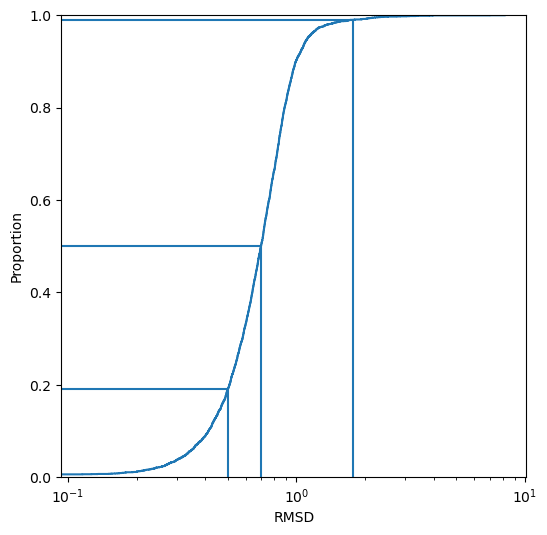

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.ecdfplot(
    data=rmsds_df,
    x='RMSD',
    # hue='Confidence',
    ax=ax,
    # bins=[0.0,1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,]
)
plt.xscale('log')
x = rmsds_df['RMSD'].quantile(0.5)
y = 0.5
plt.vlines(
    x, 
    0,
    0.5
)
plt.vlines(
    rmsds_df['RMSD'].quantile(0.99), 
    0,
    0.99
)
plt.vlines(
    rmsds_df['RMSD'].quantile(0.19), 
    0,
    0.19
)
plt.hlines(
    0.5, 
    0,
    x
)
plt.hlines(
    0.99, 
    0,
    rmsds_df['RMSD'].quantile(0.99)
)
plt.hlines(
    0.19, 
    0,
    rmsds_df['RMSD'].quantile(0.19)
)